## Data Gathering

### Data info
The data we use is based on King County data which has geolocation. This data has been collected in 2014-2015
id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long
id :a notation for a house

 - date: Date house was sold
 - price: Price is prediction target
 - bedrooms: Number of Bedrooms/House
 - bathrooms: Number of bathrooms/bedrooms
 - sqft_living: square footage of the home
 - sqft_lot: square footage of the lot
 - floors :Total floors (levels) in house
 - waterfront :House which has a view to a waterfront
 - view: Has been viewed
 - condition :How good the condition is Overall
 - grade: overall grade given to the housing unit, based on King County grading system
 - sqft_above :square footage of house apart from basement
 - sqft_basement: square footage of the basement
 - yr_built :Built Year
 - yr_renovated :Year when house was renovated
 - zipcode:zip code
 - lat: Latitude coordinate
 - long: Longitude coordinate
 - sqft_living15 :Living room area in 2015(implies-- some renovations) This might or might not have affected the lotsize area
 - sqft_lot15 :lotSize area in 2015(implies-- some renovations)

### Data mods
First of all we want to remodel the dataset:
- Drop unuseful columns from dataset
- Convert in eur currency/measure units



In [2]:
import pandas as pd

def convert_sqft_to_sqm(value):
    return value * 0.092903

def convert_dollars_to_euros(value):
    return value * 0.92

df = pd.read_csv('../data/kc_house_data.csv')  

# Drop the columns that are not useful for the analysis: sqm_lot,waterfront,view,sqm_above,sqm_basement,zipcode

columns_to_drop = ['id','date','sqft_lot', 'waterfront', 'view', 'sqft_above', 'sqft_basement', 'zipcode']

df.drop(columns=columns_to_drop, inplace=True)

# Convert the columns from sqft to sqm and from dollars to euros
df['sqft_living'] = df['sqft_living'].apply(convert_sqft_to_sqm)
df['price'] = df['price'].apply(convert_dollars_to_euros)

new_column_names = {
    'sqft_living': 'sqm_living',
}
df.rename(columns=new_column_names, inplace=True)

df.to_csv('../data/prefinal_dataset.csv', index=False)

print("Conversion done! Check the 'prefinal_dataset.csv' file in the 'data' folder.")

Conversion done! Check the 'prefinal_dataset.csv' file in the 'data' folder.


#### Now we have to create and colect info about every graph to take the measurements on based on lat and long

In [3]:

import osmnx as ox
import networkx as nx
import matplotlib.pyplot as plt


def download_osm_data(location):
    """
    Download OpenStreetMap data for a specified location.
    """
    # Graph from OSM data
    G = ox.graph_from_place(location, network_type='walk')
    return G


def extract_poi_subgraph(G, poi_coords, radius=1250):
    """
    Extract a subgraph around a point of interest within a certain radius (in meters).
    """
    amenities = [
        'hospital', 'clinic', 'doctors', 'pharmacy', 'dentist',
        'school', 'college', 'kindergarten', 'university', 'library', 'music_school',
        'supermarket', 'marketplace', 'mall', 'bank', 'bureau_de_change',
        'restaurant', 'cafe', 'bar', 'pub', 'biergarten',
        'theatre', 'cinema', 'museum', 'arts_centre', 'gallery',
        'bus_station', 'ferry_terminal', 'taxi', 'car_rental', 'bicycle_rental', 'car_sharing',
        'park', 'stadium', 'swimming_pool', 'sports_centre'
    ]
    # Get the nearest node to the POI
    nearest_node = ox.distance.nearest_nodes(G, poi_coords[1], poi_coords[0])
    
    # fetch amenities
    try:
        poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)
        
    except Exception as e:
        print(e)
        return None, None, None
    
    # Generate a subgraph around the nearest node within the specified radius
    subgraph = nx.ego_graph(G, nearest_node, radius=radius, distance='length')
    
    return subgraph, poi_df, nearest_node


def plot_graph(G):
    """
    Plot the graph.
    """
    fig, ax = ox.plot_graph(G, show=False, close=False)
    plt.show()

In [4]:
location = 'King County, Washington, USA'
# download OSM data
G = download_osm_data(location)

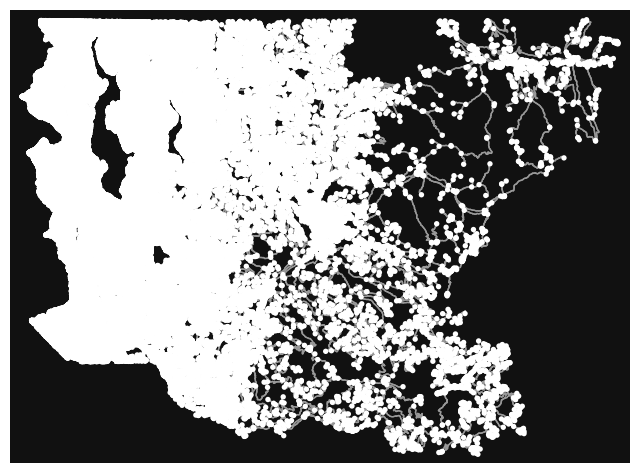

In [5]:
plot_graph(G)

Access to function: <function clustering_coef at 0x0000014D00244790>


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\4149836439.py:19: FutureWarning: The `utils.config` function is deprecated and will be removed in the v2.0.0 release. Instead, use the `settings` module directly to configure a global setting's value. For example, `ox.settings.log_console=True`. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  ox.config(use_cache=True, log_console=True)
C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\4149836439.py:35: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_point(point, tags={'amenity': amenities}, dist=dist)


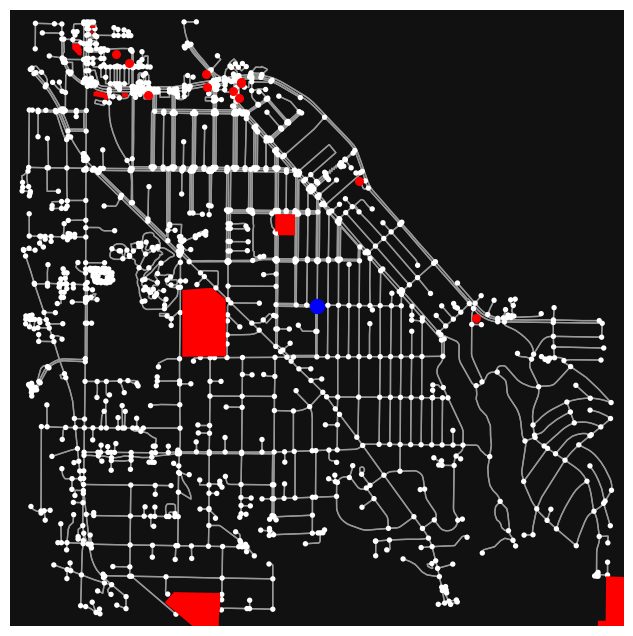

                                   alt_name     amenity  atm      brand  \
element_type osmid                                                        
node         2156871565  Washington Federal        bank  yes  WaFd Bank   
             2446638577                 NaN  restaurant  NaN        NaN   
             2446638590                 NaN        cafe  NaN        NaN   
             2446638616                 NaN  restaurant  NaN        NaN   
             5730670747                 NaN        cafe  NaN  Starbucks   

                        brand:wikidata drive_through               name  \
element_type osmid                                                        
node         2156871565       Q7971859           yes          WaFd Bank   
             2446638577            NaN           NaN  Drae's Lake Route   
             2446638590            NaN           NaN       Redwing Cafe   
             2446638616            NaN           NaN   Rainier Crawfish   
             5730670747 

In [7]:
import osmnx as ox
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx
import sklearn

import sys
import os

utils_path = os.path.join(os.getcwd(), '..', 'utils')  # Assumes utils is one directory up from the script
sys.path.append(utils_path)
# Import utils file
from utils import clustering_coef

# Test if the function can be accessed
print("Access to function:", clustering_coef)

# Set up configuration for osmnx
ox.config(use_cache=True, log_console=True)

# Function to fetch points of interest and graph
def fetch_pois(lat, lon, dist=1250, network_type='walk', plot=True):
    point = (lat, lon)
    try:
        G = ox.graph_from_point(point, dist=dist, network_type=network_type, simplify=True)
        amenities = [
            'hospital', 'clinic', 'doctors', 'pharmacy', 'dentist',
            'school', 'college', 'kindergarten', 'university', 'library', 'music_school',
            'supermarket', 'marketplace', 'mall', 'bank', 'bureau_de_change',
            'restaurant', 'cafe', 'bar', 'pub', 'biergarten',
            'theatre', 'cinema', 'museum', 'arts_centre', 'gallery',
            'bus_station', 'ferry_terminal', 'taxi', 'car_rental', 'bicycle_rental', 'car_sharing',
            'park', 'stadium', 'swimming_pool', 'sports_centre'
        ]
        pois = ox.geometries_from_point(point, tags={'amenity': amenities}, dist=dist)
        nearest_node = ox.distance.nearest_nodes(G, lon, lat)

    except Exception as e:
        print(f"Error fetching POIs for location ({lat}, {lon}): {e}")
        return None, None, None

    if plot and G is not None:
        fig, ax = ox.plot_graph(G, show=False, close=False)
        pois['geometry'].plot(ax=ax, color='red', markersize=30)
        x, y = G.nodes[nearest_node]['x'], G.nodes[nearest_node]['y']
        ax.scatter(x, y, color='blue', s=100, zorder=5)
        plt.show()
        return G, pois, nearest_node
    return G, pois, nearest_node

# Load your data
df = pd.read_csv('../data/prefinal_dataset.csv')

# Fetch POIs for the first location
lat, lon = df['lat'][0], df['long'][0]
graph, points_of_interest, nearest_node = fetch_pois(lat, lon)
print(points_of_interest.head())  # Display some of the POIs
print("Nearest node:", nearest_node)

# Perform your analysis here
# Average node degree
print("Average node degree:", sum(dict(graph.degree()).values()) / len(graph.nodes))

#measure degree centrality
degree_centrality = nx.degree_centrality(graph)
print("Degree centrality:", degree_centrality[nearest_node])

# Measure betweenness centrality
betweenness_centrality = nx.betweenness_centrality(graph)
print("Betweenness centrality:", betweenness_centrality[nearest_node])

# Measure closeness centrality
closeness_centrality = nx.closeness_centrality(graph)
print("Closeness centrality:", closeness_centrality[nearest_node])

# Measure graph density and average path length
density = nx.density(graph)
print("Graph density:", density)

#### Doing the example for all samples

!!! DONT START A FULL RUN ON THIS YET

In [10]:
import numpy as np

# Load data
df = pd.read_csv('../data/final_dataset.csv')

max_iterations = 5000
start_index = 1

for index, row in df.iterrows():
    if index < start_index:
        continue
    if index >= start_index + max_iterations:
        print("Max iterations reached.")
        break

    lat = row['lat']
    lon = row['long']
    check = row['avg_degree']
    if np.isnan(check) == False:
        print(f"Index {index} already processed, skip.")
        max_iterations += 1
        continue

    subGraph, pointOfInterest, nearestNode = extract_poi_subgraph(G, (lat, lon))
    if subGraph is None or pointOfInterest is None or nearestNode is None:
        print(f"Error processing index {index}, skip.")
        continue

    avg_degree = sum(dict(subGraph.degree()).values()) / len(subGraph.nodes)
    degree_centrality = nx.degree_centrality(subGraph)
    betweenness_centrality = nx.betweenness_centrality(subGraph)
    closeness_centrality = nx.closeness_centrality(subGraph)
    density = nx.density(subGraph)

    df.at[index, 'avg_degree'] = avg_degree
    df.at[index, 'degree_centrality'] = degree_centrality[nearestNode]
    df.at[index, 'betweenness_centrality'] = betweenness_centrality[nearestNode]
    df.at[index, 'closeness_centrality'] = closeness_centrality[nearestNode]
    df.at[index, 'density'] = density
    print("Done for index:", index)

    # save the updated dataframe
    df.to_csv('../data/final_dataset.csv', index=False)


Index 1 already processed, skip.
Index 2 already processed, skip.
Index 3 already processed, skip.
Index 4 already processed, skip.


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


No data elements in server response. Check log and query location/tags.
Error processing index 5, skip.
Index 6 already processed, skip.
Index 7 already processed, skip.
Index 8 already processed, skip.
Index 9 already processed, skip.
Index 10 already processed, skip.
Index 11 already processed, skip.
Index 12 already processed, skip.
Index 13 already processed, skip.
Index 14 already processed, skip.
Index 15 already processed, skip.
Index 16 already processed, skip.
Index 17 already processed, skip.
Index 18 already processed, skip.
Index 19 already processed, skip.
Index 20 already processed, skip.
Index 21 already processed, skip.
Index 22 already processed, skip.
Index 23 already processed, skip.
Index 24 already processed, skip.
Index 25 already processed, skip.
Index 26 already processed, skip.
Index 27 already processed, skip.
Index 28 already processed, skip.
Index 29 already processed, skip.
Index 30 already processed, skip.
Index 31 already processed, skip.
Index 32 already

C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


No data elements in server response. Check log and query location/tags.
Error processing index 49, skip.
Index 50 already processed, skip.
Index 51 already processed, skip.
Index 52 already processed, skip.
Index 53 already processed, skip.
Index 54 already processed, skip.
Index 55 already processed, skip.
Index 56 already processed, skip.
Index 57 already processed, skip.
Index 58 already processed, skip.
Index 59 already processed, skip.
Index 60 already processed, skip.
Index 61 already processed, skip.
Index 62 already processed, skip.
Index 63 already processed, skip.
Index 64 already processed, skip.
Index 65 already processed, skip.
Index 66 already processed, skip.
Index 67 already processed, skip.
Index 68 already processed, skip.
Index 69 already processed, skip.
Index 70 already processed, skip.
Index 71 already processed, skip.
Index 72 already processed, skip.
Index 73 already processed, skip.
Index 74 already processed, skip.
Index 75 already processed, skip.
Index 76 al

C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


No data elements in server response. Check log and query location/tags.
Error processing index 98, skip.
Index 99 already processed, skip.
Index 100 already processed, skip.
Index 101 already processed, skip.
Index 102 already processed, skip.
Index 103 already processed, skip.
Index 104 already processed, skip.
Index 105 already processed, skip.
Index 106 already processed, skip.
Index 107 already processed, skip.


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


No data elements in server response. Check log and query location/tags.
Error processing index 108, skip.
Index 109 already processed, skip.
Index 110 already processed, skip.
Index 111 already processed, skip.
Index 112 already processed, skip.
Index 113 already processed, skip.
Index 114 already processed, skip.
Index 115 already processed, skip.
Index 116 already processed, skip.
Index 117 already processed, skip.
Index 118 already processed, skip.
Index 119 already processed, skip.
Index 120 already processed, skip.
Index 121 already processed, skip.
Index 122 already processed, skip.
Index 123 already processed, skip.
Index 124 already processed, skip.
Index 125 already processed, skip.
Index 126 already processed, skip.
Index 127 already processed, skip.
Index 128 already processed, skip.
Index 129 already processed, skip.
Index 130 already processed, skip.
Index 131 already processed, skip.
Index 132 already processed, skip.
Index 133 already processed, skip.
Index 134 already p

C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


No data elements in server response. Check log and query location/tags.
Error processing index 164, skip.
Index 165 already processed, skip.
Index 166 already processed, skip.
Index 167 already processed, skip.
Index 168 already processed, skip.
Index 169 already processed, skip.
Index 170 already processed, skip.
Index 171 already processed, skip.
Index 172 already processed, skip.
Index 173 already processed, skip.
Index 174 already processed, skip.
Index 175 already processed, skip.
Index 176 already processed, skip.
Index 177 already processed, skip.
Index 178 already processed, skip.
Index 179 already processed, skip.
Index 180 already processed, skip.
Index 181 already processed, skip.
Index 182 already processed, skip.
Index 183 already processed, skip.
Index 184 already processed, skip.
Index 185 already processed, skip.
Index 186 already processed, skip.
Index 187 already processed, skip.
Index 188 already processed, skip.
Index 189 already processed, skip.
Index 190 already p

C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


No data elements in server response. Check log and query location/tags.
Error processing index 198, skip.


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


No data elements in server response. Check log and query location/tags.
Error processing index 199, skip.
Index 200 already processed, skip.
Index 201 already processed, skip.
Index 202 already processed, skip.
Index 203 already processed, skip.
Index 204 already processed, skip.
Index 205 already processed, skip.
Index 206 already processed, skip.
Index 207 already processed, skip.
Index 208 already processed, skip.
Index 209 already processed, skip.
Index 210 already processed, skip.
Index 211 already processed, skip.
Index 212 already processed, skip.
Index 213 already processed, skip.
Index 214 already processed, skip.
Index 215 already processed, skip.
Index 216 already processed, skip.
Index 217 already processed, skip.
Index 218 already processed, skip.
Index 219 already processed, skip.
Index 220 already processed, skip.
Index 221 already processed, skip.
Index 222 already processed, skip.
Index 223 already processed, skip.
Index 224 already processed, skip.
Index 225 already p

C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


No data elements in server response. Check log and query location/tags.
Error processing index 230, skip.
Index 231 already processed, skip.
Index 232 already processed, skip.
Index 233 already processed, skip.
Index 234 already processed, skip.
Index 235 already processed, skip.


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


No data elements in server response. Check log and query location/tags.
Error processing index 236, skip.
Index 237 already processed, skip.


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


No data elements in server response. Check log and query location/tags.
Error processing index 238, skip.
Index 239 already processed, skip.
Index 240 already processed, skip.
Index 241 already processed, skip.
Index 242 already processed, skip.
Index 243 already processed, skip.
Index 244 already processed, skip.
Index 245 already processed, skip.
Index 246 already processed, skip.
Index 247 already processed, skip.
Index 248 already processed, skip.
Index 249 already processed, skip.
Index 250 already processed, skip.
Index 251 already processed, skip.
Index 252 already processed, skip.
Index 253 already processed, skip.
Index 254 already processed, skip.
Index 255 already processed, skip.
Index 256 already processed, skip.
Index 257 already processed, skip.
Index 258 already processed, skip.
Index 259 already processed, skip.
Index 260 already processed, skip.
Index 261 already processed, skip.
Index 262 already processed, skip.
Index 263 already processed, skip.


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


No data elements in server response. Check log and query location/tags.
Error processing index 264, skip.
Index 265 already processed, skip.
Index 266 already processed, skip.
Index 267 already processed, skip.
Index 268 already processed, skip.
Index 269 already processed, skip.
Index 270 already processed, skip.
Index 271 already processed, skip.
Index 272 already processed, skip.
Index 273 already processed, skip.
Index 274 already processed, skip.
Index 275 already processed, skip.
Index 276 already processed, skip.
Index 277 already processed, skip.


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


No data elements in server response. Check log and query location/tags.
Error processing index 278, skip.
Index 279 already processed, skip.
Index 280 already processed, skip.
Index 281 already processed, skip.
Index 282 already processed, skip.
Index 283 already processed, skip.
Index 284 already processed, skip.
Index 285 already processed, skip.
Index 286 already processed, skip.
Index 287 already processed, skip.
Index 288 already processed, skip.
Index 289 already processed, skip.
Index 290 already processed, skip.
Index 291 already processed, skip.
Index 292 already processed, skip.
Index 293 already processed, skip.
Index 294 already processed, skip.
Index 295 already processed, skip.
Index 296 already processed, skip.
Index 297 already processed, skip.
Index 298 already processed, skip.
Index 299 already processed, skip.
Index 300 already processed, skip.
Index 301 already processed, skip.
Index 302 already processed, skip.


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


No data elements in server response. Check log and query location/tags.
Error processing index 303, skip.
Index 304 already processed, skip.
Index 305 already processed, skip.
Index 306 already processed, skip.
Index 307 already processed, skip.
Index 308 already processed, skip.
Index 309 already processed, skip.
Index 310 already processed, skip.
Index 311 already processed, skip.
Index 312 already processed, skip.
Index 313 already processed, skip.
Index 314 already processed, skip.
Index 315 already processed, skip.
Index 316 already processed, skip.
Index 317 already processed, skip.
Index 318 already processed, skip.
Index 319 already processed, skip.
Index 320 already processed, skip.


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


No data elements in server response. Check log and query location/tags.
Error processing index 321, skip.
Index 322 already processed, skip.
Index 323 already processed, skip.
Index 324 already processed, skip.
Index 325 already processed, skip.
Index 326 already processed, skip.
Index 327 already processed, skip.
Index 328 already processed, skip.
Index 329 already processed, skip.
Index 330 already processed, skip.
Index 331 already processed, skip.
Index 332 already processed, skip.
Index 333 already processed, skip.
Index 334 already processed, skip.
Index 335 already processed, skip.
Index 336 already processed, skip.
Index 337 already processed, skip.
Index 338 already processed, skip.
Index 339 already processed, skip.
Index 340 already processed, skip.
Index 341 already processed, skip.
Index 342 already processed, skip.


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


No data elements in server response. Check log and query location/tags.
Error processing index 343, skip.
Index 344 already processed, skip.
Index 345 already processed, skip.
Index 346 already processed, skip.
Index 347 already processed, skip.
Index 348 already processed, skip.
Index 349 already processed, skip.


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


No data elements in server response. Check log and query location/tags.
Error processing index 350, skip.
Index 351 already processed, skip.
Index 352 already processed, skip.
Index 353 already processed, skip.
Index 354 already processed, skip.
Index 355 already processed, skip.
Index 356 already processed, skip.
Index 357 already processed, skip.
Index 358 already processed, skip.
Index 359 already processed, skip.


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


No data elements in server response. Check log and query location/tags.
Error processing index 360, skip.
Index 361 already processed, skip.
Index 362 already processed, skip.
Index 363 already processed, skip.
Index 364 already processed, skip.
Index 365 already processed, skip.
Index 366 already processed, skip.
Index 367 already processed, skip.
Index 368 already processed, skip.
Index 369 already processed, skip.
Index 370 already processed, skip.
Index 371 already processed, skip.
Index 372 already processed, skip.
Index 373 already processed, skip.
Index 374 already processed, skip.
Index 375 already processed, skip.
Index 376 already processed, skip.
Index 377 already processed, skip.
Index 378 already processed, skip.
Index 379 already processed, skip.
Index 380 already processed, skip.


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


No data elements in server response. Check log and query location/tags.
Error processing index 381, skip.
Index 382 already processed, skip.
Index 383 already processed, skip.
Index 384 already processed, skip.
Index 385 already processed, skip.
Index 386 already processed, skip.
Index 387 already processed, skip.
Index 388 already processed, skip.
Index 389 already processed, skip.
Index 390 already processed, skip.
Index 391 already processed, skip.


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


No data elements in server response. Check log and query location/tags.
Error processing index 392, skip.
Index 393 already processed, skip.
Index 394 already processed, skip.
Index 395 already processed, skip.
Index 396 already processed, skip.
Index 397 already processed, skip.
Index 398 already processed, skip.
Index 399 already processed, skip.
Index 400 already processed, skip.
Index 401 already processed, skip.
Index 402 already processed, skip.
Index 403 already processed, skip.
Index 404 already processed, skip.
Index 405 already processed, skip.
Index 406 already processed, skip.
Index 407 already processed, skip.
Index 408 already processed, skip.
Index 409 already processed, skip.
Index 410 already processed, skip.
Index 411 already processed, skip.
Index 412 already processed, skip.
Index 413 already processed, skip.
Index 414 already processed, skip.
Index 415 already processed, skip.


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


No data elements in server response. Check log and query location/tags.
Error processing index 416, skip.
Index 417 already processed, skip.
Index 418 already processed, skip.


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


No data elements in server response. Check log and query location/tags.
Error processing index 419, skip.
Index 420 already processed, skip.
Index 421 already processed, skip.
Index 422 already processed, skip.
Index 423 already processed, skip.
Index 424 already processed, skip.
Index 425 already processed, skip.
Index 426 already processed, skip.
Index 427 already processed, skip.
Index 428 already processed, skip.
Index 429 already processed, skip.
Index 430 already processed, skip.
Index 431 already processed, skip.
Index 432 already processed, skip.
Index 433 already processed, skip.
Index 434 already processed, skip.
Index 435 already processed, skip.
Index 436 already processed, skip.
Index 437 already processed, skip.
Index 438 already processed, skip.
Index 439 already processed, skip.
Index 440 already processed, skip.
Index 441 already processed, skip.
Index 442 already processed, skip.


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


No data elements in server response. Check log and query location/tags.
Error processing index 443, skip.
Index 444 already processed, skip.
Index 445 already processed, skip.
Index 446 already processed, skip.
Index 447 already processed, skip.
Index 448 already processed, skip.
Index 449 already processed, skip.
Index 450 already processed, skip.
Index 451 already processed, skip.
Index 452 already processed, skip.
Index 453 already processed, skip.
Index 454 already processed, skip.
Index 455 already processed, skip.
Index 456 already processed, skip.


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


No data elements in server response. Check log and query location/tags.
Error processing index 457, skip.
Index 458 already processed, skip.
Index 459 already processed, skip.
Index 460 already processed, skip.
Index 461 already processed, skip.
Index 462 already processed, skip.
Index 463 already processed, skip.
Index 464 already processed, skip.
Index 465 already processed, skip.
Index 466 already processed, skip.
Index 467 already processed, skip.
Index 468 already processed, skip.
Index 469 already processed, skip.
Index 470 already processed, skip.
Index 471 already processed, skip.
Index 472 already processed, skip.
Index 473 already processed, skip.
Index 474 already processed, skip.
Index 475 already processed, skip.
Index 476 already processed, skip.
Index 477 already processed, skip.
Index 478 already processed, skip.
Index 479 already processed, skip.
Index 480 already processed, skip.
Index 481 already processed, skip.
Index 482 already processed, skip.
Index 483 already p

C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


No data elements in server response. Check log and query location/tags.
Error processing index 527, skip.
Index 528 already processed, skip.
Index 529 already processed, skip.
Index 530 already processed, skip.
Index 531 already processed, skip.
Index 532 already processed, skip.
Index 533 already processed, skip.
Index 534 already processed, skip.
Index 535 already processed, skip.
Index 536 already processed, skip.
Index 537 already processed, skip.
Index 538 already processed, skip.
Index 539 already processed, skip.
Index 540 already processed, skip.
Index 541 already processed, skip.
Index 542 already processed, skip.
Index 543 already processed, skip.
Index 544 already processed, skip.
Index 545 already processed, skip.
Index 546 already processed, skip.
Index 547 already processed, skip.
Index 548 already processed, skip.
Index 549 already processed, skip.
Index 550 already processed, skip.
Index 551 already processed, skip.
Index 552 already processed, skip.
Index 553 already p

C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


No data elements in server response. Check log and query location/tags.
Error processing index 555, skip.
Index 556 already processed, skip.
Index 557 already processed, skip.
Index 558 already processed, skip.
Index 559 already processed, skip.
Index 560 already processed, skip.
Index 561 already processed, skip.
Index 562 already processed, skip.
Index 563 already processed, skip.
Index 564 already processed, skip.
Index 565 already processed, skip.
Index 566 already processed, skip.
Index 567 already processed, skip.
Index 568 already processed, skip.


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


No data elements in server response. Check log and query location/tags.
Error processing index 569, skip.
Index 570 already processed, skip.
Index 571 already processed, skip.
Index 572 already processed, skip.
Index 573 already processed, skip.
Index 574 already processed, skip.


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


No data elements in server response. Check log and query location/tags.
Error processing index 575, skip.
Index 576 already processed, skip.
Index 577 already processed, skip.
Index 578 already processed, skip.
Index 579 already processed, skip.
Index 580 already processed, skip.
Index 581 already processed, skip.
Index 582 already processed, skip.
Index 583 already processed, skip.
Index 584 already processed, skip.
Index 585 already processed, skip.
Index 586 already processed, skip.
Index 587 already processed, skip.
Index 588 already processed, skip.
Index 589 already processed, skip.


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


No data elements in server response. Check log and query location/tags.
Error processing index 590, skip.


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


No data elements in server response. Check log and query location/tags.
Error processing index 591, skip.
Index 592 already processed, skip.
Index 593 already processed, skip.
Index 594 already processed, skip.
Index 595 already processed, skip.
Index 596 already processed, skip.
Index 597 already processed, skip.
Index 598 already processed, skip.
Index 599 already processed, skip.
Index 600 already processed, skip.
Index 601 already processed, skip.
Index 602 already processed, skip.
Index 603 already processed, skip.
Index 604 already processed, skip.
Index 605 already processed, skip.
Index 606 already processed, skip.
Index 607 already processed, skip.
Index 608 already processed, skip.
Index 609 already processed, skip.
Index 610 already processed, skip.
Index 611 already processed, skip.
Index 612 already processed, skip.
Index 613 already processed, skip.
Index 614 already processed, skip.
Index 615 already processed, skip.
Index 616 already processed, skip.
Index 617 already p

C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


No data elements in server response. Check log and query location/tags.
Error processing index 689, skip.
Index 690 already processed, skip.
Index 691 already processed, skip.
Index 692 already processed, skip.
Index 693 already processed, skip.
Index 694 already processed, skip.
Index 695 already processed, skip.
Index 696 already processed, skip.
Index 697 already processed, skip.
Index 698 already processed, skip.
Index 699 already processed, skip.
Index 700 already processed, skip.
Index 701 already processed, skip.
Index 702 already processed, skip.
Index 703 already processed, skip.
Index 704 already processed, skip.
Index 705 already processed, skip.
Index 706 already processed, skip.
Index 707 already processed, skip.
Index 708 already processed, skip.


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


No data elements in server response. Check log and query location/tags.
Error processing index 709, skip.
Index 710 already processed, skip.
Index 711 already processed, skip.
Index 712 already processed, skip.
Index 713 already processed, skip.
Index 714 already processed, skip.
Index 715 already processed, skip.
Index 716 already processed, skip.
Index 717 already processed, skip.
Index 718 already processed, skip.
Index 719 already processed, skip.
Index 720 already processed, skip.
Index 721 already processed, skip.
Index 722 already processed, skip.
Index 723 already processed, skip.
Index 724 already processed, skip.
Index 725 already processed, skip.
Index 726 already processed, skip.
Index 727 already processed, skip.
Index 728 already processed, skip.


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


No data elements in server response. Check log and query location/tags.
Error processing index 729, skip.
Index 730 already processed, skip.
Index 731 already processed, skip.
Index 732 already processed, skip.
Index 733 already processed, skip.
Index 734 already processed, skip.
Index 735 already processed, skip.
Index 736 already processed, skip.
Index 737 already processed, skip.
Index 738 already processed, skip.
Index 739 already processed, skip.
Index 740 already processed, skip.
Index 741 already processed, skip.
Index 742 already processed, skip.
Index 743 already processed, skip.
Index 744 already processed, skip.
Index 745 already processed, skip.
Index 746 already processed, skip.
Index 747 already processed, skip.
Index 748 already processed, skip.
Index 749 already processed, skip.
Index 750 already processed, skip.
Index 751 already processed, skip.
Index 752 already processed, skip.
Index 753 already processed, skip.
Index 754 already processed, skip.
Index 755 already p

C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


No data elements in server response. Check log and query location/tags.
Error processing index 760, skip.
Index 761 already processed, skip.


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


No data elements in server response. Check log and query location/tags.
Error processing index 762, skip.
Index 763 already processed, skip.
Index 764 already processed, skip.
Index 765 already processed, skip.
Index 766 already processed, skip.
Index 767 already processed, skip.
Index 768 already processed, skip.
Index 769 already processed, skip.
Index 770 already processed, skip.
Index 771 already processed, skip.
Index 772 already processed, skip.
Index 773 already processed, skip.
Index 774 already processed, skip.
Index 775 already processed, skip.
Index 776 already processed, skip.
Index 777 already processed, skip.
Index 778 already processed, skip.
Index 779 already processed, skip.
Index 780 already processed, skip.
Index 781 already processed, skip.
Index 782 already processed, skip.
Index 783 already processed, skip.
Index 784 already processed, skip.
Index 785 already processed, skip.
Index 786 already processed, skip.


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


No data elements in server response. Check log and query location/tags.
Error processing index 787, skip.
Index 788 already processed, skip.
Index 789 already processed, skip.
Index 790 already processed, skip.
Index 791 already processed, skip.
Index 792 already processed, skip.
Index 793 already processed, skip.
Index 794 already processed, skip.
Index 795 already processed, skip.


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


No data elements in server response. Check log and query location/tags.
Error processing index 796, skip.
Index 797 already processed, skip.
Index 798 already processed, skip.
Index 799 already processed, skip.
Index 800 already processed, skip.
Index 801 already processed, skip.
Index 802 already processed, skip.
Index 803 already processed, skip.
Index 804 already processed, skip.
Index 805 already processed, skip.
Index 806 already processed, skip.
Index 807 already processed, skip.
Index 808 already processed, skip.
Index 809 already processed, skip.
Index 810 already processed, skip.
Index 811 already processed, skip.
Index 812 already processed, skip.
Index 813 already processed, skip.
Index 814 already processed, skip.
Index 815 already processed, skip.
Index 816 already processed, skip.
Index 817 already processed, skip.
Index 818 already processed, skip.
Index 819 already processed, skip.
Index 820 already processed, skip.
Index 821 already processed, skip.
Index 822 already p

C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


No data elements in server response. Check log and query location/tags.
Error processing index 843, skip.
Index 844 already processed, skip.
Index 845 already processed, skip.
Index 846 already processed, skip.
Index 847 already processed, skip.
Index 848 already processed, skip.
Index 849 already processed, skip.
Index 850 already processed, skip.
Index 851 already processed, skip.
Index 852 already processed, skip.
Index 853 already processed, skip.
Index 854 already processed, skip.
Index 855 already processed, skip.
Index 856 already processed, skip.
Index 857 already processed, skip.


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


No data elements in server response. Check log and query location/tags.
Error processing index 858, skip.
Index 859 already processed, skip.
Index 860 already processed, skip.
Index 861 already processed, skip.
Index 862 already processed, skip.
Index 863 already processed, skip.
Index 864 already processed, skip.
Index 865 already processed, skip.
Index 866 already processed, skip.
Index 867 already processed, skip.
Index 868 already processed, skip.
Index 869 already processed, skip.
Index 870 already processed, skip.
Index 871 already processed, skip.
Index 872 already processed, skip.
Index 873 already processed, skip.
Index 874 already processed, skip.
Index 875 already processed, skip.
Index 876 already processed, skip.
Index 877 already processed, skip.
Index 878 already processed, skip.
Index 879 already processed, skip.
Index 880 already processed, skip.
Index 881 already processed, skip.
Index 882 already processed, skip.
Index 883 already processed, skip.
Index 884 already p

C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


No data elements in server response. Check log and query location/tags.
Error processing index 929, skip.
Index 930 already processed, skip.
Index 931 already processed, skip.
Index 932 already processed, skip.
Index 933 already processed, skip.
Index 934 already processed, skip.
Index 935 already processed, skip.
Index 936 already processed, skip.
Index 937 already processed, skip.
Index 938 already processed, skip.
Index 939 already processed, skip.
Index 940 already processed, skip.
Index 941 already processed, skip.
Index 942 already processed, skip.
Index 943 already processed, skip.
Index 944 already processed, skip.
Index 945 already processed, skip.
Index 946 already processed, skip.
Index 947 already processed, skip.
Index 948 already processed, skip.
Index 949 already processed, skip.
Index 950 already processed, skip.
Index 951 already processed, skip.
Index 952 already processed, skip.
Index 953 already processed, skip.
Index 954 already processed, skip.
Index 955 already p

C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


No data elements in server response. Check log and query location/tags.
Error processing index 1045, skip.
Index 1046 already processed, skip.


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


No data elements in server response. Check log and query location/tags.
Error processing index 1047, skip.
Index 1048 already processed, skip.
Index 1049 already processed, skip.
Index 1050 already processed, skip.
Index 1051 already processed, skip.
Index 1052 already processed, skip.
Index 1053 already processed, skip.
Index 1054 already processed, skip.
Index 1055 already processed, skip.
Index 1056 already processed, skip.
Index 1057 already processed, skip.
Index 1058 already processed, skip.
Index 1059 already processed, skip.
Index 1060 already processed, skip.
Index 1061 already processed, skip.
Index 1062 already processed, skip.
Index 1063 already processed, skip.
Index 1064 already processed, skip.
Index 1065 already processed, skip.
Index 1066 already processed, skip.
Index 1067 already processed, skip.
Index 1068 already processed, skip.
Index 1069 already processed, skip.
Index 1070 already processed, skip.
Index 1071 already processed, skip.
Index 1072 already processed,

C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


No data elements in server response. Check log and query location/tags.
Error processing index 1149, skip.
Index 1150 already processed, skip.
Index 1151 already processed, skip.


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


No data elements in server response. Check log and query location/tags.
Error processing index 1152, skip.
Index 1153 already processed, skip.


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


No data elements in server response. Check log and query location/tags.
Error processing index 1154, skip.
Index 1155 already processed, skip.
Index 1156 already processed, skip.
Index 1157 already processed, skip.
Index 1158 already processed, skip.
Index 1159 already processed, skip.
Index 1160 already processed, skip.
Index 1161 already processed, skip.
Index 1162 already processed, skip.
Index 1163 already processed, skip.
Index 1164 already processed, skip.
Index 1165 already processed, skip.
Index 1166 already processed, skip.
Index 1167 already processed, skip.


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


No data elements in server response. Check log and query location/tags.
Error processing index 1168, skip.
Index 1169 already processed, skip.
Index 1170 already processed, skip.


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


No data elements in server response. Check log and query location/tags.
Error processing index 1171, skip.
Index 1172 already processed, skip.
Index 1173 already processed, skip.
Index 1174 already processed, skip.
Index 1175 already processed, skip.
Index 1176 already processed, skip.
Index 1177 already processed, skip.
Index 1178 already processed, skip.
Index 1179 already processed, skip.
Index 1180 already processed, skip.


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


No data elements in server response. Check log and query location/tags.
Error processing index 1181, skip.
Index 1182 already processed, skip.
Index 1183 already processed, skip.
Index 1184 already processed, skip.
Index 1185 already processed, skip.
Index 1186 already processed, skip.


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


No data elements in server response. Check log and query location/tags.
Error processing index 1187, skip.
Index 1188 already processed, skip.
Index 1189 already processed, skip.
Index 1190 already processed, skip.
Index 1191 already processed, skip.
Index 1192 already processed, skip.
Index 1193 already processed, skip.
Index 1194 already processed, skip.
Index 1195 already processed, skip.
Index 1196 already processed, skip.
Index 1197 already processed, skip.
Index 1198 already processed, skip.


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


No data elements in server response. Check log and query location/tags.
Error processing index 1199, skip.
Index 1200 already processed, skip.
Index 1201 already processed, skip.
Index 1202 already processed, skip.
Index 1203 already processed, skip.
Index 1204 already processed, skip.
Index 1205 already processed, skip.
Index 1206 already processed, skip.
Index 1207 already processed, skip.
Index 1208 already processed, skip.
Index 1209 already processed, skip.
Index 1210 already processed, skip.
Index 1211 already processed, skip.
Index 1212 already processed, skip.
Index 1213 already processed, skip.
Index 1214 already processed, skip.
Index 1215 already processed, skip.
Index 1216 already processed, skip.
Index 1217 already processed, skip.
Index 1218 already processed, skip.
Index 1219 already processed, skip.
Index 1220 already processed, skip.
Index 1221 already processed, skip.
Index 1222 already processed, skip.
Index 1223 already processed, skip.
Index 1224 already processed,

C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


No data elements in server response. Check log and query location/tags.
Error processing index 1285, skip.
Index 1286 already processed, skip.
Index 1287 already processed, skip.
Index 1288 already processed, skip.
Index 1289 already processed, skip.
Index 1290 already processed, skip.
Index 1291 already processed, skip.
Index 1292 already processed, skip.
Index 1293 already processed, skip.


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


No data elements in server response. Check log and query location/tags.
Error processing index 1294, skip.
Index 1295 already processed, skip.
Index 1296 already processed, skip.
Index 1297 already processed, skip.
Index 1298 already processed, skip.
Index 1299 already processed, skip.
Index 1300 already processed, skip.
Index 1301 already processed, skip.
Index 1302 already processed, skip.
Index 1303 already processed, skip.
Index 1304 already processed, skip.
Index 1305 already processed, skip.
Index 1306 already processed, skip.
Index 1307 already processed, skip.
Index 1308 already processed, skip.
Index 1309 already processed, skip.
Index 1310 already processed, skip.
Index 1311 already processed, skip.
Index 1312 already processed, skip.
Index 1313 already processed, skip.
Index 1314 already processed, skip.
Index 1315 already processed, skip.


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


No data elements in server response. Check log and query location/tags.
Error processing index 1316, skip.
Index 1317 already processed, skip.
Index 1318 already processed, skip.
Index 1319 already processed, skip.
Index 1320 already processed, skip.
Index 1321 already processed, skip.
Index 1322 already processed, skip.
Index 1323 already processed, skip.
Index 1324 already processed, skip.
Index 1325 already processed, skip.
Index 1326 already processed, skip.
Index 1327 already processed, skip.
Index 1328 already processed, skip.


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


No data elements in server response. Check log and query location/tags.
Error processing index 1329, skip.
Index 1330 already processed, skip.
Index 1331 already processed, skip.
Index 1332 already processed, skip.
Index 1333 already processed, skip.
Index 1334 already processed, skip.
Index 1335 already processed, skip.
Index 1336 already processed, skip.
Index 1337 already processed, skip.
Index 1338 already processed, skip.
Index 1339 already processed, skip.
Index 1340 already processed, skip.
Index 1341 already processed, skip.
Index 1342 already processed, skip.
Index 1343 already processed, skip.
Index 1344 already processed, skip.
Index 1345 already processed, skip.
Index 1346 already processed, skip.
Index 1347 already processed, skip.
Index 1348 already processed, skip.
Index 1349 already processed, skip.
Index 1350 already processed, skip.
Index 1351 already processed, skip.
Index 1352 already processed, skip.
Index 1353 already processed, skip.
Index 1354 already processed,

C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


No data elements in server response. Check log and query location/tags.
Error processing index 1372, skip.
Index 1373 already processed, skip.
Index 1374 already processed, skip.
Index 1375 already processed, skip.
Index 1376 already processed, skip.
Index 1377 already processed, skip.
Index 1378 already processed, skip.
Index 1379 already processed, skip.
Index 1380 already processed, skip.
Index 1381 already processed, skip.
Index 1382 already processed, skip.
Index 1383 already processed, skip.
Index 1384 already processed, skip.
Index 1385 already processed, skip.
Index 1386 already processed, skip.
Index 1387 already processed, skip.
Index 1388 already processed, skip.


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


No data elements in server response. Check log and query location/tags.
Error processing index 1389, skip.
Index 1390 already processed, skip.
Index 1391 already processed, skip.
Index 1392 already processed, skip.
Index 1393 already processed, skip.
Index 1394 already processed, skip.
Index 1395 already processed, skip.
Index 1396 already processed, skip.
Index 1397 already processed, skip.
Index 1398 already processed, skip.
Index 1399 already processed, skip.
Index 1400 already processed, skip.
Index 1401 already processed, skip.
Index 1402 already processed, skip.


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


No data elements in server response. Check log and query location/tags.
Error processing index 1403, skip.
Index 1404 already processed, skip.
Index 1405 already processed, skip.
Index 1406 already processed, skip.
Index 1407 already processed, skip.
Index 1408 already processed, skip.
Index 1409 already processed, skip.
Index 1410 already processed, skip.
Index 1411 already processed, skip.
Index 1412 already processed, skip.
Index 1413 already processed, skip.
Index 1414 already processed, skip.
Index 1415 already processed, skip.
Index 1416 already processed, skip.
Index 1417 already processed, skip.
Index 1418 already processed, skip.
Index 1419 already processed, skip.
Index 1420 already processed, skip.
Index 1421 already processed, skip.
Index 1422 already processed, skip.
Index 1423 already processed, skip.
Index 1424 already processed, skip.
Index 1425 already processed, skip.
Index 1426 already processed, skip.
Index 1427 already processed, skip.
Index 1428 already processed,

C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


No data elements in server response. Check log and query location/tags.
Error processing index 1483, skip.
Index 1484 already processed, skip.
Index 1485 already processed, skip.
Index 1486 already processed, skip.
Index 1487 already processed, skip.
Index 1488 already processed, skip.
Index 1489 already processed, skip.
Index 1490 already processed, skip.
Index 1491 already processed, skip.
Index 1492 already processed, skip.
Index 1493 already processed, skip.
Index 1494 already processed, skip.
Index 1495 already processed, skip.
Index 1496 already processed, skip.
Index 1497 already processed, skip.
Index 1498 already processed, skip.
Index 1499 already processed, skip.
Index 1500 already processed, skip.
Index 1501 already processed, skip.
Index 1502 already processed, skip.
Index 1503 already processed, skip.
Index 1504 already processed, skip.
Index 1505 already processed, skip.
Index 1506 already processed, skip.
Index 1507 already processed, skip.
Index 1508 already processed,

C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


No data elements in server response. Check log and query location/tags.
Error processing index 1519, skip.
Index 1520 already processed, skip.
Index 1521 already processed, skip.
Index 1522 already processed, skip.
Index 1523 already processed, skip.
Index 1524 already processed, skip.
Index 1525 already processed, skip.
Index 1526 already processed, skip.
Index 1527 already processed, skip.
Index 1528 already processed, skip.
Index 1529 already processed, skip.
Index 1530 already processed, skip.
Index 1531 already processed, skip.
Index 1532 already processed, skip.
Index 1533 already processed, skip.
Index 1534 already processed, skip.
Index 1535 already processed, skip.
Index 1536 already processed, skip.
Index 1537 already processed, skip.
Index 1538 already processed, skip.
Index 1539 already processed, skip.
Index 1540 already processed, skip.
Index 1541 already processed, skip.
Index 1542 already processed, skip.
Index 1543 already processed, skip.
Index 1544 already processed,

C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


No data elements in server response. Check log and query location/tags.
Error processing index 1606, skip.
Index 1607 already processed, skip.
Index 1608 already processed, skip.
Index 1609 already processed, skip.
Index 1610 already processed, skip.
Index 1611 already processed, skip.
Index 1612 already processed, skip.


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


No data elements in server response. Check log and query location/tags.
Error processing index 1613, skip.
Index 1614 already processed, skip.
Index 1615 already processed, skip.
Index 1616 already processed, skip.
Index 1617 already processed, skip.
Index 1618 already processed, skip.
Index 1619 already processed, skip.
Index 1620 already processed, skip.
Index 1621 already processed, skip.
Index 1622 already processed, skip.
Index 1623 already processed, skip.


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


No data elements in server response. Check log and query location/tags.
Error processing index 1624, skip.
Index 1625 already processed, skip.
Index 1626 already processed, skip.
Index 1627 already processed, skip.
Index 1628 already processed, skip.
Index 1629 already processed, skip.
Index 1630 already processed, skip.
Index 1631 already processed, skip.


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


No data elements in server response. Check log and query location/tags.
Error processing index 1632, skip.
Index 1633 already processed, skip.
Index 1634 already processed, skip.
Index 1635 already processed, skip.
Index 1636 already processed, skip.
Index 1637 already processed, skip.
Index 1638 already processed, skip.
Index 1639 already processed, skip.
Index 1640 already processed, skip.
Index 1641 already processed, skip.
Index 1642 already processed, skip.
Index 1643 already processed, skip.
Index 1644 already processed, skip.
Index 1645 already processed, skip.
Index 1646 already processed, skip.
Index 1647 already processed, skip.
Index 1648 already processed, skip.
Index 1649 already processed, skip.
Index 1650 already processed, skip.
Index 1651 already processed, skip.
Index 1652 already processed, skip.


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


No data elements in server response. Check log and query location/tags.
Error processing index 1653, skip.
Index 1654 already processed, skip.
Index 1655 already processed, skip.
Index 1656 already processed, skip.
Index 1657 already processed, skip.
Index 1658 already processed, skip.
Index 1659 already processed, skip.
Index 1660 already processed, skip.
Index 1661 already processed, skip.
Index 1662 already processed, skip.
Index 1663 already processed, skip.
Index 1664 already processed, skip.
Index 1665 already processed, skip.
Index 1666 already processed, skip.
Index 1667 already processed, skip.
Index 1668 already processed, skip.
Index 1669 already processed, skip.
Index 1670 already processed, skip.
Index 1671 already processed, skip.
Index 1672 already processed, skip.
Index 1673 already processed, skip.
Index 1674 already processed, skip.
Index 1675 already processed, skip.
Index 1676 already processed, skip.
Index 1677 already processed, skip.
Index 1678 already processed,

C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


No data elements in server response. Check log and query location/tags.
Error processing index 1692, skip.
Index 1693 already processed, skip.
Index 1694 already processed, skip.


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


No data elements in server response. Check log and query location/tags.
Error processing index 1695, skip.
Index 1696 already processed, skip.
Index 1697 already processed, skip.
Index 1698 already processed, skip.
Index 1699 already processed, skip.
Index 1700 already processed, skip.
Index 1701 already processed, skip.
Index 1702 already processed, skip.


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


No data elements in server response. Check log and query location/tags.
Error processing index 1703, skip.
Index 1704 already processed, skip.
Index 1705 already processed, skip.
Index 1706 already processed, skip.
Index 1707 already processed, skip.
Index 1708 already processed, skip.
Index 1709 already processed, skip.
Index 1710 already processed, skip.
Index 1711 already processed, skip.
Index 1712 already processed, skip.
Index 1713 already processed, skip.
Index 1714 already processed, skip.
Index 1715 already processed, skip.
Index 1716 already processed, skip.
Index 1717 already processed, skip.
Index 1718 already processed, skip.


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


No data elements in server response. Check log and query location/tags.
Error processing index 1719, skip.
Index 1720 already processed, skip.
Index 1721 already processed, skip.
Index 1722 already processed, skip.
Index 1723 already processed, skip.
Index 1724 already processed, skip.
Index 1725 already processed, skip.
Index 1726 already processed, skip.
Index 1727 already processed, skip.
Index 1728 already processed, skip.
Index 1729 already processed, skip.
Index 1730 already processed, skip.
Index 1731 already processed, skip.
Index 1732 already processed, skip.
Index 1733 already processed, skip.
Index 1734 already processed, skip.
Index 1735 already processed, skip.
Index 1736 already processed, skip.
Index 1737 already processed, skip.
Index 1738 already processed, skip.


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


No data elements in server response. Check log and query location/tags.
Error processing index 1739, skip.


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


No data elements in server response. Check log and query location/tags.
Error processing index 1740, skip.
Index 1741 already processed, skip.
Index 1742 already processed, skip.
Index 1743 already processed, skip.
Index 1744 already processed, skip.
Index 1745 already processed, skip.
Index 1746 already processed, skip.
Index 1747 already processed, skip.
Index 1748 already processed, skip.
Index 1749 already processed, skip.
Index 1750 already processed, skip.
Index 1751 already processed, skip.
Index 1752 already processed, skip.
Index 1753 already processed, skip.
Index 1754 already processed, skip.
Index 1755 already processed, skip.
Index 1756 already processed, skip.
Index 1757 already processed, skip.
Index 1758 already processed, skip.
Index 1759 already processed, skip.
Index 1760 already processed, skip.
Index 1761 already processed, skip.
Index 1762 already processed, skip.
Index 1763 already processed, skip.
Index 1764 already processed, skip.
Index 1765 already processed,

C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


No data elements in server response. Check log and query location/tags.
Error processing index 1774, skip.
Index 1775 already processed, skip.
Index 1776 already processed, skip.
Index 1777 already processed, skip.
Index 1778 already processed, skip.
Index 1779 already processed, skip.
Index 1780 already processed, skip.
Index 1781 already processed, skip.
Index 1782 already processed, skip.
Index 1783 already processed, skip.
Index 1784 already processed, skip.
Index 1785 already processed, skip.
Index 1786 already processed, skip.
Index 1787 already processed, skip.
Index 1788 already processed, skip.
Index 1789 already processed, skip.
Index 1790 already processed, skip.
Index 1791 already processed, skip.


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


No data elements in server response. Check log and query location/tags.
Error processing index 1792, skip.
Index 1793 already processed, skip.
Index 1794 already processed, skip.


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


No data elements in server response. Check log and query location/tags.
Error processing index 1795, skip.
Index 1796 already processed, skip.
Index 1797 already processed, skip.
Index 1798 already processed, skip.
Index 1799 already processed, skip.
Index 1800 already processed, skip.
Index 1801 already processed, skip.
Index 1802 already processed, skip.
Index 1803 already processed, skip.
Index 1804 already processed, skip.
Index 1805 already processed, skip.
Index 1806 already processed, skip.
Index 1807 already processed, skip.
Index 1808 already processed, skip.
Index 1809 already processed, skip.
Index 1810 already processed, skip.
Index 1811 already processed, skip.
Index 1812 already processed, skip.
Index 1813 already processed, skip.


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


No data elements in server response. Check log and query location/tags.
Error processing index 1814, skip.
Index 1815 already processed, skip.
Index 1816 already processed, skip.
Index 1817 already processed, skip.
Index 1818 already processed, skip.


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


No data elements in server response. Check log and query location/tags.
Error processing index 1819, skip.
Index 1820 already processed, skip.
Index 1821 already processed, skip.
Index 1822 already processed, skip.
Index 1823 already processed, skip.
Index 1824 already processed, skip.
Index 1825 already processed, skip.
Index 1826 already processed, skip.
Index 1827 already processed, skip.
Index 1828 already processed, skip.
Index 1829 already processed, skip.
Index 1830 already processed, skip.
Index 1831 already processed, skip.
Index 1832 already processed, skip.
Index 1833 already processed, skip.
Index 1834 already processed, skip.
Index 1835 already processed, skip.
Index 1836 already processed, skip.
Index 1837 already processed, skip.
Index 1838 already processed, skip.
Index 1839 already processed, skip.
Index 1840 already processed, skip.
Index 1841 already processed, skip.
Index 1842 already processed, skip.
Index 1843 already processed, skip.
Index 1844 already processed,

C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


No data elements in server response. Check log and query location/tags.
Error processing index 1869, skip.
Index 1870 already processed, skip.
Index 1871 already processed, skip.
Index 1872 already processed, skip.
Index 1873 already processed, skip.
Index 1874 already processed, skip.
Index 1875 already processed, skip.
Index 1876 already processed, skip.
Index 1877 already processed, skip.
Index 1878 already processed, skip.
Index 1879 already processed, skip.
Index 1880 already processed, skip.
Index 1881 already processed, skip.
Index 1882 already processed, skip.
Index 1883 already processed, skip.
Index 1884 already processed, skip.
Index 1885 already processed, skip.
Index 1886 already processed, skip.
Index 1887 already processed, skip.
Index 1888 already processed, skip.
Index 1889 already processed, skip.
Index 1890 already processed, skip.
Index 1891 already processed, skip.
Index 1892 already processed, skip.
Index 1893 already processed, skip.
Index 1894 already processed,

C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


No data elements in server response. Check log and query location/tags.
Error processing index 1909, skip.
Index 1910 already processed, skip.
Index 1911 already processed, skip.
Index 1912 already processed, skip.
Index 1913 already processed, skip.
Index 1914 already processed, skip.
Index 1915 already processed, skip.
Index 1916 already processed, skip.
Index 1917 already processed, skip.
Index 1918 already processed, skip.
Index 1919 already processed, skip.
Index 1920 already processed, skip.
Index 1921 already processed, skip.
Index 1922 already processed, skip.
Index 1923 already processed, skip.
Index 1924 already processed, skip.
Index 1925 already processed, skip.
Index 1926 already processed, skip.
Index 1927 already processed, skip.
Index 1928 already processed, skip.
Index 1929 already processed, skip.
Index 1930 already processed, skip.
Index 1931 already processed, skip.
Index 1932 already processed, skip.
Index 1933 already processed, skip.
Index 1934 already processed,

C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


No data elements in server response. Check log and query location/tags.
Error processing index 1939, skip.
Index 1940 already processed, skip.
Index 1941 already processed, skip.
Index 1942 already processed, skip.
Index 1943 already processed, skip.
Index 1944 already processed, skip.
Index 1945 already processed, skip.
Index 1946 already processed, skip.
Index 1947 already processed, skip.
Index 1948 already processed, skip.
Index 1949 already processed, skip.
Index 1950 already processed, skip.
Index 1951 already processed, skip.
Index 1952 already processed, skip.
Index 1953 already processed, skip.
Index 1954 already processed, skip.
Index 1955 already processed, skip.


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


No data elements in server response. Check log and query location/tags.
Error processing index 1956, skip.
Index 1957 already processed, skip.
Index 1958 already processed, skip.
Index 1959 already processed, skip.
Index 1960 already processed, skip.
Index 1961 already processed, skip.
Index 1962 already processed, skip.
Index 1963 already processed, skip.
Index 1964 already processed, skip.
Index 1965 already processed, skip.
Index 1966 already processed, skip.
Index 1967 already processed, skip.
Index 1968 already processed, skip.
Index 1969 already processed, skip.
Index 1970 already processed, skip.


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


No data elements in server response. Check log and query location/tags.
Error processing index 1971, skip.
Index 1972 already processed, skip.
Index 1973 already processed, skip.
Index 1974 already processed, skip.
Index 1975 already processed, skip.
Index 1976 already processed, skip.
Index 1977 already processed, skip.
Index 1978 already processed, skip.
Index 1979 already processed, skip.
Index 1980 already processed, skip.
Index 1981 already processed, skip.
Index 1982 already processed, skip.
Index 1983 already processed, skip.
Index 1984 already processed, skip.
Index 1985 already processed, skip.
Index 1986 already processed, skip.
Index 1987 already processed, skip.
Index 1988 already processed, skip.
Index 1989 already processed, skip.
Index 1990 already processed, skip.
Index 1991 already processed, skip.
Index 1992 already processed, skip.
Index 1993 already processed, skip.
Index 1994 already processed, skip.
Index 1995 already processed, skip.
Index 1996 already processed,

C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


No data elements in server response. Check log and query location/tags.
Error processing index 2029, skip.
Index 2030 already processed, skip.
Index 2031 already processed, skip.
Index 2032 already processed, skip.
Index 2033 already processed, skip.
Index 2034 already processed, skip.
Index 2035 already processed, skip.
Index 2036 already processed, skip.
Index 2037 already processed, skip.
Index 2038 already processed, skip.
Index 2039 already processed, skip.
Index 2040 already processed, skip.
Index 2041 already processed, skip.
Index 2042 already processed, skip.
Index 2043 already processed, skip.
Index 2044 already processed, skip.
Index 2045 already processed, skip.
Index 2046 already processed, skip.
Index 2047 already processed, skip.
Index 2048 already processed, skip.
Index 2049 already processed, skip.
Index 2050 already processed, skip.
Index 2051 already processed, skip.
Index 2052 already processed, skip.
Index 2053 already processed, skip.
Index 2054 already processed,

C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


No data elements in server response. Check log and query location/tags.
Error processing index 2108, skip.
Index 2109 already processed, skip.
Index 2110 already processed, skip.
Index 2111 already processed, skip.
Index 2112 already processed, skip.
Index 2113 already processed, skip.
Index 2114 already processed, skip.
Index 2115 already processed, skip.
Index 2116 already processed, skip.
Index 2117 already processed, skip.
Index 2118 already processed, skip.
Index 2119 already processed, skip.
Index 2120 already processed, skip.
Index 2121 already processed, skip.
Index 2122 already processed, skip.
Index 2123 already processed, skip.
Index 2124 already processed, skip.
Index 2125 already processed, skip.
Index 2126 already processed, skip.
Index 2127 already processed, skip.
Index 2128 already processed, skip.
Index 2129 already processed, skip.
Index 2130 already processed, skip.
Index 2131 already processed, skip.
Index 2132 already processed, skip.
Index 2133 already processed,

C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


No data elements in server response. Check log and query location/tags.
Error processing index 2193, skip.
Index 2194 already processed, skip.
Index 2195 already processed, skip.
Index 2196 already processed, skip.
Index 2197 already processed, skip.
Index 2198 already processed, skip.
Index 2199 already processed, skip.
Index 2200 already processed, skip.
Index 2201 already processed, skip.
Index 2202 already processed, skip.
Index 2203 already processed, skip.
Index 2204 already processed, skip.
Index 2205 already processed, skip.
Index 2206 already processed, skip.
Index 2207 already processed, skip.
Index 2208 already processed, skip.
Index 2209 already processed, skip.
Index 2210 already processed, skip.
Index 2211 already processed, skip.
Index 2212 already processed, skip.
Index 2213 already processed, skip.
Index 2214 already processed, skip.
Index 2215 already processed, skip.
Index 2216 already processed, skip.
Index 2217 already processed, skip.
Index 2218 already processed,

C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


No data elements in server response. Check log and query location/tags.
Error processing index 2222, skip.
Index 2223 already processed, skip.
Index 2224 already processed, skip.
Index 2225 already processed, skip.
Index 2226 already processed, skip.
Index 2227 already processed, skip.
Index 2228 already processed, skip.
Index 2229 already processed, skip.
Index 2230 already processed, skip.
Index 2231 already processed, skip.
Index 2232 already processed, skip.
Index 2233 already processed, skip.
Index 2234 already processed, skip.


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


No data elements in server response. Check log and query location/tags.
Error processing index 2235, skip.
Index 2236 already processed, skip.
Index 2237 already processed, skip.
Index 2238 already processed, skip.
Index 2239 already processed, skip.
Index 2240 already processed, skip.
Index 2241 already processed, skip.


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


No data elements in server response. Check log and query location/tags.
Error processing index 2242, skip.
Index 2243 already processed, skip.
Index 2244 already processed, skip.
Index 2245 already processed, skip.
Index 2246 already processed, skip.
Index 2247 already processed, skip.
Index 2248 already processed, skip.
Index 2249 already processed, skip.
Index 2250 already processed, skip.
Index 2251 already processed, skip.
Index 2252 already processed, skip.
Index 2253 already processed, skip.
Index 2254 already processed, skip.
Index 2255 already processed, skip.
Index 2256 already processed, skip.
Index 2257 already processed, skip.
Index 2258 already processed, skip.
Index 2259 already processed, skip.
Index 2260 already processed, skip.
Index 2261 already processed, skip.
Index 2262 already processed, skip.
Index 2263 already processed, skip.
Index 2264 already processed, skip.
Index 2265 already processed, skip.
Index 2266 already processed, skip.
Index 2267 already processed,

C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


No data elements in server response. Check log and query location/tags.
Error processing index 2339, skip.
Index 2340 already processed, skip.
Index 2341 already processed, skip.
Index 2342 already processed, skip.
Index 2343 already processed, skip.
Index 2344 already processed, skip.
Index 2345 already processed, skip.
Index 2346 already processed, skip.
Index 2347 already processed, skip.
Index 2348 already processed, skip.
Index 2349 already processed, skip.
Index 2350 already processed, skip.
Index 2351 already processed, skip.
Index 2352 already processed, skip.
Index 2353 already processed, skip.
Index 2354 already processed, skip.
Index 2355 already processed, skip.
Index 2356 already processed, skip.
Index 2357 already processed, skip.
Index 2358 already processed, skip.
Index 2359 already processed, skip.
Index 2360 already processed, skip.
Index 2361 already processed, skip.
Index 2362 already processed, skip.
Index 2363 already processed, skip.
Index 2364 already processed,

C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


No data elements in server response. Check log and query location/tags.
Error processing index 2371, skip.
Index 2372 already processed, skip.
Index 2373 already processed, skip.
Index 2374 already processed, skip.
Index 2375 already processed, skip.
Index 2376 already processed, skip.
Index 2377 already processed, skip.
Index 2378 already processed, skip.
Index 2379 already processed, skip.
Index 2380 already processed, skip.
Index 2381 already processed, skip.
Index 2382 already processed, skip.
Index 2383 already processed, skip.
Index 2384 already processed, skip.
Index 2385 already processed, skip.
Index 2386 already processed, skip.
Index 2387 already processed, skip.
Index 2388 already processed, skip.
Index 2389 already processed, skip.
Index 2390 already processed, skip.
Index 2391 already processed, skip.
Index 2392 already processed, skip.
Index 2393 already processed, skip.
Index 2394 already processed, skip.
Index 2395 already processed, skip.
Index 2396 already processed,

C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


No data elements in server response. Check log and query location/tags.
Error processing index 2408, skip.
Index 2409 already processed, skip.
Index 2410 already processed, skip.
Index 2411 already processed, skip.
Index 2412 already processed, skip.
Index 2413 already processed, skip.
Index 2414 already processed, skip.
Index 2415 already processed, skip.
Index 2416 already processed, skip.
Index 2417 already processed, skip.
Index 2418 already processed, skip.
Index 2419 already processed, skip.
Index 2420 already processed, skip.
Index 2421 already processed, skip.
Index 2422 already processed, skip.
Index 2423 already processed, skip.
Index 2424 already processed, skip.
Index 2425 already processed, skip.
Index 2426 already processed, skip.
Index 2427 already processed, skip.
Index 2428 already processed, skip.
Index 2429 already processed, skip.
Index 2430 already processed, skip.
Index 2431 already processed, skip.
Index 2432 already processed, skip.
Index 2433 already processed,

C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


No data elements in server response. Check log and query location/tags.
Error processing index 2491, skip.
Index 2492 already processed, skip.
Index 2493 already processed, skip.
Index 2494 already processed, skip.
Index 2495 already processed, skip.
Index 2496 already processed, skip.
Index 2497 already processed, skip.
Index 2498 already processed, skip.
Index 2499 already processed, skip.
Index 2500 already processed, skip.
Index 2501 already processed, skip.
Index 2502 already processed, skip.
Index 2503 already processed, skip.
Index 2504 already processed, skip.
Index 2505 already processed, skip.
Index 2506 already processed, skip.
Index 2507 already processed, skip.
Index 2508 already processed, skip.
Index 2509 already processed, skip.
Index 2510 already processed, skip.
Index 2511 already processed, skip.


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


No data elements in server response. Check log and query location/tags.
Error processing index 2512, skip.


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


No data elements in server response. Check log and query location/tags.
Error processing index 2513, skip.
Index 2514 already processed, skip.
Index 2515 already processed, skip.
Index 2516 already processed, skip.
Index 2517 already processed, skip.
Index 2518 already processed, skip.
Index 2519 already processed, skip.
Index 2520 already processed, skip.
Index 2521 already processed, skip.
Index 2522 already processed, skip.
Index 2523 already processed, skip.
Index 2524 already processed, skip.
Index 2525 already processed, skip.
Index 2526 already processed, skip.
Index 2527 already processed, skip.
Index 2528 already processed, skip.
Index 2529 already processed, skip.
Index 2530 already processed, skip.
Index 2531 already processed, skip.
Index 2532 already processed, skip.
Index 2533 already processed, skip.
Index 2534 already processed, skip.
Index 2535 already processed, skip.
Index 2536 already processed, skip.
Index 2537 already processed, skip.


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


No data elements in server response. Check log and query location/tags.
Error processing index 2538, skip.
Index 2539 already processed, skip.
Index 2540 already processed, skip.
Index 2541 already processed, skip.
Index 2542 already processed, skip.


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


No data elements in server response. Check log and query location/tags.
Error processing index 2543, skip.
Index 2544 already processed, skip.
Index 2545 already processed, skip.
Index 2546 already processed, skip.
Index 2547 already processed, skip.
Index 2548 already processed, skip.
Index 2549 already processed, skip.
Index 2550 already processed, skip.
Index 2551 already processed, skip.
Index 2552 already processed, skip.
Index 2553 already processed, skip.
Index 2554 already processed, skip.
Index 2555 already processed, skip.
Index 2556 already processed, skip.
Index 2557 already processed, skip.
Index 2558 already processed, skip.
Index 2559 already processed, skip.
Index 2560 already processed, skip.
Index 2561 already processed, skip.
Index 2562 already processed, skip.
Index 2563 already processed, skip.
Index 2564 already processed, skip.
Index 2565 already processed, skip.
Index 2566 already processed, skip.
Index 2567 already processed, skip.
Index 2568 already processed,

C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


No data elements in server response. Check log and query location/tags.
Error processing index 2572, skip.
Index 2573 already processed, skip.
Index 2574 already processed, skip.
Index 2575 already processed, skip.
Index 2576 already processed, skip.
Index 2577 already processed, skip.
Index 2578 already processed, skip.


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


No data elements in server response. Check log and query location/tags.
Error processing index 2579, skip.
Index 2580 already processed, skip.
Index 2581 already processed, skip.
Index 2582 already processed, skip.
Index 2583 already processed, skip.
Index 2584 already processed, skip.
Index 2585 already processed, skip.
Index 2586 already processed, skip.
Index 2587 already processed, skip.
Index 2588 already processed, skip.
Index 2589 already processed, skip.
Index 2590 already processed, skip.
Index 2591 already processed, skip.
Index 2592 already processed, skip.
Index 2593 already processed, skip.
Index 2594 already processed, skip.
Index 2595 already processed, skip.
Index 2596 already processed, skip.
Index 2597 already processed, skip.
Index 2598 already processed, skip.
Index 2599 already processed, skip.
Index 2600 already processed, skip.
Index 2601 already processed, skip.
Index 2602 already processed, skip.
Index 2603 already processed, skip.
Index 2604 already processed,

C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


No data elements in server response. Check log and query location/tags.
Error processing index 2606, skip.
Index 2607 already processed, skip.
Index 2608 already processed, skip.
Index 2609 already processed, skip.
Index 2610 already processed, skip.
Index 2611 already processed, skip.
Index 2612 already processed, skip.
Index 2613 already processed, skip.
Index 2614 already processed, skip.
Index 2615 already processed, skip.
Index 2616 already processed, skip.
Index 2617 already processed, skip.
Index 2618 already processed, skip.
Index 2619 already processed, skip.
Index 2620 already processed, skip.
Index 2621 already processed, skip.
Index 2622 already processed, skip.
Index 2623 already processed, skip.
Index 2624 already processed, skip.
Index 2625 already processed, skip.
Index 2626 already processed, skip.


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


No data elements in server response. Check log and query location/tags.
Error processing index 2627, skip.
Index 2628 already processed, skip.
Index 2629 already processed, skip.
Index 2630 already processed, skip.
Index 2631 already processed, skip.
Index 2632 already processed, skip.
Index 2633 already processed, skip.


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


No data elements in server response. Check log and query location/tags.
Error processing index 2634, skip.
Index 2635 already processed, skip.
Index 2636 already processed, skip.
Index 2637 already processed, skip.
Index 2638 already processed, skip.
Index 2639 already processed, skip.
Index 2640 already processed, skip.
Index 2641 already processed, skip.
Index 2642 already processed, skip.
Index 2643 already processed, skip.
Index 2644 already processed, skip.
Index 2645 already processed, skip.
Index 2646 already processed, skip.
Index 2647 already processed, skip.
Index 2648 already processed, skip.
Index 2649 already processed, skip.
Index 2650 already processed, skip.
Index 2651 already processed, skip.
Index 2652 already processed, skip.
Index 2653 already processed, skip.
Index 2654 already processed, skip.
Index 2655 already processed, skip.
Index 2656 already processed, skip.
Index 2657 already processed, skip.
Index 2658 already processed, skip.
Index 2659 already processed,

C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


No data elements in server response. Check log and query location/tags.
Error processing index 2660, skip.
Index 2661 already processed, skip.
Index 2662 already processed, skip.
Index 2663 already processed, skip.
Index 2664 already processed, skip.
Index 2665 already processed, skip.
Index 2666 already processed, skip.
Index 2667 already processed, skip.
Index 2668 already processed, skip.
Index 2669 already processed, skip.
Index 2670 already processed, skip.
Index 2671 already processed, skip.
Index 2672 already processed, skip.
Index 2673 already processed, skip.
Index 2674 already processed, skip.
Index 2675 already processed, skip.
Index 2676 already processed, skip.
Index 2677 already processed, skip.
Index 2678 already processed, skip.
Index 2679 already processed, skip.
Index 2680 already processed, skip.
Index 2681 already processed, skip.
Index 2682 already processed, skip.
Index 2683 already processed, skip.


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


No data elements in server response. Check log and query location/tags.
Error processing index 2684, skip.
Index 2685 already processed, skip.
Index 2686 already processed, skip.
Index 2687 already processed, skip.
Index 2688 already processed, skip.
Index 2689 already processed, skip.
Index 2690 already processed, skip.
Index 2691 already processed, skip.
Index 2692 already processed, skip.
Index 2693 already processed, skip.
Index 2694 already processed, skip.
Index 2695 already processed, skip.
Index 2696 already processed, skip.
Index 2697 already processed, skip.
Index 2698 already processed, skip.
Index 2699 already processed, skip.
Index 2700 already processed, skip.
Index 2701 already processed, skip.
Index 2702 already processed, skip.
Index 2703 already processed, skip.
Index 2704 already processed, skip.
Index 2705 already processed, skip.
Index 2706 already processed, skip.
Index 2707 already processed, skip.
Index 2708 already processed, skip.
Index 2709 already processed,

C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


No data elements in server response. Check log and query location/tags.
Error processing index 2753, skip.
Index 2754 already processed, skip.
Index 2755 already processed, skip.
Index 2756 already processed, skip.
Index 2757 already processed, skip.
Index 2758 already processed, skip.
Index 2759 already processed, skip.
Index 2760 already processed, skip.
Index 2761 already processed, skip.
Index 2762 already processed, skip.
Index 2763 already processed, skip.
Index 2764 already processed, skip.
Index 2765 already processed, skip.
Index 2766 already processed, skip.
Index 2767 already processed, skip.
Index 2768 already processed, skip.
Index 2769 already processed, skip.
Index 2770 already processed, skip.
Index 2771 already processed, skip.
Index 2772 already processed, skip.
Index 2773 already processed, skip.
Index 2774 already processed, skip.
Index 2775 already processed, skip.
Index 2776 already processed, skip.
Index 2777 already processed, skip.
Index 2778 already processed,

C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


No data elements in server response. Check log and query location/tags.
Error processing index 2786, skip.
Index 2787 already processed, skip.
Index 2788 already processed, skip.
Index 2789 already processed, skip.
Index 2790 already processed, skip.
Index 2791 already processed, skip.
Index 2792 already processed, skip.
Index 2793 already processed, skip.
Index 2794 already processed, skip.
Index 2795 already processed, skip.
Index 2796 already processed, skip.
Index 2797 already processed, skip.
Index 2798 already processed, skip.
Index 2799 already processed, skip.
Index 2800 already processed, skip.


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


No data elements in server response. Check log and query location/tags.
Error processing index 2801, skip.
Index 2802 already processed, skip.
Index 2803 already processed, skip.
Index 2804 already processed, skip.
Index 2805 already processed, skip.
Index 2806 already processed, skip.
Index 2807 already processed, skip.
Index 2808 already processed, skip.
Index 2809 already processed, skip.
Index 2810 already processed, skip.
Index 2811 already processed, skip.
Index 2812 already processed, skip.
Index 2813 already processed, skip.
Index 2814 already processed, skip.
Index 2815 already processed, skip.
Index 2816 already processed, skip.
Index 2817 already processed, skip.
Index 2818 already processed, skip.
Index 2819 already processed, skip.
Index 2820 already processed, skip.
Index 2821 already processed, skip.
Index 2822 already processed, skip.
Index 2823 already processed, skip.
Index 2824 already processed, skip.
Index 2825 already processed, skip.
Index 2826 already processed,

C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


No data elements in server response. Check log and query location/tags.
Error processing index 2846, skip.


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


No data elements in server response. Check log and query location/tags.
Error processing index 2847, skip.
Index 2848 already processed, skip.
Index 2849 already processed, skip.
Index 2850 already processed, skip.
Index 2851 already processed, skip.
Index 2852 already processed, skip.
Index 2853 already processed, skip.
Index 2854 already processed, skip.
Index 2855 already processed, skip.
Index 2856 already processed, skip.
Index 2857 already processed, skip.
Index 2858 already processed, skip.


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


No data elements in server response. Check log and query location/tags.
Error processing index 2859, skip.


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


No data elements in server response. Check log and query location/tags.
Error processing index 2860, skip.
Index 2861 already processed, skip.
Index 2862 already processed, skip.
Index 2863 already processed, skip.
Index 2864 already processed, skip.
Index 2865 already processed, skip.
Index 2866 already processed, skip.
Index 2867 already processed, skip.
Index 2868 already processed, skip.
Index 2869 already processed, skip.


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


No data elements in server response. Check log and query location/tags.
Error processing index 2870, skip.


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


No data elements in server response. Check log and query location/tags.
Error processing index 2871, skip.
Index 2872 already processed, skip.
Index 2873 already processed, skip.
Index 2874 already processed, skip.
Index 2875 already processed, skip.
Index 2876 already processed, skip.
Index 2877 already processed, skip.
Index 2878 already processed, skip.
Index 2879 already processed, skip.
Index 2880 already processed, skip.
Index 2881 already processed, skip.
Index 2882 already processed, skip.
Index 2883 already processed, skip.


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


No data elements in server response. Check log and query location/tags.
Error processing index 2884, skip.
Index 2885 already processed, skip.
Index 2886 already processed, skip.


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


No data elements in server response. Check log and query location/tags.
Error processing index 2887, skip.
Index 2888 already processed, skip.


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


No data elements in server response. Check log and query location/tags.
Error processing index 2889, skip.
Index 2890 already processed, skip.
Index 2891 already processed, skip.
Index 2892 already processed, skip.
Index 2893 already processed, skip.
Index 2894 already processed, skip.
Index 2895 already processed, skip.
Index 2896 already processed, skip.
Index 2897 already processed, skip.
Index 2898 already processed, skip.
Index 2899 already processed, skip.
Index 2900 already processed, skip.
Index 2901 already processed, skip.
Index 2902 already processed, skip.
Index 2903 already processed, skip.
Index 2904 already processed, skip.
Index 2905 already processed, skip.
Index 2906 already processed, skip.
Index 2907 already processed, skip.
Index 2908 already processed, skip.
Index 2909 already processed, skip.
Index 2910 already processed, skip.
Index 2911 already processed, skip.
Index 2912 already processed, skip.
Index 2913 already processed, skip.
Index 2914 already processed,

C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


No data elements in server response. Check log and query location/tags.
Error processing index 2927, skip.
Index 2928 already processed, skip.
Index 2929 already processed, skip.
Index 2930 already processed, skip.
Index 2931 already processed, skip.
Index 2932 already processed, skip.
Index 2933 already processed, skip.
Index 2934 already processed, skip.
Index 2935 already processed, skip.


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


No data elements in server response. Check log and query location/tags.
Error processing index 2936, skip.
Index 2937 already processed, skip.
Index 2938 already processed, skip.
Index 2939 already processed, skip.
Index 2940 already processed, skip.
Index 2941 already processed, skip.
Index 2942 already processed, skip.
Index 2943 already processed, skip.


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


No data elements in server response. Check log and query location/tags.
Error processing index 2944, skip.
Index 2945 already processed, skip.
Index 2946 already processed, skip.
Index 2947 already processed, skip.
Index 2948 already processed, skip.
Index 2949 already processed, skip.
Index 2950 already processed, skip.
Index 2951 already processed, skip.
Index 2952 already processed, skip.
Index 2953 already processed, skip.
Index 2954 already processed, skip.
Index 2955 already processed, skip.
Index 2956 already processed, skip.
Index 2957 already processed, skip.
Index 2958 already processed, skip.
Index 2959 already processed, skip.
Index 2960 already processed, skip.
Index 2961 already processed, skip.
Index 2962 already processed, skip.
Index 2963 already processed, skip.


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


No data elements in server response. Check log and query location/tags.
Error processing index 2964, skip.
Index 2965 already processed, skip.
Index 2966 already processed, skip.
Index 2967 already processed, skip.
Index 2968 already processed, skip.
Index 2969 already processed, skip.
Index 2970 already processed, skip.
Index 2971 already processed, skip.
Index 2972 already processed, skip.
Index 2973 already processed, skip.
Index 2974 already processed, skip.
Index 2975 already processed, skip.
Index 2976 already processed, skip.
Index 2977 already processed, skip.
Index 2978 already processed, skip.
Index 2979 already processed, skip.
Index 2980 already processed, skip.
Index 2981 already processed, skip.
Index 2982 already processed, skip.
Index 2983 already processed, skip.
Index 2984 already processed, skip.
Index 2985 already processed, skip.
Index 2986 already processed, skip.


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


No data elements in server response. Check log and query location/tags.
Error processing index 2987, skip.


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


No data elements in server response. Check log and query location/tags.
Error processing index 2988, skip.
Index 2989 already processed, skip.
Index 2990 already processed, skip.
Index 2991 already processed, skip.
Index 2992 already processed, skip.
Index 2993 already processed, skip.
Index 2994 already processed, skip.
Index 2995 already processed, skip.
Index 2996 already processed, skip.
Index 2997 already processed, skip.
Index 2998 already processed, skip.
Index 2999 already processed, skip.


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 3000
Index 3001 already processed, skip.
Index 3002 already processed, skip.
Index 3003 already processed, skip.
Index 3004 already processed, skip.
Index 3005 already processed, skip.


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


No data elements in server response. Check log and query location/tags.
Error processing index 3006, skip.
Index 3007 already processed, skip.
Index 3008 already processed, skip.
Index 3009 already processed, skip.
Index 3010 already processed, skip.
Index 3011 already processed, skip.
Index 3012 already processed, skip.
Index 3013 already processed, skip.
Index 3014 already processed, skip.
Index 3015 already processed, skip.
Index 3016 already processed, skip.
Index 3017 already processed, skip.
Index 3018 already processed, skip.
Index 3019 already processed, skip.
Index 3020 already processed, skip.
Index 3021 already processed, skip.
Index 3022 already processed, skip.
Index 3023 already processed, skip.
Index 3024 already processed, skip.
Index 3025 already processed, skip.
Index 3026 already processed, skip.
Index 3027 already processed, skip.
Index 3028 already processed, skip.
Index 3029 already processed, skip.
Index 3030 already processed, skip.
Index 3031 already processed,

C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


No data elements in server response. Check log and query location/tags.
Error processing index 3042, skip.
Index 3043 already processed, skip.
Index 3044 already processed, skip.
Index 3045 already processed, skip.
Index 3046 already processed, skip.
Index 3047 already processed, skip.
Index 3048 already processed, skip.
Index 3049 already processed, skip.
Index 3050 already processed, skip.
Index 3051 already processed, skip.
Index 3052 already processed, skip.
Index 3053 already processed, skip.
Index 3054 already processed, skip.
Index 3055 already processed, skip.
Index 3056 already processed, skip.
Index 3057 already processed, skip.
Index 3058 already processed, skip.
Index 3059 already processed, skip.
Index 3060 already processed, skip.
Index 3061 already processed, skip.
Index 3062 already processed, skip.
Index 3063 already processed, skip.
Index 3064 already processed, skip.
Index 3065 already processed, skip.
Index 3066 already processed, skip.
Index 3067 already processed,

C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


No data elements in server response. Check log and query location/tags.
Error processing index 3100, skip.
Index 3101 already processed, skip.
Index 3102 already processed, skip.
Index 3103 already processed, skip.
Index 3104 already processed, skip.
Index 3105 already processed, skip.
Index 3106 already processed, skip.
Index 3107 already processed, skip.
Index 3108 already processed, skip.
Index 3109 already processed, skip.
Index 3110 already processed, skip.
Index 3111 already processed, skip.
Index 3112 already processed, skip.
Index 3113 already processed, skip.
Index 3114 already processed, skip.


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


No data elements in server response. Check log and query location/tags.
Error processing index 3115, skip.
Index 3116 already processed, skip.
Index 3117 already processed, skip.
Index 3118 already processed, skip.
Index 3119 already processed, skip.
Index 3120 already processed, skip.
Index 3121 already processed, skip.
Index 3122 already processed, skip.
Index 3123 already processed, skip.
Index 3124 already processed, skip.
Index 3125 already processed, skip.
Index 3126 already processed, skip.
Index 3127 already processed, skip.
Index 3128 already processed, skip.
Index 3129 already processed, skip.
Index 3130 already processed, skip.
Index 3131 already processed, skip.
Index 3132 already processed, skip.
Index 3133 already processed, skip.
Index 3134 already processed, skip.
Index 3135 already processed, skip.
Index 3136 already processed, skip.
Index 3137 already processed, skip.
Index 3138 already processed, skip.
Index 3139 already processed, skip.
Index 3140 already processed,

C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


No data elements in server response. Check log and query location/tags.
Error processing index 3209, skip.
Index 3210 already processed, skip.
Index 3211 already processed, skip.
Index 3212 already processed, skip.
Index 3213 already processed, skip.
Index 3214 already processed, skip.
Index 3215 already processed, skip.
Index 3216 already processed, skip.
Index 3217 already processed, skip.
Index 3218 already processed, skip.


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


No data elements in server response. Check log and query location/tags.
Error processing index 3219, skip.
Index 3220 already processed, skip.
Index 3221 already processed, skip.
Index 3222 already processed, skip.
Index 3223 already processed, skip.
Index 3224 already processed, skip.
Index 3225 already processed, skip.
Index 3226 already processed, skip.
Index 3227 already processed, skip.
Index 3228 already processed, skip.
Index 3229 already processed, skip.
Index 3230 already processed, skip.
Index 3231 already processed, skip.
Index 3232 already processed, skip.
Index 3233 already processed, skip.
Index 3234 already processed, skip.
Index 3235 already processed, skip.
Index 3236 already processed, skip.
Index 3237 already processed, skip.
Index 3238 already processed, skip.
Index 3239 already processed, skip.
Index 3240 already processed, skip.
Index 3241 already processed, skip.
Index 3242 already processed, skip.
Index 3243 already processed, skip.
Index 3244 already processed,

C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


No data elements in server response. Check log and query location/tags.
Error processing index 3267, skip.
Index 3268 already processed, skip.
Index 3269 already processed, skip.
Index 3270 already processed, skip.


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


No data elements in server response. Check log and query location/tags.
Error processing index 3271, skip.
Index 3272 already processed, skip.
Index 3273 already processed, skip.
Index 3274 already processed, skip.
Index 3275 already processed, skip.
Index 3276 already processed, skip.
Index 3277 already processed, skip.
Index 3278 already processed, skip.
Index 3279 already processed, skip.
Index 3280 already processed, skip.
Index 3281 already processed, skip.
Index 3282 already processed, skip.
Index 3283 already processed, skip.


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


No data elements in server response. Check log and query location/tags.
Error processing index 3284, skip.
Index 3285 already processed, skip.
Index 3286 already processed, skip.
Index 3287 already processed, skip.
Index 3288 already processed, skip.
Index 3289 already processed, skip.
Index 3290 already processed, skip.
Index 3291 already processed, skip.


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


No data elements in server response. Check log and query location/tags.
Error processing index 3292, skip.
Index 3293 already processed, skip.
Index 3294 already processed, skip.
Index 3295 already processed, skip.
Index 3296 already processed, skip.
Index 3297 already processed, skip.
Index 3298 already processed, skip.
Index 3299 already processed, skip.
Index 3300 already processed, skip.
Index 3301 already processed, skip.
Index 3302 already processed, skip.
Index 3303 already processed, skip.
Index 3304 already processed, skip.
Index 3305 already processed, skip.
Index 3306 already processed, skip.
Index 3307 already processed, skip.
Index 3308 already processed, skip.
Index 3309 already processed, skip.
Index 3310 already processed, skip.
Index 3311 already processed, skip.
Index 3312 already processed, skip.


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


No data elements in server response. Check log and query location/tags.
Error processing index 3313, skip.
Index 3314 already processed, skip.
Index 3315 already processed, skip.
Index 3316 already processed, skip.
Index 3317 already processed, skip.
Index 3318 already processed, skip.
Index 3319 already processed, skip.
Index 3320 already processed, skip.
Index 3321 already processed, skip.
Index 3322 already processed, skip.
Index 3323 already processed, skip.
Index 3324 already processed, skip.
Index 3325 already processed, skip.
Index 3326 already processed, skip.
Index 3327 already processed, skip.
Index 3328 already processed, skip.
Index 3329 already processed, skip.
Index 3330 already processed, skip.
Index 3331 already processed, skip.


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


No data elements in server response. Check log and query location/tags.
Error processing index 3332, skip.
Index 3333 already processed, skip.
Index 3334 already processed, skip.
Index 3335 already processed, skip.
Index 3336 already processed, skip.
Index 3337 already processed, skip.
Index 3338 already processed, skip.
Index 3339 already processed, skip.
Index 3340 already processed, skip.
Index 3341 already processed, skip.
Index 3342 already processed, skip.
Index 3343 already processed, skip.
Index 3344 already processed, skip.
Index 3345 already processed, skip.
Index 3346 already processed, skip.
Index 3347 already processed, skip.
Index 3348 already processed, skip.
Index 3349 already processed, skip.
Index 3350 already processed, skip.
Index 3351 already processed, skip.
Index 3352 already processed, skip.
Index 3353 already processed, skip.
Index 3354 already processed, skip.
Index 3355 already processed, skip.
Index 3356 already processed, skip.
Index 3357 already processed,

C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


No data elements in server response. Check log and query location/tags.
Error processing index 3458, skip.
Index 3459 already processed, skip.
Index 3460 already processed, skip.
Index 3461 already processed, skip.
Index 3462 already processed, skip.
Index 3463 already processed, skip.
Index 3464 already processed, skip.
Index 3465 already processed, skip.
Index 3466 already processed, skip.
Index 3467 already processed, skip.
Index 3468 already processed, skip.
Index 3469 already processed, skip.
Index 3470 already processed, skip.
Index 3471 already processed, skip.
Index 3472 already processed, skip.
Index 3473 already processed, skip.
Index 3474 already processed, skip.
Index 3475 already processed, skip.
Index 3476 already processed, skip.
Index 3477 already processed, skip.
Index 3478 already processed, skip.
Index 3479 already processed, skip.
Index 3480 already processed, skip.
Index 3481 already processed, skip.
Index 3482 already processed, skip.
Index 3483 already processed,

C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


No data elements in server response. Check log and query location/tags.
Error processing index 3490, skip.
Index 3491 already processed, skip.
Index 3492 already processed, skip.


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


No data elements in server response. Check log and query location/tags.
Error processing index 3493, skip.
Index 3494 already processed, skip.
Index 3495 already processed, skip.
Index 3496 already processed, skip.
Index 3497 already processed, skip.
Index 3498 already processed, skip.
Index 3499 already processed, skip.
Index 3500 already processed, skip.
Index 3501 already processed, skip.
Index 3502 already processed, skip.
Index 3503 already processed, skip.
Index 3504 already processed, skip.
Index 3505 already processed, skip.
Index 3506 already processed, skip.


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


No data elements in server response. Check log and query location/tags.
Error processing index 3507, skip.
Index 3508 already processed, skip.
Index 3509 already processed, skip.
Index 3510 already processed, skip.
Index 3511 already processed, skip.
Index 3512 already processed, skip.
Index 3513 already processed, skip.
Index 3514 already processed, skip.
Index 3515 already processed, skip.
Index 3516 already processed, skip.
Index 3517 already processed, skip.
Index 3518 already processed, skip.
Index 3519 already processed, skip.
Index 3520 already processed, skip.
Index 3521 already processed, skip.
Index 3522 already processed, skip.
Index 3523 already processed, skip.
Index 3524 already processed, skip.
Index 3525 already processed, skip.
Index 3526 already processed, skip.
Index 3527 already processed, skip.
Index 3528 already processed, skip.
Index 3529 already processed, skip.
Index 3530 already processed, skip.
Index 3531 already processed, skip.
Index 3532 already processed,

C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


No data elements in server response. Check log and query location/tags.
Error processing index 3536, skip.
Index 3537 already processed, skip.
Index 3538 already processed, skip.
Index 3539 already processed, skip.
Index 3540 already processed, skip.
Index 3541 already processed, skip.
Index 3542 already processed, skip.
Index 3543 already processed, skip.
Index 3544 already processed, skip.
Index 3545 already processed, skip.
Index 3546 already processed, skip.
Index 3547 already processed, skip.
Index 3548 already processed, skip.
Index 3549 already processed, skip.
Index 3550 already processed, skip.
Index 3551 already processed, skip.
Index 3552 already processed, skip.
Index 3553 already processed, skip.
Index 3554 already processed, skip.
Index 3555 already processed, skip.
Index 3556 already processed, skip.
Index 3557 already processed, skip.
Index 3558 already processed, skip.
Index 3559 already processed, skip.
Index 3560 already processed, skip.
Index 3561 already processed,

C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


No data elements in server response. Check log and query location/tags.
Error processing index 3563, skip.
Index 3564 already processed, skip.
Index 3565 already processed, skip.
Index 3566 already processed, skip.
Index 3567 already processed, skip.
Index 3568 already processed, skip.
Index 3569 already processed, skip.
Index 3570 already processed, skip.
Index 3571 already processed, skip.
Index 3572 already processed, skip.
Index 3573 already processed, skip.
Index 3574 already processed, skip.
Index 3575 already processed, skip.
Index 3576 already processed, skip.
Index 3577 already processed, skip.
Index 3578 already processed, skip.
Index 3579 already processed, skip.
Index 3580 already processed, skip.
Index 3581 already processed, skip.
Index 3582 already processed, skip.
Index 3583 already processed, skip.
Index 3584 already processed, skip.
Index 3585 already processed, skip.
Index 3586 already processed, skip.
Index 3587 already processed, skip.
Index 3588 already processed,

C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


No data elements in server response. Check log and query location/tags.
Error processing index 3596, skip.
Index 3597 already processed, skip.
Index 3598 already processed, skip.
Index 3599 already processed, skip.
Index 3600 already processed, skip.
Index 3601 already processed, skip.
Index 3602 already processed, skip.
Index 3603 already processed, skip.
Index 3604 already processed, skip.
Index 3605 already processed, skip.
Index 3606 already processed, skip.
Index 3607 already processed, skip.
Index 3608 already processed, skip.
Index 3609 already processed, skip.
Index 3610 already processed, skip.
Index 3611 already processed, skip.
Index 3612 already processed, skip.
Index 3613 already processed, skip.
Index 3614 already processed, skip.
Index 3615 already processed, skip.
Index 3616 already processed, skip.
Index 3617 already processed, skip.
Index 3618 already processed, skip.
Index 3619 already processed, skip.
Index 3620 already processed, skip.
Index 3621 already processed,

C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


No data elements in server response. Check log and query location/tags.
Error processing index 3633, skip.
Index 3634 already processed, skip.
Index 3635 already processed, skip.
Index 3636 already processed, skip.
Index 3637 already processed, skip.
Index 3638 already processed, skip.
Index 3639 already processed, skip.
Index 3640 already processed, skip.
Index 3641 already processed, skip.
Index 3642 already processed, skip.
Index 3643 already processed, skip.
Index 3644 already processed, skip.
Index 3645 already processed, skip.
Index 3646 already processed, skip.
Index 3647 already processed, skip.
Index 3648 already processed, skip.
Index 3649 already processed, skip.
Index 3650 already processed, skip.
Index 3651 already processed, skip.
Index 3652 already processed, skip.
Index 3653 already processed, skip.
Index 3654 already processed, skip.
Index 3655 already processed, skip.
Index 3656 already processed, skip.
Index 3657 already processed, skip.
Index 3658 already processed,

C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


No data elements in server response. Check log and query location/tags.
Error processing index 3671, skip.
Index 3672 already processed, skip.
Index 3673 already processed, skip.
Index 3674 already processed, skip.
Index 3675 already processed, skip.
Index 3676 already processed, skip.
Index 3677 already processed, skip.
Index 3678 already processed, skip.
Index 3679 already processed, skip.


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


No data elements in server response. Check log and query location/tags.
Error processing index 3680, skip.
Index 3681 already processed, skip.
Index 3682 already processed, skip.
Index 3683 already processed, skip.
Index 3684 already processed, skip.
Index 3685 already processed, skip.
Index 3686 already processed, skip.
Index 3687 already processed, skip.
Index 3688 already processed, skip.
Index 3689 already processed, skip.
Index 3690 already processed, skip.
Index 3691 already processed, skip.
Index 3692 already processed, skip.
Index 3693 already processed, skip.
Index 3694 already processed, skip.
Index 3695 already processed, skip.
Index 3696 already processed, skip.
Index 3697 already processed, skip.
Index 3698 already processed, skip.
Index 3699 already processed, skip.
Index 3700 already processed, skip.
Index 3701 already processed, skip.
Index 3702 already processed, skip.
Index 3703 already processed, skip.
Index 3704 already processed, skip.
Index 3705 already processed,

C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


No data elements in server response. Check log and query location/tags.
Error processing index 3726, skip.
Index 3727 already processed, skip.
Index 3728 already processed, skip.
Index 3729 already processed, skip.
Index 3730 already processed, skip.
Index 3731 already processed, skip.
Index 3732 already processed, skip.
Index 3733 already processed, skip.
Index 3734 already processed, skip.
Index 3735 already processed, skip.
Index 3736 already processed, skip.
Index 3737 already processed, skip.
Index 3738 already processed, skip.


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


No data elements in server response. Check log and query location/tags.
Error processing index 3739, skip.
Index 3740 already processed, skip.


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


No data elements in server response. Check log and query location/tags.
Error processing index 3741, skip.
Index 3742 already processed, skip.
Index 3743 already processed, skip.
Index 3744 already processed, skip.
Index 3745 already processed, skip.
Index 3746 already processed, skip.
Index 3747 already processed, skip.
Index 3748 already processed, skip.
Index 3749 already processed, skip.


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


No data elements in server response. Check log and query location/tags.
Error processing index 3750, skip.
Index 3751 already processed, skip.
Index 3752 already processed, skip.
Index 3753 already processed, skip.
Index 3754 already processed, skip.
Index 3755 already processed, skip.
Index 3756 already processed, skip.
Index 3757 already processed, skip.
Index 3758 already processed, skip.
Index 3759 already processed, skip.
Index 3760 already processed, skip.
Index 3761 already processed, skip.


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


No data elements in server response. Check log and query location/tags.
Error processing index 3762, skip.


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


No data elements in server response. Check log and query location/tags.
Error processing index 3763, skip.
Index 3764 already processed, skip.
Index 3765 already processed, skip.
Index 3766 already processed, skip.
Index 3767 already processed, skip.
Index 3768 already processed, skip.
Index 3769 already processed, skip.
Index 3770 already processed, skip.
Index 3771 already processed, skip.
Index 3772 already processed, skip.
Index 3773 already processed, skip.
Index 3774 already processed, skip.
Index 3775 already processed, skip.
Index 3776 already processed, skip.
Index 3777 already processed, skip.
Index 3778 already processed, skip.


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


No data elements in server response. Check log and query location/tags.
Error processing index 3779, skip.
Index 3780 already processed, skip.
Index 3781 already processed, skip.
Index 3782 already processed, skip.
Index 3783 already processed, skip.
Index 3784 already processed, skip.
Index 3785 already processed, skip.
Index 3786 already processed, skip.
Index 3787 already processed, skip.
Index 3788 already processed, skip.
Index 3789 already processed, skip.
Index 3790 already processed, skip.
Index 3791 already processed, skip.
Index 3792 already processed, skip.
Index 3793 already processed, skip.
Index 3794 already processed, skip.
Index 3795 already processed, skip.
Index 3796 already processed, skip.
Index 3797 already processed, skip.
Index 3798 already processed, skip.
Index 3799 already processed, skip.
Index 3800 already processed, skip.


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


No data elements in server response. Check log and query location/tags.
Error processing index 3801, skip.
Index 3802 already processed, skip.
Index 3803 already processed, skip.
Index 3804 already processed, skip.
Index 3805 already processed, skip.
Index 3806 already processed, skip.
Index 3807 already processed, skip.
Index 3808 already processed, skip.
Index 3809 already processed, skip.
Index 3810 already processed, skip.
Index 3811 already processed, skip.
Index 3812 already processed, skip.
Index 3813 already processed, skip.
Index 3814 already processed, skip.
Index 3815 already processed, skip.
Index 3816 already processed, skip.
Index 3817 already processed, skip.
Index 3818 already processed, skip.
Index 3819 already processed, skip.
Index 3820 already processed, skip.
Index 3821 already processed, skip.
Index 3822 already processed, skip.
Index 3823 already processed, skip.
Index 3824 already processed, skip.
Index 3825 already processed, skip.
Index 3826 already processed,

C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


No data elements in server response. Check log and query location/tags.
Error processing index 3829, skip.


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


No data elements in server response. Check log and query location/tags.
Error processing index 3830, skip.
Index 3831 already processed, skip.
Index 3832 already processed, skip.
Index 3833 already processed, skip.
Index 3834 already processed, skip.
Index 3835 already processed, skip.
Index 3836 already processed, skip.
Index 3837 already processed, skip.
Index 3838 already processed, skip.
Index 3839 already processed, skip.
Index 3840 already processed, skip.
Index 3841 already processed, skip.
Index 3842 already processed, skip.
Index 3843 already processed, skip.
Index 3844 already processed, skip.
Index 3845 already processed, skip.
Index 3846 already processed, skip.
Index 3847 already processed, skip.
Index 3848 already processed, skip.
Index 3849 already processed, skip.
Index 3850 already processed, skip.
Index 3851 already processed, skip.


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


No data elements in server response. Check log and query location/tags.
Error processing index 3852, skip.
Index 3853 already processed, skip.
Index 3854 already processed, skip.
Index 3855 already processed, skip.
Index 3856 already processed, skip.
Index 3857 already processed, skip.
Index 3858 already processed, skip.
Index 3859 already processed, skip.
Index 3860 already processed, skip.
Index 3861 already processed, skip.
Index 3862 already processed, skip.
Index 3863 already processed, skip.
Index 3864 already processed, skip.
Index 3865 already processed, skip.
Index 3866 already processed, skip.
Index 3867 already processed, skip.
Index 3868 already processed, skip.
Index 3869 already processed, skip.
Index 3870 already processed, skip.
Index 3871 already processed, skip.
Index 3872 already processed, skip.
Index 3873 already processed, skip.
Index 3874 already processed, skip.
Index 3875 already processed, skip.
Index 3876 already processed, skip.
Index 3877 already processed,

C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


No data elements in server response. Check log and query location/tags.
Error processing index 3934, skip.
Index 3935 already processed, skip.
Index 3936 already processed, skip.
Index 3937 already processed, skip.
Index 3938 already processed, skip.
Index 3939 already processed, skip.
Index 3940 already processed, skip.
Index 3941 already processed, skip.
Index 3942 already processed, skip.
Index 3943 already processed, skip.
Index 3944 already processed, skip.
Index 3945 already processed, skip.
Index 3946 already processed, skip.
Index 3947 already processed, skip.
Index 3948 already processed, skip.


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


No data elements in server response. Check log and query location/tags.
Error processing index 3949, skip.


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


No data elements in server response. Check log and query location/tags.
Error processing index 3950, skip.


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


No data elements in server response. Check log and query location/tags.
Error processing index 3951, skip.
Index 3952 already processed, skip.
Index 3953 already processed, skip.
Index 3954 already processed, skip.
Index 3955 already processed, skip.
Index 3956 already processed, skip.
Index 3957 already processed, skip.
Index 3958 already processed, skip.
Index 3959 already processed, skip.
Index 3960 already processed, skip.
Index 3961 already processed, skip.
Index 3962 already processed, skip.
Index 3963 already processed, skip.
Index 3964 already processed, skip.
Index 3965 already processed, skip.
Index 3966 already processed, skip.
Index 3967 already processed, skip.
Index 3968 already processed, skip.
Index 3969 already processed, skip.
Index 3970 already processed, skip.
Index 3971 already processed, skip.
Index 3972 already processed, skip.
Index 3973 already processed, skip.
Index 3974 already processed, skip.
Index 3975 already processed, skip.
Index 3976 already processed,

C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


No data elements in server response. Check log and query location/tags.
Error processing index 4009, skip.
Index 4010 already processed, skip.
Index 4011 already processed, skip.
Index 4012 already processed, skip.
Index 4013 already processed, skip.
Index 4014 already processed, skip.
Index 4015 already processed, skip.
Index 4016 already processed, skip.
Index 4017 already processed, skip.
Index 4018 already processed, skip.
Index 4019 already processed, skip.
Index 4020 already processed, skip.
Index 4021 already processed, skip.
Index 4022 already processed, skip.
Index 4023 already processed, skip.
Index 4024 already processed, skip.
Index 4025 already processed, skip.
Index 4026 already processed, skip.
Index 4027 already processed, skip.
Index 4028 already processed, skip.
Index 4029 already processed, skip.
Index 4030 already processed, skip.
Index 4031 already processed, skip.
Index 4032 already processed, skip.
Index 4033 already processed, skip.
Index 4034 already processed,

C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


No data elements in server response. Check log and query location/tags.
Error processing index 4081, skip.
Index 4082 already processed, skip.


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


No data elements in server response. Check log and query location/tags.
Error processing index 4083, skip.
Index 4084 already processed, skip.
Index 4085 already processed, skip.
Index 4086 already processed, skip.
Index 4087 already processed, skip.
Index 4088 already processed, skip.
Index 4089 already processed, skip.
Index 4090 already processed, skip.
Index 4091 already processed, skip.
Index 4092 already processed, skip.
Index 4093 already processed, skip.
Index 4094 already processed, skip.
Index 4095 already processed, skip.
Index 4096 already processed, skip.
Index 4097 already processed, skip.
Index 4098 already processed, skip.
Index 4099 already processed, skip.
Index 4100 already processed, skip.
Index 4101 already processed, skip.
Index 4102 already processed, skip.
Index 4103 already processed, skip.
Index 4104 already processed, skip.


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


No data elements in server response. Check log and query location/tags.
Error processing index 4105, skip.
Index 4106 already processed, skip.
Index 4107 already processed, skip.
Index 4108 already processed, skip.
Index 4109 already processed, skip.
Index 4110 already processed, skip.


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


No data elements in server response. Check log and query location/tags.
Error processing index 4111, skip.
Index 4112 already processed, skip.
Index 4113 already processed, skip.
Index 4114 already processed, skip.
Index 4115 already processed, skip.
Index 4116 already processed, skip.
Index 4117 already processed, skip.
Index 4118 already processed, skip.
Index 4119 already processed, skip.
Index 4120 already processed, skip.
Index 4121 already processed, skip.
Index 4122 already processed, skip.
Index 4123 already processed, skip.
Index 4124 already processed, skip.
Index 4125 already processed, skip.
Index 4126 already processed, skip.
Index 4127 already processed, skip.
Index 4128 already processed, skip.
Index 4129 already processed, skip.
Index 4130 already processed, skip.
Index 4131 already processed, skip.


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


No data elements in server response. Check log and query location/tags.
Error processing index 4132, skip.
Index 4133 already processed, skip.
Index 4134 already processed, skip.
Index 4135 already processed, skip.
Index 4136 already processed, skip.
Index 4137 already processed, skip.
Index 4138 already processed, skip.
Index 4139 already processed, skip.
Index 4140 already processed, skip.
Index 4141 already processed, skip.
Index 4142 already processed, skip.
Index 4143 already processed, skip.
Index 4144 already processed, skip.
Index 4145 already processed, skip.
Index 4146 already processed, skip.
Index 4147 already processed, skip.
Index 4148 already processed, skip.
Index 4149 already processed, skip.
Index 4150 already processed, skip.
Index 4151 already processed, skip.
Index 4152 already processed, skip.
Index 4153 already processed, skip.
Index 4154 already processed, skip.
Index 4155 already processed, skip.
Index 4156 already processed, skip.
Index 4157 already processed,

C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


No data elements in server response. Check log and query location/tags.
Error processing index 4202, skip.


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


No data elements in server response. Check log and query location/tags.
Error processing index 4203, skip.
Index 4204 already processed, skip.
Index 4205 already processed, skip.
Index 4206 already processed, skip.
Index 4207 already processed, skip.
Index 4208 already processed, skip.
Index 4209 already processed, skip.
Index 4210 already processed, skip.
Index 4211 already processed, skip.
Index 4212 already processed, skip.
Index 4213 already processed, skip.
Index 4214 already processed, skip.
Index 4215 already processed, skip.
Index 4216 already processed, skip.
Index 4217 already processed, skip.
Index 4218 already processed, skip.
Index 4219 already processed, skip.
Index 4220 already processed, skip.
Index 4221 already processed, skip.
Index 4222 already processed, skip.
Index 4223 already processed, skip.
Index 4224 already processed, skip.
Index 4225 already processed, skip.


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


No data elements in server response. Check log and query location/tags.
Error processing index 4226, skip.
Index 4227 already processed, skip.
Index 4228 already processed, skip.
Index 4229 already processed, skip.
Index 4230 already processed, skip.
Index 4231 already processed, skip.
Index 4232 already processed, skip.
Index 4233 already processed, skip.
Index 4234 already processed, skip.
Index 4235 already processed, skip.
Index 4236 already processed, skip.
Index 4237 already processed, skip.


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


No data elements in server response. Check log and query location/tags.
Error processing index 4238, skip.
Index 4239 already processed, skip.
Index 4240 already processed, skip.
Index 4241 already processed, skip.
Index 4242 already processed, skip.
Index 4243 already processed, skip.
Index 4244 already processed, skip.
Index 4245 already processed, skip.
Index 4246 already processed, skip.
Index 4247 already processed, skip.
Index 4248 already processed, skip.
Index 4249 already processed, skip.
Index 4250 already processed, skip.
Index 4251 already processed, skip.
Index 4252 already processed, skip.
Index 4253 already processed, skip.
Index 4254 already processed, skip.
Index 4255 already processed, skip.
Index 4256 already processed, skip.
Index 4257 already processed, skip.
Index 4258 already processed, skip.
Index 4259 already processed, skip.
Index 4260 already processed, skip.
Index 4261 already processed, skip.
Index 4262 already processed, skip.
Index 4263 already processed,

C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


No data elements in server response. Check log and query location/tags.
Error processing index 4264, skip.
Index 4265 already processed, skip.
Index 4266 already processed, skip.


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


No data elements in server response. Check log and query location/tags.
Error processing index 4267, skip.
Index 4268 already processed, skip.
Index 4269 already processed, skip.
Index 4270 already processed, skip.
Index 4271 already processed, skip.
Index 4272 already processed, skip.
Index 4273 already processed, skip.
Index 4274 already processed, skip.
Index 4275 already processed, skip.
Index 4276 already processed, skip.
Index 4277 already processed, skip.
Index 4278 already processed, skip.
Index 4279 already processed, skip.
Index 4280 already processed, skip.
Index 4281 already processed, skip.
Index 4282 already processed, skip.
Index 4283 already processed, skip.
Index 4284 already processed, skip.
Index 4285 already processed, skip.
Index 4286 already processed, skip.
Index 4287 already processed, skip.
Index 4288 already processed, skip.
Index 4289 already processed, skip.
Index 4290 already processed, skip.
Index 4291 already processed, skip.
Index 4292 already processed,

C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


No data elements in server response. Check log and query location/tags.
Error processing index 4300, skip.
Index 4301 already processed, skip.
Index 4302 already processed, skip.
Index 4303 already processed, skip.
Index 4304 already processed, skip.
Index 4305 already processed, skip.
Index 4306 already processed, skip.
Index 4307 already processed, skip.
Index 4308 already processed, skip.
Index 4309 already processed, skip.
Index 4310 already processed, skip.
Index 4311 already processed, skip.
Index 4312 already processed, skip.
Index 4313 already processed, skip.
Index 4314 already processed, skip.
Index 4315 already processed, skip.
Index 4316 already processed, skip.
Index 4317 already processed, skip.
Index 4318 already processed, skip.
Index 4319 already processed, skip.
Index 4320 already processed, skip.
Index 4321 already processed, skip.
Index 4322 already processed, skip.
Index 4323 already processed, skip.
Index 4324 already processed, skip.
Index 4325 already processed,

C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


No data elements in server response. Check log and query location/tags.
Error processing index 4332, skip.
Index 4333 already processed, skip.
Index 4334 already processed, skip.
Index 4335 already processed, skip.
Index 4336 already processed, skip.
Index 4337 already processed, skip.
Index 4338 already processed, skip.
Index 4339 already processed, skip.
Index 4340 already processed, skip.
Index 4341 already processed, skip.
Index 4342 already processed, skip.
Index 4343 already processed, skip.
Index 4344 already processed, skip.
Index 4345 already processed, skip.
Index 4346 already processed, skip.
Index 4347 already processed, skip.
Index 4348 already processed, skip.
Index 4349 already processed, skip.
Index 4350 already processed, skip.
Index 4351 already processed, skip.
Index 4352 already processed, skip.
Index 4353 already processed, skip.
Index 4354 already processed, skip.
Index 4355 already processed, skip.
Index 4356 already processed, skip.
Index 4357 already processed,

C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


No data elements in server response. Check log and query location/tags.
Error processing index 4362, skip.
Index 4363 already processed, skip.
Index 4364 already processed, skip.
Index 4365 already processed, skip.
Index 4366 already processed, skip.
Index 4367 already processed, skip.
Index 4368 already processed, skip.
Index 4369 already processed, skip.
Index 4370 already processed, skip.
Index 4371 already processed, skip.
Index 4372 already processed, skip.
Index 4373 already processed, skip.
Index 4374 already processed, skip.
Index 4375 already processed, skip.
Index 4376 already processed, skip.
Index 4377 already processed, skip.
Index 4378 already processed, skip.
Index 4379 already processed, skip.
Index 4380 already processed, skip.
Index 4381 already processed, skip.
Index 4382 already processed, skip.
Index 4383 already processed, skip.
Index 4384 already processed, skip.
Index 4385 already processed, skip.
Index 4386 already processed, skip.


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


No data elements in server response. Check log and query location/tags.
Error processing index 4387, skip.
Index 4388 already processed, skip.
Index 4389 already processed, skip.


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


No data elements in server response. Check log and query location/tags.
Error processing index 4390, skip.
Index 4391 already processed, skip.
Index 4392 already processed, skip.
Index 4393 already processed, skip.
Index 4394 already processed, skip.
Index 4395 already processed, skip.
Index 4396 already processed, skip.
Index 4397 already processed, skip.
Index 4398 already processed, skip.
Index 4399 already processed, skip.
Index 4400 already processed, skip.
Index 4401 already processed, skip.
Index 4402 already processed, skip.
Index 4403 already processed, skip.
Index 4404 already processed, skip.
Index 4405 already processed, skip.
Index 4406 already processed, skip.
Index 4407 already processed, skip.
Index 4408 already processed, skip.
Index 4409 already processed, skip.
Index 4410 already processed, skip.
Index 4411 already processed, skip.
Index 4412 already processed, skip.
Index 4413 already processed, skip.
Index 4414 already processed, skip.
Index 4415 already processed,

C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


No data elements in server response. Check log and query location/tags.
Error processing index 4427, skip.
Index 4428 already processed, skip.
Index 4429 already processed, skip.
Index 4430 already processed, skip.
Index 4431 already processed, skip.
Index 4432 already processed, skip.
Index 4433 already processed, skip.
Index 4434 already processed, skip.
Index 4435 already processed, skip.
Index 4436 already processed, skip.
Index 4437 already processed, skip.
Index 4438 already processed, skip.
Index 4439 already processed, skip.
Index 4440 already processed, skip.


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


No data elements in server response. Check log and query location/tags.
Error processing index 4441, skip.
Index 4442 already processed, skip.
Index 4443 already processed, skip.


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


No data elements in server response. Check log and query location/tags.
Error processing index 4444, skip.
Index 4445 already processed, skip.
Index 4446 already processed, skip.
Index 4447 already processed, skip.
Index 4448 already processed, skip.
Index 4449 already processed, skip.
Index 4450 already processed, skip.
Index 4451 already processed, skip.
Index 4452 already processed, skip.
Index 4453 already processed, skip.
Index 4454 already processed, skip.
Index 4455 already processed, skip.
Index 4456 already processed, skip.
Index 4457 already processed, skip.
Index 4458 already processed, skip.
Index 4459 already processed, skip.
Index 4460 already processed, skip.
Index 4461 already processed, skip.
Index 4462 already processed, skip.
Index 4463 already processed, skip.
Index 4464 already processed, skip.
Index 4465 already processed, skip.
Index 4466 already processed, skip.
Index 4467 already processed, skip.
Index 4468 already processed, skip.
Index 4469 already processed,

C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


No data elements in server response. Check log and query location/tags.
Error processing index 4486, skip.
Index 4487 already processed, skip.
Index 4488 already processed, skip.
Index 4489 already processed, skip.
Index 4490 already processed, skip.
Index 4491 already processed, skip.
Index 4492 already processed, skip.
Index 4493 already processed, skip.
Index 4494 already processed, skip.
Index 4495 already processed, skip.
Index 4496 already processed, skip.
Index 4497 already processed, skip.
Index 4498 already processed, skip.
Index 4499 already processed, skip.
Index 4500 already processed, skip.
Index 4501 already processed, skip.
Index 4502 already processed, skip.
Index 4503 already processed, skip.
Index 4504 already processed, skip.
Index 4505 already processed, skip.
Index 4506 already processed, skip.
Index 4507 already processed, skip.
Index 4508 already processed, skip.
Index 4509 already processed, skip.
Index 4510 already processed, skip.
Index 4511 already processed,

C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


No data elements in server response. Check log and query location/tags.
Error processing index 4536, skip.
Index 4537 already processed, skip.
Index 4538 already processed, skip.
Index 4539 already processed, skip.


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


No data elements in server response. Check log and query location/tags.
Error processing index 4540, skip.
Index 4541 already processed, skip.
Index 4542 already processed, skip.
Index 4543 already processed, skip.
Index 4544 already processed, skip.
Index 4545 already processed, skip.
Index 4546 already processed, skip.
Index 4547 already processed, skip.
Index 4548 already processed, skip.
Index 4549 already processed, skip.
Index 4550 already processed, skip.
Index 4551 already processed, skip.
Index 4552 already processed, skip.


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


No data elements in server response. Check log and query location/tags.
Error processing index 4553, skip.
Index 4554 already processed, skip.
Index 4555 already processed, skip.
Index 4556 already processed, skip.
Index 4557 already processed, skip.
Index 4558 already processed, skip.
Index 4559 already processed, skip.
Index 4560 already processed, skip.
Index 4561 already processed, skip.
Index 4562 already processed, skip.
Index 4563 already processed, skip.
Index 4564 already processed, skip.
Index 4565 already processed, skip.
Index 4566 already processed, skip.
Index 4567 already processed, skip.
Index 4568 already processed, skip.
Index 4569 already processed, skip.
Index 4570 already processed, skip.
Index 4571 already processed, skip.
Index 4572 already processed, skip.
Index 4573 already processed, skip.
Index 4574 already processed, skip.
Index 4575 already processed, skip.
Index 4576 already processed, skip.
Index 4577 already processed, skip.
Index 4578 already processed,

C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


No data elements in server response. Check log and query location/tags.
Error processing index 4580, skip.
Index 4581 already processed, skip.
Index 4582 already processed, skip.
Index 4583 already processed, skip.
Index 4584 already processed, skip.
Index 4585 already processed, skip.


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


No data elements in server response. Check log and query location/tags.
Error processing index 4586, skip.


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


No data elements in server response. Check log and query location/tags.
Error processing index 4587, skip.
Index 4588 already processed, skip.
Index 4589 already processed, skip.
Index 4590 already processed, skip.
Index 4591 already processed, skip.
Index 4592 already processed, skip.
Index 4593 already processed, skip.
Index 4594 already processed, skip.
Index 4595 already processed, skip.
Index 4596 already processed, skip.
Index 4597 already processed, skip.
Index 4598 already processed, skip.
Index 4599 already processed, skip.
Index 4600 already processed, skip.
Index 4601 already processed, skip.
Index 4602 already processed, skip.
Index 4603 already processed, skip.
Index 4604 already processed, skip.
Index 4605 already processed, skip.
Index 4606 already processed, skip.
Index 4607 already processed, skip.
Index 4608 already processed, skip.
Index 4609 already processed, skip.
Index 4610 already processed, skip.


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


No data elements in server response. Check log and query location/tags.
Error processing index 4611, skip.
Index 4612 already processed, skip.
Index 4613 already processed, skip.
Index 4614 already processed, skip.
Index 4615 already processed, skip.
Index 4616 already processed, skip.
Index 4617 already processed, skip.
Index 4618 already processed, skip.
Index 4619 already processed, skip.
Index 4620 already processed, skip.
Index 4621 already processed, skip.
Index 4622 already processed, skip.
Index 4623 already processed, skip.
Index 4624 already processed, skip.
Index 4625 already processed, skip.
Index 4626 already processed, skip.
Index 4627 already processed, skip.
Index 4628 already processed, skip.
Index 4629 already processed, skip.
Index 4630 already processed, skip.


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


No data elements in server response. Check log and query location/tags.
Error processing index 4631, skip.
Index 4632 already processed, skip.
Index 4633 already processed, skip.
Index 4634 already processed, skip.
Index 4635 already processed, skip.
Index 4636 already processed, skip.
Index 4637 already processed, skip.


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


No data elements in server response. Check log and query location/tags.
Error processing index 4638, skip.
Index 4639 already processed, skip.
Index 4640 already processed, skip.
Index 4641 already processed, skip.
Index 4642 already processed, skip.
Index 4643 already processed, skip.
Index 4644 already processed, skip.
Index 4645 already processed, skip.
Index 4646 already processed, skip.
Index 4647 already processed, skip.
Index 4648 already processed, skip.
Index 4649 already processed, skip.
Index 4650 already processed, skip.
Index 4651 already processed, skip.
Index 4652 already processed, skip.
Index 4653 already processed, skip.
Index 4654 already processed, skip.
Index 4655 already processed, skip.
Index 4656 already processed, skip.
Index 4657 already processed, skip.
Index 4658 already processed, skip.
Index 4659 already processed, skip.
Index 4660 already processed, skip.
Index 4661 already processed, skip.
Index 4662 already processed, skip.
Index 4663 already processed,

C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


No data elements in server response. Check log and query location/tags.
Error processing index 4694, skip.
Index 4695 already processed, skip.
Index 4696 already processed, skip.
Index 4697 already processed, skip.
Index 4698 already processed, skip.
Index 4699 already processed, skip.
Index 4700 already processed, skip.
Index 4701 already processed, skip.
Index 4702 already processed, skip.
Index 4703 already processed, skip.
Index 4704 already processed, skip.
Index 4705 already processed, skip.
Index 4706 already processed, skip.
Index 4707 already processed, skip.
Index 4708 already processed, skip.


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


No data elements in server response. Check log and query location/tags.
Error processing index 4709, skip.
Index 4710 already processed, skip.
Index 4711 already processed, skip.
Index 4712 already processed, skip.
Index 4713 already processed, skip.
Index 4714 already processed, skip.
Index 4715 already processed, skip.
Index 4716 already processed, skip.
Index 4717 already processed, skip.
Index 4718 already processed, skip.
Index 4719 already processed, skip.
Index 4720 already processed, skip.
Index 4721 already processed, skip.
Index 4722 already processed, skip.
Index 4723 already processed, skip.
Index 4724 already processed, skip.
Index 4725 already processed, skip.
Index 4726 already processed, skip.
Index 4727 already processed, skip.
Index 4728 already processed, skip.
Index 4729 already processed, skip.
Index 4730 already processed, skip.
Index 4731 already processed, skip.
Index 4732 already processed, skip.
Index 4733 already processed, skip.
Index 4734 already processed,

C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


No data elements in server response. Check log and query location/tags.
Error processing index 4741, skip.
Index 4742 already processed, skip.
Index 4743 already processed, skip.
Index 4744 already processed, skip.
Index 4745 already processed, skip.
Index 4746 already processed, skip.
Index 4747 already processed, skip.
Index 4748 already processed, skip.
Index 4749 already processed, skip.
Index 4750 already processed, skip.
Index 4751 already processed, skip.
Index 4752 already processed, skip.
Index 4753 already processed, skip.
Index 4754 already processed, skip.
Index 4755 already processed, skip.
Index 4756 already processed, skip.
Index 4757 already processed, skip.
Index 4758 already processed, skip.
Index 4759 already processed, skip.
Index 4760 already processed, skip.
Index 4761 already processed, skip.
Index 4762 already processed, skip.
Index 4763 already processed, skip.
Index 4764 already processed, skip.
Index 4765 already processed, skip.
Index 4766 already processed,

C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


No data elements in server response. Check log and query location/tags.
Error processing index 4768, skip.


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


No data elements in server response. Check log and query location/tags.
Error processing index 4769, skip.
Index 4770 already processed, skip.
Index 4771 already processed, skip.
Index 4772 already processed, skip.
Index 4773 already processed, skip.
Index 4774 already processed, skip.
Index 4775 already processed, skip.
Index 4776 already processed, skip.


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


No data elements in server response. Check log and query location/tags.
Error processing index 4777, skip.
Index 4778 already processed, skip.
Index 4779 already processed, skip.
Index 4780 already processed, skip.
Index 4781 already processed, skip.
Index 4782 already processed, skip.
Index 4783 already processed, skip.
Index 4784 already processed, skip.
Index 4785 already processed, skip.
Index 4786 already processed, skip.
Index 4787 already processed, skip.
Index 4788 already processed, skip.


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


No data elements in server response. Check log and query location/tags.
Error processing index 4789, skip.


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


No data elements in server response. Check log and query location/tags.
Error processing index 4790, skip.
Index 4791 already processed, skip.
Index 4792 already processed, skip.
Index 4793 already processed, skip.
Index 4794 already processed, skip.
Index 4795 already processed, skip.
Index 4796 already processed, skip.
Index 4797 already processed, skip.
Index 4798 already processed, skip.
Index 4799 already processed, skip.
Index 4800 already processed, skip.
Index 4801 already processed, skip.
Index 4802 already processed, skip.
Index 4803 already processed, skip.
Index 4804 already processed, skip.
Index 4805 already processed, skip.
Index 4806 already processed, skip.
Index 4807 already processed, skip.
Index 4808 already processed, skip.
Index 4809 already processed, skip.
Index 4810 already processed, skip.
Index 4811 already processed, skip.
Index 4812 already processed, skip.
Index 4813 already processed, skip.
Index 4814 already processed, skip.
Index 4815 already processed,

C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


No data elements in server response. Check log and query location/tags.
Error processing index 4866, skip.


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


No data elements in server response. Check log and query location/tags.
Error processing index 4867, skip.
Index 4868 already processed, skip.
Index 4869 already processed, skip.


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


No data elements in server response. Check log and query location/tags.
Error processing index 4870, skip.
Index 4871 already processed, skip.
Index 4872 already processed, skip.
Index 4873 already processed, skip.
Index 4874 already processed, skip.
Index 4875 already processed, skip.
Index 4876 already processed, skip.
Index 4877 already processed, skip.
Index 4878 already processed, skip.
Index 4879 already processed, skip.
Index 4880 already processed, skip.
Index 4881 already processed, skip.
Index 4882 already processed, skip.
Index 4883 already processed, skip.
Index 4884 already processed, skip.
Index 4885 already processed, skip.
Index 4886 already processed, skip.
Index 4887 already processed, skip.
Index 4888 already processed, skip.
Index 4889 already processed, skip.
Index 4890 already processed, skip.
Index 4891 already processed, skip.
Index 4892 already processed, skip.
Index 4893 already processed, skip.
Index 4894 already processed, skip.
Index 4895 already processed,

C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


No data elements in server response. Check log and query location/tags.
Error processing index 4902, skip.
Index 4903 already processed, skip.
Index 4904 already processed, skip.
Index 4905 already processed, skip.
Index 4906 already processed, skip.
Index 4907 already processed, skip.
Index 4908 already processed, skip.
Index 4909 already processed, skip.
Index 4910 already processed, skip.
Index 4911 already processed, skip.
Index 4912 already processed, skip.
Index 4913 already processed, skip.
Index 4914 already processed, skip.
Index 4915 already processed, skip.
Index 4916 already processed, skip.
Index 4917 already processed, skip.
Index 4918 already processed, skip.
Index 4919 already processed, skip.
Index 4920 already processed, skip.
Index 4921 already processed, skip.
Index 4922 already processed, skip.
Index 4923 already processed, skip.
Index 4924 already processed, skip.
Index 4925 already processed, skip.
Index 4926 already processed, skip.
Index 4927 already processed,

C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


No data elements in server response. Check log and query location/tags.
Error processing index 4949, skip.
Index 4950 already processed, skip.
Index 4951 already processed, skip.
Index 4952 already processed, skip.
Index 4953 already processed, skip.
Index 4954 already processed, skip.
Index 4955 already processed, skip.
Index 4956 already processed, skip.
Index 4957 already processed, skip.
Index 4958 already processed, skip.
Index 4959 already processed, skip.
Index 4960 already processed, skip.
Index 4961 already processed, skip.
Index 4962 already processed, skip.
Index 4963 already processed, skip.
Index 4964 already processed, skip.
Index 4965 already processed, skip.
Index 4966 already processed, skip.


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


No data elements in server response. Check log and query location/tags.
Error processing index 4967, skip.
Index 4968 already processed, skip.
Index 4969 already processed, skip.
Index 4970 already processed, skip.
Index 4971 already processed, skip.
Index 4972 already processed, skip.
Index 4973 already processed, skip.
Index 4974 already processed, skip.
Index 4975 already processed, skip.
Index 4976 already processed, skip.
Index 4977 already processed, skip.
Index 4978 already processed, skip.
Index 4979 already processed, skip.
Index 4980 already processed, skip.
Index 4981 already processed, skip.
Index 4982 already processed, skip.


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


No data elements in server response. Check log and query location/tags.
Error processing index 4983, skip.
Index 4984 already processed, skip.
Index 4985 already processed, skip.
Index 4986 already processed, skip.
Index 4987 already processed, skip.
Index 4988 already processed, skip.
Index 4989 already processed, skip.
Index 4990 already processed, skip.
Index 4991 already processed, skip.
Index 4992 already processed, skip.
Index 4993 already processed, skip.
Index 4994 already processed, skip.
Index 4995 already processed, skip.
Index 4996 already processed, skip.
Index 4997 already processed, skip.
Index 4998 already processed, skip.
Index 4999 already processed, skip.
Index 5000 already processed, skip.
Index 5001 already processed, skip.
Index 5002 already processed, skip.
Index 5003 already processed, skip.
Index 5004 already processed, skip.
Index 5005 already processed, skip.
Index 5006 already processed, skip.
Index 5007 already processed, skip.
Index 5008 already processed,

C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


No data elements in server response. Check log and query location/tags.
Error processing index 5032, skip.
Index 5033 already processed, skip.
Index 5034 already processed, skip.
Index 5035 already processed, skip.
Index 5036 already processed, skip.
Index 5037 already processed, skip.
Index 5038 already processed, skip.
Index 5039 already processed, skip.
Index 5040 already processed, skip.
Index 5041 already processed, skip.
Index 5042 already processed, skip.
Index 5043 already processed, skip.
Index 5044 already processed, skip.
Index 5045 already processed, skip.
Index 5046 already processed, skip.
Index 5047 already processed, skip.
Index 5048 already processed, skip.
Index 5049 already processed, skip.
Index 5050 already processed, skip.
Index 5051 already processed, skip.
Index 5052 already processed, skip.
Index 5053 already processed, skip.
Index 5054 already processed, skip.
Index 5055 already processed, skip.
Index 5056 already processed, skip.
Index 5057 already processed,

C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


No data elements in server response. Check log and query location/tags.
Error processing index 5059, skip.
Index 5060 already processed, skip.
Index 5061 already processed, skip.
Index 5062 already processed, skip.


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


No data elements in server response. Check log and query location/tags.
Error processing index 5063, skip.
Index 5064 already processed, skip.
Index 5065 already processed, skip.
Index 5066 already processed, skip.
Index 5067 already processed, skip.
Index 5068 already processed, skip.
Index 5069 already processed, skip.
Index 5070 already processed, skip.
Index 5071 already processed, skip.
Index 5072 already processed, skip.
Index 5073 already processed, skip.
Index 5074 already processed, skip.
Index 5075 already processed, skip.
Index 5076 already processed, skip.
Index 5077 already processed, skip.
Index 5078 already processed, skip.
Index 5079 already processed, skip.
Index 5080 already processed, skip.


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


No data elements in server response. Check log and query location/tags.
Error processing index 5081, skip.
Index 5082 already processed, skip.
Index 5083 already processed, skip.
Index 5084 already processed, skip.
Index 5085 already processed, skip.
Index 5086 already processed, skip.
Index 5087 already processed, skip.
Index 5088 already processed, skip.
Index 5089 already processed, skip.
Index 5090 already processed, skip.
Index 5091 already processed, skip.
Index 5092 already processed, skip.
Index 5093 already processed, skip.
Index 5094 already processed, skip.
Index 5095 already processed, skip.
Index 5096 already processed, skip.
Index 5097 already processed, skip.


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


No data elements in server response. Check log and query location/tags.
Error processing index 5098, skip.
Index 5099 already processed, skip.
Index 5100 already processed, skip.
Index 5101 already processed, skip.
Index 5102 already processed, skip.
Index 5103 already processed, skip.
Index 5104 already processed, skip.
Index 5105 already processed, skip.
Index 5106 already processed, skip.
Index 5107 already processed, skip.
Index 5108 already processed, skip.
Index 5109 already processed, skip.
Index 5110 already processed, skip.
Index 5111 already processed, skip.
Index 5112 already processed, skip.
Index 5113 already processed, skip.
Index 5114 already processed, skip.
Index 5115 already processed, skip.
Index 5116 already processed, skip.
Index 5117 already processed, skip.
Index 5118 already processed, skip.
Index 5119 already processed, skip.
Index 5120 already processed, skip.
Index 5121 already processed, skip.
Index 5122 already processed, skip.
Index 5123 already processed,

C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


No data elements in server response. Check log and query location/tags.
Error processing index 5192, skip.
Index 5193 already processed, skip.
Index 5194 already processed, skip.


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


No data elements in server response. Check log and query location/tags.
Error processing index 5195, skip.
Index 5196 already processed, skip.
Index 5197 already processed, skip.
Index 5198 already processed, skip.
Index 5199 already processed, skip.
Index 5200 already processed, skip.
Index 5201 already processed, skip.


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


No data elements in server response. Check log and query location/tags.
Error processing index 5202, skip.
Index 5203 already processed, skip.
Index 5204 already processed, skip.
Index 5205 already processed, skip.
Index 5206 already processed, skip.
Index 5207 already processed, skip.
Index 5208 already processed, skip.
Index 5209 already processed, skip.
Index 5210 already processed, skip.
Index 5211 already processed, skip.
Index 5212 already processed, skip.
Index 5213 already processed, skip.
Index 5214 already processed, skip.


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


No data elements in server response. Check log and query location/tags.
Error processing index 5215, skip.
Index 5216 already processed, skip.
Index 5217 already processed, skip.
Index 5218 already processed, skip.
Index 5219 already processed, skip.
Index 5220 already processed, skip.


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


No data elements in server response. Check log and query location/tags.
Error processing index 5221, skip.
Index 5222 already processed, skip.
Index 5223 already processed, skip.
Index 5224 already processed, skip.
Index 5225 already processed, skip.
Index 5226 already processed, skip.
Index 5227 already processed, skip.


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


No data elements in server response. Check log and query location/tags.
Error processing index 5228, skip.
Index 5229 already processed, skip.
Index 5230 already processed, skip.


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


No data elements in server response. Check log and query location/tags.
Error processing index 5231, skip.
Index 5232 already processed, skip.
Index 5233 already processed, skip.
Index 5234 already processed, skip.
Index 5235 already processed, skip.
Index 5236 already processed, skip.
Index 5237 already processed, skip.
Index 5238 already processed, skip.
Index 5239 already processed, skip.
Index 5240 already processed, skip.
Index 5241 already processed, skip.
Index 5242 already processed, skip.
Index 5243 already processed, skip.
Index 5244 already processed, skip.
Index 5245 already processed, skip.
Index 5246 already processed, skip.
Index 5247 already processed, skip.
Index 5248 already processed, skip.
Index 5249 already processed, skip.
Index 5250 already processed, skip.
Index 5251 already processed, skip.
Index 5252 already processed, skip.
Index 5253 already processed, skip.
Index 5254 already processed, skip.
Index 5255 already processed, skip.
Index 5256 already processed,

C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


No data elements in server response. Check log and query location/tags.
Error processing index 5266, skip.
Index 5267 already processed, skip.
Index 5268 already processed, skip.
Index 5269 already processed, skip.


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


No data elements in server response. Check log and query location/tags.
Error processing index 5270, skip.
Index 5271 already processed, skip.
Index 5272 already processed, skip.
Index 5273 already processed, skip.
Index 5274 already processed, skip.
Index 5275 already processed, skip.
Index 5276 already processed, skip.
Index 5277 already processed, skip.
Index 5278 already processed, skip.
Index 5279 already processed, skip.
Index 5280 already processed, skip.
Index 5281 already processed, skip.
Index 5282 already processed, skip.
Index 5283 already processed, skip.


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


No data elements in server response. Check log and query location/tags.
Error processing index 5284, skip.
Index 5285 already processed, skip.
Index 5286 already processed, skip.
Index 5287 already processed, skip.
Index 5288 already processed, skip.
Index 5289 already processed, skip.
Index 5290 already processed, skip.
Index 5291 already processed, skip.
Index 5292 already processed, skip.
Index 5293 already processed, skip.
Index 5294 already processed, skip.
Index 5295 already processed, skip.
Index 5296 already processed, skip.
Index 5297 already processed, skip.
Index 5298 already processed, skip.
Index 5299 already processed, skip.
Index 5300 already processed, skip.
Index 5301 already processed, skip.
Index 5302 already processed, skip.
Index 5303 already processed, skip.
Index 5304 already processed, skip.
Index 5305 already processed, skip.
Index 5306 already processed, skip.
Index 5307 already processed, skip.
Index 5308 already processed, skip.
Index 5309 already processed,

C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


No data elements in server response. Check log and query location/tags.
Error processing index 5336, skip.
Index 5337 already processed, skip.
Index 5338 already processed, skip.
Index 5339 already processed, skip.
Index 5340 already processed, skip.
Index 5341 already processed, skip.
Index 5342 already processed, skip.


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


No data elements in server response. Check log and query location/tags.
Error processing index 5343, skip.
Index 5344 already processed, skip.
Index 5345 already processed, skip.
Index 5346 already processed, skip.
Index 5347 already processed, skip.
Index 5348 already processed, skip.
Index 5349 already processed, skip.
Index 5350 already processed, skip.


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


No data elements in server response. Check log and query location/tags.
Error processing index 5351, skip.
Index 5352 already processed, skip.


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


No data elements in server response. Check log and query location/tags.
Error processing index 5353, skip.
Index 5354 already processed, skip.
Index 5355 already processed, skip.
Index 5356 already processed, skip.
Index 5357 already processed, skip.
Index 5358 already processed, skip.
Index 5359 already processed, skip.
Index 5360 already processed, skip.
Index 5361 already processed, skip.
Index 5362 already processed, skip.
Index 5363 already processed, skip.
Index 5364 already processed, skip.
Index 5365 already processed, skip.
Index 5366 already processed, skip.
Index 5367 already processed, skip.
Index 5368 already processed, skip.
Index 5369 already processed, skip.
Index 5370 already processed, skip.
Index 5371 already processed, skip.
Index 5372 already processed, skip.
Index 5373 already processed, skip.
Index 5374 already processed, skip.
Index 5375 already processed, skip.
Index 5376 already processed, skip.
Index 5377 already processed, skip.
Index 5378 already processed,

C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


No data elements in server response. Check log and query location/tags.
Error processing index 5391, skip.
Index 5392 already processed, skip.
Index 5393 already processed, skip.


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


No data elements in server response. Check log and query location/tags.
Error processing index 5394, skip.
Index 5395 already processed, skip.
Index 5396 already processed, skip.
Index 5397 already processed, skip.
Index 5398 already processed, skip.
Index 5399 already processed, skip.
Index 5400 already processed, skip.


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


No data elements in server response. Check log and query location/tags.
Error processing index 5401, skip.
Index 5402 already processed, skip.
Index 5403 already processed, skip.
Index 5404 already processed, skip.
Index 5405 already processed, skip.
Index 5406 already processed, skip.
Index 5407 already processed, skip.
Index 5408 already processed, skip.
Index 5409 already processed, skip.
Index 5410 already processed, skip.
Index 5411 already processed, skip.
Index 5412 already processed, skip.
Index 5413 already processed, skip.
Index 5414 already processed, skip.
Index 5415 already processed, skip.
Index 5416 already processed, skip.
Index 5417 already processed, skip.
Index 5418 already processed, skip.
Index 5419 already processed, skip.
Index 5420 already processed, skip.
Index 5421 already processed, skip.
Index 5422 already processed, skip.
Index 5423 already processed, skip.
Index 5424 already processed, skip.
Index 5425 already processed, skip.
Index 5426 already processed,

C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


No data elements in server response. Check log and query location/tags.
Error processing index 5428, skip.
Index 5429 already processed, skip.
Index 5430 already processed, skip.
Index 5431 already processed, skip.
Index 5432 already processed, skip.
Index 5433 already processed, skip.
Index 5434 already processed, skip.
Index 5435 already processed, skip.
Index 5436 already processed, skip.
Index 5437 already processed, skip.
Index 5438 already processed, skip.
Index 5439 already processed, skip.
Index 5440 already processed, skip.
Index 5441 already processed, skip.
Index 5442 already processed, skip.
Index 5443 already processed, skip.
Index 5444 already processed, skip.
Index 5445 already processed, skip.
Index 5446 already processed, skip.
Index 5447 already processed, skip.
Index 5448 already processed, skip.
Index 5449 already processed, skip.
Index 5450 already processed, skip.
Index 5451 already processed, skip.
Index 5452 already processed, skip.
Index 5453 already processed,

C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


No data elements in server response. Check log and query location/tags.
Error processing index 5461, skip.
Index 5462 already processed, skip.
Index 5463 already processed, skip.
Index 5464 already processed, skip.
Index 5465 already processed, skip.
Index 5466 already processed, skip.
Index 5467 already processed, skip.
Index 5468 already processed, skip.
Index 5469 already processed, skip.
Index 5470 already processed, skip.
Index 5471 already processed, skip.
Index 5472 already processed, skip.
Index 5473 already processed, skip.
Index 5474 already processed, skip.
Index 5475 already processed, skip.
Index 5476 already processed, skip.
Index 5477 already processed, skip.
Index 5478 already processed, skip.
Index 5479 already processed, skip.
Index 5480 already processed, skip.
Index 5481 already processed, skip.
Index 5482 already processed, skip.
Index 5483 already processed, skip.
Index 5484 already processed, skip.
Index 5485 already processed, skip.


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


No data elements in server response. Check log and query location/tags.
Error processing index 5486, skip.
Index 5487 already processed, skip.
Index 5488 already processed, skip.
Index 5489 already processed, skip.
Index 5490 already processed, skip.
Index 5491 already processed, skip.
Index 5492 already processed, skip.


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


No data elements in server response. Check log and query location/tags.
Error processing index 5493, skip.
Index 5494 already processed, skip.
Index 5495 already processed, skip.
Index 5496 already processed, skip.
Index 5497 already processed, skip.
Index 5498 already processed, skip.
Index 5499 already processed, skip.
Index 5500 already processed, skip.
Index 5501 already processed, skip.
Index 5502 already processed, skip.
Index 5503 already processed, skip.
Index 5504 already processed, skip.
Index 5505 already processed, skip.
Index 5506 already processed, skip.
Index 5507 already processed, skip.
Index 5508 already processed, skip.
Index 5509 already processed, skip.
Index 5510 already processed, skip.
Index 5511 already processed, skip.
Index 5512 already processed, skip.
Index 5513 already processed, skip.
Index 5514 already processed, skip.
Index 5515 already processed, skip.
Index 5516 already processed, skip.
Index 5517 already processed, skip.
Index 5518 already processed,

C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


No data elements in server response. Check log and query location/tags.
Error processing index 5608, skip.
Index 5609 already processed, skip.
Index 5610 already processed, skip.
Index 5611 already processed, skip.
Index 5612 already processed, skip.
Index 5613 already processed, skip.
Index 5614 already processed, skip.
Index 5615 already processed, skip.
Index 5616 already processed, skip.
Index 5617 already processed, skip.
Index 5618 already processed, skip.
Index 5619 already processed, skip.
Index 5620 already processed, skip.
Index 5621 already processed, skip.
Index 5622 already processed, skip.
Index 5623 already processed, skip.
Index 5624 already processed, skip.
Index 5625 already processed, skip.
Index 5626 already processed, skip.
Index 5627 already processed, skip.
Index 5628 already processed, skip.
Index 5629 already processed, skip.
Index 5630 already processed, skip.
Index 5631 already processed, skip.
Index 5632 already processed, skip.
Index 5633 already processed,

C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


No data elements in server response. Check log and query location/tags.
Error processing index 5648, skip.
Index 5649 already processed, skip.
Index 5650 already processed, skip.
Index 5651 already processed, skip.
Index 5652 already processed, skip.
Index 5653 already processed, skip.
Index 5654 already processed, skip.
Index 5655 already processed, skip.
Index 5656 already processed, skip.
Index 5657 already processed, skip.
Index 5658 already processed, skip.
Index 5659 already processed, skip.
Index 5660 already processed, skip.
Index 5661 already processed, skip.
Index 5662 already processed, skip.
Index 5663 already processed, skip.
Index 5664 already processed, skip.
Index 5665 already processed, skip.
Index 5666 already processed, skip.
Index 5667 already processed, skip.
Index 5668 already processed, skip.
Index 5669 already processed, skip.
Index 5670 already processed, skip.
Index 5671 already processed, skip.
Index 5672 already processed, skip.
Index 5673 already processed,

C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


No data elements in server response. Check log and query location/tags.
Error processing index 5722, skip.
Index 5723 already processed, skip.
Index 5724 already processed, skip.
Index 5725 already processed, skip.
Index 5726 already processed, skip.
Index 5727 already processed, skip.
Index 5728 already processed, skip.
Index 5729 already processed, skip.
Index 5730 already processed, skip.
Index 5731 already processed, skip.
Index 5732 already processed, skip.
Index 5733 already processed, skip.
Index 5734 already processed, skip.
Index 5735 already processed, skip.
Index 5736 already processed, skip.
Index 5737 already processed, skip.
Index 5738 already processed, skip.
Index 5739 already processed, skip.
Index 5740 already processed, skip.
Index 5741 already processed, skip.
Index 5742 already processed, skip.
Index 5743 already processed, skip.
Index 5744 already processed, skip.
Index 5745 already processed, skip.
Index 5746 already processed, skip.
Index 5747 already processed,

C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


No data elements in server response. Check log and query location/tags.
Error processing index 5781, skip.
Index 5782 already processed, skip.
Index 5783 already processed, skip.
Index 5784 already processed, skip.
Index 5785 already processed, skip.
Index 5786 already processed, skip.
Index 5787 already processed, skip.
Index 5788 already processed, skip.
Index 5789 already processed, skip.
Index 5790 already processed, skip.
Index 5791 already processed, skip.
Index 5792 already processed, skip.


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


No data elements in server response. Check log and query location/tags.
Error processing index 5793, skip.
Index 5794 already processed, skip.
Index 5795 already processed, skip.
Index 5796 already processed, skip.
Index 5797 already processed, skip.
Index 5798 already processed, skip.
Index 5799 already processed, skip.
Index 5800 already processed, skip.
Index 5801 already processed, skip.
Index 5802 already processed, skip.
Index 5803 already processed, skip.
Index 5804 already processed, skip.
Index 5805 already processed, skip.
Index 5806 already processed, skip.
Index 5807 already processed, skip.
Index 5808 already processed, skip.
Index 5809 already processed, skip.
Index 5810 already processed, skip.
Index 5811 already processed, skip.
Index 5812 already processed, skip.
Index 5813 already processed, skip.
Index 5814 already processed, skip.
Index 5815 already processed, skip.
Index 5816 already processed, skip.
Index 5817 already processed, skip.
Index 5818 already processed,

C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


No data elements in server response. Check log and query location/tags.
Error processing index 5831, skip.


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


No data elements in server response. Check log and query location/tags.
Error processing index 5832, skip.
Index 5833 already processed, skip.
Index 5834 already processed, skip.
Index 5835 already processed, skip.
Index 5836 already processed, skip.
Index 5837 already processed, skip.
Index 5838 already processed, skip.
Index 5839 already processed, skip.
Index 5840 already processed, skip.
Index 5841 already processed, skip.
Index 5842 already processed, skip.
Index 5843 already processed, skip.
Index 5844 already processed, skip.
Index 5845 already processed, skip.
Index 5846 already processed, skip.
Index 5847 already processed, skip.
Index 5848 already processed, skip.
Index 5849 already processed, skip.
Index 5850 already processed, skip.


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


No data elements in server response. Check log and query location/tags.
Error processing index 5851, skip.
Index 5852 already processed, skip.
Index 5853 already processed, skip.
Index 5854 already processed, skip.
Index 5855 already processed, skip.
Index 5856 already processed, skip.
Index 5857 already processed, skip.
Index 5858 already processed, skip.
Index 5859 already processed, skip.
Index 5860 already processed, skip.
Index 5861 already processed, skip.
Index 5862 already processed, skip.
Index 5863 already processed, skip.
Index 5864 already processed, skip.
Index 5865 already processed, skip.
Index 5866 already processed, skip.


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


No data elements in server response. Check log and query location/tags.
Error processing index 5867, skip.
Index 5868 already processed, skip.
Index 5869 already processed, skip.
Index 5870 already processed, skip.
Index 5871 already processed, skip.
Index 5872 already processed, skip.
Index 5873 already processed, skip.
Index 5874 already processed, skip.
Index 5875 already processed, skip.
Index 5876 already processed, skip.
Index 5877 already processed, skip.
Index 5878 already processed, skip.
Index 5879 already processed, skip.
Index 5880 already processed, skip.
Index 5881 already processed, skip.
Index 5882 already processed, skip.
Index 5883 already processed, skip.
Index 5884 already processed, skip.
Index 5885 already processed, skip.
Index 5886 already processed, skip.
Index 5887 already processed, skip.
Index 5888 already processed, skip.
Index 5889 already processed, skip.
Index 5890 already processed, skip.
Index 5891 already processed, skip.
Index 5892 already processed,

C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


No data elements in server response. Check log and query location/tags.
Error processing index 5929, skip.
Index 5930 already processed, skip.


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


No data elements in server response. Check log and query location/tags.
Error processing index 5931, skip.
Index 5932 already processed, skip.
Index 5933 already processed, skip.
Index 5934 already processed, skip.


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


No data elements in server response. Check log and query location/tags.
Error processing index 5935, skip.
Index 5936 already processed, skip.
Index 5937 already processed, skip.
Index 5938 already processed, skip.
Index 5939 already processed, skip.
Index 5940 already processed, skip.
Index 5941 already processed, skip.
Index 5942 already processed, skip.
Index 5943 already processed, skip.
Index 5944 already processed, skip.
Index 5945 already processed, skip.
Index 5946 already processed, skip.
Index 5947 already processed, skip.
Index 5948 already processed, skip.
Index 5949 already processed, skip.
Index 5950 already processed, skip.
Index 5951 already processed, skip.
Index 5952 already processed, skip.
Index 5953 already processed, skip.
Index 5954 already processed, skip.
Index 5955 already processed, skip.
Index 5956 already processed, skip.
Index 5957 already processed, skip.
Index 5958 already processed, skip.
Index 5959 already processed, skip.
Index 5960 already processed,

C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


No data elements in server response. Check log and query location/tags.
Error processing index 5961, skip.
Index 5962 already processed, skip.
Index 5963 already processed, skip.
Index 5964 already processed, skip.
Index 5965 already processed, skip.
Index 5966 already processed, skip.
Index 5967 already processed, skip.
Index 5968 already processed, skip.
Index 5969 already processed, skip.
Index 5970 already processed, skip.
Index 5971 already processed, skip.
Index 5972 already processed, skip.
Index 5973 already processed, skip.
Index 5974 already processed, skip.
Index 5975 already processed, skip.
Index 5976 already processed, skip.
Index 5977 already processed, skip.
Index 5978 already processed, skip.
Index 5979 already processed, skip.
Index 5980 already processed, skip.
Index 5981 already processed, skip.
Index 5982 already processed, skip.
Index 5983 already processed, skip.
Index 5984 already processed, skip.
Index 5985 already processed, skip.
Index 5986 already processed,

C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


No data elements in server response. Check log and query location/tags.
Error processing index 6002, skip.
Index 6003 already processed, skip.
Index 6004 already processed, skip.
Index 6005 already processed, skip.
Index 6006 already processed, skip.
Index 6007 already processed, skip.
Index 6008 already processed, skip.
Index 6009 already processed, skip.
Index 6010 already processed, skip.
Index 6011 already processed, skip.
Index 6012 already processed, skip.
Index 6013 already processed, skip.
Index 6014 already processed, skip.
Index 6015 already processed, skip.
Index 6016 already processed, skip.
Index 6017 already processed, skip.


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


No data elements in server response. Check log and query location/tags.
Error processing index 6018, skip.
Index 6019 already processed, skip.
Index 6020 already processed, skip.
Index 6021 already processed, skip.
Index 6022 already processed, skip.
Index 6023 already processed, skip.
Index 6024 already processed, skip.
Index 6025 already processed, skip.
Index 6026 already processed, skip.
Index 6027 already processed, skip.
Index 6028 already processed, skip.
Index 6029 already processed, skip.
Index 6030 already processed, skip.
Index 6031 already processed, skip.
Index 6032 already processed, skip.
Index 6033 already processed, skip.
Index 6034 already processed, skip.
Index 6035 already processed, skip.
Index 6036 already processed, skip.
Index 6037 already processed, skip.
Index 6038 already processed, skip.
Index 6039 already processed, skip.
Index 6040 already processed, skip.
Index 6041 already processed, skip.
Index 6042 already processed, skip.
Index 6043 already processed,

C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


No data elements in server response. Check log and query location/tags.
Error processing index 6090, skip.
Index 6091 already processed, skip.
Index 6092 already processed, skip.
Index 6093 already processed, skip.
Index 6094 already processed, skip.


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


No data elements in server response. Check log and query location/tags.
Error processing index 6095, skip.
Index 6096 already processed, skip.
Index 6097 already processed, skip.
Index 6098 already processed, skip.
Index 6099 already processed, skip.
Index 6100 already processed, skip.
Index 6101 already processed, skip.


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


No data elements in server response. Check log and query location/tags.
Error processing index 6102, skip.
Index 6103 already processed, skip.
Index 6104 already processed, skip.
Index 6105 already processed, skip.
Index 6106 already processed, skip.
Index 6107 already processed, skip.
Index 6108 already processed, skip.
Index 6109 already processed, skip.
Index 6110 already processed, skip.
Index 6111 already processed, skip.
Index 6112 already processed, skip.
Index 6113 already processed, skip.
Index 6114 already processed, skip.
Index 6115 already processed, skip.
Index 6116 already processed, skip.
Index 6117 already processed, skip.
Index 6118 already processed, skip.
Index 6119 already processed, skip.
Index 6120 already processed, skip.
Index 6121 already processed, skip.
Index 6122 already processed, skip.
Index 6123 already processed, skip.
Index 6124 already processed, skip.
Index 6125 already processed, skip.


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


No data elements in server response. Check log and query location/tags.
Error processing index 6126, skip.
Index 6127 already processed, skip.


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


No data elements in server response. Check log and query location/tags.
Error processing index 6128, skip.
Index 6129 already processed, skip.
Index 6130 already processed, skip.
Index 6131 already processed, skip.
Index 6132 already processed, skip.
Index 6133 already processed, skip.
Index 6134 already processed, skip.
Index 6135 already processed, skip.
Index 6136 already processed, skip.
Index 6137 already processed, skip.
Index 6138 already processed, skip.
Index 6139 already processed, skip.
Index 6140 already processed, skip.
Index 6141 already processed, skip.
Index 6142 already processed, skip.
Index 6143 already processed, skip.
Index 6144 already processed, skip.
Index 6145 already processed, skip.
Index 6146 already processed, skip.
Index 6147 already processed, skip.
Index 6148 already processed, skip.
Index 6149 already processed, skip.
Index 6150 already processed, skip.


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


No data elements in server response. Check log and query location/tags.
Error processing index 6151, skip.
Index 6152 already processed, skip.
Index 6153 already processed, skip.
Index 6154 already processed, skip.
Index 6155 already processed, skip.
Index 6156 already processed, skip.
Index 6157 already processed, skip.
Index 6158 already processed, skip.
Index 6159 already processed, skip.
Index 6160 already processed, skip.
Index 6161 already processed, skip.
Index 6162 already processed, skip.


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


No data elements in server response. Check log and query location/tags.
Error processing index 6163, skip.
Index 6164 already processed, skip.
Index 6165 already processed, skip.
Index 6166 already processed, skip.


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


No data elements in server response. Check log and query location/tags.
Error processing index 6167, skip.
Index 6168 already processed, skip.
Index 6169 already processed, skip.
Index 6170 already processed, skip.
Index 6171 already processed, skip.
Index 6172 already processed, skip.
Index 6173 already processed, skip.
Index 6174 already processed, skip.
Index 6175 already processed, skip.
Index 6176 already processed, skip.
Index 6177 already processed, skip.
Index 6178 already processed, skip.
Index 6179 already processed, skip.
Index 6180 already processed, skip.
Index 6181 already processed, skip.
Index 6182 already processed, skip.
Index 6183 already processed, skip.
Index 6184 already processed, skip.
Index 6185 already processed, skip.


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


No data elements in server response. Check log and query location/tags.
Error processing index 6186, skip.
Index 6187 already processed, skip.
Index 6188 already processed, skip.
Index 6189 already processed, skip.
Index 6190 already processed, skip.
Index 6191 already processed, skip.
Index 6192 already processed, skip.
Index 6193 already processed, skip.
Index 6194 already processed, skip.
Index 6195 already processed, skip.
Index 6196 already processed, skip.
Index 6197 already processed, skip.
Index 6198 already processed, skip.
Index 6199 already processed, skip.
Index 6200 already processed, skip.
Index 6201 already processed, skip.
Index 6202 already processed, skip.


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


No data elements in server response. Check log and query location/tags.
Error processing index 6203, skip.
Index 6204 already processed, skip.
Index 6205 already processed, skip.
Index 6206 already processed, skip.
Index 6207 already processed, skip.
Index 6208 already processed, skip.
Index 6209 already processed, skip.
Index 6210 already processed, skip.
Index 6211 already processed, skip.
Index 6212 already processed, skip.
Index 6213 already processed, skip.
Index 6214 already processed, skip.
Index 6215 already processed, skip.
Index 6216 already processed, skip.
Index 6217 already processed, skip.
Index 6218 already processed, skip.


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


No data elements in server response. Check log and query location/tags.
Error processing index 6219, skip.
Index 6220 already processed, skip.
Index 6221 already processed, skip.
Index 6222 already processed, skip.
Index 6223 already processed, skip.
Index 6224 already processed, skip.
Index 6225 already processed, skip.
Index 6226 already processed, skip.
Index 6227 already processed, skip.
Index 6228 already processed, skip.
Index 6229 already processed, skip.
Index 6230 already processed, skip.
Index 6231 already processed, skip.
Index 6232 already processed, skip.
Index 6233 already processed, skip.
Index 6234 already processed, skip.


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


No data elements in server response. Check log and query location/tags.
Error processing index 6235, skip.
Index 6236 already processed, skip.
Index 6237 already processed, skip.
Index 6238 already processed, skip.
Index 6239 already processed, skip.
Index 6240 already processed, skip.
Index 6241 already processed, skip.
Index 6242 already processed, skip.
Index 6243 already processed, skip.
Index 6244 already processed, skip.
Index 6245 already processed, skip.
Index 6246 already processed, skip.
Index 6247 already processed, skip.
Index 6248 already processed, skip.
Index 6249 already processed, skip.
Index 6250 already processed, skip.
Index 6251 already processed, skip.
Index 6252 already processed, skip.
Index 6253 already processed, skip.
Index 6254 already processed, skip.
Index 6255 already processed, skip.
Index 6256 already processed, skip.
Index 6257 already processed, skip.
Index 6258 already processed, skip.
Index 6259 already processed, skip.
Index 6260 already processed,

C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


No data elements in server response. Check log and query location/tags.
Error processing index 6287, skip.
Index 6288 already processed, skip.
Index 6289 already processed, skip.
Index 6290 already processed, skip.
Index 6291 already processed, skip.
Index 6292 already processed, skip.
Index 6293 already processed, skip.
Index 6294 already processed, skip.
Index 6295 already processed, skip.
Index 6296 already processed, skip.
Index 6297 already processed, skip.
Index 6298 already processed, skip.
Index 6299 already processed, skip.
Index 6300 already processed, skip.
Index 6301 already processed, skip.
Index 6302 already processed, skip.
Index 6303 already processed, skip.
Index 6304 already processed, skip.


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


No data elements in server response. Check log and query location/tags.
Error processing index 6305, skip.
Index 6306 already processed, skip.
Index 6307 already processed, skip.
Index 6308 already processed, skip.
Index 6309 already processed, skip.
Index 6310 already processed, skip.
Index 6311 already processed, skip.
Index 6312 already processed, skip.
Index 6313 already processed, skip.
Index 6314 already processed, skip.
Index 6315 already processed, skip.
Index 6316 already processed, skip.
Index 6317 already processed, skip.
Index 6318 already processed, skip.
Index 6319 already processed, skip.
Index 6320 already processed, skip.
Index 6321 already processed, skip.


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


No data elements in server response. Check log and query location/tags.
Error processing index 6322, skip.
Index 6323 already processed, skip.
Index 6324 already processed, skip.
Index 6325 already processed, skip.
Index 6326 already processed, skip.
Index 6327 already processed, skip.
Index 6328 already processed, skip.
Index 6329 already processed, skip.
Index 6330 already processed, skip.
Index 6331 already processed, skip.
Index 6332 already processed, skip.
Index 6333 already processed, skip.
Index 6334 already processed, skip.
Index 6335 already processed, skip.
Index 6336 already processed, skip.
Index 6337 already processed, skip.
Index 6338 already processed, skip.
Index 6339 already processed, skip.
Index 6340 already processed, skip.
Index 6341 already processed, skip.
Index 6342 already processed, skip.
Index 6343 already processed, skip.
Index 6344 already processed, skip.
Index 6345 already processed, skip.
Index 6346 already processed, skip.
Index 6347 already processed,

C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


No data elements in server response. Check log and query location/tags.
Error processing index 6410, skip.
Index 6411 already processed, skip.
Index 6412 already processed, skip.
Index 6413 already processed, skip.
Index 6414 already processed, skip.
Index 6415 already processed, skip.
Index 6416 already processed, skip.
Index 6417 already processed, skip.
Index 6418 already processed, skip.
Index 6419 already processed, skip.
Index 6420 already processed, skip.
Index 6421 already processed, skip.
Index 6422 already processed, skip.
Index 6423 already processed, skip.
Index 6424 already processed, skip.
Index 6425 already processed, skip.
Index 6426 already processed, skip.


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


No data elements in server response. Check log and query location/tags.
Error processing index 6427, skip.
Index 6428 already processed, skip.
Index 6429 already processed, skip.
Index 6430 already processed, skip.
Index 6431 already processed, skip.
Index 6432 already processed, skip.
Index 6433 already processed, skip.
Index 6434 already processed, skip.
Index 6435 already processed, skip.


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


No data elements in server response. Check log and query location/tags.
Error processing index 6436, skip.
Index 6437 already processed, skip.
Index 6438 already processed, skip.
Index 6439 already processed, skip.
Index 6440 already processed, skip.
Index 6441 already processed, skip.
Index 6442 already processed, skip.
Index 6443 already processed, skip.
Index 6444 already processed, skip.
Index 6445 already processed, skip.
Index 6446 already processed, skip.
Index 6447 already processed, skip.
Index 6448 already processed, skip.
Index 6449 already processed, skip.
Index 6450 already processed, skip.
Index 6451 already processed, skip.
Index 6452 already processed, skip.
Index 6453 already processed, skip.
Index 6454 already processed, skip.
Index 6455 already processed, skip.
Index 6456 already processed, skip.
Index 6457 already processed, skip.
Index 6458 already processed, skip.
Index 6459 already processed, skip.
Index 6460 already processed, skip.
Index 6461 already processed,

C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


No data elements in server response. Check log and query location/tags.
Error processing index 6464, skip.
Index 6465 already processed, skip.
Index 6466 already processed, skip.
Index 6467 already processed, skip.
Index 6468 already processed, skip.
Index 6469 already processed, skip.
Index 6470 already processed, skip.
Index 6471 already processed, skip.
Index 6472 already processed, skip.
Index 6473 already processed, skip.
Index 6474 already processed, skip.
Index 6475 already processed, skip.
Index 6476 already processed, skip.
Index 6477 already processed, skip.
Index 6478 already processed, skip.
Index 6479 already processed, skip.
Index 6480 already processed, skip.
Index 6481 already processed, skip.
Index 6482 already processed, skip.
Index 6483 already processed, skip.
Index 6484 already processed, skip.


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


No data elements in server response. Check log and query location/tags.
Error processing index 6485, skip.


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


No data elements in server response. Check log and query location/tags.
Error processing index 6486, skip.
Index 6487 already processed, skip.
Index 6488 already processed, skip.
Index 6489 already processed, skip.
Index 6490 already processed, skip.
Index 6491 already processed, skip.


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


No data elements in server response. Check log and query location/tags.
Error processing index 6492, skip.
Index 6493 already processed, skip.
Index 6494 already processed, skip.
Index 6495 already processed, skip.
Index 6496 already processed, skip.
Index 6497 already processed, skip.
Index 6498 already processed, skip.
Index 6499 already processed, skip.
Index 6500 already processed, skip.
Index 6501 already processed, skip.
Index 6502 already processed, skip.
Index 6503 already processed, skip.
Index 6504 already processed, skip.
Index 6505 already processed, skip.
Index 6506 already processed, skip.
Index 6507 already processed, skip.
Index 6508 already processed, skip.
Index 6509 already processed, skip.
Index 6510 already processed, skip.
Index 6511 already processed, skip.
Index 6512 already processed, skip.
Index 6513 already processed, skip.
Index 6514 already processed, skip.
Index 6515 already processed, skip.
Index 6516 already processed, skip.
Index 6517 already processed,

C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


No data elements in server response. Check log and query location/tags.
Error processing index 6520, skip.
Index 6521 already processed, skip.
Index 6522 already processed, skip.
Index 6523 already processed, skip.
Index 6524 already processed, skip.
Index 6525 already processed, skip.
Index 6526 already processed, skip.
Index 6527 already processed, skip.
Index 6528 already processed, skip.
Index 6529 already processed, skip.


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


No data elements in server response. Check log and query location/tags.
Error processing index 6530, skip.
Index 6531 already processed, skip.


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


No data elements in server response. Check log and query location/tags.
Error processing index 6532, skip.
Index 6533 already processed, skip.
Index 6534 already processed, skip.
Index 6535 already processed, skip.
Index 6536 already processed, skip.
Index 6537 already processed, skip.
Index 6538 already processed, skip.
Index 6539 already processed, skip.
Index 6540 already processed, skip.
Index 6541 already processed, skip.
Index 6542 already processed, skip.
Index 6543 already processed, skip.
Index 6544 already processed, skip.
Index 6545 already processed, skip.
Index 6546 already processed, skip.
Index 6547 already processed, skip.
Index 6548 already processed, skip.
Index 6549 already processed, skip.
Index 6550 already processed, skip.
Index 6551 already processed, skip.
Index 6552 already processed, skip.
Index 6553 already processed, skip.
Index 6554 already processed, skip.
Index 6555 already processed, skip.
Index 6556 already processed, skip.
Index 6557 already processed,

C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


No data elements in server response. Check log and query location/tags.
Error processing index 6573, skip.
Index 6574 already processed, skip.
Index 6575 already processed, skip.
Index 6576 already processed, skip.
Index 6577 already processed, skip.
Index 6578 already processed, skip.
Index 6579 already processed, skip.
Index 6580 already processed, skip.
Index 6581 already processed, skip.
Index 6582 already processed, skip.
Index 6583 already processed, skip.
Index 6584 already processed, skip.
Index 6585 already processed, skip.
Index 6586 already processed, skip.
Index 6587 already processed, skip.
Index 6588 already processed, skip.
Index 6589 already processed, skip.
Index 6590 already processed, skip.
Index 6591 already processed, skip.
Index 6592 already processed, skip.


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


No data elements in server response. Check log and query location/tags.
Error processing index 6593, skip.
Index 6594 already processed, skip.
Index 6595 already processed, skip.
Index 6596 already processed, skip.
Index 6597 already processed, skip.
Index 6598 already processed, skip.
Index 6599 already processed, skip.
Index 6600 already processed, skip.
Index 6601 already processed, skip.
Index 6602 already processed, skip.
Index 6603 already processed, skip.
Index 6604 already processed, skip.
Index 6605 already processed, skip.
Index 6606 already processed, skip.
Index 6607 already processed, skip.
Index 6608 already processed, skip.
Index 6609 already processed, skip.
Index 6610 already processed, skip.
Index 6611 already processed, skip.
Index 6612 already processed, skip.
Index 6613 already processed, skip.
Index 6614 already processed, skip.
Index 6615 already processed, skip.
Index 6616 already processed, skip.
Index 6617 already processed, skip.
Index 6618 already processed,

C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


No data elements in server response. Check log and query location/tags.
Error processing index 6691, skip.
Index 6692 already processed, skip.
Index 6693 already processed, skip.
Index 6694 already processed, skip.
Index 6695 already processed, skip.
Index 6696 already processed, skip.
Index 6697 already processed, skip.
Index 6698 already processed, skip.
Index 6699 already processed, skip.
Index 6700 already processed, skip.
Index 6701 already processed, skip.
Index 6702 already processed, skip.
Index 6703 already processed, skip.
Index 6704 already processed, skip.
Index 6705 already processed, skip.
Index 6706 already processed, skip.
Index 6707 already processed, skip.
Index 6708 already processed, skip.
Index 6709 already processed, skip.
Index 6710 already processed, skip.
Index 6711 already processed, skip.
Index 6712 already processed, skip.
Index 6713 already processed, skip.
Index 6714 already processed, skip.
Index 6715 already processed, skip.
Index 6716 already processed,

C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


No data elements in server response. Check log and query location/tags.
Error processing index 6800, skip.
Index 6801 already processed, skip.
Index 6802 already processed, skip.
Index 6803 already processed, skip.
Index 6804 already processed, skip.
Index 6805 already processed, skip.
Index 6806 already processed, skip.
Index 6807 already processed, skip.
Index 6808 already processed, skip.
Index 6809 already processed, skip.
Index 6810 already processed, skip.
Index 6811 already processed, skip.
Index 6812 already processed, skip.
Index 6813 already processed, skip.
Index 6814 already processed, skip.
Index 6815 already processed, skip.
Index 6816 already processed, skip.
Index 6817 already processed, skip.
Index 6818 already processed, skip.
Index 6819 already processed, skip.
Index 6820 already processed, skip.
Index 6821 already processed, skip.
Index 6822 already processed, skip.
Index 6823 already processed, skip.
Index 6824 already processed, skip.
Index 6825 already processed,

C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


No data elements in server response. Check log and query location/tags.
Error processing index 6912, skip.
Index 6913 already processed, skip.
Index 6914 already processed, skip.
Index 6915 already processed, skip.
Index 6916 already processed, skip.
Index 6917 already processed, skip.
Index 6918 already processed, skip.
Index 6919 already processed, skip.
Index 6920 already processed, skip.
Index 6921 already processed, skip.
Index 6922 already processed, skip.
Index 6923 already processed, skip.
Index 6924 already processed, skip.


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


No data elements in server response. Check log and query location/tags.
Error processing index 6925, skip.
Index 6926 already processed, skip.
Index 6927 already processed, skip.
Index 6928 already processed, skip.
Index 6929 already processed, skip.


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


No data elements in server response. Check log and query location/tags.
Error processing index 6930, skip.
Index 6931 already processed, skip.
Index 6932 already processed, skip.


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


No data elements in server response. Check log and query location/tags.
Error processing index 6933, skip.
Index 6934 already processed, skip.
Index 6935 already processed, skip.
Index 6936 already processed, skip.
Index 6937 already processed, skip.
Index 6938 already processed, skip.
Index 6939 already processed, skip.
Index 6940 already processed, skip.
Index 6941 already processed, skip.
Index 6942 already processed, skip.
Index 6943 already processed, skip.
Index 6944 already processed, skip.
Index 6945 already processed, skip.
Index 6946 already processed, skip.
Index 6947 already processed, skip.
Index 6948 already processed, skip.
Index 6949 already processed, skip.
Index 6950 already processed, skip.
Index 6951 already processed, skip.
Index 6952 already processed, skip.
Index 6953 already processed, skip.
Index 6954 already processed, skip.
Index 6955 already processed, skip.
Index 6956 already processed, skip.
Index 6957 already processed, skip.
Index 6958 already processed,

C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


No data elements in server response. Check log and query location/tags.
Error processing index 6965, skip.
Index 6966 already processed, skip.
Index 6967 already processed, skip.
Index 6968 already processed, skip.
Index 6969 already processed, skip.


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


No data elements in server response. Check log and query location/tags.
Error processing index 6970, skip.
Index 6971 already processed, skip.
Index 6972 already processed, skip.
Index 6973 already processed, skip.
Index 6974 already processed, skip.
Index 6975 already processed, skip.
Index 6976 already processed, skip.
Index 6977 already processed, skip.
Index 6978 already processed, skip.
Index 6979 already processed, skip.
Index 6980 already processed, skip.
Index 6981 already processed, skip.
Index 6982 already processed, skip.
Index 6983 already processed, skip.


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


No data elements in server response. Check log and query location/tags.
Error processing index 6984, skip.
Index 6985 already processed, skip.
Index 6986 already processed, skip.
Index 6987 already processed, skip.
Index 6988 already processed, skip.
Index 6989 already processed, skip.
Index 6990 already processed, skip.
Index 6991 already processed, skip.
Index 6992 already processed, skip.
Index 6993 already processed, skip.
Index 6994 already processed, skip.
Index 6995 already processed, skip.
Index 6996 already processed, skip.
Index 6997 already processed, skip.
Index 6998 already processed, skip.
Index 6999 already processed, skip.
Index 7000 already processed, skip.
Index 7001 already processed, skip.
Index 7002 already processed, skip.
Index 7003 already processed, skip.
Index 7004 already processed, skip.
Index 7005 already processed, skip.
Index 7006 already processed, skip.
Index 7007 already processed, skip.
Index 7008 already processed, skip.
Index 7009 already processed,

C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


No data elements in server response. Check log and query location/tags.
Error processing index 7013, skip.
Index 7014 already processed, skip.
Index 7015 already processed, skip.
Index 7016 already processed, skip.


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


No data elements in server response. Check log and query location/tags.
Error processing index 7017, skip.
Index 7018 already processed, skip.
Index 7019 already processed, skip.
Index 7020 already processed, skip.
Index 7021 already processed, skip.
Index 7022 already processed, skip.
Index 7023 already processed, skip.
Index 7024 already processed, skip.
Index 7025 already processed, skip.
Index 7026 already processed, skip.
Index 7027 already processed, skip.
Index 7028 already processed, skip.
Index 7029 already processed, skip.
Index 7030 already processed, skip.
Index 7031 already processed, skip.
Index 7032 already processed, skip.
Index 7033 already processed, skip.
Index 7034 already processed, skip.
Index 7035 already processed, skip.
Index 7036 already processed, skip.


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


No data elements in server response. Check log and query location/tags.
Error processing index 7037, skip.
Index 7038 already processed, skip.
Index 7039 already processed, skip.
Index 7040 already processed, skip.
Index 7041 already processed, skip.
Index 7042 already processed, skip.
Index 7043 already processed, skip.


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


No data elements in server response. Check log and query location/tags.
Error processing index 7044, skip.
Index 7045 already processed, skip.
Index 7046 already processed, skip.
Index 7047 already processed, skip.
Index 7048 already processed, skip.
Index 7049 already processed, skip.
Index 7050 already processed, skip.
Index 7051 already processed, skip.
Index 7052 already processed, skip.
Index 7053 already processed, skip.
Index 7054 already processed, skip.
Index 7055 already processed, skip.
Index 7056 already processed, skip.
Index 7057 already processed, skip.
Index 7058 already processed, skip.


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


No data elements in server response. Check log and query location/tags.
Error processing index 7059, skip.
Index 7060 already processed, skip.
Index 7061 already processed, skip.
Index 7062 already processed, skip.
Index 7063 already processed, skip.
Index 7064 already processed, skip.
Index 7065 already processed, skip.
Index 7066 already processed, skip.
Index 7067 already processed, skip.
Index 7068 already processed, skip.
Index 7069 already processed, skip.


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


No data elements in server response. Check log and query location/tags.
Error processing index 7070, skip.
Index 7071 already processed, skip.
Index 7072 already processed, skip.
Index 7073 already processed, skip.
Index 7074 already processed, skip.
Index 7075 already processed, skip.
Index 7076 already processed, skip.


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


No data elements in server response. Check log and query location/tags.
Error processing index 7077, skip.
Index 7078 already processed, skip.
Index 7079 already processed, skip.
Index 7080 already processed, skip.
Index 7081 already processed, skip.
Index 7082 already processed, skip.
Index 7083 already processed, skip.
Index 7084 already processed, skip.
Index 7085 already processed, skip.
Index 7086 already processed, skip.
Index 7087 already processed, skip.
Index 7088 already processed, skip.
Index 7089 already processed, skip.
Index 7090 already processed, skip.
Index 7091 already processed, skip.
Index 7092 already processed, skip.


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


No data elements in server response. Check log and query location/tags.
Error processing index 7093, skip.
Index 7094 already processed, skip.
Index 7095 already processed, skip.
Index 7096 already processed, skip.
Index 7097 already processed, skip.
Index 7098 already processed, skip.
Index 7099 already processed, skip.
Index 7100 already processed, skip.
Index 7101 already processed, skip.
Index 7102 already processed, skip.
Index 7103 already processed, skip.
Index 7104 already processed, skip.
Index 7105 already processed, skip.
Index 7106 already processed, skip.
Index 7107 already processed, skip.
Index 7108 already processed, skip.
Index 7109 already processed, skip.
Index 7110 already processed, skip.
Index 7111 already processed, skip.
Index 7112 already processed, skip.
Index 7113 already processed, skip.
Index 7114 already processed, skip.
Index 7115 already processed, skip.
Index 7116 already processed, skip.
Index 7117 already processed, skip.
Index 7118 already processed,

C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


No data elements in server response. Check log and query location/tags.
Error processing index 7128, skip.
Index 7129 already processed, skip.


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


No data elements in server response. Check log and query location/tags.
Error processing index 7130, skip.
Index 7131 already processed, skip.
Index 7132 already processed, skip.
Index 7133 already processed, skip.


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


No data elements in server response. Check log and query location/tags.
Error processing index 7134, skip.
Index 7135 already processed, skip.
Index 7136 already processed, skip.
Index 7137 already processed, skip.
Index 7138 already processed, skip.
Index 7139 already processed, skip.
Index 7140 already processed, skip.
Index 7141 already processed, skip.
Index 7142 already processed, skip.
Index 7143 already processed, skip.
Index 7144 already processed, skip.
Index 7145 already processed, skip.
Index 7146 already processed, skip.
Index 7147 already processed, skip.
Index 7148 already processed, skip.
Index 7149 already processed, skip.
Index 7150 already processed, skip.
Index 7151 already processed, skip.
Index 7152 already processed, skip.
Index 7153 already processed, skip.
Index 7154 already processed, skip.
Index 7155 already processed, skip.
Index 7156 already processed, skip.
Index 7157 already processed, skip.
Index 7158 already processed, skip.
Index 7159 already processed,

C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


No data elements in server response. Check log and query location/tags.
Error processing index 7198, skip.
Index 7199 already processed, skip.
Index 7200 already processed, skip.
Index 7201 already processed, skip.
Index 7202 already processed, skip.
Index 7203 already processed, skip.
Index 7204 already processed, skip.
Index 7205 already processed, skip.
Index 7206 already processed, skip.


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


No data elements in server response. Check log and query location/tags.
Error processing index 7207, skip.
Index 7208 already processed, skip.
Index 7209 already processed, skip.
Index 7210 already processed, skip.
Index 7211 already processed, skip.
Index 7212 already processed, skip.
Index 7213 already processed, skip.
Index 7214 already processed, skip.
Index 7215 already processed, skip.
Index 7216 already processed, skip.
Index 7217 already processed, skip.
Index 7218 already processed, skip.
Index 7219 already processed, skip.
Index 7220 already processed, skip.
Index 7221 already processed, skip.
Index 7222 already processed, skip.
Index 7223 already processed, skip.
Index 7224 already processed, skip.
Index 7225 already processed, skip.
Index 7226 already processed, skip.
Index 7227 already processed, skip.
Index 7228 already processed, skip.
Index 7229 already processed, skip.
Index 7230 already processed, skip.
Index 7231 already processed, skip.
Index 7232 already processed,

C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


No data elements in server response. Check log and query location/tags.
Error processing index 7235, skip.
Index 7236 already processed, skip.
Index 7237 already processed, skip.
Index 7238 already processed, skip.
Index 7239 already processed, skip.
Index 7240 already processed, skip.
Index 7241 already processed, skip.
Index 7242 already processed, skip.
Index 7243 already processed, skip.
Index 7244 already processed, skip.
Index 7245 already processed, skip.
Index 7246 already processed, skip.
Index 7247 already processed, skip.
Index 7248 already processed, skip.
Index 7249 already processed, skip.
Index 7250 already processed, skip.
Index 7251 already processed, skip.
Index 7252 already processed, skip.
Index 7253 already processed, skip.
Index 7254 already processed, skip.
Index 7255 already processed, skip.
Index 7256 already processed, skip.


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


No data elements in server response. Check log and query location/tags.
Error processing index 7257, skip.
Index 7258 already processed, skip.
Index 7259 already processed, skip.
Index 7260 already processed, skip.
Index 7261 already processed, skip.
Index 7262 already processed, skip.
Index 7263 already processed, skip.
Index 7264 already processed, skip.
Index 7265 already processed, skip.
Index 7266 already processed, skip.
Index 7267 already processed, skip.
Index 7268 already processed, skip.
Index 7269 already processed, skip.


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


No data elements in server response. Check log and query location/tags.
Error processing index 7270, skip.
Index 7271 already processed, skip.
Index 7272 already processed, skip.
Index 7273 already processed, skip.
Index 7274 already processed, skip.
Index 7275 already processed, skip.
Index 7276 already processed, skip.
Index 7277 already processed, skip.
Index 7278 already processed, skip.
Index 7279 already processed, skip.
Index 7280 already processed, skip.


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


No data elements in server response. Check log and query location/tags.
Error processing index 7281, skip.
Index 7282 already processed, skip.
Index 7283 already processed, skip.
Index 7284 already processed, skip.
Index 7285 already processed, skip.
Index 7286 already processed, skip.
Index 7287 already processed, skip.
Index 7288 already processed, skip.
Index 7289 already processed, skip.
Index 7290 already processed, skip.
Index 7291 already processed, skip.


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


No data elements in server response. Check log and query location/tags.
Error processing index 7292, skip.
Index 7293 already processed, skip.
Index 7294 already processed, skip.
Index 7295 already processed, skip.
Index 7296 already processed, skip.
Index 7297 already processed, skip.
Index 7298 already processed, skip.
Index 7299 already processed, skip.
Index 7300 already processed, skip.
Index 7301 already processed, skip.
Index 7302 already processed, skip.
Index 7303 already processed, skip.
Index 7304 already processed, skip.
Index 7305 already processed, skip.
Index 7306 already processed, skip.
Index 7307 already processed, skip.
Index 7308 already processed, skip.
Index 7309 already processed, skip.
Index 7310 already processed, skip.
Index 7311 already processed, skip.
Index 7312 already processed, skip.
Index 7313 already processed, skip.
Index 7314 already processed, skip.
Index 7315 already processed, skip.
Index 7316 already processed, skip.
Index 7317 already processed,

C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


No data elements in server response. Check log and query location/tags.
Error processing index 7329, skip.
Index 7330 already processed, skip.
Index 7331 already processed, skip.
Index 7332 already processed, skip.
Index 7333 already processed, skip.
Index 7334 already processed, skip.
Index 7335 already processed, skip.
Index 7336 already processed, skip.
Index 7337 already processed, skip.
Index 7338 already processed, skip.
Index 7339 already processed, skip.
Index 7340 already processed, skip.
Index 7341 already processed, skip.
Index 7342 already processed, skip.
Index 7343 already processed, skip.
Index 7344 already processed, skip.
Index 7345 already processed, skip.
Index 7346 already processed, skip.
Index 7347 already processed, skip.
Index 7348 already processed, skip.
Index 7349 already processed, skip.
Index 7350 already processed, skip.
Index 7351 already processed, skip.
Index 7352 already processed, skip.
Index 7353 already processed, skip.
Index 7354 already processed,

C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


No data elements in server response. Check log and query location/tags.
Error processing index 7361, skip.
Index 7362 already processed, skip.
Index 7363 already processed, skip.


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


No data elements in server response. Check log and query location/tags.
Error processing index 7364, skip.
Index 7365 already processed, skip.
Index 7366 already processed, skip.
Index 7367 already processed, skip.
Index 7368 already processed, skip.
Index 7369 already processed, skip.
Index 7370 already processed, skip.
Index 7371 already processed, skip.
Index 7372 already processed, skip.
Index 7373 already processed, skip.
Index 7374 already processed, skip.
Index 7375 already processed, skip.
Index 7376 already processed, skip.
Index 7377 already processed, skip.
Index 7378 already processed, skip.
Index 7379 already processed, skip.
Index 7380 already processed, skip.
Index 7381 already processed, skip.
Index 7382 already processed, skip.
Index 7383 already processed, skip.
Index 7384 already processed, skip.
Index 7385 already processed, skip.
Index 7386 already processed, skip.
Index 7387 already processed, skip.
Index 7388 already processed, skip.
Index 7389 already processed,

C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


No data elements in server response. Check log and query location/tags.
Error processing index 7456, skip.
Index 7457 already processed, skip.


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


No data elements in server response. Check log and query location/tags.
Error processing index 7458, skip.
Index 7459 already processed, skip.
Index 7460 already processed, skip.
Index 7461 already processed, skip.
Index 7462 already processed, skip.
Index 7463 already processed, skip.
Index 7464 already processed, skip.
Index 7465 already processed, skip.
Index 7466 already processed, skip.
Index 7467 already processed, skip.
Index 7468 already processed, skip.
Index 7469 already processed, skip.
Index 7470 already processed, skip.
Index 7471 already processed, skip.
Index 7472 already processed, skip.
Index 7473 already processed, skip.
Index 7474 already processed, skip.
Index 7475 already processed, skip.


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 7476


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 7477


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 7478


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 7479


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 7480


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 7481


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 7482


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 7483


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 7484


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 7485


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 7486


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


No data elements in server response. Check log and query location/tags.
Error processing index 7487, skip.


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 7488


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 7489


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 7490


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 7491


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 7492


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 7493


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 7494


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 7495


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 7496


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 7497


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 7498


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 7499


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 7500


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 7501


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 7502


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 7503


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 7504


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 7505


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 7506


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 7507


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 7508


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 7509


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 7510


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 7511


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 7512


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 7513


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 7514


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 7515


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


No data elements in server response. Check log and query location/tags.
Error processing index 7516, skip.


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 7517


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 7518


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 7519


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 7520


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 7521


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 7522


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 7523


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 7524


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 7525


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 7526


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 7527


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 7528


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 7529


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 7530


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 7531


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 7532


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 7533


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 7534


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 7535


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 7536


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 7537


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 7538


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 7539


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 7540


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 7541


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 7542


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 7543


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 7544


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 7545


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 7546


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 7547


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 7548


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 7549


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 7550


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 7551


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


No data elements in server response. Check log and query location/tags.
Error processing index 7552, skip.


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 7553


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 7554


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 7555


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 7556


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 7557


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 7558


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 7559


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 7560


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 7561


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 7562


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 7563


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 7564


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 7565


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 7566


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 7567


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 7568


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 7569


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 7570


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 7571


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 7572


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 7573


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 7574


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 7575


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 7576


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 7577


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 7578


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 7579


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 7580


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 7581


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 7582


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 7583


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 7584


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 7585


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 7586


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 7587


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 7588


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 7589


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 7590


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 7591


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 7592


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 7593


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


No data elements in server response. Check log and query location/tags.
Error processing index 7594, skip.


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 7595


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 7596


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 7597


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 7598


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 7599


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 7600


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 7601


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 7602


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 7603


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 7604


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 7605


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 7606


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 7607


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 7608


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 7609


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 7610


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 7611


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 7612


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 7613


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 7614


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 7615


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 7616


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 7617


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 7618


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 7619


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 7620


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 7621


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 7622


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 7623


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 7624


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 7625


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 7626


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 7627


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 7628


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 7629


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 7630


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 7631


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 7632


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 7633


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 7634


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 7635


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 7636


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 7637


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 7638


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 7639


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 7640


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 7641


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 7642


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 7643


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 7644


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 7645


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 7646


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


No data elements in server response. Check log and query location/tags.
Error processing index 7647, skip.


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 7648


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 7649


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 7650


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 7651


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 7652


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


No data elements in server response. Check log and query location/tags.
Error processing index 7653, skip.


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 7654


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 7655


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 7656


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 7657


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 7658


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 7659


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 7660


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 7661


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 7662


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 7663


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 7664


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 7665


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 7666


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 7667


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 7668


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 7669


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 7670


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 7671


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 7672


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


No data elements in server response. Check log and query location/tags.
Error processing index 7673, skip.


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 7674


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 7675


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 7676


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 7677


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 7678


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 7679


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 7680


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 7681


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 7682


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 7683


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 7684


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 7685


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 7686


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 7687


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 7688


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 7689


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 7690


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 7691


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 7692


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 7693


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 7694


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 7695


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 7696


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 7697


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


No data elements in server response. Check log and query location/tags.
Error processing index 7698, skip.


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 7699


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 7700


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 7701


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 7702


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 7703


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 7704


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 7705


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 7706


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 7707


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 7708


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 7709


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 7710


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 7711


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 7712


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 7713


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 7714


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 7715


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 7716


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 7717


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 7718


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 7719


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 7720


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 7721


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 7722


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 7723


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 7724


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 7725


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 7726


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 7727


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 7728


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 7729


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 7730


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 7731


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 7732


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 7733


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 7734


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 7735


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 7736


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 7737


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 7738


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 7739


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 7740


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 7741


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 7742


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 7743


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 7744


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 7745


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 7746


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 7747


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 7748


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 7749


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 7750


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


No data elements in server response. Check log and query location/tags.
Error processing index 7751, skip.


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 7752


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 7753


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 7754


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 7755


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 7756


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 7757


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 7758


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 7759


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 7760


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 7761


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 7762


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 7763


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 7764


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 7765


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 7766


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 7767


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 7768


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 7769


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 7770


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 7771


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 7772


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 7773


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 7774


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 7775


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 7776


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 7777


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 7778


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 7779


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 7780


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 7781


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 7782


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 7783


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 7784


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 7785


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 7786


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


No data elements in server response. Check log and query location/tags.
Error processing index 7787, skip.


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 7788


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 7789


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 7790


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 7791


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 7792


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 7793


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 7794


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 7795


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 7796


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 7797


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 7798


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 7799


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 7800


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 7801


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 7802


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 7803


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 7804


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 7805


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 7806


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 7807


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 7808


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 7809


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 7810


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


No data elements in server response. Check log and query location/tags.
Error processing index 7811, skip.


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 7812


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 7813


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 7814


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 7815


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 7816


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 7817


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 7818


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 7819


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 7820


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 7821


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 7822


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 7823


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 7824


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 7825


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 7826


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 7827


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 7828


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 7829


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 7830


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 7831


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 7832


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


No data elements in server response. Check log and query location/tags.
Error processing index 7833, skip.


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 7834


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 7835


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 7836


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 7837


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 7838


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 7839


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 7840


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 7841


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 7842


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 7843


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 7844


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 7845


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 7846


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 7847


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 7848


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 7849


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 7850


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 7851


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 7852


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 7853


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 7854


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 7855


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 7856


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 7857


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 7858


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 7859


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 7860


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 7861


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 7862


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 7863


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 7864


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 7865


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 7866


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 7867


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 7868


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 7869


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 7870


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 7871


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 7872


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 7873


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 7874


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 7875


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 7876


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 7877


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 7878


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 7879


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 7880


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 7881


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 7882


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 7883


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 7884


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 7885


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 7886


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 7887


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 7888


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 7889


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 7890


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 7891


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 7892


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 7893


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 7894


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 7895


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 7896


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 7897


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 7898


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 7899


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 7900


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 7901


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 7902


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 7903


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 7904


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 7905


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 7906


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 7907


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 7908


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 7909


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 7910


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 7911


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 7912


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 7913


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 7914


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 7915


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 7916


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 7917


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 7918


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 7919


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 7920


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 7921


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 7922


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 7923


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 7924


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 7925


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 7926


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 7927


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 7928


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 7929


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 7930


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 7931


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 7932


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 7933


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 7934


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 7935


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 7936


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 7937


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 7938


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 7939


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 7940


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 7941


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 7942


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 7943


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 7944


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 7945


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 7946


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 7947


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 7948


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 7949


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 7950


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 7951


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 7952


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 7953


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 7954


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 7955


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 7956


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 7957


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 7958


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 7959


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 7960


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 7961


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 7962


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 7963


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 7964


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 7965


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 7966


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 7967


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 7968


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 7969


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 7970


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 7971


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 7972


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 7973


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 7974


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 7975


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 7976


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 7977


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 7978


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 7979


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 7980


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 7981


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 7982


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 7983


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 7984


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 7985


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 7986


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 7987


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 7988


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 7989


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 7990


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 7991


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 7992


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 7993


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 7994


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 7995


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 7996


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 7997


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 7998


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 7999
Index 8000 already processed, skip.
Index 8001 already processed, skip.
Index 8002 already processed, skip.
Index 8003 already processed, skip.
Index 8004 already processed, skip.
Index 8005 already processed, skip.
Index 8006 already processed, skip.
Index 8007 already processed, skip.
Index 8008 already processed, skip.
Index 8009 already processed, skip.
Index 8010 already processed, skip.
Index 8011 already processed, skip.
Index 8012 already processed, skip.
Index 8013 already processed, skip.
Index 8014 already processed, skip.
Index 8015 already processed, skip.
Index 8016 already processed, skip.
Index 8017 already processed, skip.
Index 8018 already processed, skip.
Index 8019 already processed, skip.
Index 8020 already processed, skip.
Index 8021 already processed, skip.
Index 8022 already processed, skip.
Index 8023 already processed, skip.
Index 8024 already processed, skip.
Index 8025 already processed, skip.
Index 8026 already processed, skip.
Index 8

C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


No data elements in server response. Check log and query location/tags.
Error processing index 8077, skip.
Index 8078 already processed, skip.
Index 8079 already processed, skip.
Index 8080 already processed, skip.
Index 8081 already processed, skip.
Index 8082 already processed, skip.


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


No data elements in server response. Check log and query location/tags.
Error processing index 8083, skip.
Index 8084 already processed, skip.
Index 8085 already processed, skip.
Index 8086 already processed, skip.
Index 8087 already processed, skip.
Index 8088 already processed, skip.
Index 8089 already processed, skip.
Index 8090 already processed, skip.
Index 8091 already processed, skip.
Index 8092 already processed, skip.
Index 8093 already processed, skip.


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


No data elements in server response. Check log and query location/tags.
Error processing index 8094, skip.
Index 8095 already processed, skip.
Index 8096 already processed, skip.
Index 8097 already processed, skip.
Index 8098 already processed, skip.
Index 8099 already processed, skip.
Index 8100 already processed, skip.
Index 8101 already processed, skip.
Index 8102 already processed, skip.
Index 8103 already processed, skip.
Index 8104 already processed, skip.
Index 8105 already processed, skip.
Index 8106 already processed, skip.
Index 8107 already processed, skip.
Index 8108 already processed, skip.
Index 8109 already processed, skip.
Index 8110 already processed, skip.
Index 8111 already processed, skip.
Index 8112 already processed, skip.
Index 8113 already processed, skip.
Index 8114 already processed, skip.
Index 8115 already processed, skip.
Index 8116 already processed, skip.
Index 8117 already processed, skip.
Index 8118 already processed, skip.
Index 8119 already processed,

C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


No data elements in server response. Check log and query location/tags.
Error processing index 8142, skip.
Index 8143 already processed, skip.
Index 8144 already processed, skip.
Index 8145 already processed, skip.


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


No data elements in server response. Check log and query location/tags.
Error processing index 8146, skip.
Index 8147 already processed, skip.
Index 8148 already processed, skip.
Index 8149 already processed, skip.
Index 8150 already processed, skip.
Index 8151 already processed, skip.
Index 8152 already processed, skip.
Index 8153 already processed, skip.


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


No data elements in server response. Check log and query location/tags.
Error processing index 8154, skip.
Index 8155 already processed, skip.
Index 8156 already processed, skip.
Index 8157 already processed, skip.
Index 8158 already processed, skip.
Index 8159 already processed, skip.
Index 8160 already processed, skip.


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


No data elements in server response. Check log and query location/tags.
Error processing index 8161, skip.
Index 8162 already processed, skip.
Index 8163 already processed, skip.
Index 8164 already processed, skip.
Index 8165 already processed, skip.
Index 8166 already processed, skip.
Index 8167 already processed, skip.
Index 8168 already processed, skip.
Index 8169 already processed, skip.
Index 8170 already processed, skip.
Index 8171 already processed, skip.
Index 8172 already processed, skip.
Index 8173 already processed, skip.
Index 8174 already processed, skip.
Index 8175 already processed, skip.
Index 8176 already processed, skip.
Index 8177 already processed, skip.
Index 8178 already processed, skip.
Index 8179 already processed, skip.
Index 8180 already processed, skip.
Index 8181 already processed, skip.
Index 8182 already processed, skip.
Index 8183 already processed, skip.
Index 8184 already processed, skip.
Index 8185 already processed, skip.
Index 8186 already processed,

C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


No data elements in server response. Check log and query location/tags.
Error processing index 8195, skip.
Index 8196 already processed, skip.
Index 8197 already processed, skip.
Index 8198 already processed, skip.
Index 8199 already processed, skip.
Index 8200 already processed, skip.
Index 8201 already processed, skip.
Index 8202 already processed, skip.
Index 8203 already processed, skip.
Index 8204 already processed, skip.
Index 8205 already processed, skip.
Index 8206 already processed, skip.
Index 8207 already processed, skip.


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


No data elements in server response. Check log and query location/tags.
Error processing index 8208, skip.
Index 8209 already processed, skip.
Index 8210 already processed, skip.
Index 8211 already processed, skip.
Index 8212 already processed, skip.
Index 8213 already processed, skip.
Index 8214 already processed, skip.
Index 8215 already processed, skip.
Index 8216 already processed, skip.
Index 8217 already processed, skip.
Index 8218 already processed, skip.
Index 8219 already processed, skip.
Index 8220 already processed, skip.
Index 8221 already processed, skip.
Index 8222 already processed, skip.
Index 8223 already processed, skip.
Index 8224 already processed, skip.
Index 8225 already processed, skip.
Index 8226 already processed, skip.
Index 8227 already processed, skip.
Index 8228 already processed, skip.
Index 8229 already processed, skip.
Index 8230 already processed, skip.
Index 8231 already processed, skip.
Index 8232 already processed, skip.
Index 8233 already processed,

C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


No data elements in server response. Check log and query location/tags.
Error processing index 8327, skip.
Index 8328 already processed, skip.
Index 8329 already processed, skip.
Index 8330 already processed, skip.
Index 8331 already processed, skip.
Index 8332 already processed, skip.
Index 8333 already processed, skip.
Index 8334 already processed, skip.
Index 8335 already processed, skip.
Index 8336 already processed, skip.
Index 8337 already processed, skip.
Index 8338 already processed, skip.
Index 8339 already processed, skip.
Index 8340 already processed, skip.
Index 8341 already processed, skip.
Index 8342 already processed, skip.
Index 8343 already processed, skip.
Index 8344 already processed, skip.
Index 8345 already processed, skip.
Index 8346 already processed, skip.
Index 8347 already processed, skip.
Index 8348 already processed, skip.
Index 8349 already processed, skip.
Index 8350 already processed, skip.
Index 8351 already processed, skip.
Index 8352 already processed,

C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


No data elements in server response. Check log and query location/tags.
Error processing index 8362, skip.
Index 8363 already processed, skip.
Index 8364 already processed, skip.
Index 8365 already processed, skip.
Index 8366 already processed, skip.
Index 8367 already processed, skip.
Index 8368 already processed, skip.
Index 8369 already processed, skip.
Index 8370 already processed, skip.
Index 8371 already processed, skip.
Index 8372 already processed, skip.
Index 8373 already processed, skip.
Index 8374 already processed, skip.
Index 8375 already processed, skip.
Index 8376 already processed, skip.
Index 8377 already processed, skip.
Index 8378 already processed, skip.
Index 8379 already processed, skip.
Index 8380 already processed, skip.
Index 8381 already processed, skip.
Index 8382 already processed, skip.
Index 8383 already processed, skip.
Index 8384 already processed, skip.
Index 8385 already processed, skip.
Index 8386 already processed, skip.
Index 8387 already processed,

C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


No data elements in server response. Check log and query location/tags.
Error processing index 8414, skip.
Index 8415 already processed, skip.
Index 8416 already processed, skip.
Index 8417 already processed, skip.
Index 8418 already processed, skip.
Index 8419 already processed, skip.
Index 8420 already processed, skip.
Index 8421 already processed, skip.
Index 8422 already processed, skip.
Index 8423 already processed, skip.
Index 8424 already processed, skip.
Index 8425 already processed, skip.
Index 8426 already processed, skip.
Index 8427 already processed, skip.
Index 8428 already processed, skip.
Index 8429 already processed, skip.
Index 8430 already processed, skip.
Index 8431 already processed, skip.
Index 8432 already processed, skip.
Index 8433 already processed, skip.
Index 8434 already processed, skip.
Index 8435 already processed, skip.
Index 8436 already processed, skip.
Index 8437 already processed, skip.
Index 8438 already processed, skip.
Index 8439 already processed,

C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


No data elements in server response. Check log and query location/tags.
Error processing index 8443, skip.
Index 8444 already processed, skip.
Index 8445 already processed, skip.
Index 8446 already processed, skip.
Index 8447 already processed, skip.
Index 8448 already processed, skip.
Index 8449 already processed, skip.
Index 8450 already processed, skip.


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


No data elements in server response. Check log and query location/tags.
Error processing index 8451, skip.
Index 8452 already processed, skip.
Index 8453 already processed, skip.
Index 8454 already processed, skip.
Index 8455 already processed, skip.
Index 8456 already processed, skip.
Index 8457 already processed, skip.
Index 8458 already processed, skip.
Index 8459 already processed, skip.
Index 8460 already processed, skip.
Index 8461 already processed, skip.
Index 8462 already processed, skip.
Index 8463 already processed, skip.
Index 8464 already processed, skip.
Index 8465 already processed, skip.


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


No data elements in server response. Check log and query location/tags.
Error processing index 8466, skip.
Index 8467 already processed, skip.
Index 8468 already processed, skip.


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


No data elements in server response. Check log and query location/tags.
Error processing index 8469, skip.
Index 8470 already processed, skip.
Index 8471 already processed, skip.
Index 8472 already processed, skip.
Index 8473 already processed, skip.
Index 8474 already processed, skip.
Index 8475 already processed, skip.
Index 8476 already processed, skip.
Index 8477 already processed, skip.
Index 8478 already processed, skip.
Index 8479 already processed, skip.
Index 8480 already processed, skip.
Index 8481 already processed, skip.
Index 8482 already processed, skip.
Index 8483 already processed, skip.
Index 8484 already processed, skip.
Index 8485 already processed, skip.
Index 8486 already processed, skip.
Index 8487 already processed, skip.
Index 8488 already processed, skip.
Index 8489 already processed, skip.
Index 8490 already processed, skip.
Index 8491 already processed, skip.
Index 8492 already processed, skip.
Index 8493 already processed, skip.
Index 8494 already processed,

C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


No data elements in server response. Check log and query location/tags.
Error processing index 8514, skip.
Index 8515 already processed, skip.
Index 8516 already processed, skip.
Index 8517 already processed, skip.
Index 8518 already processed, skip.
Index 8519 already processed, skip.
Index 8520 already processed, skip.
Index 8521 already processed, skip.
Index 8522 already processed, skip.
Index 8523 already processed, skip.
Index 8524 already processed, skip.
Index 8525 already processed, skip.
Index 8526 already processed, skip.
Index 8527 already processed, skip.
Index 8528 already processed, skip.
Index 8529 already processed, skip.
Index 8530 already processed, skip.
Index 8531 already processed, skip.
Index 8532 already processed, skip.
Index 8533 already processed, skip.
Index 8534 already processed, skip.
Index 8535 already processed, skip.
Index 8536 already processed, skip.


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


No data elements in server response. Check log and query location/tags.
Error processing index 8537, skip.
Index 8538 already processed, skip.
Index 8539 already processed, skip.
Index 8540 already processed, skip.
Index 8541 already processed, skip.
Index 8542 already processed, skip.
Index 8543 already processed, skip.


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


No data elements in server response. Check log and query location/tags.
Error processing index 8544, skip.
Index 8545 already processed, skip.
Index 8546 already processed, skip.
Index 8547 already processed, skip.
Index 8548 already processed, skip.
Index 8549 already processed, skip.
Index 8550 already processed, skip.


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


No data elements in server response. Check log and query location/tags.
Error processing index 8551, skip.
Index 8552 already processed, skip.
Index 8553 already processed, skip.
Index 8554 already processed, skip.
Index 8555 already processed, skip.
Index 8556 already processed, skip.
Index 8557 already processed, skip.


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


No data elements in server response. Check log and query location/tags.
Error processing index 8558, skip.
Index 8559 already processed, skip.
Index 8560 already processed, skip.
Index 8561 already processed, skip.
Index 8562 already processed, skip.
Index 8563 already processed, skip.
Index 8564 already processed, skip.
Index 8565 already processed, skip.
Index 8566 already processed, skip.
Index 8567 already processed, skip.
Index 8568 already processed, skip.
Index 8569 already processed, skip.
Index 8570 already processed, skip.
Index 8571 already processed, skip.
Index 8572 already processed, skip.


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


No data elements in server response. Check log and query location/tags.
Error processing index 8573, skip.
Index 8574 already processed, skip.
Index 8575 already processed, skip.
Index 8576 already processed, skip.
Index 8577 already processed, skip.
Index 8578 already processed, skip.
Index 8579 already processed, skip.
Index 8580 already processed, skip.
Index 8581 already processed, skip.
Index 8582 already processed, skip.
Index 8583 already processed, skip.
Index 8584 already processed, skip.
Index 8585 already processed, skip.
Index 8586 already processed, skip.
Index 8587 already processed, skip.
Index 8588 already processed, skip.
Index 8589 already processed, skip.
Index 8590 already processed, skip.
Index 8591 already processed, skip.
Index 8592 already processed, skip.
Index 8593 already processed, skip.
Index 8594 already processed, skip.
Index 8595 already processed, skip.
Index 8596 already processed, skip.
Index 8597 already processed, skip.


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


No data elements in server response. Check log and query location/tags.
Error processing index 8598, skip.
Index 8599 already processed, skip.
Index 8600 already processed, skip.
Index 8601 already processed, skip.
Index 8602 already processed, skip.


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


No data elements in server response. Check log and query location/tags.
Error processing index 8603, skip.
Index 8604 already processed, skip.
Index 8605 already processed, skip.
Index 8606 already processed, skip.
Index 8607 already processed, skip.
Index 8608 already processed, skip.
Index 8609 already processed, skip.
Index 8610 already processed, skip.


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


No data elements in server response. Check log and query location/tags.
Error processing index 8611, skip.
Index 8612 already processed, skip.
Index 8613 already processed, skip.
Index 8614 already processed, skip.
Index 8615 already processed, skip.
Index 8616 already processed, skip.
Index 8617 already processed, skip.
Index 8618 already processed, skip.


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


No data elements in server response. Check log and query location/tags.
Error processing index 8619, skip.
Index 8620 already processed, skip.
Index 8621 already processed, skip.
Index 8622 already processed, skip.
Index 8623 already processed, skip.
Index 8624 already processed, skip.
Index 8625 already processed, skip.
Index 8626 already processed, skip.
Index 8627 already processed, skip.


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


No data elements in server response. Check log and query location/tags.
Error processing index 8628, skip.
Index 8629 already processed, skip.
Index 8630 already processed, skip.
Index 8631 already processed, skip.
Index 8632 already processed, skip.
Index 8633 already processed, skip.
Index 8634 already processed, skip.
Index 8635 already processed, skip.
Index 8636 already processed, skip.
Index 8637 already processed, skip.
Index 8638 already processed, skip.
Index 8639 already processed, skip.
Index 8640 already processed, skip.
Index 8641 already processed, skip.
Index 8642 already processed, skip.
Index 8643 already processed, skip.
Index 8644 already processed, skip.
Index 8645 already processed, skip.
Index 8646 already processed, skip.
Index 8647 already processed, skip.
Index 8648 already processed, skip.
Index 8649 already processed, skip.
Index 8650 already processed, skip.
Index 8651 already processed, skip.
Index 8652 already processed, skip.
Index 8653 already processed,

C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


No data elements in server response. Check log and query location/tags.
Error processing index 8655, skip.
Index 8656 already processed, skip.
Index 8657 already processed, skip.
Index 8658 already processed, skip.
Index 8659 already processed, skip.
Index 8660 already processed, skip.
Index 8661 already processed, skip.
Index 8662 already processed, skip.
Index 8663 already processed, skip.


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


No data elements in server response. Check log and query location/tags.
Error processing index 8664, skip.
Index 8665 already processed, skip.
Index 8666 already processed, skip.
Index 8667 already processed, skip.
Index 8668 already processed, skip.


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


No data elements in server response. Check log and query location/tags.
Error processing index 8669, skip.
Index 8670 already processed, skip.
Index 8671 already processed, skip.
Index 8672 already processed, skip.
Index 8673 already processed, skip.
Index 8674 already processed, skip.
Index 8675 already processed, skip.
Index 8676 already processed, skip.
Index 8677 already processed, skip.
Index 8678 already processed, skip.
Index 8679 already processed, skip.
Index 8680 already processed, skip.
Index 8681 already processed, skip.


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


No data elements in server response. Check log and query location/tags.
Error processing index 8682, skip.
Index 8683 already processed, skip.
Index 8684 already processed, skip.
Index 8685 already processed, skip.
Index 8686 already processed, skip.
Index 8687 already processed, skip.
Index 8688 already processed, skip.
Index 8689 already processed, skip.


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


No data elements in server response. Check log and query location/tags.
Error processing index 8690, skip.
Index 8691 already processed, skip.
Index 8692 already processed, skip.
Index 8693 already processed, skip.
Index 8694 already processed, skip.
Index 8695 already processed, skip.
Index 8696 already processed, skip.
Index 8697 already processed, skip.
Index 8698 already processed, skip.
Index 8699 already processed, skip.


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


No data elements in server response. Check log and query location/tags.
Error processing index 8700, skip.
Index 8701 already processed, skip.
Index 8702 already processed, skip.
Index 8703 already processed, skip.
Index 8704 already processed, skip.
Index 8705 already processed, skip.
Index 8706 already processed, skip.
Index 8707 already processed, skip.
Index 8708 already processed, skip.
Index 8709 already processed, skip.
Index 8710 already processed, skip.
Index 8711 already processed, skip.
Index 8712 already processed, skip.
Index 8713 already processed, skip.
Index 8714 already processed, skip.
Index 8715 already processed, skip.
Index 8716 already processed, skip.
Index 8717 already processed, skip.
Index 8718 already processed, skip.
Index 8719 already processed, skip.
Index 8720 already processed, skip.
Index 8721 already processed, skip.
Index 8722 already processed, skip.
Index 8723 already processed, skip.
Index 8724 already processed, skip.
Index 8725 already processed,

C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


No data elements in server response. Check log and query location/tags.
Error processing index 8795, skip.
Index 8796 already processed, skip.
Index 8797 already processed, skip.
Index 8798 already processed, skip.
Index 8799 already processed, skip.
Index 8800 already processed, skip.
Index 8801 already processed, skip.
Index 8802 already processed, skip.
Index 8803 already processed, skip.
Index 8804 already processed, skip.
Index 8805 already processed, skip.
Index 8806 already processed, skip.
Index 8807 already processed, skip.
Index 8808 already processed, skip.
Index 8809 already processed, skip.
Index 8810 already processed, skip.
Index 8811 already processed, skip.
Index 8812 already processed, skip.
Index 8813 already processed, skip.
Index 8814 already processed, skip.
Index 8815 already processed, skip.
Index 8816 already processed, skip.
Index 8817 already processed, skip.
Index 8818 already processed, skip.
Index 8819 already processed, skip.
Index 8820 already processed,

C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


No data elements in server response. Check log and query location/tags.
Error processing index 8855, skip.
Index 8856 already processed, skip.
Index 8857 already processed, skip.
Index 8858 already processed, skip.
Index 8859 already processed, skip.
Index 8860 already processed, skip.
Index 8861 already processed, skip.
Index 8862 already processed, skip.
Index 8863 already processed, skip.
Index 8864 already processed, skip.
Index 8865 already processed, skip.
Index 8866 already processed, skip.
Index 8867 already processed, skip.
Index 8868 already processed, skip.
Index 8869 already processed, skip.
Index 8870 already processed, skip.
Index 8871 already processed, skip.


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


No data elements in server response. Check log and query location/tags.
Error processing index 8872, skip.
Index 8873 already processed, skip.
Index 8874 already processed, skip.
Index 8875 already processed, skip.
Index 8876 already processed, skip.
Index 8877 already processed, skip.
Index 8878 already processed, skip.
Index 8879 already processed, skip.
Index 8880 already processed, skip.
Index 8881 already processed, skip.
Index 8882 already processed, skip.
Index 8883 already processed, skip.
Index 8884 already processed, skip.
Index 8885 already processed, skip.
Index 8886 already processed, skip.
Index 8887 already processed, skip.
Index 8888 already processed, skip.
Index 8889 already processed, skip.
Index 8890 already processed, skip.
Index 8891 already processed, skip.
Index 8892 already processed, skip.
Index 8893 already processed, skip.
Index 8894 already processed, skip.
Index 8895 already processed, skip.
Index 8896 already processed, skip.
Index 8897 already processed,

C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


No data elements in server response. Check log and query location/tags.
Error processing index 8919, skip.
Index 8920 already processed, skip.
Index 8921 already processed, skip.
Index 8922 already processed, skip.
Index 8923 already processed, skip.


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


No data elements in server response. Check log and query location/tags.
Error processing index 8924, skip.
Index 8925 already processed, skip.
Index 8926 already processed, skip.
Index 8927 already processed, skip.
Index 8928 already processed, skip.
Index 8929 already processed, skip.
Index 8930 already processed, skip.
Index 8931 already processed, skip.
Index 8932 already processed, skip.
Index 8933 already processed, skip.
Index 8934 already processed, skip.
Index 8935 already processed, skip.
Index 8936 already processed, skip.
Index 8937 already processed, skip.
Index 8938 already processed, skip.
Index 8939 already processed, skip.
Index 8940 already processed, skip.
Index 8941 already processed, skip.
Index 8942 already processed, skip.
Index 8943 already processed, skip.
Index 8944 already processed, skip.
Index 8945 already processed, skip.
Index 8946 already processed, skip.
Index 8947 already processed, skip.
Index 8948 already processed, skip.
Index 8949 already processed,

C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


No data elements in server response. Check log and query location/tags.
Error processing index 8969, skip.
Index 8970 already processed, skip.
Index 8971 already processed, skip.
Index 8972 already processed, skip.
Index 8973 already processed, skip.
Index 8974 already processed, skip.
Index 8975 already processed, skip.
Index 8976 already processed, skip.
Index 8977 already processed, skip.


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


No data elements in server response. Check log and query location/tags.
Error processing index 8978, skip.
Index 8979 already processed, skip.
Index 8980 already processed, skip.
Index 8981 already processed, skip.
Index 8982 already processed, skip.
Index 8983 already processed, skip.
Index 8984 already processed, skip.
Index 8985 already processed, skip.
Index 8986 already processed, skip.
Index 8987 already processed, skip.
Index 8988 already processed, skip.
Index 8989 already processed, skip.
Index 8990 already processed, skip.
Index 8991 already processed, skip.
Index 8992 already processed, skip.
Index 8993 already processed, skip.
Index 8994 already processed, skip.
Index 8995 already processed, skip.
Index 8996 already processed, skip.
Index 8997 already processed, skip.
Index 8998 already processed, skip.
Index 8999 already processed, skip.
Index 9000 already processed, skip.
Index 9001 already processed, skip.
Index 9002 already processed, skip.
Index 9003 already processed,

C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


No data elements in server response. Check log and query location/tags.
Error processing index 9062, skip.
Index 9063 already processed, skip.
Index 9064 already processed, skip.
Index 9065 already processed, skip.


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


No data elements in server response. Check log and query location/tags.
Error processing index 9066, skip.


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


No data elements in server response. Check log and query location/tags.
Error processing index 9067, skip.
Index 9068 already processed, skip.
Index 9069 already processed, skip.
Index 9070 already processed, skip.
Index 9071 already processed, skip.
Index 9072 already processed, skip.
Index 9073 already processed, skip.
Index 9074 already processed, skip.


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


No data elements in server response. Check log and query location/tags.
Error processing index 9075, skip.
Index 9076 already processed, skip.
Index 9077 already processed, skip.
Index 9078 already processed, skip.
Index 9079 already processed, skip.
Index 9080 already processed, skip.
Index 9081 already processed, skip.
Index 9082 already processed, skip.
Index 9083 already processed, skip.
Index 9084 already processed, skip.
Index 9085 already processed, skip.


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


No data elements in server response. Check log and query location/tags.
Error processing index 9086, skip.
Index 9087 already processed, skip.
Index 9088 already processed, skip.
Index 9089 already processed, skip.
Index 9090 already processed, skip.
Index 9091 already processed, skip.
Index 9092 already processed, skip.
Index 9093 already processed, skip.
Index 9094 already processed, skip.
Index 9095 already processed, skip.
Index 9096 already processed, skip.
Index 9097 already processed, skip.
Index 9098 already processed, skip.
Index 9099 already processed, skip.
Index 9100 already processed, skip.
Index 9101 already processed, skip.
Index 9102 already processed, skip.
Index 9103 already processed, skip.


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


No data elements in server response. Check log and query location/tags.
Error processing index 9104, skip.
Index 9105 already processed, skip.
Index 9106 already processed, skip.
Index 9107 already processed, skip.
Index 9108 already processed, skip.
Index 9109 already processed, skip.
Index 9110 already processed, skip.
Index 9111 already processed, skip.
Index 9112 already processed, skip.
Index 9113 already processed, skip.
Index 9114 already processed, skip.
Index 9115 already processed, skip.
Index 9116 already processed, skip.
Index 9117 already processed, skip.
Index 9118 already processed, skip.
Index 9119 already processed, skip.
Index 9120 already processed, skip.
Index 9121 already processed, skip.
Index 9122 already processed, skip.
Index 9123 already processed, skip.
Index 9124 already processed, skip.
Index 9125 already processed, skip.
Index 9126 already processed, skip.
Index 9127 already processed, skip.
Index 9128 already processed, skip.
Index 9129 already processed,

C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


No data elements in server response. Check log and query location/tags.
Error processing index 9131, skip.
Index 9132 already processed, skip.
Index 9133 already processed, skip.
Index 9134 already processed, skip.
Index 9135 already processed, skip.
Index 9136 already processed, skip.
Index 9137 already processed, skip.
Index 9138 already processed, skip.
Index 9139 already processed, skip.
Index 9140 already processed, skip.
Index 9141 already processed, skip.


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


No data elements in server response. Check log and query location/tags.
Error processing index 9142, skip.
Index 9143 already processed, skip.
Index 9144 already processed, skip.
Index 9145 already processed, skip.
Index 9146 already processed, skip.
Index 9147 already processed, skip.
Index 9148 already processed, skip.
Index 9149 already processed, skip.
Index 9150 already processed, skip.
Index 9151 already processed, skip.
Index 9152 already processed, skip.
Index 9153 already processed, skip.
Index 9154 already processed, skip.


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


No data elements in server response. Check log and query location/tags.
Error processing index 9155, skip.
Index 9156 already processed, skip.
Index 9157 already processed, skip.
Index 9158 already processed, skip.
Index 9159 already processed, skip.
Index 9160 already processed, skip.
Index 9161 already processed, skip.
Index 9162 already processed, skip.
Index 9163 already processed, skip.
Index 9164 already processed, skip.
Index 9165 already processed, skip.
Index 9166 already processed, skip.
Index 9167 already processed, skip.


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


No data elements in server response. Check log and query location/tags.
Error processing index 9168, skip.
Index 9169 already processed, skip.
Index 9170 already processed, skip.
Index 9171 already processed, skip.
Index 9172 already processed, skip.
Index 9173 already processed, skip.
Index 9174 already processed, skip.
Index 9175 already processed, skip.
Index 9176 already processed, skip.
Index 9177 already processed, skip.
Index 9178 already processed, skip.
Index 9179 already processed, skip.
Index 9180 already processed, skip.
Index 9181 already processed, skip.
Index 9182 already processed, skip.
Index 9183 already processed, skip.
Index 9184 already processed, skip.
Index 9185 already processed, skip.
Index 9186 already processed, skip.
Index 9187 already processed, skip.
Index 9188 already processed, skip.
Index 9189 already processed, skip.
Index 9190 already processed, skip.
Index 9191 already processed, skip.
Index 9192 already processed, skip.
Index 9193 already processed,

C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


No data elements in server response. Check log and query location/tags.
Error processing index 9216, skip.
Index 9217 already processed, skip.
Index 9218 already processed, skip.
Index 9219 already processed, skip.
Index 9220 already processed, skip.
Index 9221 already processed, skip.
Index 9222 already processed, skip.
Index 9223 already processed, skip.
Index 9224 already processed, skip.
Index 9225 already processed, skip.
Index 9226 already processed, skip.
Index 9227 already processed, skip.
Index 9228 already processed, skip.
Index 9229 already processed, skip.
Index 9230 already processed, skip.
Index 9231 already processed, skip.
Index 9232 already processed, skip.
Index 9233 already processed, skip.
Index 9234 already processed, skip.
Index 9235 already processed, skip.
Index 9236 already processed, skip.
Index 9237 already processed, skip.
Index 9238 already processed, skip.


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


No data elements in server response. Check log and query location/tags.
Error processing index 9239, skip.
Index 9240 already processed, skip.
Index 9241 already processed, skip.
Index 9242 already processed, skip.
Index 9243 already processed, skip.
Index 9244 already processed, skip.
Index 9245 already processed, skip.
Index 9246 already processed, skip.
Index 9247 already processed, skip.


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


No data elements in server response. Check log and query location/tags.
Error processing index 9248, skip.
Index 9249 already processed, skip.
Index 9250 already processed, skip.
Index 9251 already processed, skip.
Index 9252 already processed, skip.


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


No data elements in server response. Check log and query location/tags.
Error processing index 9253, skip.
Index 9254 already processed, skip.
Index 9255 already processed, skip.
Index 9256 already processed, skip.
Index 9257 already processed, skip.
Index 9258 already processed, skip.
Index 9259 already processed, skip.
Index 9260 already processed, skip.
Index 9261 already processed, skip.
Index 9262 already processed, skip.
Index 9263 already processed, skip.
Index 9264 already processed, skip.
Index 9265 already processed, skip.
Index 9266 already processed, skip.
Index 9267 already processed, skip.
Index 9268 already processed, skip.
Index 9269 already processed, skip.
Index 9270 already processed, skip.
Index 9271 already processed, skip.
Index 9272 already processed, skip.
Index 9273 already processed, skip.
Index 9274 already processed, skip.
Index 9275 already processed, skip.
Index 9276 already processed, skip.
Index 9277 already processed, skip.
Index 9278 already processed,

C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


No data elements in server response. Check log and query location/tags.
Error processing index 9286, skip.
Index 9287 already processed, skip.
Index 9288 already processed, skip.
Index 9289 already processed, skip.
Index 9290 already processed, skip.
Index 9291 already processed, skip.
Index 9292 already processed, skip.
Index 9293 already processed, skip.
Index 9294 already processed, skip.
Index 9295 already processed, skip.
Index 9296 already processed, skip.
Index 9297 already processed, skip.


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


No data elements in server response. Check log and query location/tags.
Error processing index 9298, skip.


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


No data elements in server response. Check log and query location/tags.
Error processing index 9299, skip.


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


No data elements in server response. Check log and query location/tags.
Error processing index 9300, skip.
Index 9301 already processed, skip.
Index 9302 already processed, skip.
Index 9303 already processed, skip.
Index 9304 already processed, skip.


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


No data elements in server response. Check log and query location/tags.
Error processing index 9305, skip.
Index 9306 already processed, skip.
Index 9307 already processed, skip.
Index 9308 already processed, skip.
Index 9309 already processed, skip.
Index 9310 already processed, skip.
Index 9311 already processed, skip.
Index 9312 already processed, skip.
Index 9313 already processed, skip.
Index 9314 already processed, skip.
Index 9315 already processed, skip.
Index 9316 already processed, skip.
Index 9317 already processed, skip.
Index 9318 already processed, skip.
Index 9319 already processed, skip.
Index 9320 already processed, skip.
Index 9321 already processed, skip.
Index 9322 already processed, skip.
Index 9323 already processed, skip.
Index 9324 already processed, skip.
Index 9325 already processed, skip.
Index 9326 already processed, skip.
Index 9327 already processed, skip.
Index 9328 already processed, skip.
Index 9329 already processed, skip.
Index 9330 already processed,

C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


No data elements in server response. Check log and query location/tags.
Error processing index 9379, skip.
Index 9380 already processed, skip.
Index 9381 already processed, skip.
Index 9382 already processed, skip.
Index 9383 already processed, skip.
Index 9384 already processed, skip.


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


No data elements in server response. Check log and query location/tags.
Error processing index 9385, skip.
Index 9386 already processed, skip.
Index 9387 already processed, skip.
Index 9388 already processed, skip.
Index 9389 already processed, skip.
Index 9390 already processed, skip.
Index 9391 already processed, skip.
Index 9392 already processed, skip.
Index 9393 already processed, skip.
Index 9394 already processed, skip.
Index 9395 already processed, skip.
Index 9396 already processed, skip.
Index 9397 already processed, skip.
Index 9398 already processed, skip.
Index 9399 already processed, skip.
Index 9400 already processed, skip.
Index 9401 already processed, skip.
Index 9402 already processed, skip.
Index 9403 already processed, skip.
Index 9404 already processed, skip.
Index 9405 already processed, skip.


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


No data elements in server response. Check log and query location/tags.
Error processing index 9406, skip.
Index 9407 already processed, skip.
Index 9408 already processed, skip.
Index 9409 already processed, skip.
Index 9410 already processed, skip.
Index 9411 already processed, skip.
Index 9412 already processed, skip.
Index 9413 already processed, skip.
Index 9414 already processed, skip.
Index 9415 already processed, skip.
Index 9416 already processed, skip.
Index 9417 already processed, skip.
Index 9418 already processed, skip.
Index 9419 already processed, skip.
Index 9420 already processed, skip.
Index 9421 already processed, skip.
Index 9422 already processed, skip.
Index 9423 already processed, skip.
Index 9424 already processed, skip.
Index 9425 already processed, skip.
Index 9426 already processed, skip.
Index 9427 already processed, skip.
Index 9428 already processed, skip.
Index 9429 already processed, skip.
Index 9430 already processed, skip.
Index 9431 already processed,

C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


No data elements in server response. Check log and query location/tags.
Error processing index 9445, skip.
Index 9446 already processed, skip.
Index 9447 already processed, skip.
Index 9448 already processed, skip.
Index 9449 already processed, skip.
Index 9450 already processed, skip.
Index 9451 already processed, skip.
Index 9452 already processed, skip.
Index 9453 already processed, skip.
Index 9454 already processed, skip.
Index 9455 already processed, skip.
Index 9456 already processed, skip.
Index 9457 already processed, skip.


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


No data elements in server response. Check log and query location/tags.
Error processing index 9458, skip.
Index 9459 already processed, skip.
Index 9460 already processed, skip.
Index 9461 already processed, skip.
Index 9462 already processed, skip.
Index 9463 already processed, skip.
Index 9464 already processed, skip.
Index 9465 already processed, skip.
Index 9466 already processed, skip.
Index 9467 already processed, skip.
Index 9468 already processed, skip.
Index 9469 already processed, skip.
Index 9470 already processed, skip.
Index 9471 already processed, skip.
Index 9472 already processed, skip.


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


No data elements in server response. Check log and query location/tags.
Error processing index 9473, skip.
Index 9474 already processed, skip.
Index 9475 already processed, skip.


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


No data elements in server response. Check log and query location/tags.
Error processing index 9476, skip.
Index 9477 already processed, skip.
Index 9478 already processed, skip.
Index 9479 already processed, skip.
Index 9480 already processed, skip.
Index 9481 already processed, skip.
Index 9482 already processed, skip.
Index 9483 already processed, skip.
Index 9484 already processed, skip.
Index 9485 already processed, skip.
Index 9486 already processed, skip.
Index 9487 already processed, skip.
Index 9488 already processed, skip.
Index 9489 already processed, skip.
Index 9490 already processed, skip.
Index 9491 already processed, skip.
Index 9492 already processed, skip.
Index 9493 already processed, skip.
Index 9494 already processed, skip.
Index 9495 already processed, skip.
Index 9496 already processed, skip.
Index 9497 already processed, skip.
Index 9498 already processed, skip.
Index 9499 already processed, skip.
Index 9500 already processed, skip.
Index 9501 already processed,

C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


No data elements in server response. Check log and query location/tags.
Error processing index 9523, skip.
Index 9524 already processed, skip.
Index 9525 already processed, skip.
Index 9526 already processed, skip.
Index 9527 already processed, skip.
Index 9528 already processed, skip.
Index 9529 already processed, skip.
Index 9530 already processed, skip.
Index 9531 already processed, skip.
Index 9532 already processed, skip.
Index 9533 already processed, skip.
Index 9534 already processed, skip.
Index 9535 already processed, skip.
Index 9536 already processed, skip.
Index 9537 already processed, skip.
Index 9538 already processed, skip.
Index 9539 already processed, skip.
Index 9540 already processed, skip.
Index 9541 already processed, skip.
Index 9542 already processed, skip.
Index 9543 already processed, skip.
Index 9544 already processed, skip.
Index 9545 already processed, skip.
Index 9546 already processed, skip.
Index 9547 already processed, skip.
Index 9548 already processed,

C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


No data elements in server response. Check log and query location/tags.
Error processing index 9652, skip.
Index 9653 already processed, skip.
Index 9654 already processed, skip.
Index 9655 already processed, skip.
Index 9656 already processed, skip.
Index 9657 already processed, skip.
Index 9658 already processed, skip.
Index 9659 already processed, skip.
Index 9660 already processed, skip.
Index 9661 already processed, skip.
Index 9662 already processed, skip.


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


No data elements in server response. Check log and query location/tags.
Error processing index 9663, skip.
Index 9664 already processed, skip.
Index 9665 already processed, skip.
Index 9666 already processed, skip.
Index 9667 already processed, skip.
Index 9668 already processed, skip.
Index 9669 already processed, skip.
Index 9670 already processed, skip.
Index 9671 already processed, skip.
Index 9672 already processed, skip.
Index 9673 already processed, skip.
Index 9674 already processed, skip.
Index 9675 already processed, skip.
Index 9676 already processed, skip.
Index 9677 already processed, skip.
Index 9678 already processed, skip.
Index 9679 already processed, skip.
Index 9680 already processed, skip.
Index 9681 already processed, skip.
Index 9682 already processed, skip.
Index 9683 already processed, skip.
Index 9684 already processed, skip.
Index 9685 already processed, skip.
Index 9686 already processed, skip.
Index 9687 already processed, skip.
Index 9688 already processed,

C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


No data elements in server response. Check log and query location/tags.
Error processing index 9714, skip.
Index 9715 already processed, skip.
Index 9716 already processed, skip.
Index 9717 already processed, skip.
Index 9718 already processed, skip.
Index 9719 already processed, skip.
Index 9720 already processed, skip.
Index 9721 already processed, skip.
Index 9722 already processed, skip.
Index 9723 already processed, skip.
Index 9724 already processed, skip.
Index 9725 already processed, skip.
Index 9726 already processed, skip.
Index 9727 already processed, skip.
Index 9728 already processed, skip.
Index 9729 already processed, skip.
Index 9730 already processed, skip.
Index 9731 already processed, skip.
Index 9732 already processed, skip.
Index 9733 already processed, skip.
Index 9734 already processed, skip.
Index 9735 already processed, skip.
Index 9736 already processed, skip.
Index 9737 already processed, skip.
Index 9738 already processed, skip.
Index 9739 already processed,

C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


No data elements in server response. Check log and query location/tags.
Error processing index 9765, skip.


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


No data elements in server response. Check log and query location/tags.
Error processing index 9766, skip.
Index 9767 already processed, skip.
Index 9768 already processed, skip.
Index 9769 already processed, skip.
Index 9770 already processed, skip.
Index 9771 already processed, skip.
Index 9772 already processed, skip.
Index 9773 already processed, skip.
Index 9774 already processed, skip.
Index 9775 already processed, skip.
Index 9776 already processed, skip.


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


No data elements in server response. Check log and query location/tags.
Error processing index 9777, skip.
Index 9778 already processed, skip.
Index 9779 already processed, skip.
Index 9780 already processed, skip.
Index 9781 already processed, skip.
Index 9782 already processed, skip.
Index 9783 already processed, skip.
Index 9784 already processed, skip.
Index 9785 already processed, skip.
Index 9786 already processed, skip.


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


No data elements in server response. Check log and query location/tags.
Error processing index 9787, skip.


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


No data elements in server response. Check log and query location/tags.
Error processing index 9788, skip.
Index 9789 already processed, skip.
Index 9790 already processed, skip.
Index 9791 already processed, skip.
Index 9792 already processed, skip.
Index 9793 already processed, skip.
Index 9794 already processed, skip.
Index 9795 already processed, skip.
Index 9796 already processed, skip.
Index 9797 already processed, skip.
Index 9798 already processed, skip.
Index 9799 already processed, skip.
Index 9800 already processed, skip.
Index 9801 already processed, skip.


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


No data elements in server response. Check log and query location/tags.
Error processing index 9802, skip.
Index 9803 already processed, skip.
Index 9804 already processed, skip.
Index 9805 already processed, skip.
Index 9806 already processed, skip.
Index 9807 already processed, skip.
Index 9808 already processed, skip.
Index 9809 already processed, skip.
Index 9810 already processed, skip.
Index 9811 already processed, skip.
Index 9812 already processed, skip.
Index 9813 already processed, skip.
Index 9814 already processed, skip.
Index 9815 already processed, skip.
Index 9816 already processed, skip.
Index 9817 already processed, skip.
Index 9818 already processed, skip.
Index 9819 already processed, skip.
Index 9820 already processed, skip.
Index 9821 already processed, skip.
Index 9822 already processed, skip.
Index 9823 already processed, skip.
Index 9824 already processed, skip.
Index 9825 already processed, skip.
Index 9826 already processed, skip.
Index 9827 already processed,

C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


No data elements in server response. Check log and query location/tags.
Error processing index 9829, skip.
Index 9830 already processed, skip.
Index 9831 already processed, skip.
Index 9832 already processed, skip.
Index 9833 already processed, skip.
Index 9834 already processed, skip.
Index 9835 already processed, skip.
Index 9836 already processed, skip.
Index 9837 already processed, skip.
Index 9838 already processed, skip.
Index 9839 already processed, skip.
Index 9840 already processed, skip.
Index 9841 already processed, skip.
Index 9842 already processed, skip.
Index 9843 already processed, skip.
Index 9844 already processed, skip.
Index 9845 already processed, skip.
Index 9846 already processed, skip.
Index 9847 already processed, skip.
Index 9848 already processed, skip.
Index 9849 already processed, skip.
Index 9850 already processed, skip.
Index 9851 already processed, skip.
Index 9852 already processed, skip.
Index 9853 already processed, skip.
Index 9854 already processed,

C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


No data elements in server response. Check log and query location/tags.
Error processing index 9915, skip.
Index 9916 already processed, skip.
Index 9917 already processed, skip.
Index 9918 already processed, skip.
Index 9919 already processed, skip.
Index 9920 already processed, skip.
Index 9921 already processed, skip.
Index 9922 already processed, skip.


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


No data elements in server response. Check log and query location/tags.
Error processing index 9923, skip.
Index 9924 already processed, skip.
Index 9925 already processed, skip.
Index 9926 already processed, skip.
Index 9927 already processed, skip.
Index 9928 already processed, skip.
Index 9929 already processed, skip.
Index 9930 already processed, skip.
Index 9931 already processed, skip.
Index 9932 already processed, skip.
Index 9933 already processed, skip.
Index 9934 already processed, skip.
Index 9935 already processed, skip.
Index 9936 already processed, skip.
Index 9937 already processed, skip.
Index 9938 already processed, skip.
Index 9939 already processed, skip.
Index 9940 already processed, skip.
Index 9941 already processed, skip.
Index 9942 already processed, skip.
Index 9943 already processed, skip.
Index 9944 already processed, skip.
Index 9945 already processed, skip.
Index 9946 already processed, skip.
Index 9947 already processed, skip.
Index 9948 already processed,

C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


No data elements in server response. Check log and query location/tags.
Error processing index 10062, skip.
Index 10063 already processed, skip.
Index 10064 already processed, skip.
Index 10065 already processed, skip.
Index 10066 already processed, skip.
Index 10067 already processed, skip.
Index 10068 already processed, skip.
Index 10069 already processed, skip.
Index 10070 already processed, skip.
Index 10071 already processed, skip.
Index 10072 already processed, skip.
Index 10073 already processed, skip.
Index 10074 already processed, skip.
Index 10075 already processed, skip.
Index 10076 already processed, skip.
Index 10077 already processed, skip.
Index 10078 already processed, skip.
Index 10079 already processed, skip.
Index 10080 already processed, skip.
Index 10081 already processed, skip.
Index 10082 already processed, skip.
Index 10083 already processed, skip.
Index 10084 already processed, skip.
Index 10085 already processed, skip.
Index 10086 already processed, skip.
Inde

C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


No data elements in server response. Check log and query location/tags.
Error processing index 10104, skip.
Index 10105 already processed, skip.
Index 10106 already processed, skip.
Index 10107 already processed, skip.
Index 10108 already processed, skip.
Index 10109 already processed, skip.
Index 10110 already processed, skip.
Index 10111 already processed, skip.
Index 10112 already processed, skip.
Index 10113 already processed, skip.
Index 10114 already processed, skip.
Index 10115 already processed, skip.
Index 10116 already processed, skip.
Index 10117 already processed, skip.
Index 10118 already processed, skip.
Index 10119 already processed, skip.
Index 10120 already processed, skip.
Index 10121 already processed, skip.
Index 10122 already processed, skip.
Index 10123 already processed, skip.
Index 10124 already processed, skip.
Index 10125 already processed, skip.
Index 10126 already processed, skip.
Index 10127 already processed, skip.
Index 10128 already processed, skip.
Inde

C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


No data elements in server response. Check log and query location/tags.
Error processing index 10154, skip.
Index 10155 already processed, skip.
Index 10156 already processed, skip.
Index 10157 already processed, skip.
Index 10158 already processed, skip.
Index 10159 already processed, skip.
Index 10160 already processed, skip.
Index 10161 already processed, skip.
Index 10162 already processed, skip.
Index 10163 already processed, skip.
Index 10164 already processed, skip.
Index 10165 already processed, skip.
Index 10166 already processed, skip.
Index 10167 already processed, skip.
Index 10168 already processed, skip.
Index 10169 already processed, skip.
Index 10170 already processed, skip.
Index 10171 already processed, skip.
Index 10172 already processed, skip.
Index 10173 already processed, skip.
Index 10174 already processed, skip.
Index 10175 already processed, skip.
Index 10176 already processed, skip.


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


No data elements in server response. Check log and query location/tags.
Error processing index 10177, skip.
Index 10178 already processed, skip.
Index 10179 already processed, skip.
Index 10180 already processed, skip.
Index 10181 already processed, skip.
Index 10182 already processed, skip.
Index 10183 already processed, skip.
Index 10184 already processed, skip.


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


No data elements in server response. Check log and query location/tags.
Error processing index 10185, skip.
Index 10186 already processed, skip.
Index 10187 already processed, skip.
Index 10188 already processed, skip.
Index 10189 already processed, skip.
Index 10190 already processed, skip.
Index 10191 already processed, skip.
Index 10192 already processed, skip.
Index 10193 already processed, skip.
Index 10194 already processed, skip.
Index 10195 already processed, skip.
Index 10196 already processed, skip.
Index 10197 already processed, skip.
Index 10198 already processed, skip.
Index 10199 already processed, skip.
Index 10200 already processed, skip.
Index 10201 already processed, skip.
Index 10202 already processed, skip.
Index 10203 already processed, skip.
Index 10204 already processed, skip.
Index 10205 already processed, skip.
Index 10206 already processed, skip.
Index 10207 already processed, skip.
Index 10208 already processed, skip.
Index 10209 already processed, skip.


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


No data elements in server response. Check log and query location/tags.
Error processing index 10210, skip.
Index 10211 already processed, skip.
Index 10212 already processed, skip.
Index 10213 already processed, skip.
Index 10214 already processed, skip.
Index 10215 already processed, skip.
Index 10216 already processed, skip.
Index 10217 already processed, skip.
Index 10218 already processed, skip.
Index 10219 already processed, skip.
Index 10220 already processed, skip.
Index 10221 already processed, skip.
Index 10222 already processed, skip.
Index 10223 already processed, skip.
Index 10224 already processed, skip.
Index 10225 already processed, skip.
Index 10226 already processed, skip.
Index 10227 already processed, skip.
Index 10228 already processed, skip.
Index 10229 already processed, skip.
Index 10230 already processed, skip.
Index 10231 already processed, skip.
Index 10232 already processed, skip.
Index 10233 already processed, skip.
Index 10234 already processed, skip.
Inde

C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


No data elements in server response. Check log and query location/tags.
Error processing index 10252, skip.
Index 10253 already processed, skip.
Index 10254 already processed, skip.
Index 10255 already processed, skip.


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 10256


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 10257


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 10258
Index 10259 already processed, skip.
Index 10260 already processed, skip.
Index 10261 already processed, skip.
Index 10262 already processed, skip.
Index 10263 already processed, skip.
Index 10264 already processed, skip.
Index 10265 already processed, skip.
Index 10266 already processed, skip.
Index 10267 already processed, skip.
Index 10268 already processed, skip.
Index 10269 already processed, skip.
Index 10270 already processed, skip.
Index 10271 already processed, skip.
Index 10272 already processed, skip.
Index 10273 already processed, skip.
Index 10274 already processed, skip.
Index 10275 already processed, skip.
Index 10276 already processed, skip.
Index 10277 already processed, skip.
Index 10278 already processed, skip.
Index 10279 already processed, skip.
Index 10280 already processed, skip.
Index 10281 already processed, skip.
Index 10282 already processed, skip.
Index 10283 already processed, skip.
Index 10284 already processed, skip.
Index 10285 alre

C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


No data elements in server response. Check log and query location/tags.
Error processing index 10303, skip.
Index 10304 already processed, skip.
Index 10305 already processed, skip.
Index 10306 already processed, skip.
Index 10307 already processed, skip.
Index 10308 already processed, skip.
Index 10309 already processed, skip.
Index 10310 already processed, skip.
Index 10311 already processed, skip.
Index 10312 already processed, skip.
Index 10313 already processed, skip.
Index 10314 already processed, skip.
Index 10315 already processed, skip.
Index 10316 already processed, skip.
Index 10317 already processed, skip.
Index 10318 already processed, skip.
Index 10319 already processed, skip.
Index 10320 already processed, skip.
Index 10321 already processed, skip.
Index 10322 already processed, skip.
Index 10323 already processed, skip.
Index 10324 already processed, skip.
Index 10325 already processed, skip.
Index 10326 already processed, skip.
Index 10327 already processed, skip.
Inde

C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


No data elements in server response. Check log and query location/tags.
Error processing index 10457, skip.
Index 10458 already processed, skip.
Index 10459 already processed, skip.
Index 10460 already processed, skip.
Index 10461 already processed, skip.
Index 10462 already processed, skip.
Index 10463 already processed, skip.
Index 10464 already processed, skip.
Index 10465 already processed, skip.
Index 10466 already processed, skip.
Index 10467 already processed, skip.
Index 10468 already processed, skip.
Index 10469 already processed, skip.
Index 10470 already processed, skip.
Index 10471 already processed, skip.
Index 10472 already processed, skip.
Index 10473 already processed, skip.
Index 10474 already processed, skip.
Index 10475 already processed, skip.
Index 10476 already processed, skip.
Index 10477 already processed, skip.
Index 10478 already processed, skip.
Index 10479 already processed, skip.
Index 10480 already processed, skip.
Index 10481 already processed, skip.


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


No data elements in server response. Check log and query location/tags.
Error processing index 10482, skip.
Index 10483 already processed, skip.
Index 10484 already processed, skip.
Index 10485 already processed, skip.
Index 10486 already processed, skip.
Index 10487 already processed, skip.
Index 10488 already processed, skip.
Index 10489 already processed, skip.
Index 10490 already processed, skip.
Index 10491 already processed, skip.
Index 10492 already processed, skip.
Index 10493 already processed, skip.
Index 10494 already processed, skip.
Index 10495 already processed, skip.
Index 10496 already processed, skip.
Index 10497 already processed, skip.
Index 10498 already processed, skip.
Index 10499 already processed, skip.
Index 10500 already processed, skip.
Index 10501 already processed, skip.


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


No data elements in server response. Check log and query location/tags.
Error processing index 10502, skip.
Index 10503 already processed, skip.
Index 10504 already processed, skip.
Index 10505 already processed, skip.
Index 10506 already processed, skip.
Index 10507 already processed, skip.
Index 10508 already processed, skip.
Index 10509 already processed, skip.
Index 10510 already processed, skip.
Index 10511 already processed, skip.
Index 10512 already processed, skip.
Index 10513 already processed, skip.
Index 10514 already processed, skip.
Index 10515 already processed, skip.
Index 10516 already processed, skip.
Index 10517 already processed, skip.
Index 10518 already processed, skip.
Index 10519 already processed, skip.
Index 10520 already processed, skip.
Index 10521 already processed, skip.
Index 10522 already processed, skip.
Index 10523 already processed, skip.
Index 10524 already processed, skip.
Index 10525 already processed, skip.
Index 10526 already processed, skip.
Inde

C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


No data elements in server response. Check log and query location/tags.
Error processing index 10556, skip.
Index 10557 already processed, skip.
Index 10558 already processed, skip.
Index 10559 already processed, skip.
Index 10560 already processed, skip.
Index 10561 already processed, skip.
Index 10562 already processed, skip.
Index 10563 already processed, skip.
Index 10564 already processed, skip.
Index 10565 already processed, skip.
Index 10566 already processed, skip.
Index 10567 already processed, skip.
Index 10568 already processed, skip.
Index 10569 already processed, skip.
Index 10570 already processed, skip.
Index 10571 already processed, skip.
Index 10572 already processed, skip.
Index 10573 already processed, skip.
Index 10574 already processed, skip.
Index 10575 already processed, skip.
Index 10576 already processed, skip.
Index 10577 already processed, skip.
Index 10578 already processed, skip.
Index 10579 already processed, skip.
Index 10580 already processed, skip.
Inde

C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


No data elements in server response. Check log and query location/tags.
Error processing index 10609, skip.
Index 10610 already processed, skip.
Index 10611 already processed, skip.
Index 10612 already processed, skip.
Index 10613 already processed, skip.
Index 10614 already processed, skip.
Index 10615 already processed, skip.
Index 10616 already processed, skip.
Index 10617 already processed, skip.
Index 10618 already processed, skip.


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 10619
Index 10620 already processed, skip.
Index 10621 already processed, skip.
Index 10622 already processed, skip.
Index 10623 already processed, skip.
Index 10624 already processed, skip.
Index 10625 already processed, skip.
Index 10626 already processed, skip.
Index 10627 already processed, skip.
Index 10628 already processed, skip.
Index 10629 already processed, skip.
Index 10630 already processed, skip.
Index 10631 already processed, skip.
Index 10632 already processed, skip.
Index 10633 already processed, skip.
Index 10634 already processed, skip.
Index 10635 already processed, skip.
Index 10636 already processed, skip.
Index 10637 already processed, skip.
Index 10638 already processed, skip.
Index 10639 already processed, skip.
Index 10640 already processed, skip.
Index 10641 already processed, skip.
Index 10642 already processed, skip.
Index 10643 already processed, skip.
Index 10644 already processed, skip.
Index 10645 already processed, skip.
Index 10646 alre

C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


No data elements in server response. Check log and query location/tags.
Error processing index 10696, skip.
Index 10697 already processed, skip.
Index 10698 already processed, skip.
Index 10699 already processed, skip.
Index 10700 already processed, skip.
Index 10701 already processed, skip.
Index 10702 already processed, skip.
Index 10703 already processed, skip.
Index 10704 already processed, skip.


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


No data elements in server response. Check log and query location/tags.
Error processing index 10705, skip.
Index 10706 already processed, skip.
Index 10707 already processed, skip.
Index 10708 already processed, skip.
Index 10709 already processed, skip.
Index 10710 already processed, skip.
Index 10711 already processed, skip.
Index 10712 already processed, skip.
Index 10713 already processed, skip.
Index 10714 already processed, skip.
Index 10715 already processed, skip.
Index 10716 already processed, skip.
Index 10717 already processed, skip.
Index 10718 already processed, skip.
Index 10719 already processed, skip.
Index 10720 already processed, skip.
Index 10721 already processed, skip.
Index 10722 already processed, skip.
Index 10723 already processed, skip.
Index 10724 already processed, skip.
Index 10725 already processed, skip.
Index 10726 already processed, skip.
Index 10727 already processed, skip.
Index 10728 already processed, skip.
Index 10729 already processed, skip.
Inde

C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


No data elements in server response. Check log and query location/tags.
Error processing index 10744, skip.
Index 10745 already processed, skip.
Index 10746 already processed, skip.
Index 10747 already processed, skip.
Index 10748 already processed, skip.
Index 10749 already processed, skip.
Index 10750 already processed, skip.
Index 10751 already processed, skip.
Index 10752 already processed, skip.
Index 10753 already processed, skip.
Index 10754 already processed, skip.
Index 10755 already processed, skip.
Index 10756 already processed, skip.
Index 10757 already processed, skip.
Index 10758 already processed, skip.
Index 10759 already processed, skip.
Index 10760 already processed, skip.
Index 10761 already processed, skip.
Index 10762 already processed, skip.
Index 10763 already processed, skip.
Index 10764 already processed, skip.
Index 10765 already processed, skip.
Index 10766 already processed, skip.
Index 10767 already processed, skip.
Index 10768 already processed, skip.
Inde

C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


No data elements in server response. Check log and query location/tags.
Error processing index 10831, skip.
Index 10832 already processed, skip.
Index 10833 already processed, skip.
Index 10834 already processed, skip.
Index 10835 already processed, skip.
Index 10836 already processed, skip.
Index 10837 already processed, skip.
Index 10838 already processed, skip.
Index 10839 already processed, skip.
Index 10840 already processed, skip.


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


No data elements in server response. Check log and query location/tags.
Error processing index 10841, skip.
Index 10842 already processed, skip.
Index 10843 already processed, skip.
Index 10844 already processed, skip.
Index 10845 already processed, skip.
Index 10846 already processed, skip.
Index 10847 already processed, skip.
Index 10848 already processed, skip.


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


No data elements in server response. Check log and query location/tags.
Error processing index 10849, skip.
Index 10850 already processed, skip.
Index 10851 already processed, skip.
Index 10852 already processed, skip.
Index 10853 already processed, skip.
Index 10854 already processed, skip.
Index 10855 already processed, skip.
Index 10856 already processed, skip.
Index 10857 already processed, skip.
Index 10858 already processed, skip.
Index 10859 already processed, skip.
Index 10860 already processed, skip.
Index 10861 already processed, skip.
Index 10862 already processed, skip.
Index 10863 already processed, skip.
Index 10864 already processed, skip.
Index 10865 already processed, skip.
Index 10866 already processed, skip.
Index 10867 already processed, skip.
Index 10868 already processed, skip.
Index 10869 already processed, skip.
Index 10870 already processed, skip.
Index 10871 already processed, skip.
Index 10872 already processed, skip.
Index 10873 already processed, skip.
Inde

C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


No data elements in server response. Check log and query location/tags.
Error processing index 10899, skip.


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


No data elements in server response. Check log and query location/tags.
Error processing index 10900, skip.
Index 10901 already processed, skip.
Index 10902 already processed, skip.
Index 10903 already processed, skip.
Index 10904 already processed, skip.
Index 10905 already processed, skip.
Index 10906 already processed, skip.
Index 10907 already processed, skip.
Index 10908 already processed, skip.
Index 10909 already processed, skip.
Index 10910 already processed, skip.
Index 10911 already processed, skip.
Index 10912 already processed, skip.
Index 10913 already processed, skip.
Index 10914 already processed, skip.
Index 10915 already processed, skip.
Index 10916 already processed, skip.
Index 10917 already processed, skip.
Index 10918 already processed, skip.
Index 10919 already processed, skip.


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


No data elements in server response. Check log and query location/tags.
Error processing index 10920, skip.
Index 10921 already processed, skip.
Index 10922 already processed, skip.
Index 10923 already processed, skip.
Index 10924 already processed, skip.
Index 10925 already processed, skip.
Index 10926 already processed, skip.
Index 10927 already processed, skip.


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


No data elements in server response. Check log and query location/tags.
Error processing index 10928, skip.
Index 10929 already processed, skip.
Index 10930 already processed, skip.
Index 10931 already processed, skip.
Index 10932 already processed, skip.
Index 10933 already processed, skip.
Index 10934 already processed, skip.
Index 10935 already processed, skip.
Index 10936 already processed, skip.
Index 10937 already processed, skip.
Index 10938 already processed, skip.
Index 10939 already processed, skip.
Index 10940 already processed, skip.
Index 10941 already processed, skip.
Index 10942 already processed, skip.
Index 10943 already processed, skip.
Index 10944 already processed, skip.
Index 10945 already processed, skip.
Index 10946 already processed, skip.
Index 10947 already processed, skip.
Index 10948 already processed, skip.
Index 10949 already processed, skip.
Index 10950 already processed, skip.
Index 10951 already processed, skip.


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


No data elements in server response. Check log and query location/tags.
Error processing index 10952, skip.
Index 10953 already processed, skip.
Index 10954 already processed, skip.
Index 10955 already processed, skip.
Index 10956 already processed, skip.
Index 10957 already processed, skip.
Index 10958 already processed, skip.
Index 10959 already processed, skip.
Index 10960 already processed, skip.
Index 10961 already processed, skip.
Index 10962 already processed, skip.
Index 10963 already processed, skip.
Index 10964 already processed, skip.
Index 10965 already processed, skip.
Index 10966 already processed, skip.
Index 10967 already processed, skip.
Index 10968 already processed, skip.
Index 10969 already processed, skip.
Index 10970 already processed, skip.
Index 10971 already processed, skip.
Index 10972 already processed, skip.
Index 10973 already processed, skip.
Index 10974 already processed, skip.
Index 10975 already processed, skip.
Index 10976 already processed, skip.
Inde

C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


No data elements in server response. Check log and query location/tags.
Error processing index 10984, skip.
Index 10985 already processed, skip.
Index 10986 already processed, skip.
Index 10987 already processed, skip.
Index 10988 already processed, skip.
Index 10989 already processed, skip.


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


No data elements in server response. Check log and query location/tags.
Error processing index 10990, skip.
Index 10991 already processed, skip.
Index 10992 already processed, skip.
Index 10993 already processed, skip.
Index 10994 already processed, skip.
Index 10995 already processed, skip.
Index 10996 already processed, skip.
Index 10997 already processed, skip.
Index 10998 already processed, skip.
Index 10999 already processed, skip.
Index 11000 already processed, skip.
Index 11001 already processed, skip.
Index 11002 already processed, skip.
Index 11003 already processed, skip.
Index 11004 already processed, skip.
Index 11005 already processed, skip.
Index 11006 already processed, skip.
Index 11007 already processed, skip.
Index 11008 already processed, skip.
Index 11009 already processed, skip.
Index 11010 already processed, skip.
Index 11011 already processed, skip.
Index 11012 already processed, skip.
Index 11013 already processed, skip.
Index 11014 already processed, skip.
Inde

C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


No data elements in server response. Check log and query location/tags.
Error processing index 11040, skip.
Index 11041 already processed, skip.
Index 11042 already processed, skip.
Index 11043 already processed, skip.
Index 11044 already processed, skip.
Index 11045 already processed, skip.
Index 11046 already processed, skip.
Index 11047 already processed, skip.
Index 11048 already processed, skip.
Index 11049 already processed, skip.
Index 11050 already processed, skip.
Index 11051 already processed, skip.
Index 11052 already processed, skip.
Index 11053 already processed, skip.
Index 11054 already processed, skip.
Index 11055 already processed, skip.
Index 11056 already processed, skip.
Index 11057 already processed, skip.
Index 11058 already processed, skip.
Index 11059 already processed, skip.
Index 11060 already processed, skip.
Index 11061 already processed, skip.
Index 11062 already processed, skip.
Index 11063 already processed, skip.
Index 11064 already processed, skip.
Inde

C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


No data elements in server response. Check log and query location/tags.
Error processing index 11077, skip.
Index 11078 already processed, skip.
Index 11079 already processed, skip.
Index 11080 already processed, skip.
Index 11081 already processed, skip.
Index 11082 already processed, skip.
Index 11083 already processed, skip.
Index 11084 already processed, skip.
Index 11085 already processed, skip.
Index 11086 already processed, skip.
Index 11087 already processed, skip.
Index 11088 already processed, skip.
Index 11089 already processed, skip.
Index 11090 already processed, skip.
Index 11091 already processed, skip.
Index 11092 already processed, skip.
Index 11093 already processed, skip.
Index 11094 already processed, skip.
Index 11095 already processed, skip.
Index 11096 already processed, skip.
Index 11097 already processed, skip.
Index 11098 already processed, skip.
Index 11099 already processed, skip.
Index 11100 already processed, skip.
Index 11101 already processed, skip.
Inde

C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


No data elements in server response. Check log and query location/tags.
Error processing index 11149, skip.
Index 11150 already processed, skip.
Index 11151 already processed, skip.
Index 11152 already processed, skip.
Index 11153 already processed, skip.
Index 11154 already processed, skip.
Index 11155 already processed, skip.
Index 11156 already processed, skip.
Index 11157 already processed, skip.
Index 11158 already processed, skip.
Index 11159 already processed, skip.
Index 11160 already processed, skip.
Index 11161 already processed, skip.
Index 11162 already processed, skip.
Index 11163 already processed, skip.
Index 11164 already processed, skip.
Index 11165 already processed, skip.
Index 11166 already processed, skip.
Index 11167 already processed, skip.
Index 11168 already processed, skip.
Index 11169 already processed, skip.
Index 11170 already processed, skip.
Index 11171 already processed, skip.
Index 11172 already processed, skip.
Index 11173 already processed, skip.
Inde

C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


No data elements in server response. Check log and query location/tags.
Error processing index 11184, skip.
Index 11185 already processed, skip.
Index 11186 already processed, skip.
Index 11187 already processed, skip.
Index 11188 already processed, skip.
Index 11189 already processed, skip.
Index 11190 already processed, skip.
Index 11191 already processed, skip.
Index 11192 already processed, skip.
Index 11193 already processed, skip.
Index 11194 already processed, skip.
Index 11195 already processed, skip.
Index 11196 already processed, skip.
Index 11197 already processed, skip.
Index 11198 already processed, skip.
Index 11199 already processed, skip.
Index 11200 already processed, skip.
Index 11201 already processed, skip.
Index 11202 already processed, skip.
Index 11203 already processed, skip.
Index 11204 already processed, skip.
Index 11205 already processed, skip.
Index 11206 already processed, skip.
Index 11207 already processed, skip.
Index 11208 already processed, skip.
Inde

C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


No data elements in server response. Check log and query location/tags.
Error processing index 11213, skip.
Index 11214 already processed, skip.
Index 11215 already processed, skip.
Index 11216 already processed, skip.
Index 11217 already processed, skip.
Index 11218 already processed, skip.
Index 11219 already processed, skip.
Index 11220 already processed, skip.
Index 11221 already processed, skip.
Index 11222 already processed, skip.
Index 11223 already processed, skip.
Index 11224 already processed, skip.
Index 11225 already processed, skip.
Index 11226 already processed, skip.
Index 11227 already processed, skip.
Index 11228 already processed, skip.
Index 11229 already processed, skip.
Index 11230 already processed, skip.
Index 11231 already processed, skip.
Index 11232 already processed, skip.
Index 11233 already processed, skip.
Index 11234 already processed, skip.
Index 11235 already processed, skip.
Index 11236 already processed, skip.
Index 11237 already processed, skip.
Inde

C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


No data elements in server response. Check log and query location/tags.
Error processing index 11250, skip.
Index 11251 already processed, skip.


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


No data elements in server response. Check log and query location/tags.
Error processing index 11252, skip.


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


No data elements in server response. Check log and query location/tags.
Error processing index 11253, skip.
Index 11254 already processed, skip.
Index 11255 already processed, skip.
Index 11256 already processed, skip.
Index 11257 already processed, skip.
Index 11258 already processed, skip.


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


No data elements in server response. Check log and query location/tags.
Error processing index 11259, skip.
Index 11260 already processed, skip.
Index 11261 already processed, skip.
Index 11262 already processed, skip.
Index 11263 already processed, skip.
Index 11264 already processed, skip.
Index 11265 already processed, skip.
Index 11266 already processed, skip.
Index 11267 already processed, skip.
Index 11268 already processed, skip.
Index 11269 already processed, skip.
Index 11270 already processed, skip.
Index 11271 already processed, skip.
Index 11272 already processed, skip.
Index 11273 already processed, skip.
Index 11274 already processed, skip.
Index 11275 already processed, skip.
Index 11276 already processed, skip.
Index 11277 already processed, skip.
Index 11278 already processed, skip.
Index 11279 already processed, skip.
Index 11280 already processed, skip.
Index 11281 already processed, skip.


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


No data elements in server response. Check log and query location/tags.
Error processing index 11282, skip.
Index 11283 already processed, skip.
Index 11284 already processed, skip.
Index 11285 already processed, skip.
Index 11286 already processed, skip.
Index 11287 already processed, skip.
Index 11288 already processed, skip.
Index 11289 already processed, skip.
Index 11290 already processed, skip.
Index 11291 already processed, skip.
Index 11292 already processed, skip.
Index 11293 already processed, skip.
Index 11294 already processed, skip.
Index 11295 already processed, skip.
Index 11296 already processed, skip.
Index 11297 already processed, skip.
Index 11298 already processed, skip.
Index 11299 already processed, skip.
Index 11300 already processed, skip.
Index 11301 already processed, skip.
Index 11302 already processed, skip.
Index 11303 already processed, skip.


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


No data elements in server response. Check log and query location/tags.
Error processing index 11304, skip.
Index 11305 already processed, skip.
Index 11306 already processed, skip.
Index 11307 already processed, skip.
Index 11308 already processed, skip.
Index 11309 already processed, skip.
Index 11310 already processed, skip.
Index 11311 already processed, skip.
Index 11312 already processed, skip.
Index 11313 already processed, skip.
Index 11314 already processed, skip.
Index 11315 already processed, skip.
Index 11316 already processed, skip.
Index 11317 already processed, skip.
Index 11318 already processed, skip.
Index 11319 already processed, skip.
Index 11320 already processed, skip.
Index 11321 already processed, skip.
Index 11322 already processed, skip.
Index 11323 already processed, skip.
Index 11324 already processed, skip.
Index 11325 already processed, skip.
Index 11326 already processed, skip.
Index 11327 already processed, skip.
Index 11328 already processed, skip.
Inde

C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


No data elements in server response. Check log and query location/tags.
Error processing index 11336, skip.
Index 11337 already processed, skip.
Index 11338 already processed, skip.
Index 11339 already processed, skip.
Index 11340 already processed, skip.
Index 11341 already processed, skip.
Index 11342 already processed, skip.
Index 11343 already processed, skip.
Index 11344 already processed, skip.
Index 11345 already processed, skip.
Index 11346 already processed, skip.
Index 11347 already processed, skip.
Index 11348 already processed, skip.
Index 11349 already processed, skip.
Index 11350 already processed, skip.
Index 11351 already processed, skip.
Index 11352 already processed, skip.
Index 11353 already processed, skip.
Index 11354 already processed, skip.
Index 11355 already processed, skip.
Index 11356 already processed, skip.
Index 11357 already processed, skip.
Index 11358 already processed, skip.
Index 11359 already processed, skip.
Index 11360 already processed, skip.


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 11361


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 11362


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


No data elements in server response. Check log and query location/tags.
Error processing index 11363, skip.


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


No data elements in server response. Check log and query location/tags.
Error processing index 11364, skip.
Index 11365 already processed, skip.
Index 11366 already processed, skip.
Index 11367 already processed, skip.
Index 11368 already processed, skip.
Index 11369 already processed, skip.
Index 11370 already processed, skip.
Index 11371 already processed, skip.
Index 11372 already processed, skip.
Index 11373 already processed, skip.
Index 11374 already processed, skip.


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


No data elements in server response. Check log and query location/tags.
Error processing index 11375, skip.
Index 11376 already processed, skip.
Index 11377 already processed, skip.
Index 11378 already processed, skip.
Index 11379 already processed, skip.
Index 11380 already processed, skip.
Index 11381 already processed, skip.
Index 11382 already processed, skip.


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


No data elements in server response. Check log and query location/tags.
Error processing index 11383, skip.
Index 11384 already processed, skip.
Index 11385 already processed, skip.
Index 11386 already processed, skip.
Index 11387 already processed, skip.
Index 11388 already processed, skip.
Index 11389 already processed, skip.
Index 11390 already processed, skip.
Index 11391 already processed, skip.
Index 11392 already processed, skip.
Index 11393 already processed, skip.
Index 11394 already processed, skip.
Index 11395 already processed, skip.
Index 11396 already processed, skip.
Index 11397 already processed, skip.
Index 11398 already processed, skip.
Index 11399 already processed, skip.
Index 11400 already processed, skip.
Index 11401 already processed, skip.
Index 11402 already processed, skip.
Index 11403 already processed, skip.
Index 11404 already processed, skip.
Index 11405 already processed, skip.
Index 11406 already processed, skip.
Index 11407 already processed, skip.
Inde

C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


No data elements in server response. Check log and query location/tags.
Error processing index 11447, skip.
Index 11448 already processed, skip.
Index 11449 already processed, skip.
Index 11450 already processed, skip.
Index 11451 already processed, skip.
Index 11452 already processed, skip.
Index 11453 already processed, skip.
Index 11454 already processed, skip.
Index 11455 already processed, skip.
Index 11456 already processed, skip.
Index 11457 already processed, skip.
Index 11458 already processed, skip.
Index 11459 already processed, skip.
Index 11460 already processed, skip.
Index 11461 already processed, skip.
Index 11462 already processed, skip.
Index 11463 already processed, skip.
Index 11464 already processed, skip.
Index 11465 already processed, skip.
Index 11466 already processed, skip.
Index 11467 already processed, skip.
Index 11468 already processed, skip.
Index 11469 already processed, skip.
Index 11470 already processed, skip.
Index 11471 already processed, skip.
Inde

C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


No data elements in server response. Check log and query location/tags.
Error processing index 11481, skip.
Index 11482 already processed, skip.
Index 11483 already processed, skip.
Index 11484 already processed, skip.
Index 11485 already processed, skip.
Index 11486 already processed, skip.
Index 11487 already processed, skip.
Index 11488 already processed, skip.
Index 11489 already processed, skip.
Index 11490 already processed, skip.
Index 11491 already processed, skip.
Index 11492 already processed, skip.
Index 11493 already processed, skip.
Index 11494 already processed, skip.
Index 11495 already processed, skip.
Index 11496 already processed, skip.
Index 11497 already processed, skip.
Index 11498 already processed, skip.
Index 11499 already processed, skip.
Index 11500 already processed, skip.
Index 11501 already processed, skip.
Index 11502 already processed, skip.
Index 11503 already processed, skip.
Index 11504 already processed, skip.
Index 11505 already processed, skip.
Inde

C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


No data elements in server response. Check log and query location/tags.
Error processing index 11509, skip.
Index 11510 already processed, skip.
Index 11511 already processed, skip.
Index 11512 already processed, skip.
Index 11513 already processed, skip.
Index 11514 already processed, skip.
Index 11515 already processed, skip.
Index 11516 already processed, skip.
Index 11517 already processed, skip.
Index 11518 already processed, skip.
Index 11519 already processed, skip.
Index 11520 already processed, skip.
Index 11521 already processed, skip.
Index 11522 already processed, skip.
Index 11523 already processed, skip.
Index 11524 already processed, skip.
Index 11525 already processed, skip.
Index 11526 already processed, skip.
Index 11527 already processed, skip.
Index 11528 already processed, skip.
Index 11529 already processed, skip.
Index 11530 already processed, skip.
Index 11531 already processed, skip.
Index 11532 already processed, skip.
Index 11533 already processed, skip.
Inde

C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


No data elements in server response. Check log and query location/tags.
Error processing index 11565, skip.
Index 11566 already processed, skip.
Index 11567 already processed, skip.
Index 11568 already processed, skip.
Index 11569 already processed, skip.
Index 11570 already processed, skip.
Index 11571 already processed, skip.
Index 11572 already processed, skip.
Index 11573 already processed, skip.
Index 11574 already processed, skip.
Index 11575 already processed, skip.
Index 11576 already processed, skip.
Index 11577 already processed, skip.
Index 11578 already processed, skip.
Index 11579 already processed, skip.
Index 11580 already processed, skip.
Index 11581 already processed, skip.
Index 11582 already processed, skip.
Index 11583 already processed, skip.
Index 11584 already processed, skip.
Index 11585 already processed, skip.
Index 11586 already processed, skip.
Index 11587 already processed, skip.
Index 11588 already processed, skip.
Index 11589 already processed, skip.
Inde

C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


No data elements in server response. Check log and query location/tags.
Error processing index 11661, skip.
Index 11662 already processed, skip.
Index 11663 already processed, skip.
Index 11664 already processed, skip.
Index 11665 already processed, skip.
Index 11666 already processed, skip.
Index 11667 already processed, skip.
Index 11668 already processed, skip.
Index 11669 already processed, skip.
Index 11670 already processed, skip.
Index 11671 already processed, skip.
Index 11672 already processed, skip.


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


No data elements in server response. Check log and query location/tags.
Error processing index 11673, skip.
Index 11674 already processed, skip.
Index 11675 already processed, skip.
Index 11676 already processed, skip.
Index 11677 already processed, skip.
Index 11678 already processed, skip.
Index 11679 already processed, skip.
Index 11680 already processed, skip.


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


No data elements in server response. Check log and query location/tags.
Error processing index 11681, skip.
Index 11682 already processed, skip.
Index 11683 already processed, skip.
Index 11684 already processed, skip.
Index 11685 already processed, skip.


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


No data elements in server response. Check log and query location/tags.
Error processing index 11686, skip.
Index 11687 already processed, skip.
Index 11688 already processed, skip.
Index 11689 already processed, skip.
Index 11690 already processed, skip.
Index 11691 already processed, skip.
Index 11692 already processed, skip.
Index 11693 already processed, skip.
Index 11694 already processed, skip.
Index 11695 already processed, skip.
Index 11696 already processed, skip.
Index 11697 already processed, skip.
Index 11698 already processed, skip.
Index 11699 already processed, skip.
Index 11700 already processed, skip.
Index 11701 already processed, skip.
Index 11702 already processed, skip.
Index 11703 already processed, skip.
Index 11704 already processed, skip.
Index 11705 already processed, skip.
Index 11706 already processed, skip.
Index 11707 already processed, skip.
Index 11708 already processed, skip.
Index 11709 already processed, skip.
Index 11710 already processed, skip.
Inde

C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 11724
Index 11725 already processed, skip.
Index 11726 already processed, skip.
Index 11727 already processed, skip.
Index 11728 already processed, skip.
Index 11729 already processed, skip.
Index 11730 already processed, skip.
Index 11731 already processed, skip.
Index 11732 already processed, skip.
Index 11733 already processed, skip.
Index 11734 already processed, skip.
Index 11735 already processed, skip.
Index 11736 already processed, skip.
Index 11737 already processed, skip.
Index 11738 already processed, skip.
Index 11739 already processed, skip.
Index 11740 already processed, skip.
Index 11741 already processed, skip.
Index 11742 already processed, skip.
Index 11743 already processed, skip.
Index 11744 already processed, skip.
Index 11745 already processed, skip.
Index 11746 already processed, skip.
Index 11747 already processed, skip.
Index 11748 already processed, skip.
Index 11749 already processed, skip.
Index 11750 already processed, skip.
Index 11751 alre

C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


No data elements in server response. Check log and query location/tags.
Error processing index 11770, skip.
Index 11771 already processed, skip.
Index 11772 already processed, skip.
Index 11773 already processed, skip.
Index 11774 already processed, skip.
Index 11775 already processed, skip.
Index 11776 already processed, skip.
Index 11777 already processed, skip.
Index 11778 already processed, skip.
Index 11779 already processed, skip.
Index 11780 already processed, skip.
Index 11781 already processed, skip.
Index 11782 already processed, skip.
Index 11783 already processed, skip.
Index 11784 already processed, skip.
Index 11785 already processed, skip.
Index 11786 already processed, skip.
Index 11787 already processed, skip.
Index 11788 already processed, skip.
Index 11789 already processed, skip.
Index 11790 already processed, skip.
Index 11791 already processed, skip.
Index 11792 already processed, skip.
Index 11793 already processed, skip.
Index 11794 already processed, skip.
Inde

C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


No data elements in server response. Check log and query location/tags.
Error processing index 11797, skip.
Index 11798 already processed, skip.
Index 11799 already processed, skip.
Index 11800 already processed, skip.
Index 11801 already processed, skip.
Index 11802 already processed, skip.
Index 11803 already processed, skip.
Index 11804 already processed, skip.
Index 11805 already processed, skip.
Index 11806 already processed, skip.
Index 11807 already processed, skip.
Index 11808 already processed, skip.
Index 11809 already processed, skip.
Index 11810 already processed, skip.
Index 11811 already processed, skip.
Index 11812 already processed, skip.
Index 11813 already processed, skip.
Index 11814 already processed, skip.
Index 11815 already processed, skip.
Index 11816 already processed, skip.
Index 11817 already processed, skip.
Index 11818 already processed, skip.
Index 11819 already processed, skip.
Index 11820 already processed, skip.
Index 11821 already processed, skip.
Inde

C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


No data elements in server response. Check log and query location/tags.
Error processing index 11832, skip.
Index 11833 already processed, skip.
Index 11834 already processed, skip.
Index 11835 already processed, skip.
Index 11836 already processed, skip.
Index 11837 already processed, skip.
Index 11838 already processed, skip.
Index 11839 already processed, skip.
Index 11840 already processed, skip.
Index 11841 already processed, skip.
Index 11842 already processed, skip.
Index 11843 already processed, skip.
Index 11844 already processed, skip.


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


No data elements in server response. Check log and query location/tags.
Error processing index 11845, skip.
Index 11846 already processed, skip.
Index 11847 already processed, skip.
Index 11848 already processed, skip.
Index 11849 already processed, skip.
Index 11850 already processed, skip.
Index 11851 already processed, skip.
Index 11852 already processed, skip.
Index 11853 already processed, skip.
Index 11854 already processed, skip.
Index 11855 already processed, skip.
Index 11856 already processed, skip.
Index 11857 already processed, skip.
Index 11858 already processed, skip.
Index 11859 already processed, skip.
Index 11860 already processed, skip.
Index 11861 already processed, skip.
Index 11862 already processed, skip.
Index 11863 already processed, skip.
Index 11864 already processed, skip.
Index 11865 already processed, skip.
Index 11866 already processed, skip.
Index 11867 already processed, skip.
Index 11868 already processed, skip.
Index 11869 already processed, skip.
Inde

C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 11881


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 11882


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 11883


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 11884


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 11885
Index 11886 already processed, skip.
Index 11887 already processed, skip.
Index 11888 already processed, skip.
Index 11889 already processed, skip.
Index 11890 already processed, skip.
Index 11891 already processed, skip.
Index 11892 already processed, skip.
Index 11893 already processed, skip.
Index 11894 already processed, skip.
Index 11895 already processed, skip.
Index 11896 already processed, skip.
Index 11897 already processed, skip.
Index 11898 already processed, skip.
Index 11899 already processed, skip.
Index 11900 already processed, skip.
Index 11901 already processed, skip.
Index 11902 already processed, skip.


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


No data elements in server response. Check log and query location/tags.
Error processing index 11903, skip.
Index 11904 already processed, skip.
Index 11905 already processed, skip.
Index 11906 already processed, skip.
Index 11907 already processed, skip.
Index 11908 already processed, skip.
Index 11909 already processed, skip.
Index 11910 already processed, skip.


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


No data elements in server response. Check log and query location/tags.
Error processing index 11911, skip.
Index 11912 already processed, skip.
Index 11913 already processed, skip.
Index 11914 already processed, skip.
Index 11915 already processed, skip.
Index 11916 already processed, skip.
Index 11917 already processed, skip.
Index 11918 already processed, skip.
Index 11919 already processed, skip.
Index 11920 already processed, skip.
Index 11921 already processed, skip.
Index 11922 already processed, skip.
Index 11923 already processed, skip.
Index 11924 already processed, skip.
Index 11925 already processed, skip.
Index 11926 already processed, skip.
Index 11927 already processed, skip.
Index 11928 already processed, skip.
Index 11929 already processed, skip.
Index 11930 already processed, skip.


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


No data elements in server response. Check log and query location/tags.
Error processing index 11931, skip.
Index 11932 already processed, skip.
Index 11933 already processed, skip.
Index 11934 already processed, skip.
Index 11935 already processed, skip.
Index 11936 already processed, skip.
Index 11937 already processed, skip.


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


No data elements in server response. Check log and query location/tags.
Error processing index 11938, skip.
Index 11939 already processed, skip.
Index 11940 already processed, skip.
Index 11941 already processed, skip.
Index 11942 already processed, skip.


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


No data elements in server response. Check log and query location/tags.
Error processing index 11943, skip.
Index 11944 already processed, skip.
Index 11945 already processed, skip.
Index 11946 already processed, skip.
Index 11947 already processed, skip.
Index 11948 already processed, skip.
Index 11949 already processed, skip.
Index 11950 already processed, skip.
Index 11951 already processed, skip.
Index 11952 already processed, skip.
Index 11953 already processed, skip.
Index 11954 already processed, skip.
Index 11955 already processed, skip.


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


No data elements in server response. Check log and query location/tags.
Error processing index 11956, skip.


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


No data elements in server response. Check log and query location/tags.
Error processing index 11957, skip.
Index 11958 already processed, skip.
Index 11959 already processed, skip.
Index 11960 already processed, skip.
Index 11961 already processed, skip.
Index 11962 already processed, skip.
Index 11963 already processed, skip.
Index 11964 already processed, skip.
Index 11965 already processed, skip.
Index 11966 already processed, skip.
Index 11967 already processed, skip.
Index 11968 already processed, skip.
Index 11969 already processed, skip.
Index 11970 already processed, skip.
Index 11971 already processed, skip.
Index 11972 already processed, skip.
Index 11973 already processed, skip.
Index 11974 already processed, skip.
Index 11975 already processed, skip.
Index 11976 already processed, skip.
Index 11977 already processed, skip.
Index 11978 already processed, skip.
Index 11979 already processed, skip.
Index 11980 already processed, skip.
Index 11981 already processed, skip.
Inde

C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


No data elements in server response. Check log and query location/tags.
Error processing index 11986, skip.
Index 11987 already processed, skip.
Index 11988 already processed, skip.
Index 11989 already processed, skip.
Index 11990 already processed, skip.
Index 11991 already processed, skip.
Index 11992 already processed, skip.
Index 11993 already processed, skip.
Index 11994 already processed, skip.
Index 11995 already processed, skip.
Index 11996 already processed, skip.
Index 11997 already processed, skip.
Index 11998 already processed, skip.
Index 11999 already processed, skip.
Index 12000 already processed, skip.
Index 12001 already processed, skip.
Index 12002 already processed, skip.
Index 12003 already processed, skip.
Index 12004 already processed, skip.
Index 12005 already processed, skip.
Index 12006 already processed, skip.
Index 12007 already processed, skip.
Index 12008 already processed, skip.
Index 12009 already processed, skip.
Index 12010 already processed, skip.
Inde

C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


No data elements in server response. Check log and query location/tags.
Error processing index 12035, skip.
Index 12036 already processed, skip.
Index 12037 already processed, skip.
Index 12038 already processed, skip.
Index 12039 already processed, skip.
Index 12040 already processed, skip.
Index 12041 already processed, skip.
Index 12042 already processed, skip.
Index 12043 already processed, skip.
Index 12044 already processed, skip.
Index 12045 already processed, skip.
Index 12046 already processed, skip.
Index 12047 already processed, skip.
Index 12048 already processed, skip.
Index 12049 already processed, skip.
Index 12050 already processed, skip.
Index 12051 already processed, skip.
Index 12052 already processed, skip.
Index 12053 already processed, skip.
Index 12054 already processed, skip.
Index 12055 already processed, skip.
Index 12056 already processed, skip.
Index 12057 already processed, skip.
Index 12058 already processed, skip.
Index 12059 already processed, skip.
Inde

C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 12064


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 12065
Index 12066 already processed, skip.
Index 12067 already processed, skip.
Index 12068 already processed, skip.
Index 12069 already processed, skip.
Index 12070 already processed, skip.
Index 12071 already processed, skip.
Index 12072 already processed, skip.
Index 12073 already processed, skip.
Index 12074 already processed, skip.
Index 12075 already processed, skip.
Index 12076 already processed, skip.
Index 12077 already processed, skip.
Index 12078 already processed, skip.
Index 12079 already processed, skip.
Index 12080 already processed, skip.
Index 12081 already processed, skip.
Index 12082 already processed, skip.
Index 12083 already processed, skip.
Index 12084 already processed, skip.
Index 12085 already processed, skip.
Index 12086 already processed, skip.
Index 12087 already processed, skip.
Index 12088 already processed, skip.
Index 12089 already processed, skip.
Index 12090 already processed, skip.


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


No data elements in server response. Check log and query location/tags.
Error processing index 12091, skip.
Index 12092 already processed, skip.
Index 12093 already processed, skip.
Index 12094 already processed, skip.
Index 12095 already processed, skip.
Index 12096 already processed, skip.
Index 12097 already processed, skip.
Index 12098 already processed, skip.
Index 12099 already processed, skip.


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


No data elements in server response. Check log and query location/tags.
Error processing index 12100, skip.
Index 12101 already processed, skip.
Index 12102 already processed, skip.
Index 12103 already processed, skip.
Index 12104 already processed, skip.
Index 12105 already processed, skip.
Index 12106 already processed, skip.
Index 12107 already processed, skip.
Index 12108 already processed, skip.
Index 12109 already processed, skip.
Index 12110 already processed, skip.
Index 12111 already processed, skip.
Index 12112 already processed, skip.
Index 12113 already processed, skip.
Index 12114 already processed, skip.


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


No data elements in server response. Check log and query location/tags.
Error processing index 12115, skip.
Index 12116 already processed, skip.


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


No data elements in server response. Check log and query location/tags.
Error processing index 12117, skip.
Index 12118 already processed, skip.
Index 12119 already processed, skip.
Index 12120 already processed, skip.
Index 12121 already processed, skip.
Index 12122 already processed, skip.
Index 12123 already processed, skip.
Index 12124 already processed, skip.
Index 12125 already processed, skip.
Index 12126 already processed, skip.
Index 12127 already processed, skip.
Index 12128 already processed, skip.
Index 12129 already processed, skip.


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


No data elements in server response. Check log and query location/tags.
Error processing index 12130, skip.
Index 12131 already processed, skip.
Index 12132 already processed, skip.
Index 12133 already processed, skip.
Index 12134 already processed, skip.
Index 12135 already processed, skip.
Index 12136 already processed, skip.
Index 12137 already processed, skip.
Index 12138 already processed, skip.
Index 12139 already processed, skip.
Index 12140 already processed, skip.
Index 12141 already processed, skip.
Index 12142 already processed, skip.
Index 12143 already processed, skip.
Index 12144 already processed, skip.
Index 12145 already processed, skip.
Index 12146 already processed, skip.


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


No data elements in server response. Check log and query location/tags.
Error processing index 12147, skip.
Index 12148 already processed, skip.
Index 12149 already processed, skip.
Index 12150 already processed, skip.
Index 12151 already processed, skip.
Index 12152 already processed, skip.
Index 12153 already processed, skip.
Index 12154 already processed, skip.
Index 12155 already processed, skip.
Index 12156 already processed, skip.
Index 12157 already processed, skip.
Index 12158 already processed, skip.
Index 12159 already processed, skip.
Index 12160 already processed, skip.
Index 12161 already processed, skip.
Index 12162 already processed, skip.
Index 12163 already processed, skip.
Index 12164 already processed, skip.
Index 12165 already processed, skip.
Index 12166 already processed, skip.
Index 12167 already processed, skip.
Index 12168 already processed, skip.
Index 12169 already processed, skip.
Index 12170 already processed, skip.
Index 12171 already processed, skip.
Inde

C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


No data elements in server response. Check log and query location/tags.
Error processing index 12222, skip.
Index 12223 already processed, skip.
Index 12224 already processed, skip.
Index 12225 already processed, skip.
Index 12226 already processed, skip.
Index 12227 already processed, skip.
Index 12228 already processed, skip.
Index 12229 already processed, skip.
Index 12230 already processed, skip.
Index 12231 already processed, skip.
Index 12232 already processed, skip.
Index 12233 already processed, skip.
Index 12234 already processed, skip.
Index 12235 already processed, skip.
Index 12236 already processed, skip.
Index 12237 already processed, skip.
Index 12238 already processed, skip.
Index 12239 already processed, skip.
Index 12240 already processed, skip.
Index 12241 already processed, skip.
Index 12242 already processed, skip.
Index 12243 already processed, skip.
Index 12244 already processed, skip.
Index 12245 already processed, skip.
Index 12246 already processed, skip.
Inde

C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 12264
Index 12265 already processed, skip.
Index 12266 already processed, skip.
Index 12267 already processed, skip.
Index 12268 already processed, skip.
Index 12269 already processed, skip.
Index 12270 already processed, skip.
Index 12271 already processed, skip.
Index 12272 already processed, skip.
Index 12273 already processed, skip.


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


No data elements in server response. Check log and query location/tags.
Error processing index 12274, skip.
Index 12275 already processed, skip.
Index 12276 already processed, skip.
Index 12277 already processed, skip.
Index 12278 already processed, skip.
Index 12279 already processed, skip.
Index 12280 already processed, skip.
Index 12281 already processed, skip.
Index 12282 already processed, skip.
Index 12283 already processed, skip.
Index 12284 already processed, skip.
Index 12285 already processed, skip.
Index 12286 already processed, skip.
Index 12287 already processed, skip.
Index 12288 already processed, skip.
Index 12289 already processed, skip.
Index 12290 already processed, skip.
Index 12291 already processed, skip.
Index 12292 already processed, skip.
Index 12293 already processed, skip.
Index 12294 already processed, skip.
Index 12295 already processed, skip.
Index 12296 already processed, skip.
Index 12297 already processed, skip.
Index 12298 already processed, skip.
Inde

C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


No data elements in server response. Check log and query location/tags.
Error processing index 12320, skip.
Index 12321 already processed, skip.
Index 12322 already processed, skip.
Index 12323 already processed, skip.
Index 12324 already processed, skip.
Index 12325 already processed, skip.
Index 12326 already processed, skip.
Index 12327 already processed, skip.
Index 12328 already processed, skip.
Index 12329 already processed, skip.
Index 12330 already processed, skip.
Index 12331 already processed, skip.
Index 12332 already processed, skip.
Index 12333 already processed, skip.
Index 12334 already processed, skip.
Index 12335 already processed, skip.
Index 12336 already processed, skip.
Index 12337 already processed, skip.
Index 12338 already processed, skip.
Index 12339 already processed, skip.
Index 12340 already processed, skip.
Index 12341 already processed, skip.
Index 12342 already processed, skip.
Index 12343 already processed, skip.
Index 12344 already processed, skip.
Inde

C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


No data elements in server response. Check log and query location/tags.
Error processing index 12376, skip.
Index 12377 already processed, skip.
Index 12378 already processed, skip.
Index 12379 already processed, skip.
Index 12380 already processed, skip.
Index 12381 already processed, skip.
Index 12382 already processed, skip.
Index 12383 already processed, skip.
Index 12384 already processed, skip.
Index 12385 already processed, skip.
Index 12386 already processed, skip.
Index 12387 already processed, skip.
Index 12388 already processed, skip.
Index 12389 already processed, skip.
Index 12390 already processed, skip.


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


No data elements in server response. Check log and query location/tags.
Error processing index 12391, skip.
Index 12392 already processed, skip.
Index 12393 already processed, skip.
Index 12394 already processed, skip.
Index 12395 already processed, skip.
Index 12396 already processed, skip.
Index 12397 already processed, skip.
Index 12398 already processed, skip.
Index 12399 already processed, skip.
Index 12400 already processed, skip.
Index 12401 already processed, skip.
Index 12402 already processed, skip.
Index 12403 already processed, skip.
Index 12404 already processed, skip.
Index 12405 already processed, skip.
Index 12406 already processed, skip.
Index 12407 already processed, skip.
Index 12408 already processed, skip.
Index 12409 already processed, skip.
Index 12410 already processed, skip.
Index 12411 already processed, skip.
Index 12412 already processed, skip.
Index 12413 already processed, skip.
Index 12414 already processed, skip.
Index 12415 already processed, skip.
Inde

C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


No data elements in server response. Check log and query location/tags.
Error processing index 12453, skip.
Index 12454 already processed, skip.
Index 12455 already processed, skip.
Index 12456 already processed, skip.
Index 12457 already processed, skip.
Index 12458 already processed, skip.
Index 12459 already processed, skip.
Index 12460 already processed, skip.
Index 12461 already processed, skip.
Index 12462 already processed, skip.
Index 12463 already processed, skip.
Index 12464 already processed, skip.
Index 12465 already processed, skip.
Index 12466 already processed, skip.
Index 12467 already processed, skip.
Index 12468 already processed, skip.


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


No data elements in server response. Check log and query location/tags.
Error processing index 12469, skip.
Index 12470 already processed, skip.
Index 12471 already processed, skip.
Index 12472 already processed, skip.
Index 12473 already processed, skip.
Index 12474 already processed, skip.
Index 12475 already processed, skip.
Index 12476 already processed, skip.
Index 12477 already processed, skip.
Index 12478 already processed, skip.
Index 12479 already processed, skip.
Index 12480 already processed, skip.
Index 12481 already processed, skip.
Index 12482 already processed, skip.
Index 12483 already processed, skip.
Index 12484 already processed, skip.
Index 12485 already processed, skip.
Index 12486 already processed, skip.
Index 12487 already processed, skip.
Index 12488 already processed, skip.
Index 12489 already processed, skip.
Index 12490 already processed, skip.
Index 12491 already processed, skip.
Index 12492 already processed, skip.
Index 12493 already processed, skip.


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


No data elements in server response. Check log and query location/tags.
Error processing index 12494, skip.
Index 12495 already processed, skip.
Index 12496 already processed, skip.
Index 12497 already processed, skip.
Index 12498 already processed, skip.
Index 12499 already processed, skip.
Index 12500 already processed, skip.
Index 12501 already processed, skip.
Index 12502 already processed, skip.
Index 12503 already processed, skip.
Index 12504 already processed, skip.
Index 12505 already processed, skip.
Index 12506 already processed, skip.
Index 12507 already processed, skip.
Index 12508 already processed, skip.
Index 12509 already processed, skip.
Index 12510 already processed, skip.
Index 12511 already processed, skip.
Index 12512 already processed, skip.
Index 12513 already processed, skip.
Index 12514 already processed, skip.
Index 12515 already processed, skip.
Index 12516 already processed, skip.
Index 12517 already processed, skip.
Index 12518 already processed, skip.
Inde

C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


No data elements in server response. Check log and query location/tags.
Error processing index 12549, skip.
Index 12550 already processed, skip.
Index 12551 already processed, skip.
Index 12552 already processed, skip.
Index 12553 already processed, skip.
Index 12554 already processed, skip.
Index 12555 already processed, skip.
Index 12556 already processed, skip.
Index 12557 already processed, skip.
Index 12558 already processed, skip.
Index 12559 already processed, skip.
Index 12560 already processed, skip.
Index 12561 already processed, skip.
Index 12562 already processed, skip.
Index 12563 already processed, skip.
Index 12564 already processed, skip.
Index 12565 already processed, skip.
Index 12566 already processed, skip.
Index 12567 already processed, skip.
Index 12568 already processed, skip.
Index 12569 already processed, skip.
Index 12570 already processed, skip.
Index 12571 already processed, skip.
Index 12572 already processed, skip.
Index 12573 already processed, skip.
Inde

C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


No data elements in server response. Check log and query location/tags.
Error processing index 12584, skip.
Index 12585 already processed, skip.
Index 12586 already processed, skip.
Index 12587 already processed, skip.
Index 12588 already processed, skip.
Index 12589 already processed, skip.


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


No data elements in server response. Check log and query location/tags.
Error processing index 12590, skip.
Index 12591 already processed, skip.
Index 12592 already processed, skip.
Index 12593 already processed, skip.
Index 12594 already processed, skip.
Index 12595 already processed, skip.
Index 12596 already processed, skip.
Index 12597 already processed, skip.
Index 12598 already processed, skip.
Index 12599 already processed, skip.
Index 12600 already processed, skip.


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


No data elements in server response. Check log and query location/tags.
Error processing index 12601, skip.


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


No data elements in server response. Check log and query location/tags.
Error processing index 12602, skip.
Index 12603 already processed, skip.
Index 12604 already processed, skip.
Index 12605 already processed, skip.
Index 12606 already processed, skip.
Index 12607 already processed, skip.
Index 12608 already processed, skip.
Index 12609 already processed, skip.
Index 12610 already processed, skip.
Index 12611 already processed, skip.
Index 12612 already processed, skip.
Index 12613 already processed, skip.


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


No data elements in server response. Check log and query location/tags.
Error processing index 12614, skip.


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 12615
Index 12616 already processed, skip.
Index 12617 already processed, skip.
Index 12618 already processed, skip.
Index 12619 already processed, skip.
Index 12620 already processed, skip.
Index 12621 already processed, skip.
Index 12622 already processed, skip.
Index 12623 already processed, skip.
Index 12624 already processed, skip.
Index 12625 already processed, skip.
Index 12626 already processed, skip.
Index 12627 already processed, skip.
Index 12628 already processed, skip.
Index 12629 already processed, skip.
Index 12630 already processed, skip.
Index 12631 already processed, skip.
Index 12632 already processed, skip.
Index 12633 already processed, skip.
Index 12634 already processed, skip.
Index 12635 already processed, skip.
Index 12636 already processed, skip.
Index 12637 already processed, skip.
Index 12638 already processed, skip.
Index 12639 already processed, skip.
Index 12640 already processed, skip.
Index 12641 already processed, skip.
Index 12642 alre

C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


No data elements in server response. Check log and query location/tags.
Error processing index 12670, skip.
Index 12671 already processed, skip.
Index 12672 already processed, skip.
Index 12673 already processed, skip.
Index 12674 already processed, skip.
Index 12675 already processed, skip.
Index 12676 already processed, skip.
Index 12677 already processed, skip.
Index 12678 already processed, skip.
Index 12679 already processed, skip.
Index 12680 already processed, skip.
Index 12681 already processed, skip.
Index 12682 already processed, skip.
Index 12683 already processed, skip.
Index 12684 already processed, skip.
Index 12685 already processed, skip.
Index 12686 already processed, skip.
Index 12687 already processed, skip.
Index 12688 already processed, skip.
Index 12689 already processed, skip.
Index 12690 already processed, skip.
Index 12691 already processed, skip.
Index 12692 already processed, skip.
Index 12693 already processed, skip.
Index 12694 already processed, skip.
Inde

C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


No data elements in server response. Check log and query location/tags.
Error processing index 12698, skip.
Index 12699 already processed, skip.
Index 12700 already processed, skip.
Index 12701 already processed, skip.
Index 12702 already processed, skip.
Index 12703 already processed, skip.
Index 12704 already processed, skip.
Index 12705 already processed, skip.
Index 12706 already processed, skip.
Index 12707 already processed, skip.
Index 12708 already processed, skip.
Index 12709 already processed, skip.
Index 12710 already processed, skip.
Index 12711 already processed, skip.
Index 12712 already processed, skip.
Index 12713 already processed, skip.
Index 12714 already processed, skip.
Index 12715 already processed, skip.
Index 12716 already processed, skip.
Index 12717 already processed, skip.
Index 12718 already processed, skip.


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


No data elements in server response. Check log and query location/tags.
Error processing index 12719, skip.
Index 12720 already processed, skip.
Index 12721 already processed, skip.
Index 12722 already processed, skip.
Index 12723 already processed, skip.
Index 12724 already processed, skip.
Index 12725 already processed, skip.
Index 12726 already processed, skip.
Index 12727 already processed, skip.
Index 12728 already processed, skip.
Index 12729 already processed, skip.
Index 12730 already processed, skip.
Index 12731 already processed, skip.
Index 12732 already processed, skip.
Index 12733 already processed, skip.
Index 12734 already processed, skip.
Index 12735 already processed, skip.
Index 12736 already processed, skip.
Index 12737 already processed, skip.


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


No data elements in server response. Check log and query location/tags.
Error processing index 12738, skip.
Index 12739 already processed, skip.
Index 12740 already processed, skip.
Index 12741 already processed, skip.
Index 12742 already processed, skip.
Index 12743 already processed, skip.
Index 12744 already processed, skip.
Index 12745 already processed, skip.
Index 12746 already processed, skip.
Index 12747 already processed, skip.
Index 12748 already processed, skip.
Index 12749 already processed, skip.
Index 12750 already processed, skip.
Index 12751 already processed, skip.
Index 12752 already processed, skip.
Index 12753 already processed, skip.
Index 12754 already processed, skip.
Index 12755 already processed, skip.
Index 12756 already processed, skip.
Index 12757 already processed, skip.
Index 12758 already processed, skip.
Index 12759 already processed, skip.
Index 12760 already processed, skip.
Index 12761 already processed, skip.
Index 12762 already processed, skip.
Inde

C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


No data elements in server response. Check log and query location/tags.
Error processing index 12774, skip.
Index 12775 already processed, skip.
Index 12776 already processed, skip.
Index 12777 already processed, skip.


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


No data elements in server response. Check log and query location/tags.
Error processing index 12778, skip.
Index 12779 already processed, skip.
Index 12780 already processed, skip.
Index 12781 already processed, skip.
Index 12782 already processed, skip.
Index 12783 already processed, skip.
Index 12784 already processed, skip.
Index 12785 already processed, skip.
Index 12786 already processed, skip.
Index 12787 already processed, skip.
Index 12788 already processed, skip.
Index 12789 already processed, skip.
Index 12790 already processed, skip.
Index 12791 already processed, skip.
Index 12792 already processed, skip.
Index 12793 already processed, skip.
Index 12794 already processed, skip.
Index 12795 already processed, skip.
Index 12796 already processed, skip.
Index 12797 already processed, skip.
Index 12798 already processed, skip.
Index 12799 already processed, skip.
Index 12800 already processed, skip.
Index 12801 already processed, skip.


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


No data elements in server response. Check log and query location/tags.
Error processing index 12802, skip.
Index 12803 already processed, skip.
Index 12804 already processed, skip.
Index 12805 already processed, skip.
Index 12806 already processed, skip.
Index 12807 already processed, skip.
Index 12808 already processed, skip.
Index 12809 already processed, skip.
Index 12810 already processed, skip.
Index 12811 already processed, skip.
Index 12812 already processed, skip.
Index 12813 already processed, skip.
Index 12814 already processed, skip.
Index 12815 already processed, skip.
Index 12816 already processed, skip.
Index 12817 already processed, skip.
Index 12818 already processed, skip.
Index 12819 already processed, skip.
Index 12820 already processed, skip.
Index 12821 already processed, skip.
Index 12822 already processed, skip.
Index 12823 already processed, skip.
Index 12824 already processed, skip.
Index 12825 already processed, skip.
Index 12826 already processed, skip.
Inde

C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


No data elements in server response. Check log and query location/tags.
Error processing index 12866, skip.
Index 12867 already processed, skip.
Index 12868 already processed, skip.
Index 12869 already processed, skip.
Index 12870 already processed, skip.
Index 12871 already processed, skip.
Index 12872 already processed, skip.
Index 12873 already processed, skip.
Index 12874 already processed, skip.
Index 12875 already processed, skip.
Index 12876 already processed, skip.
Index 12877 already processed, skip.
Index 12878 already processed, skip.
Index 12879 already processed, skip.
Index 12880 already processed, skip.
Index 12881 already processed, skip.
Index 12882 already processed, skip.
Index 12883 already processed, skip.
Index 12884 already processed, skip.
Index 12885 already processed, skip.
Index 12886 already processed, skip.
Index 12887 already processed, skip.
Index 12888 already processed, skip.
Index 12889 already processed, skip.
Index 12890 already processed, skip.
Inde

C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


No data elements in server response. Check log and query location/tags.
Error processing index 12896, skip.
Index 12897 already processed, skip.
Index 12898 already processed, skip.
Index 12899 already processed, skip.
Index 12900 already processed, skip.
Index 12901 already processed, skip.
Index 12902 already processed, skip.
Index 12903 already processed, skip.
Index 12904 already processed, skip.
Index 12905 already processed, skip.
Index 12906 already processed, skip.
Index 12907 already processed, skip.
Index 12908 already processed, skip.
Index 12909 already processed, skip.
Index 12910 already processed, skip.
Index 12911 already processed, skip.
Index 12912 already processed, skip.
Index 12913 already processed, skip.
Index 12914 already processed, skip.
Index 12915 already processed, skip.
Index 12916 already processed, skip.
Index 12917 already processed, skip.
Index 12918 already processed, skip.
Index 12919 already processed, skip.


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


No data elements in server response. Check log and query location/tags.
Error processing index 12920, skip.
Index 12921 already processed, skip.
Index 12922 already processed, skip.
Index 12923 already processed, skip.
Index 12924 already processed, skip.
Index 12925 already processed, skip.
Index 12926 already processed, skip.
Index 12927 already processed, skip.
Index 12928 already processed, skip.
Index 12929 already processed, skip.
Index 12930 already processed, skip.
Index 12931 already processed, skip.
Index 12932 already processed, skip.
Index 12933 already processed, skip.
Index 12934 already processed, skip.
Index 12935 already processed, skip.
Index 12936 already processed, skip.
Index 12937 already processed, skip.
Index 12938 already processed, skip.
Index 12939 already processed, skip.
Index 12940 already processed, skip.
Index 12941 already processed, skip.
Index 12942 already processed, skip.
Index 12943 already processed, skip.
Index 12944 already processed, skip.
Inde

C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


No data elements in server response. Check log and query location/tags.
Error processing index 12952, skip.
Index 12953 already processed, skip.
Index 12954 already processed, skip.
Index 12955 already processed, skip.
Index 12956 already processed, skip.
Index 12957 already processed, skip.
Index 12958 already processed, skip.
Index 12959 already processed, skip.
Index 12960 already processed, skip.
Index 12961 already processed, skip.
Index 12962 already processed, skip.
Index 12963 already processed, skip.
Index 12964 already processed, skip.
Index 12965 already processed, skip.
Index 12966 already processed, skip.
Index 12967 already processed, skip.
Index 12968 already processed, skip.
Index 12969 already processed, skip.
Index 12970 already processed, skip.
Index 12971 already processed, skip.
Index 12972 already processed, skip.
Index 12973 already processed, skip.
Index 12974 already processed, skip.
Index 12975 already processed, skip.
Index 12976 already processed, skip.
Inde

C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


No data elements in server response. Check log and query location/tags.
Error processing index 13007, skip.
Index 13008 already processed, skip.
Index 13009 already processed, skip.
Index 13010 already processed, skip.
Index 13011 already processed, skip.
Index 13012 already processed, skip.
Index 13013 already processed, skip.
Index 13014 already processed, skip.
Index 13015 already processed, skip.
Index 13016 already processed, skip.
Index 13017 already processed, skip.
Index 13018 already processed, skip.
Index 13019 already processed, skip.
Index 13020 already processed, skip.
Index 13021 already processed, skip.
Index 13022 already processed, skip.
Index 13023 already processed, skip.
Index 13024 already processed, skip.
Index 13025 already processed, skip.
Index 13026 already processed, skip.
Index 13027 already processed, skip.
Index 13028 already processed, skip.
Index 13029 already processed, skip.
Index 13030 already processed, skip.
Index 13031 already processed, skip.
Inde

C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


No data elements in server response. Check log and query location/tags.
Error processing index 13033, skip.
Index 13034 already processed, skip.
Index 13035 already processed, skip.
Index 13036 already processed, skip.


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


No data elements in server response. Check log and query location/tags.
Error processing index 13037, skip.
Index 13038 already processed, skip.
Index 13039 already processed, skip.
Index 13040 already processed, skip.


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


No data elements in server response. Check log and query location/tags.
Error processing index 13041, skip.
Index 13042 already processed, skip.
Index 13043 already processed, skip.
Index 13044 already processed, skip.
Index 13045 already processed, skip.
Index 13046 already processed, skip.
Index 13047 already processed, skip.
Index 13048 already processed, skip.
Index 13049 already processed, skip.
Index 13050 already processed, skip.
Index 13051 already processed, skip.
Index 13052 already processed, skip.
Index 13053 already processed, skip.
Index 13054 already processed, skip.
Index 13055 already processed, skip.
Index 13056 already processed, skip.
Index 13057 already processed, skip.
Index 13058 already processed, skip.
Index 13059 already processed, skip.
Index 13060 already processed, skip.
Index 13061 already processed, skip.
Index 13062 already processed, skip.
Index 13063 already processed, skip.
Index 13064 already processed, skip.


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


No data elements in server response. Check log and query location/tags.
Error processing index 13065, skip.
Index 13066 already processed, skip.
Index 13067 already processed, skip.
Index 13068 already processed, skip.
Index 13069 already processed, skip.
Index 13070 already processed, skip.
Index 13071 already processed, skip.
Index 13072 already processed, skip.


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


No data elements in server response. Check log and query location/tags.
Error processing index 13073, skip.
Index 13074 already processed, skip.
Index 13075 already processed, skip.
Index 13076 already processed, skip.
Index 13077 already processed, skip.
Index 13078 already processed, skip.
Index 13079 already processed, skip.
Index 13080 already processed, skip.
Index 13081 already processed, skip.
Index 13082 already processed, skip.
Index 13083 already processed, skip.
Index 13084 already processed, skip.
Index 13085 already processed, skip.
Index 13086 already processed, skip.
Index 13087 already processed, skip.
Index 13088 already processed, skip.
Index 13089 already processed, skip.
Index 13090 already processed, skip.
Index 13091 already processed, skip.
Index 13092 already processed, skip.
Index 13093 already processed, skip.
Index 13094 already processed, skip.
Index 13095 already processed, skip.
Index 13096 already processed, skip.
Index 13097 already processed, skip.
Inde

C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


No data elements in server response. Check log and query location/tags.
Error processing index 13117, skip.
Index 13118 already processed, skip.
Index 13119 already processed, skip.
Index 13120 already processed, skip.
Index 13121 already processed, skip.
Index 13122 already processed, skip.
Index 13123 already processed, skip.
Index 13124 already processed, skip.
Index 13125 already processed, skip.
Index 13126 already processed, skip.
Index 13127 already processed, skip.
Index 13128 already processed, skip.
Index 13129 already processed, skip.
Index 13130 already processed, skip.
Index 13131 already processed, skip.
Index 13132 already processed, skip.
Index 13133 already processed, skip.
Index 13134 already processed, skip.
Index 13135 already processed, skip.
Index 13136 already processed, skip.
Index 13137 already processed, skip.


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


No data elements in server response. Check log and query location/tags.
Error processing index 13138, skip.
Index 13139 already processed, skip.
Index 13140 already processed, skip.
Index 13141 already processed, skip.
Index 13142 already processed, skip.
Index 13143 already processed, skip.
Index 13144 already processed, skip.
Index 13145 already processed, skip.
Index 13146 already processed, skip.
Index 13147 already processed, skip.
Index 13148 already processed, skip.
Index 13149 already processed, skip.
Index 13150 already processed, skip.
Index 13151 already processed, skip.
Index 13152 already processed, skip.
Index 13153 already processed, skip.
Index 13154 already processed, skip.
Index 13155 already processed, skip.


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


No data elements in server response. Check log and query location/tags.
Error processing index 13156, skip.
Index 13157 already processed, skip.
Index 13158 already processed, skip.
Index 13159 already processed, skip.
Index 13160 already processed, skip.
Index 13161 already processed, skip.
Index 13162 already processed, skip.
Index 13163 already processed, skip.
Index 13164 already processed, skip.
Index 13165 already processed, skip.
Index 13166 already processed, skip.
Index 13167 already processed, skip.
Index 13168 already processed, skip.


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


No data elements in server response. Check log and query location/tags.
Error processing index 13169, skip.
Index 13170 already processed, skip.


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


No data elements in server response. Check log and query location/tags.
Error processing index 13171, skip.
Index 13172 already processed, skip.
Index 13173 already processed, skip.
Index 13174 already processed, skip.
Index 13175 already processed, skip.
Index 13176 already processed, skip.
Index 13177 already processed, skip.
Index 13178 already processed, skip.
Index 13179 already processed, skip.
Index 13180 already processed, skip.
Index 13181 already processed, skip.
Index 13182 already processed, skip.
Index 13183 already processed, skip.
Index 13184 already processed, skip.
Index 13185 already processed, skip.
Index 13186 already processed, skip.
Index 13187 already processed, skip.
Index 13188 already processed, skip.
Index 13189 already processed, skip.
Index 13190 already processed, skip.
Index 13191 already processed, skip.
Index 13192 already processed, skip.
Index 13193 already processed, skip.
Index 13194 already processed, skip.
Index 13195 already processed, skip.
Inde

C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


No data elements in server response. Check log and query location/tags.
Error processing index 13217, skip.
Index 13218 already processed, skip.
Index 13219 already processed, skip.
Index 13220 already processed, skip.
Index 13221 already processed, skip.


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


No data elements in server response. Check log and query location/tags.
Error processing index 13222, skip.


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


No data elements in server response. Check log and query location/tags.
Error processing index 13223, skip.
Index 13224 already processed, skip.
Index 13225 already processed, skip.
Index 13226 already processed, skip.
Index 13227 already processed, skip.
Index 13228 already processed, skip.
Index 13229 already processed, skip.
Index 13230 already processed, skip.
Index 13231 already processed, skip.
Index 13232 already processed, skip.
Index 13233 already processed, skip.
Index 13234 already processed, skip.
Index 13235 already processed, skip.
Index 13236 already processed, skip.
Index 13237 already processed, skip.
Index 13238 already processed, skip.


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


No data elements in server response. Check log and query location/tags.
Error processing index 13239, skip.
Index 13240 already processed, skip.
Index 13241 already processed, skip.
Index 13242 already processed, skip.
Index 13243 already processed, skip.
Index 13244 already processed, skip.
Index 13245 already processed, skip.
Index 13246 already processed, skip.
Index 13247 already processed, skip.
Index 13248 already processed, skip.
Index 13249 already processed, skip.


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


No data elements in server response. Check log and query location/tags.
Error processing index 13250, skip.


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


No data elements in server response. Check log and query location/tags.
Error processing index 13251, skip.
Index 13252 already processed, skip.
Index 13253 already processed, skip.
Index 13254 already processed, skip.
Index 13255 already processed, skip.
Index 13256 already processed, skip.
Index 13257 already processed, skip.
Index 13258 already processed, skip.
Index 13259 already processed, skip.
Index 13260 already processed, skip.
Index 13261 already processed, skip.
Index 13262 already processed, skip.
Index 13263 already processed, skip.
Index 13264 already processed, skip.
Index 13265 already processed, skip.
Index 13266 already processed, skip.
Index 13267 already processed, skip.
Index 13268 already processed, skip.
Index 13269 already processed, skip.
Index 13270 already processed, skip.
Index 13271 already processed, skip.
Index 13272 already processed, skip.


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


No data elements in server response. Check log and query location/tags.
Error processing index 13273, skip.
Index 13274 already processed, skip.
Index 13275 already processed, skip.
Index 13276 already processed, skip.
Index 13277 already processed, skip.
Index 13278 already processed, skip.
Index 13279 already processed, skip.
Index 13280 already processed, skip.
Index 13281 already processed, skip.
Index 13282 already processed, skip.
Index 13283 already processed, skip.
Index 13284 already processed, skip.
Index 13285 already processed, skip.
Index 13286 already processed, skip.
Index 13287 already processed, skip.
Index 13288 already processed, skip.
Index 13289 already processed, skip.
Index 13290 already processed, skip.
Index 13291 already processed, skip.
Index 13292 already processed, skip.
Index 13293 already processed, skip.
Index 13294 already processed, skip.
Index 13295 already processed, skip.
Index 13296 already processed, skip.
Index 13297 already processed, skip.
Inde

C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


No data elements in server response. Check log and query location/tags.
Error processing index 13423, skip.
Index 13424 already processed, skip.
Index 13425 already processed, skip.
Index 13426 already processed, skip.
Index 13427 already processed, skip.
Index 13428 already processed, skip.
Index 13429 already processed, skip.
Index 13430 already processed, skip.
Index 13431 already processed, skip.
Index 13432 already processed, skip.
Index 13433 already processed, skip.
Index 13434 already processed, skip.
Index 13435 already processed, skip.


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


No data elements in server response. Check log and query location/tags.
Error processing index 13436, skip.
Index 13437 already processed, skip.
Index 13438 already processed, skip.
Index 13439 already processed, skip.
Index 13440 already processed, skip.
Index 13441 already processed, skip.
Index 13442 already processed, skip.
Index 13443 already processed, skip.
Index 13444 already processed, skip.
Index 13445 already processed, skip.
Index 13446 already processed, skip.
Index 13447 already processed, skip.
Index 13448 already processed, skip.
Index 13449 already processed, skip.
Index 13450 already processed, skip.
Index 13451 already processed, skip.
Index 13452 already processed, skip.
Index 13453 already processed, skip.
Index 13454 already processed, skip.
Index 13455 already processed, skip.
Index 13456 already processed, skip.
Index 13457 already processed, skip.
Index 13458 already processed, skip.
Index 13459 already processed, skip.
Index 13460 already processed, skip.
Inde

C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


No data elements in server response. Check log and query location/tags.
Error processing index 13464, skip.


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


No data elements in server response. Check log and query location/tags.
Error processing index 13465, skip.
Index 13466 already processed, skip.
Index 13467 already processed, skip.
Index 13468 already processed, skip.
Index 13469 already processed, skip.
Index 13470 already processed, skip.
Index 13471 already processed, skip.
Index 13472 already processed, skip.
Index 13473 already processed, skip.
Index 13474 already processed, skip.
Index 13475 already processed, skip.
Index 13476 already processed, skip.


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


No data elements in server response. Check log and query location/tags.
Error processing index 13477, skip.
Index 13478 already processed, skip.
Index 13479 already processed, skip.
Index 13480 already processed, skip.
Index 13481 already processed, skip.
Index 13482 already processed, skip.
Index 13483 already processed, skip.
Index 13484 already processed, skip.
Index 13485 already processed, skip.
Index 13486 already processed, skip.


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


No data elements in server response. Check log and query location/tags.
Error processing index 13487, skip.
Index 13488 already processed, skip.
Index 13489 already processed, skip.


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


No data elements in server response. Check log and query location/tags.
Error processing index 13490, skip.
Index 13491 already processed, skip.
Index 13492 already processed, skip.
Index 13493 already processed, skip.
Index 13494 already processed, skip.
Index 13495 already processed, skip.
Index 13496 already processed, skip.
Index 13497 already processed, skip.
Index 13498 already processed, skip.
Index 13499 already processed, skip.
Index 13500 already processed, skip.
Index 13501 already processed, skip.
Index 13502 already processed, skip.
Index 13503 already processed, skip.


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


No data elements in server response. Check log and query location/tags.
Error processing index 13504, skip.
Index 13505 already processed, skip.
Index 13506 already processed, skip.
Index 13507 already processed, skip.
Index 13508 already processed, skip.
Index 13509 already processed, skip.
Index 13510 already processed, skip.
Index 13511 already processed, skip.
Index 13512 already processed, skip.
Index 13513 already processed, skip.
Index 13514 already processed, skip.
Index 13515 already processed, skip.
Index 13516 already processed, skip.
Index 13517 already processed, skip.
Index 13518 already processed, skip.
Index 13519 already processed, skip.
Index 13520 already processed, skip.
Index 13521 already processed, skip.
Index 13522 already processed, skip.
Index 13523 already processed, skip.
Index 13524 already processed, skip.
Index 13525 already processed, skip.
Index 13526 already processed, skip.
Index 13527 already processed, skip.
Index 13528 already processed, skip.
Inde

C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


No data elements in server response. Check log and query location/tags.
Error processing index 13572, skip.
Index 13573 already processed, skip.
Index 13574 already processed, skip.
Index 13575 already processed, skip.
Index 13576 already processed, skip.
Index 13577 already processed, skip.


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


No data elements in server response. Check log and query location/tags.
Error processing index 13578, skip.
Index 13579 already processed, skip.
Index 13580 already processed, skip.


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


No data elements in server response. Check log and query location/tags.
Error processing index 13581, skip.
Index 13582 already processed, skip.
Index 13583 already processed, skip.
Index 13584 already processed, skip.
Index 13585 already processed, skip.
Index 13586 already processed, skip.
Index 13587 already processed, skip.
Index 13588 already processed, skip.
Index 13589 already processed, skip.
Index 13590 already processed, skip.
Index 13591 already processed, skip.
Index 13592 already processed, skip.
Index 13593 already processed, skip.
Index 13594 already processed, skip.
Index 13595 already processed, skip.
Index 13596 already processed, skip.
Index 13597 already processed, skip.
Index 13598 already processed, skip.
Index 13599 already processed, skip.
Index 13600 already processed, skip.
Index 13601 already processed, skip.
Index 13602 already processed, skip.
Index 13603 already processed, skip.
Index 13604 already processed, skip.
Index 13605 already processed, skip.
Inde

C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


No data elements in server response. Check log and query location/tags.
Error processing index 13614, skip.
Index 13615 already processed, skip.
Index 13616 already processed, skip.
Index 13617 already processed, skip.
Index 13618 already processed, skip.
Index 13619 already processed, skip.
Index 13620 already processed, skip.
Index 13621 already processed, skip.
Index 13622 already processed, skip.
Index 13623 already processed, skip.
Index 13624 already processed, skip.
Index 13625 already processed, skip.


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


No data elements in server response. Check log and query location/tags.
Error processing index 13626, skip.
Index 13627 already processed, skip.
Index 13628 already processed, skip.
Index 13629 already processed, skip.
Index 13630 already processed, skip.
Index 13631 already processed, skip.
Index 13632 already processed, skip.
Index 13633 already processed, skip.
Index 13634 already processed, skip.
Index 13635 already processed, skip.
Index 13636 already processed, skip.
Index 13637 already processed, skip.
Index 13638 already processed, skip.
Index 13639 already processed, skip.
Index 13640 already processed, skip.
Index 13641 already processed, skip.
Index 13642 already processed, skip.
Index 13643 already processed, skip.
Index 13644 already processed, skip.
Index 13645 already processed, skip.
Index 13646 already processed, skip.
Index 13647 already processed, skip.
Index 13648 already processed, skip.
Index 13649 already processed, skip.
Index 13650 already processed, skip.
Inde

C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


No data elements in server response. Check log and query location/tags.
Error processing index 13668, skip.
Index 13669 already processed, skip.
Index 13670 already processed, skip.


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


No data elements in server response. Check log and query location/tags.
Error processing index 13671, skip.
Index 13672 already processed, skip.
Index 13673 already processed, skip.
Index 13674 already processed, skip.
Index 13675 already processed, skip.
Index 13676 already processed, skip.
Index 13677 already processed, skip.
Index 13678 already processed, skip.
Index 13679 already processed, skip.
Index 13680 already processed, skip.
Index 13681 already processed, skip.
Index 13682 already processed, skip.
Index 13683 already processed, skip.


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


No data elements in server response. Check log and query location/tags.
Error processing index 13684, skip.
Index 13685 already processed, skip.
Index 13686 already processed, skip.
Index 13687 already processed, skip.
Index 13688 already processed, skip.
Index 13689 already processed, skip.
Index 13690 already processed, skip.
Index 13691 already processed, skip.
Index 13692 already processed, skip.
Index 13693 already processed, skip.
Index 13694 already processed, skip.
Index 13695 already processed, skip.
Index 13696 already processed, skip.
Index 13697 already processed, skip.
Index 13698 already processed, skip.
Index 13699 already processed, skip.
Index 13700 already processed, skip.
Index 13701 already processed, skip.
Index 13702 already processed, skip.
Index 13703 already processed, skip.
Index 13704 already processed, skip.
Index 13705 already processed, skip.
Index 13706 already processed, skip.
Index 13707 already processed, skip.
Index 13708 already processed, skip.
Inde

C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


No data elements in server response. Check log and query location/tags.
Error processing index 13728, skip.
Index 13729 already processed, skip.
Index 13730 already processed, skip.
Index 13731 already processed, skip.
Index 13732 already processed, skip.
Index 13733 already processed, skip.
Index 13734 already processed, skip.
Index 13735 already processed, skip.
Index 13736 already processed, skip.
Index 13737 already processed, skip.
Index 13738 already processed, skip.
Index 13739 already processed, skip.
Index 13740 already processed, skip.
Index 13741 already processed, skip.
Index 13742 already processed, skip.
Index 13743 already processed, skip.
Index 13744 already processed, skip.
Index 13745 already processed, skip.
Index 13746 already processed, skip.
Index 13747 already processed, skip.
Index 13748 already processed, skip.


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


No data elements in server response. Check log and query location/tags.
Error processing index 13749, skip.
Index 13750 already processed, skip.
Index 13751 already processed, skip.
Index 13752 already processed, skip.
Index 13753 already processed, skip.
Index 13754 already processed, skip.
Index 13755 already processed, skip.
Index 13756 already processed, skip.
Index 13757 already processed, skip.
Index 13758 already processed, skip.
Index 13759 already processed, skip.
Index 13760 already processed, skip.
Index 13761 already processed, skip.
Index 13762 already processed, skip.
Index 13763 already processed, skip.
Index 13764 already processed, skip.
Index 13765 already processed, skip.
Index 13766 already processed, skip.
Index 13767 already processed, skip.
Index 13768 already processed, skip.
Index 13769 already processed, skip.
Index 13770 already processed, skip.
Index 13771 already processed, skip.
Index 13772 already processed, skip.
Index 13773 already processed, skip.
Inde

C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


No data elements in server response. Check log and query location/tags.
Error processing index 13794, skip.
Index 13795 already processed, skip.
Index 13796 already processed, skip.
Index 13797 already processed, skip.
Index 13798 already processed, skip.
Index 13799 already processed, skip.
Index 13800 already processed, skip.
Index 13801 already processed, skip.
Index 13802 already processed, skip.
Index 13803 already processed, skip.
Index 13804 already processed, skip.
Index 13805 already processed, skip.
Index 13806 already processed, skip.
Index 13807 already processed, skip.
Index 13808 already processed, skip.
Index 13809 already processed, skip.
Index 13810 already processed, skip.
Index 13811 already processed, skip.
Index 13812 already processed, skip.
Index 13813 already processed, skip.
Index 13814 already processed, skip.
Index 13815 already processed, skip.
Index 13816 already processed, skip.
Index 13817 already processed, skip.
Index 13818 already processed, skip.
Inde

C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


No data elements in server response. Check log and query location/tags.
Error processing index 13831, skip.
Index 13832 already processed, skip.
Index 13833 already processed, skip.
Index 13834 already processed, skip.
Index 13835 already processed, skip.
Index 13836 already processed, skip.
Index 13837 already processed, skip.
Index 13838 already processed, skip.
Index 13839 already processed, skip.
Index 13840 already processed, skip.
Index 13841 already processed, skip.


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


No data elements in server response. Check log and query location/tags.
Error processing index 13842, skip.
Index 13843 already processed, skip.
Index 13844 already processed, skip.
Index 13845 already processed, skip.
Index 13846 already processed, skip.
Index 13847 already processed, skip.
Index 13848 already processed, skip.
Index 13849 already processed, skip.
Index 13850 already processed, skip.
Index 13851 already processed, skip.
Index 13852 already processed, skip.
Index 13853 already processed, skip.
Index 13854 already processed, skip.
Index 13855 already processed, skip.
Index 13856 already processed, skip.
Index 13857 already processed, skip.
Index 13858 already processed, skip.
Index 13859 already processed, skip.
Index 13860 already processed, skip.
Index 13861 already processed, skip.
Index 13862 already processed, skip.
Index 13863 already processed, skip.
Index 13864 already processed, skip.
Index 13865 already processed, skip.
Index 13866 already processed, skip.
Inde

C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


No data elements in server response. Check log and query location/tags.
Error processing index 13873, skip.
Index 13874 already processed, skip.
Index 13875 already processed, skip.
Index 13876 already processed, skip.
Index 13877 already processed, skip.
Index 13878 already processed, skip.
Index 13879 already processed, skip.
Index 13880 already processed, skip.
Index 13881 already processed, skip.
Index 13882 already processed, skip.
Index 13883 already processed, skip.
Index 13884 already processed, skip.
Index 13885 already processed, skip.
Index 13886 already processed, skip.


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


No data elements in server response. Check log and query location/tags.
Error processing index 13887, skip.
Index 13888 already processed, skip.
Index 13889 already processed, skip.
Index 13890 already processed, skip.
Index 13891 already processed, skip.


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


No data elements in server response. Check log and query location/tags.
Error processing index 13892, skip.
Index 13893 already processed, skip.
Index 13894 already processed, skip.
Index 13895 already processed, skip.
Index 13896 already processed, skip.
Index 13897 already processed, skip.
Index 13898 already processed, skip.
Index 13899 already processed, skip.
Index 13900 already processed, skip.
Index 13901 already processed, skip.
Index 13902 already processed, skip.
Index 13903 already processed, skip.
Index 13904 already processed, skip.
Index 13905 already processed, skip.
Index 13906 already processed, skip.
Index 13907 already processed, skip.
Index 13908 already processed, skip.
Index 13909 already processed, skip.
Index 13910 already processed, skip.
Index 13911 already processed, skip.
Index 13912 already processed, skip.
Index 13913 already processed, skip.
Index 13914 already processed, skip.
Index 13915 already processed, skip.
Index 13916 already processed, skip.
Inde

C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


No data elements in server response. Check log and query location/tags.
Error processing index 13963, skip.
Index 13964 already processed, skip.
Index 13965 already processed, skip.
Index 13966 already processed, skip.
Index 13967 already processed, skip.
Index 13968 already processed, skip.
Index 13969 already processed, skip.
Index 13970 already processed, skip.
Index 13971 already processed, skip.
Index 13972 already processed, skip.
Index 13973 already processed, skip.
Index 13974 already processed, skip.
Index 13975 already processed, skip.
Index 13976 already processed, skip.
Index 13977 already processed, skip.
Index 13978 already processed, skip.
Index 13979 already processed, skip.
Index 13980 already processed, skip.
Index 13981 already processed, skip.
Index 13982 already processed, skip.
Index 13983 already processed, skip.
Index 13984 already processed, skip.
Index 13985 already processed, skip.
Index 13986 already processed, skip.
Index 13987 already processed, skip.
Inde

C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


No data elements in server response. Check log and query location/tags.
Error processing index 13995, skip.
Index 13996 already processed, skip.
Index 13997 already processed, skip.
Index 13998 already processed, skip.
Index 13999 already processed, skip.
Index 14000 already processed, skip.
Index 14001 already processed, skip.
Index 14002 already processed, skip.
Index 14003 already processed, skip.
Index 14004 already processed, skip.
Index 14005 already processed, skip.
Index 14006 already processed, skip.
Index 14007 already processed, skip.
Index 14008 already processed, skip.
Index 14009 already processed, skip.
Index 14010 already processed, skip.
Index 14011 already processed, skip.
Index 14012 already processed, skip.
Index 14013 already processed, skip.
Index 14014 already processed, skip.
Index 14015 already processed, skip.
Index 14016 already processed, skip.
Index 14017 already processed, skip.
Index 14018 already processed, skip.
Index 14019 already processed, skip.
Inde

C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


No data elements in server response. Check log and query location/tags.
Error processing index 14052, skip.
Index 14053 already processed, skip.
Index 14054 already processed, skip.
Index 14055 already processed, skip.
Index 14056 already processed, skip.
Index 14057 already processed, skip.
Index 14058 already processed, skip.


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


No data elements in server response. Check log and query location/tags.
Error processing index 14059, skip.
Index 14060 already processed, skip.
Index 14061 already processed, skip.
Index 14062 already processed, skip.
Index 14063 already processed, skip.
Index 14064 already processed, skip.
Index 14065 already processed, skip.
Index 14066 already processed, skip.
Index 14067 already processed, skip.
Index 14068 already processed, skip.
Index 14069 already processed, skip.
Index 14070 already processed, skip.
Index 14071 already processed, skip.
Index 14072 already processed, skip.
Index 14073 already processed, skip.
Index 14074 already processed, skip.
Index 14075 already processed, skip.
Index 14076 already processed, skip.
Index 14077 already processed, skip.
Index 14078 already processed, skip.
Index 14079 already processed, skip.
Index 14080 already processed, skip.
Index 14081 already processed, skip.
Index 14082 already processed, skip.
Index 14083 already processed, skip.
Inde

C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


No data elements in server response. Check log and query location/tags.
Error processing index 14085, skip.
Index 14086 already processed, skip.
Index 14087 already processed, skip.
Index 14088 already processed, skip.
Index 14089 already processed, skip.
Index 14090 already processed, skip.
Index 14091 already processed, skip.
Index 14092 already processed, skip.
Index 14093 already processed, skip.
Index 14094 already processed, skip.
Index 14095 already processed, skip.
Index 14096 already processed, skip.
Index 14097 already processed, skip.
Index 14098 already processed, skip.
Index 14099 already processed, skip.
Index 14100 already processed, skip.
Index 14101 already processed, skip.
Index 14102 already processed, skip.
Index 14103 already processed, skip.
Index 14104 already processed, skip.
Index 14105 already processed, skip.
Index 14106 already processed, skip.
Index 14107 already processed, skip.
Index 14108 already processed, skip.
Index 14109 already processed, skip.
Inde

C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


No data elements in server response. Check log and query location/tags.
Error processing index 14124, skip.
Index 14125 already processed, skip.
Index 14126 already processed, skip.
Index 14127 already processed, skip.
Index 14128 already processed, skip.


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


No data elements in server response. Check log and query location/tags.
Error processing index 14129, skip.
Index 14130 already processed, skip.
Index 14131 already processed, skip.
Index 14132 already processed, skip.
Index 14133 already processed, skip.
Index 14134 already processed, skip.
Index 14135 already processed, skip.
Index 14136 already processed, skip.
Index 14137 already processed, skip.
Index 14138 already processed, skip.
Index 14139 already processed, skip.
Index 14140 already processed, skip.
Index 14141 already processed, skip.
Index 14142 already processed, skip.
Index 14143 already processed, skip.
Index 14144 already processed, skip.
Index 14145 already processed, skip.
Index 14146 already processed, skip.
Index 14147 already processed, skip.
Index 14148 already processed, skip.
Index 14149 already processed, skip.
Index 14150 already processed, skip.
Index 14151 already processed, skip.
Index 14152 already processed, skip.
Index 14153 already processed, skip.
Inde

C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


No data elements in server response. Check log and query location/tags.
Error processing index 14188, skip.
Index 14189 already processed, skip.
Index 14190 already processed, skip.
Index 14191 already processed, skip.
Index 14192 already processed, skip.
Index 14193 already processed, skip.
Index 14194 already processed, skip.
Index 14195 already processed, skip.
Index 14196 already processed, skip.
Index 14197 already processed, skip.
Index 14198 already processed, skip.
Index 14199 already processed, skip.
Index 14200 already processed, skip.
Index 14201 already processed, skip.
Index 14202 already processed, skip.
Index 14203 already processed, skip.
Index 14204 already processed, skip.
Index 14205 already processed, skip.
Index 14206 already processed, skip.
Index 14207 already processed, skip.
Index 14208 already processed, skip.
Index 14209 already processed, skip.
Index 14210 already processed, skip.
Index 14211 already processed, skip.
Index 14212 already processed, skip.
Inde

C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


No data elements in server response. Check log and query location/tags.
Error processing index 14229, skip.
Index 14230 already processed, skip.
Index 14231 already processed, skip.
Index 14232 already processed, skip.
Index 14233 already processed, skip.
Index 14234 already processed, skip.
Index 14235 already processed, skip.
Index 14236 already processed, skip.
Index 14237 already processed, skip.
Index 14238 already processed, skip.
Index 14239 already processed, skip.
Index 14240 already processed, skip.
Index 14241 already processed, skip.
Index 14242 already processed, skip.
Index 14243 already processed, skip.
Index 14244 already processed, skip.
Index 14245 already processed, skip.
Index 14246 already processed, skip.
Index 14247 already processed, skip.
Index 14248 already processed, skip.
Index 14249 already processed, skip.
Index 14250 already processed, skip.
Index 14251 already processed, skip.
Index 14252 already processed, skip.
Index 14253 already processed, skip.
Inde

C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


No data elements in server response. Check log and query location/tags.
Error processing index 14323, skip.
Index 14324 already processed, skip.
Index 14325 already processed, skip.
Index 14326 already processed, skip.
Index 14327 already processed, skip.
Index 14328 already processed, skip.
Index 14329 already processed, skip.
Index 14330 already processed, skip.
Index 14331 already processed, skip.
Index 14332 already processed, skip.
Index 14333 already processed, skip.
Index 14334 already processed, skip.
Index 14335 already processed, skip.
Index 14336 already processed, skip.
Index 14337 already processed, skip.
Index 14338 already processed, skip.
Index 14339 already processed, skip.
Index 14340 already processed, skip.
Index 14341 already processed, skip.
Index 14342 already processed, skip.
Index 14343 already processed, skip.
Index 14344 already processed, skip.
Index 14345 already processed, skip.
Index 14346 already processed, skip.
Index 14347 already processed, skip.
Inde

C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


No data elements in server response. Check log and query location/tags.
Error processing index 14349, skip.
Index 14350 already processed, skip.
Index 14351 already processed, skip.
Index 14352 already processed, skip.
Index 14353 already processed, skip.
Index 14354 already processed, skip.
Index 14355 already processed, skip.
Index 14356 already processed, skip.
Index 14357 already processed, skip.
Index 14358 already processed, skip.
Index 14359 already processed, skip.
Index 14360 already processed, skip.
Index 14361 already processed, skip.
Index 14362 already processed, skip.
Index 14363 already processed, skip.
Index 14364 already processed, skip.
Index 14365 already processed, skip.
Index 14366 already processed, skip.
Index 14367 already processed, skip.
Index 14368 already processed, skip.
Index 14369 already processed, skip.
Index 14370 already processed, skip.
Index 14371 already processed, skip.
Index 14372 already processed, skip.
Index 14373 already processed, skip.
Inde

C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


No data elements in server response. Check log and query location/tags.
Error processing index 14423, skip.
Index 14424 already processed, skip.
Index 14425 already processed, skip.
Index 14426 already processed, skip.
Index 14427 already processed, skip.
Index 14428 already processed, skip.
Index 14429 already processed, skip.
Index 14430 already processed, skip.
Index 14431 already processed, skip.
Index 14432 already processed, skip.
Index 14433 already processed, skip.
Index 14434 already processed, skip.
Index 14435 already processed, skip.
Index 14436 already processed, skip.
Index 14437 already processed, skip.
Index 14438 already processed, skip.
Index 14439 already processed, skip.
Index 14440 already processed, skip.
Index 14441 already processed, skip.
Index 14442 already processed, skip.
Index 14443 already processed, skip.
Index 14444 already processed, skip.
Index 14445 already processed, skip.
Index 14446 already processed, skip.
Index 14447 already processed, skip.
Inde

C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


No data elements in server response. Check log and query location/tags.
Error processing index 14472, skip.
Index 14473 already processed, skip.
Index 14474 already processed, skip.
Index 14475 already processed, skip.
Index 14476 already processed, skip.
Index 14477 already processed, skip.
Index 14478 already processed, skip.
Index 14479 already processed, skip.
Index 14480 already processed, skip.
Index 14481 already processed, skip.
Index 14482 already processed, skip.
Index 14483 already processed, skip.
Index 14484 already processed, skip.


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


No data elements in server response. Check log and query location/tags.
Error processing index 14485, skip.


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


No data elements in server response. Check log and query location/tags.
Error processing index 14486, skip.
Index 14487 already processed, skip.
Index 14488 already processed, skip.
Index 14489 already processed, skip.
Index 14490 already processed, skip.
Index 14491 already processed, skip.
Index 14492 already processed, skip.
Index 14493 already processed, skip.
Index 14494 already processed, skip.
Index 14495 already processed, skip.
Index 14496 already processed, skip.
Index 14497 already processed, skip.
Index 14498 already processed, skip.
Index 14499 already processed, skip.
Index 14500 already processed, skip.
Index 14501 already processed, skip.
Index 14502 already processed, skip.
Index 14503 already processed, skip.
Index 14504 already processed, skip.
Index 14505 already processed, skip.


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


No data elements in server response. Check log and query location/tags.
Error processing index 14506, skip.
Index 14507 already processed, skip.
Index 14508 already processed, skip.
Index 14509 already processed, skip.
Index 14510 already processed, skip.


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


No data elements in server response. Check log and query location/tags.
Error processing index 14511, skip.
Index 14512 already processed, skip.
Index 14513 already processed, skip.
Index 14514 already processed, skip.
Index 14515 already processed, skip.
Index 14516 already processed, skip.
Index 14517 already processed, skip.
Index 14518 already processed, skip.
Index 14519 already processed, skip.
Index 14520 already processed, skip.
Index 14521 already processed, skip.
Index 14522 already processed, skip.
Index 14523 already processed, skip.
Index 14524 already processed, skip.
Index 14525 already processed, skip.
Index 14526 already processed, skip.
Index 14527 already processed, skip.
Index 14528 already processed, skip.
Index 14529 already processed, skip.
Index 14530 already processed, skip.
Index 14531 already processed, skip.
Index 14532 already processed, skip.
Index 14533 already processed, skip.
Index 14534 already processed, skip.
Index 14535 already processed, skip.
Inde

C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


No data elements in server response. Check log and query location/tags.
Error processing index 14612, skip.
Index 14613 already processed, skip.
Index 14614 already processed, skip.
Index 14615 already processed, skip.


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


No data elements in server response. Check log and query location/tags.
Error processing index 14616, skip.
Index 14617 already processed, skip.
Index 14618 already processed, skip.
Index 14619 already processed, skip.
Index 14620 already processed, skip.
Index 14621 already processed, skip.
Index 14622 already processed, skip.
Index 14623 already processed, skip.
Index 14624 already processed, skip.
Index 14625 already processed, skip.
Index 14626 already processed, skip.
Index 14627 already processed, skip.
Index 14628 already processed, skip.
Index 14629 already processed, skip.
Index 14630 already processed, skip.
Index 14631 already processed, skip.
Index 14632 already processed, skip.
Index 14633 already processed, skip.
Index 14634 already processed, skip.
Index 14635 already processed, skip.
Index 14636 already processed, skip.
Index 14637 already processed, skip.
Index 14638 already processed, skip.
Index 14639 already processed, skip.
Index 14640 already processed, skip.
Inde

C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


No data elements in server response. Check log and query location/tags.
Error processing index 14653, skip.
Index 14654 already processed, skip.


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


No data elements in server response. Check log and query location/tags.
Error processing index 14655, skip.
Index 14656 already processed, skip.
Index 14657 already processed, skip.
Index 14658 already processed, skip.
Index 14659 already processed, skip.
Index 14660 already processed, skip.
Index 14661 already processed, skip.
Index 14662 already processed, skip.
Index 14663 already processed, skip.
Index 14664 already processed, skip.
Index 14665 already processed, skip.
Index 14666 already processed, skip.
Index 14667 already processed, skip.


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


No data elements in server response. Check log and query location/tags.
Error processing index 14668, skip.
Index 14669 already processed, skip.
Index 14670 already processed, skip.
Index 14671 already processed, skip.
Index 14672 already processed, skip.
Index 14673 already processed, skip.
Index 14674 already processed, skip.
Index 14675 already processed, skip.


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


No data elements in server response. Check log and query location/tags.
Error processing index 14676, skip.
Index 14677 already processed, skip.
Index 14678 already processed, skip.
Index 14679 already processed, skip.
Index 14680 already processed, skip.
Index 14681 already processed, skip.
Index 14682 already processed, skip.
Index 14683 already processed, skip.
Index 14684 already processed, skip.
Index 14685 already processed, skip.
Index 14686 already processed, skip.
Index 14687 already processed, skip.
Index 14688 already processed, skip.
Index 14689 already processed, skip.
Index 14690 already processed, skip.
Index 14691 already processed, skip.
Index 14692 already processed, skip.
Index 14693 already processed, skip.
Index 14694 already processed, skip.
Index 14695 already processed, skip.
Index 14696 already processed, skip.
Index 14697 already processed, skip.
Index 14698 already processed, skip.
Index 14699 already processed, skip.
Index 14700 already processed, skip.
Inde

C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


No data elements in server response. Check log and query location/tags.
Error processing index 14703, skip.
Index 14704 already processed, skip.
Index 14705 already processed, skip.
Index 14706 already processed, skip.


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


No data elements in server response. Check log and query location/tags.
Error processing index 14707, skip.
Index 14708 already processed, skip.
Index 14709 already processed, skip.
Index 14710 already processed, skip.
Index 14711 already processed, skip.
Index 14712 already processed, skip.
Index 14713 already processed, skip.
Index 14714 already processed, skip.
Index 14715 already processed, skip.
Index 14716 already processed, skip.
Index 14717 already processed, skip.
Index 14718 already processed, skip.
Index 14719 already processed, skip.
Index 14720 already processed, skip.
Index 14721 already processed, skip.
Index 14722 already processed, skip.
Index 14723 already processed, skip.
Index 14724 already processed, skip.
Index 14725 already processed, skip.
Index 14726 already processed, skip.
Index 14727 already processed, skip.
Index 14728 already processed, skip.
Index 14729 already processed, skip.
Index 14730 already processed, skip.
Index 14731 already processed, skip.
Inde

C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


No data elements in server response. Check log and query location/tags.
Error processing index 14737, skip.
Index 14738 already processed, skip.
Index 14739 already processed, skip.
Index 14740 already processed, skip.


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


No data elements in server response. Check log and query location/tags.
Error processing index 14741, skip.
Index 14742 already processed, skip.
Index 14743 already processed, skip.
Index 14744 already processed, skip.
Index 14745 already processed, skip.
Index 14746 already processed, skip.
Index 14747 already processed, skip.
Index 14748 already processed, skip.
Index 14749 already processed, skip.
Index 14750 already processed, skip.


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


No data elements in server response. Check log and query location/tags.
Error processing index 14751, skip.
Index 14752 already processed, skip.
Index 14753 already processed, skip.
Index 14754 already processed, skip.
Index 14755 already processed, skip.
Index 14756 already processed, skip.
Index 14757 already processed, skip.
Index 14758 already processed, skip.
Index 14759 already processed, skip.
Index 14760 already processed, skip.
Index 14761 already processed, skip.
Index 14762 already processed, skip.
Index 14763 already processed, skip.
Index 14764 already processed, skip.
Index 14765 already processed, skip.
Index 14766 already processed, skip.
Index 14767 already processed, skip.
Index 14768 already processed, skip.
Index 14769 already processed, skip.
Index 14770 already processed, skip.
Index 14771 already processed, skip.
Index 14772 already processed, skip.
Index 14773 already processed, skip.
Index 14774 already processed, skip.
Index 14775 already processed, skip.
Inde

C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


No data elements in server response. Check log and query location/tags.
Error processing index 14854, skip.
Index 14855 already processed, skip.
Index 14856 already processed, skip.
Index 14857 already processed, skip.
Index 14858 already processed, skip.
Index 14859 already processed, skip.
Index 14860 already processed, skip.
Index 14861 already processed, skip.
Index 14862 already processed, skip.
Index 14863 already processed, skip.
Index 14864 already processed, skip.
Index 14865 already processed, skip.
Index 14866 already processed, skip.
Index 14867 already processed, skip.
Index 14868 already processed, skip.
Index 14869 already processed, skip.
Index 14870 already processed, skip.
Index 14871 already processed, skip.
Index 14872 already processed, skip.
Index 14873 already processed, skip.
Index 14874 already processed, skip.
Index 14875 already processed, skip.
Index 14876 already processed, skip.
Index 14877 already processed, skip.
Index 14878 already processed, skip.
Inde

C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


No data elements in server response. Check log and query location/tags.
Error processing index 14896, skip.
Index 14897 already processed, skip.
Index 14898 already processed, skip.
Index 14899 already processed, skip.
Index 14900 already processed, skip.
Index 14901 already processed, skip.


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


No data elements in server response. Check log and query location/tags.
Error processing index 14902, skip.
Index 14903 already processed, skip.
Index 14904 already processed, skip.
Index 14905 already processed, skip.
Index 14906 already processed, skip.
Index 14907 already processed, skip.
Index 14908 already processed, skip.
Index 14909 already processed, skip.
Index 14910 already processed, skip.
Index 14911 already processed, skip.
Index 14912 already processed, skip.
Index 14913 already processed, skip.
Index 14914 already processed, skip.


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


No data elements in server response. Check log and query location/tags.
Error processing index 14915, skip.
Index 14916 already processed, skip.
Index 14917 already processed, skip.
Index 14918 already processed, skip.
Index 14919 already processed, skip.
Index 14920 already processed, skip.
Index 14921 already processed, skip.
Index 14922 already processed, skip.
Index 14923 already processed, skip.
Index 14924 already processed, skip.
Index 14925 already processed, skip.
Index 14926 already processed, skip.
Index 14927 already processed, skip.
Index 14928 already processed, skip.
Index 14929 already processed, skip.
Index 14930 already processed, skip.
Index 14931 already processed, skip.
Index 14932 already processed, skip.
Index 14933 already processed, skip.
Index 14934 already processed, skip.
Index 14935 already processed, skip.
Index 14936 already processed, skip.
Index 14937 already processed, skip.
Index 14938 already processed, skip.
Index 14939 already processed, skip.
Inde

C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


No data elements in server response. Check log and query location/tags.
Error processing index 14942, skip.
Index 14943 already processed, skip.
Index 14944 already processed, skip.
Index 14945 already processed, skip.
Index 14946 already processed, skip.
Index 14947 already processed, skip.
Index 14948 already processed, skip.
Index 14949 already processed, skip.
Index 14950 already processed, skip.
Index 14951 already processed, skip.
Index 14952 already processed, skip.
Index 14953 already processed, skip.
Index 14954 already processed, skip.
Index 14955 already processed, skip.
Index 14956 already processed, skip.
Index 14957 already processed, skip.
Index 14958 already processed, skip.
Index 14959 already processed, skip.
Index 14960 already processed, skip.
Index 14961 already processed, skip.
Index 14962 already processed, skip.
Index 14963 already processed, skip.
Index 14964 already processed, skip.
Index 14965 already processed, skip.
Index 14966 already processed, skip.
Inde

C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


No data elements in server response. Check log and query location/tags.
Error processing index 15149, skip.
Index 15150 already processed, skip.
Index 15151 already processed, skip.
Index 15152 already processed, skip.
Index 15153 already processed, skip.
Index 15154 already processed, skip.
Index 15155 already processed, skip.
Index 15156 already processed, skip.
Index 15157 already processed, skip.
Index 15158 already processed, skip.
Index 15159 already processed, skip.


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 15160


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 15161


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 15162


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 15163
Index 15164 already processed, skip.
Index 15165 already processed, skip.
Index 15166 already processed, skip.
Index 15167 already processed, skip.
Index 15168 already processed, skip.
Index 15169 already processed, skip.
Index 15170 already processed, skip.
Index 15171 already processed, skip.
Index 15172 already processed, skip.
Index 15173 already processed, skip.
Index 15174 already processed, skip.
Index 15175 already processed, skip.
Index 15176 already processed, skip.
Index 15177 already processed, skip.
Index 15178 already processed, skip.
Index 15179 already processed, skip.
Index 15180 already processed, skip.
Index 15181 already processed, skip.
Index 15182 already processed, skip.
Index 15183 already processed, skip.
Index 15184 already processed, skip.
Index 15185 already processed, skip.
Index 15186 already processed, skip.
Index 15187 already processed, skip.
Index 15188 already processed, skip.
Index 15189 already processed, skip.
Index 15190 alre

C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


No data elements in server response. Check log and query location/tags.
Error processing index 15198, skip.
Index 15199 already processed, skip.
Index 15200 already processed, skip.
Index 15201 already processed, skip.
Index 15202 already processed, skip.
Index 15203 already processed, skip.
Index 15204 already processed, skip.
Index 15205 already processed, skip.
Index 15206 already processed, skip.
Index 15207 already processed, skip.
Index 15208 already processed, skip.
Index 15209 already processed, skip.
Index 15210 already processed, skip.
Index 15211 already processed, skip.
Index 15212 already processed, skip.
Index 15213 already processed, skip.
Index 15214 already processed, skip.
Index 15215 already processed, skip.
Index 15216 already processed, skip.
Index 15217 already processed, skip.
Index 15218 already processed, skip.
Index 15219 already processed, skip.
Index 15220 already processed, skip.
Index 15221 already processed, skip.
Index 15222 already processed, skip.
Inde

C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


No data elements in server response. Check log and query location/tags.
Error processing index 15230, skip.
Index 15231 already processed, skip.
Index 15232 already processed, skip.
Index 15233 already processed, skip.
Index 15234 already processed, skip.
Index 15235 already processed, skip.
Index 15236 already processed, skip.
Index 15237 already processed, skip.
Index 15238 already processed, skip.
Index 15239 already processed, skip.
Index 15240 already processed, skip.
Index 15241 already processed, skip.
Index 15242 already processed, skip.
Index 15243 already processed, skip.
Index 15244 already processed, skip.
Index 15245 already processed, skip.
Index 15246 already processed, skip.
Index 15247 already processed, skip.
Index 15248 already processed, skip.
Index 15249 already processed, skip.
Index 15250 already processed, skip.
Index 15251 already processed, skip.
Index 15252 already processed, skip.
Index 15253 already processed, skip.
Index 15254 already processed, skip.
Inde

C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


No data elements in server response. Check log and query location/tags.
Error processing index 15268, skip.
Index 15269 already processed, skip.
Index 15270 already processed, skip.
Index 15271 already processed, skip.
Index 15272 already processed, skip.
Index 15273 already processed, skip.


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


No data elements in server response. Check log and query location/tags.
Error processing index 15274, skip.
Index 15275 already processed, skip.
Index 15276 already processed, skip.
Index 15277 already processed, skip.
Index 15278 already processed, skip.
Index 15279 already processed, skip.
Index 15280 already processed, skip.
Index 15281 already processed, skip.
Index 15282 already processed, skip.
Index 15283 already processed, skip.
Index 15284 already processed, skip.
Index 15285 already processed, skip.
Index 15286 already processed, skip.
Index 15287 already processed, skip.
Index 15288 already processed, skip.
Index 15289 already processed, skip.


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


No data elements in server response. Check log and query location/tags.
Error processing index 15290, skip.
Index 15291 already processed, skip.
Index 15292 already processed, skip.
Index 15293 already processed, skip.
Index 15294 already processed, skip.
Index 15295 already processed, skip.
Index 15296 already processed, skip.
Index 15297 already processed, skip.
Index 15298 already processed, skip.
Index 15299 already processed, skip.
Index 15300 already processed, skip.
Index 15301 already processed, skip.
Index 15302 already processed, skip.
Index 15303 already processed, skip.
Index 15304 already processed, skip.
Index 15305 already processed, skip.
Index 15306 already processed, skip.
Index 15307 already processed, skip.
Index 15308 already processed, skip.


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


No data elements in server response. Check log and query location/tags.
Error processing index 15309, skip.
Index 15310 already processed, skip.
Index 15311 already processed, skip.
Index 15312 already processed, skip.
Index 15313 already processed, skip.
Index 15314 already processed, skip.
Index 15315 already processed, skip.
Index 15316 already processed, skip.
Index 15317 already processed, skip.
Index 15318 already processed, skip.
Index 15319 already processed, skip.
Index 15320 already processed, skip.
Index 15321 already processed, skip.
Index 15322 already processed, skip.
Index 15323 already processed, skip.
Index 15324 already processed, skip.
Index 15325 already processed, skip.
Index 15326 already processed, skip.
Index 15327 already processed, skip.
Index 15328 already processed, skip.
Index 15329 already processed, skip.
Index 15330 already processed, skip.
Index 15331 already processed, skip.
Index 15332 already processed, skip.
Index 15333 already processed, skip.
Inde

C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


No data elements in server response. Check log and query location/tags.
Error processing index 15335, skip.
Index 15336 already processed, skip.
Index 15337 already processed, skip.
Index 15338 already processed, skip.
Index 15339 already processed, skip.
Index 15340 already processed, skip.
Index 15341 already processed, skip.
Index 15342 already processed, skip.
Index 15343 already processed, skip.
Index 15344 already processed, skip.
Index 15345 already processed, skip.
Index 15346 already processed, skip.
Index 15347 already processed, skip.
Index 15348 already processed, skip.
Index 15349 already processed, skip.
Index 15350 already processed, skip.
Index 15351 already processed, skip.
Index 15352 already processed, skip.
Index 15353 already processed, skip.
Index 15354 already processed, skip.
Index 15355 already processed, skip.
Index 15356 already processed, skip.
Index 15357 already processed, skip.
Index 15358 already processed, skip.
Index 15359 already processed, skip.
Inde

C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


No data elements in server response. Check log and query location/tags.
Error processing index 15392, skip.
Index 15393 already processed, skip.
Index 15394 already processed, skip.
Index 15395 already processed, skip.
Index 15396 already processed, skip.
Index 15397 already processed, skip.
Index 15398 already processed, skip.
Index 15399 already processed, skip.
Index 15400 already processed, skip.
Index 15401 already processed, skip.
Index 15402 already processed, skip.
Index 15403 already processed, skip.
Index 15404 already processed, skip.
Index 15405 already processed, skip.
Index 15406 already processed, skip.
Index 15407 already processed, skip.
Index 15408 already processed, skip.
Index 15409 already processed, skip.
Index 15410 already processed, skip.
Index 15411 already processed, skip.
Index 15412 already processed, skip.
Index 15413 already processed, skip.
Index 15414 already processed, skip.
Index 15415 already processed, skip.
Index 15416 already processed, skip.
Inde

C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


No data elements in server response. Check log and query location/tags.
Error processing index 15439, skip.
Index 15440 already processed, skip.
Index 15441 already processed, skip.
Index 15442 already processed, skip.
Index 15443 already processed, skip.
Index 15444 already processed, skip.
Index 15445 already processed, skip.
Index 15446 already processed, skip.
Index 15447 already processed, skip.
Index 15448 already processed, skip.
Index 15449 already processed, skip.
Index 15450 already processed, skip.
Index 15451 already processed, skip.
Index 15452 already processed, skip.
Index 15453 already processed, skip.
Index 15454 already processed, skip.
Index 15455 already processed, skip.
Index 15456 already processed, skip.
Index 15457 already processed, skip.
Index 15458 already processed, skip.
Index 15459 already processed, skip.
Index 15460 already processed, skip.
Index 15461 already processed, skip.
Index 15462 already processed, skip.
Index 15463 already processed, skip.
Inde

C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


No data elements in server response. Check log and query location/tags.
Error processing index 15483, skip.
Index 15484 already processed, skip.
Index 15485 already processed, skip.
Index 15486 already processed, skip.
Index 15487 already processed, skip.
Index 15488 already processed, skip.
Index 15489 already processed, skip.
Index 15490 already processed, skip.
Index 15491 already processed, skip.
Index 15492 already processed, skip.
Index 15493 already processed, skip.
Index 15494 already processed, skip.
Index 15495 already processed, skip.
Index 15496 already processed, skip.
Index 15497 already processed, skip.
Index 15498 already processed, skip.
Index 15499 already processed, skip.
Index 15500 already processed, skip.
Index 15501 already processed, skip.
Index 15502 already processed, skip.
Index 15503 already processed, skip.
Index 15504 already processed, skip.
Index 15505 already processed, skip.
Index 15506 already processed, skip.
Index 15507 already processed, skip.
Inde

C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


No data elements in server response. Check log and query location/tags.
Error processing index 15515, skip.
Index 15516 already processed, skip.
Index 15517 already processed, skip.
Index 15518 already processed, skip.
Index 15519 already processed, skip.
Index 15520 already processed, skip.
Index 15521 already processed, skip.
Index 15522 already processed, skip.
Index 15523 already processed, skip.
Index 15524 already processed, skip.
Index 15525 already processed, skip.
Index 15526 already processed, skip.
Index 15527 already processed, skip.
Index 15528 already processed, skip.
Index 15529 already processed, skip.
Index 15530 already processed, skip.
Index 15531 already processed, skip.
Index 15532 already processed, skip.
Index 15533 already processed, skip.
Index 15534 already processed, skip.
Index 15535 already processed, skip.
Index 15536 already processed, skip.
Index 15537 already processed, skip.
Index 15538 already processed, skip.
Index 15539 already processed, skip.
Inde

C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


No data elements in server response. Check log and query location/tags.
Error processing index 15558, skip.
Index 15559 already processed, skip.


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


No data elements in server response. Check log and query location/tags.
Error processing index 15560, skip.
Index 15561 already processed, skip.
Index 15562 already processed, skip.
Index 15563 already processed, skip.
Index 15564 already processed, skip.
Index 15565 already processed, skip.


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


No data elements in server response. Check log and query location/tags.
Error processing index 15566, skip.
Index 15567 already processed, skip.
Index 15568 already processed, skip.
Index 15569 already processed, skip.
Index 15570 already processed, skip.
Index 15571 already processed, skip.
Index 15572 already processed, skip.
Index 15573 already processed, skip.
Index 15574 already processed, skip.
Index 15575 already processed, skip.
Index 15576 already processed, skip.
Index 15577 already processed, skip.
Index 15578 already processed, skip.
Index 15579 already processed, skip.
Index 15580 already processed, skip.
Index 15581 already processed, skip.
Index 15582 already processed, skip.
Index 15583 already processed, skip.
Index 15584 already processed, skip.
Index 15585 already processed, skip.
Index 15586 already processed, skip.
Index 15587 already processed, skip.
Index 15588 already processed, skip.
Index 15589 already processed, skip.
Index 15590 already processed, skip.
Inde

C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


No data elements in server response. Check log and query location/tags.
Error processing index 15600, skip.
Index 15601 already processed, skip.
Index 15602 already processed, skip.
Index 15603 already processed, skip.
Index 15604 already processed, skip.
Index 15605 already processed, skip.
Index 15606 already processed, skip.
Index 15607 already processed, skip.
Index 15608 already processed, skip.
Index 15609 already processed, skip.
Index 15610 already processed, skip.
Index 15611 already processed, skip.
Index 15612 already processed, skip.
Index 15613 already processed, skip.
Index 15614 already processed, skip.
Index 15615 already processed, skip.
Index 15616 already processed, skip.
Index 15617 already processed, skip.


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


No data elements in server response. Check log and query location/tags.
Error processing index 15618, skip.
Index 15619 already processed, skip.
Index 15620 already processed, skip.
Index 15621 already processed, skip.
Index 15622 already processed, skip.
Index 15623 already processed, skip.
Index 15624 already processed, skip.
Index 15625 already processed, skip.
Index 15626 already processed, skip.
Index 15627 already processed, skip.
Index 15628 already processed, skip.
Index 15629 already processed, skip.
Index 15630 already processed, skip.


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


No data elements in server response. Check log and query location/tags.
Error processing index 15631, skip.
Index 15632 already processed, skip.
Index 15633 already processed, skip.
Index 15634 already processed, skip.
Index 15635 already processed, skip.
Index 15636 already processed, skip.
Index 15637 already processed, skip.
Index 15638 already processed, skip.
Index 15639 already processed, skip.
Index 15640 already processed, skip.
Index 15641 already processed, skip.
Index 15642 already processed, skip.
Index 15643 already processed, skip.
Index 15644 already processed, skip.
Index 15645 already processed, skip.
Index 15646 already processed, skip.
Index 15647 already processed, skip.
Index 15648 already processed, skip.
Index 15649 already processed, skip.
Index 15650 already processed, skip.
Index 15651 already processed, skip.
Index 15652 already processed, skip.
Index 15653 already processed, skip.
Index 15654 already processed, skip.
Index 15655 already processed, skip.
Inde

C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


No data elements in server response. Check log and query location/tags.
Error processing index 15693, skip.
Index 15694 already processed, skip.
Index 15695 already processed, skip.
Index 15696 already processed, skip.
Index 15697 already processed, skip.
Index 15698 already processed, skip.
Index 15699 already processed, skip.


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


No data elements in server response. Check log and query location/tags.
Error processing index 15700, skip.
Index 15701 already processed, skip.


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


No data elements in server response. Check log and query location/tags.
Error processing index 15702, skip.
Index 15703 already processed, skip.
Index 15704 already processed, skip.


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


No data elements in server response. Check log and query location/tags.
Error processing index 15705, skip.
Index 15706 already processed, skip.
Index 15707 already processed, skip.
Index 15708 already processed, skip.
Index 15709 already processed, skip.
Index 15710 already processed, skip.
Index 15711 already processed, skip.
Index 15712 already processed, skip.
Index 15713 already processed, skip.
Index 15714 already processed, skip.
Index 15715 already processed, skip.
Index 15716 already processed, skip.
Index 15717 already processed, skip.
Index 15718 already processed, skip.
Index 15719 already processed, skip.
Index 15720 already processed, skip.
Index 15721 already processed, skip.
Index 15722 already processed, skip.
Index 15723 already processed, skip.
Index 15724 already processed, skip.
Index 15725 already processed, skip.
Index 15726 already processed, skip.
Index 15727 already processed, skip.
Index 15728 already processed, skip.
Index 15729 already processed, skip.
Inde

C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


No data elements in server response. Check log and query location/tags.
Error processing index 15774, skip.
Index 15775 already processed, skip.
Index 15776 already processed, skip.
Index 15777 already processed, skip.
Index 15778 already processed, skip.
Index 15779 already processed, skip.
Index 15780 already processed, skip.
Index 15781 already processed, skip.
Index 15782 already processed, skip.
Index 15783 already processed, skip.
Index 15784 already processed, skip.
Index 15785 already processed, skip.
Index 15786 already processed, skip.
Index 15787 already processed, skip.
Index 15788 already processed, skip.
Index 15789 already processed, skip.
Index 15790 already processed, skip.
Index 15791 already processed, skip.
Index 15792 already processed, skip.
Index 15793 already processed, skip.
Index 15794 already processed, skip.
Index 15795 already processed, skip.
Index 15796 already processed, skip.
Index 15797 already processed, skip.
Index 15798 already processed, skip.
Inde

C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


No data elements in server response. Check log and query location/tags.
Error processing index 15892, skip.
Index 15893 already processed, skip.
Index 15894 already processed, skip.
Index 15895 already processed, skip.
Index 15896 already processed, skip.
Index 15897 already processed, skip.
Index 15898 already processed, skip.
Index 15899 already processed, skip.
Index 15900 already processed, skip.
Index 15901 already processed, skip.
Index 15902 already processed, skip.
Index 15903 already processed, skip.
Index 15904 already processed, skip.
Index 15905 already processed, skip.
Index 15906 already processed, skip.
Index 15907 already processed, skip.
Index 15908 already processed, skip.
Index 15909 already processed, skip.
Index 15910 already processed, skip.
Index 15911 already processed, skip.
Index 15912 already processed, skip.
Index 15913 already processed, skip.
Index 15914 already processed, skip.
Index 15915 already processed, skip.
Index 15916 already processed, skip.
Inde

C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


No data elements in server response. Check log and query location/tags.
Error processing index 15923, skip.
Index 15924 already processed, skip.
Index 15925 already processed, skip.
Index 15926 already processed, skip.
Index 15927 already processed, skip.
Index 15928 already processed, skip.
Index 15929 already processed, skip.
Index 15930 already processed, skip.
Index 15931 already processed, skip.
Index 15932 already processed, skip.
Index 15933 already processed, skip.
Index 15934 already processed, skip.
Index 15935 already processed, skip.
Index 15936 already processed, skip.
Index 15937 already processed, skip.
Index 15938 already processed, skip.
Index 15939 already processed, skip.
Index 15940 already processed, skip.
Index 15941 already processed, skip.
Index 15942 already processed, skip.
Index 15943 already processed, skip.
Index 15944 already processed, skip.
Index 15945 already processed, skip.
Index 15946 already processed, skip.
Index 15947 already processed, skip.
Inde

C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


No data elements in server response. Check log and query location/tags.
Error processing index 15965, skip.
Index 15966 already processed, skip.
Index 15967 already processed, skip.
Index 15968 already processed, skip.
Index 15969 already processed, skip.
Index 15970 already processed, skip.
Index 15971 already processed, skip.
Index 15972 already processed, skip.
Index 15973 already processed, skip.
Index 15974 already processed, skip.
Index 15975 already processed, skip.
Index 15976 already processed, skip.
Index 15977 already processed, skip.
Index 15978 already processed, skip.
Index 15979 already processed, skip.
Index 15980 already processed, skip.


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


No data elements in server response. Check log and query location/tags.
Error processing index 15981, skip.
Index 15982 already processed, skip.
Index 15983 already processed, skip.
Index 15984 already processed, skip.
Index 15985 already processed, skip.
Index 15986 already processed, skip.
Index 15987 already processed, skip.
Index 15988 already processed, skip.
Index 15989 already processed, skip.
Index 15990 already processed, skip.
Index 15991 already processed, skip.
Index 15992 already processed, skip.
Index 15993 already processed, skip.
Index 15994 already processed, skip.
Index 15995 already processed, skip.
Index 15996 already processed, skip.
Index 15997 already processed, skip.
Index 15998 already processed, skip.
Index 15999 already processed, skip.
Index 16000 already processed, skip.
Index 16001 already processed, skip.
Index 16002 already processed, skip.
Index 16003 already processed, skip.
Index 16004 already processed, skip.
Index 16005 already processed, skip.
Inde

C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


No data elements in server response. Check log and query location/tags.
Error processing index 16020, skip.
Index 16021 already processed, skip.
Index 16022 already processed, skip.
Index 16023 already processed, skip.
Index 16024 already processed, skip.
Index 16025 already processed, skip.
Index 16026 already processed, skip.
Index 16027 already processed, skip.
Index 16028 already processed, skip.
Index 16029 already processed, skip.
Index 16030 already processed, skip.
Index 16031 already processed, skip.
Index 16032 already processed, skip.
Index 16033 already processed, skip.
Index 16034 already processed, skip.
Index 16035 already processed, skip.
Index 16036 already processed, skip.
Index 16037 already processed, skip.
Index 16038 already processed, skip.
Index 16039 already processed, skip.
Index 16040 already processed, skip.
Index 16041 already processed, skip.
Index 16042 already processed, skip.
Index 16043 already processed, skip.
Index 16044 already processed, skip.
Inde

C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


No data elements in server response. Check log and query location/tags.
Error processing index 16100, skip.
Index 16101 already processed, skip.
Index 16102 already processed, skip.
Index 16103 already processed, skip.
Index 16104 already processed, skip.
Index 16105 already processed, skip.
Index 16106 already processed, skip.
Index 16107 already processed, skip.
Index 16108 already processed, skip.
Index 16109 already processed, skip.
Index 16110 already processed, skip.
Index 16111 already processed, skip.
Index 16112 already processed, skip.
Index 16113 already processed, skip.
Index 16114 already processed, skip.


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


No data elements in server response. Check log and query location/tags.
Error processing index 16115, skip.
Index 16116 already processed, skip.
Index 16117 already processed, skip.
Index 16118 already processed, skip.
Index 16119 already processed, skip.
Index 16120 already processed, skip.
Index 16121 already processed, skip.
Index 16122 already processed, skip.
Index 16123 already processed, skip.
Index 16124 already processed, skip.
Index 16125 already processed, skip.
Index 16126 already processed, skip.
Index 16127 already processed, skip.
Index 16128 already processed, skip.
Index 16129 already processed, skip.
Index 16130 already processed, skip.
Index 16131 already processed, skip.
Index 16132 already processed, skip.
Index 16133 already processed, skip.
Index 16134 already processed, skip.
Index 16135 already processed, skip.
Index 16136 already processed, skip.
Index 16137 already processed, skip.
Index 16138 already processed, skip.
Index 16139 already processed, skip.
Inde

C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


No data elements in server response. Check log and query location/tags.
Error processing index 16188, skip.


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


No data elements in server response. Check log and query location/tags.
Error processing index 16189, skip.
Index 16190 already processed, skip.
Index 16191 already processed, skip.
Index 16192 already processed, skip.
Index 16193 already processed, skip.
Index 16194 already processed, skip.
Index 16195 already processed, skip.
Index 16196 already processed, skip.
Index 16197 already processed, skip.
Index 16198 already processed, skip.
Index 16199 already processed, skip.
Index 16200 already processed, skip.
Index 16201 already processed, skip.
Index 16202 already processed, skip.
Index 16203 already processed, skip.
Index 16204 already processed, skip.
Index 16205 already processed, skip.
Index 16206 already processed, skip.
Index 16207 already processed, skip.
Index 16208 already processed, skip.
Index 16209 already processed, skip.
Index 16210 already processed, skip.
Index 16211 already processed, skip.
Index 16212 already processed, skip.
Index 16213 already processed, skip.
Inde

C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


No data elements in server response. Check log and query location/tags.
Error processing index 16289, skip.
Index 16290 already processed, skip.
Index 16291 already processed, skip.
Index 16292 already processed, skip.
Index 16293 already processed, skip.
Index 16294 already processed, skip.
Index 16295 already processed, skip.
Index 16296 already processed, skip.
Index 16297 already processed, skip.
Index 16298 already processed, skip.
Index 16299 already processed, skip.
Index 16300 already processed, skip.
Index 16301 already processed, skip.
Index 16302 already processed, skip.
Index 16303 already processed, skip.
Index 16304 already processed, skip.
Index 16305 already processed, skip.
Index 16306 already processed, skip.
Index 16307 already processed, skip.
Index 16308 already processed, skip.
Index 16309 already processed, skip.
Index 16310 already processed, skip.
Index 16311 already processed, skip.
Index 16312 already processed, skip.
Index 16313 already processed, skip.
Inde

C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


No data elements in server response. Check log and query location/tags.
Error processing index 16455, skip.
Index 16456 already processed, skip.


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


No data elements in server response. Check log and query location/tags.
Error processing index 16457, skip.
Index 16458 already processed, skip.
Index 16459 already processed, skip.
Index 16460 already processed, skip.
Index 16461 already processed, skip.
Index 16462 already processed, skip.
Index 16463 already processed, skip.
Index 16464 already processed, skip.
Index 16465 already processed, skip.
Index 16466 already processed, skip.
Index 16467 already processed, skip.
Index 16468 already processed, skip.
Index 16469 already processed, skip.
Index 16470 already processed, skip.
Index 16471 already processed, skip.
Index 16472 already processed, skip.
Index 16473 already processed, skip.
Index 16474 already processed, skip.
Index 16475 already processed, skip.
Index 16476 already processed, skip.
Index 16477 already processed, skip.
Index 16478 already processed, skip.
Index 16479 already processed, skip.
Index 16480 already processed, skip.
Index 16481 already processed, skip.
Inde

C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


No data elements in server response. Check log and query location/tags.
Error processing index 16496, skip.
Index 16497 already processed, skip.
Index 16498 already processed, skip.
Index 16499 already processed, skip.
Index 16500 already processed, skip.
Index 16501 already processed, skip.
Index 16502 already processed, skip.
Index 16503 already processed, skip.
Index 16504 already processed, skip.
Index 16505 already processed, skip.
Index 16506 already processed, skip.
Index 16507 already processed, skip.
Index 16508 already processed, skip.
Index 16509 already processed, skip.
Index 16510 already processed, skip.
Index 16511 already processed, skip.
Index 16512 already processed, skip.
Index 16513 already processed, skip.
Index 16514 already processed, skip.


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


No data elements in server response. Check log and query location/tags.
Error processing index 16515, skip.
Index 16516 already processed, skip.
Index 16517 already processed, skip.
Index 16518 already processed, skip.
Index 16519 already processed, skip.
Index 16520 already processed, skip.
Index 16521 already processed, skip.
Index 16522 already processed, skip.
Index 16523 already processed, skip.
Index 16524 already processed, skip.
Index 16525 already processed, skip.
Index 16526 already processed, skip.
Index 16527 already processed, skip.
Index 16528 already processed, skip.
Index 16529 already processed, skip.
Index 16530 already processed, skip.
Index 16531 already processed, skip.
Index 16532 already processed, skip.
Index 16533 already processed, skip.
Index 16534 already processed, skip.
Index 16535 already processed, skip.
Index 16536 already processed, skip.
Index 16537 already processed, skip.
Index 16538 already processed, skip.
Index 16539 already processed, skip.
Inde

C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


No data elements in server response. Check log and query location/tags.
Error processing index 16549, skip.
Index 16550 already processed, skip.
Index 16551 already processed, skip.
Index 16552 already processed, skip.
Index 16553 already processed, skip.
Index 16554 already processed, skip.
Index 16555 already processed, skip.
Index 16556 already processed, skip.
Index 16557 already processed, skip.
Index 16558 already processed, skip.
Index 16559 already processed, skip.


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


No data elements in server response. Check log and query location/tags.
Error processing index 16560, skip.
Index 16561 already processed, skip.
Index 16562 already processed, skip.


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


No data elements in server response. Check log and query location/tags.
Error processing index 16563, skip.
Index 16564 already processed, skip.
Index 16565 already processed, skip.
Index 16566 already processed, skip.
Index 16567 already processed, skip.
Index 16568 already processed, skip.
Index 16569 already processed, skip.
Index 16570 already processed, skip.
Index 16571 already processed, skip.
Index 16572 already processed, skip.
Index 16573 already processed, skip.
Index 16574 already processed, skip.
Index 16575 already processed, skip.
Index 16576 already processed, skip.
Index 16577 already processed, skip.
Index 16578 already processed, skip.


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


No data elements in server response. Check log and query location/tags.
Error processing index 16579, skip.
Index 16580 already processed, skip.
Index 16581 already processed, skip.
Index 16582 already processed, skip.
Index 16583 already processed, skip.
Index 16584 already processed, skip.
Index 16585 already processed, skip.
Index 16586 already processed, skip.
Index 16587 already processed, skip.
Index 16588 already processed, skip.
Index 16589 already processed, skip.
Index 16590 already processed, skip.
Index 16591 already processed, skip.
Index 16592 already processed, skip.
Index 16593 already processed, skip.
Index 16594 already processed, skip.
Index 16595 already processed, skip.
Index 16596 already processed, skip.
Index 16597 already processed, skip.
Index 16598 already processed, skip.
Index 16599 already processed, skip.
Index 16600 already processed, skip.
Index 16601 already processed, skip.
Index 16602 already processed, skip.
Index 16603 already processed, skip.
Inde

C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


No data elements in server response. Check log and query location/tags.
Error processing index 16606, skip.
Index 16607 already processed, skip.
Index 16608 already processed, skip.
Index 16609 already processed, skip.
Index 16610 already processed, skip.
Index 16611 already processed, skip.
Index 16612 already processed, skip.
Index 16613 already processed, skip.
Index 16614 already processed, skip.
Index 16615 already processed, skip.
Index 16616 already processed, skip.
Index 16617 already processed, skip.
Index 16618 already processed, skip.
Index 16619 already processed, skip.
Index 16620 already processed, skip.
Index 16621 already processed, skip.
Index 16622 already processed, skip.
Index 16623 already processed, skip.
Index 16624 already processed, skip.
Index 16625 already processed, skip.
Index 16626 already processed, skip.
Index 16627 already processed, skip.
Index 16628 already processed, skip.
Index 16629 already processed, skip.
Index 16630 already processed, skip.
Inde

C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


No data elements in server response. Check log and query location/tags.
Error processing index 16659, skip.
Index 16660 already processed, skip.
Index 16661 already processed, skip.
Index 16662 already processed, skip.
Index 16663 already processed, skip.


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


No data elements in server response. Check log and query location/tags.
Error processing index 16664, skip.
Index 16665 already processed, skip.
Index 16666 already processed, skip.


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


No data elements in server response. Check log and query location/tags.
Error processing index 16667, skip.
Index 16668 already processed, skip.
Index 16669 already processed, skip.
Index 16670 already processed, skip.
Index 16671 already processed, skip.
Index 16672 already processed, skip.
Index 16673 already processed, skip.
Index 16674 already processed, skip.
Index 16675 already processed, skip.
Index 16676 already processed, skip.
Index 16677 already processed, skip.
Index 16678 already processed, skip.
Index 16679 already processed, skip.
Index 16680 already processed, skip.


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


No data elements in server response. Check log and query location/tags.
Error processing index 16681, skip.
Index 16682 already processed, skip.
Index 16683 already processed, skip.


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


No data elements in server response. Check log and query location/tags.
Error processing index 16684, skip.
Index 16685 already processed, skip.
Index 16686 already processed, skip.


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


No data elements in server response. Check log and query location/tags.
Error processing index 16687, skip.
Index 16688 already processed, skip.
Index 16689 already processed, skip.
Index 16690 already processed, skip.
Index 16691 already processed, skip.
Index 16692 already processed, skip.
Index 16693 already processed, skip.
Index 16694 already processed, skip.
Index 16695 already processed, skip.
Index 16696 already processed, skip.
Index 16697 already processed, skip.
Index 16698 already processed, skip.
Index 16699 already processed, skip.
Index 16700 already processed, skip.
Index 16701 already processed, skip.
Index 16702 already processed, skip.
Index 16703 already processed, skip.
Index 16704 already processed, skip.
Index 16705 already processed, skip.
Index 16706 already processed, skip.
Index 16707 already processed, skip.
Index 16708 already processed, skip.
Index 16709 already processed, skip.
Index 16710 already processed, skip.
Index 16711 already processed, skip.
Inde

C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


No data elements in server response. Check log and query location/tags.
Error processing index 16755, skip.
Index 16756 already processed, skip.
Index 16757 already processed, skip.
Index 16758 already processed, skip.
Index 16759 already processed, skip.
Index 16760 already processed, skip.
Index 16761 already processed, skip.
Index 16762 already processed, skip.
Index 16763 already processed, skip.
Index 16764 already processed, skip.
Index 16765 already processed, skip.
Index 16766 already processed, skip.
Index 16767 already processed, skip.
Index 16768 already processed, skip.


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


No data elements in server response. Check log and query location/tags.
Error processing index 16769, skip.
Index 16770 already processed, skip.
Index 16771 already processed, skip.
Index 16772 already processed, skip.
Index 16773 already processed, skip.
Index 16774 already processed, skip.
Index 16775 already processed, skip.
Index 16776 already processed, skip.
Index 16777 already processed, skip.
Index 16778 already processed, skip.
Index 16779 already processed, skip.
Index 16780 already processed, skip.
Index 16781 already processed, skip.


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


No data elements in server response. Check log and query location/tags.
Error processing index 16782, skip.
Index 16783 already processed, skip.
Index 16784 already processed, skip.
Index 16785 already processed, skip.
Index 16786 already processed, skip.
Index 16787 already processed, skip.
Index 16788 already processed, skip.
Index 16789 already processed, skip.
Index 16790 already processed, skip.
Index 16791 already processed, skip.
Index 16792 already processed, skip.
Index 16793 already processed, skip.
Index 16794 already processed, skip.
Index 16795 already processed, skip.
Index 16796 already processed, skip.


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


No data elements in server response. Check log and query location/tags.
Error processing index 16797, skip.
Index 16798 already processed, skip.
Index 16799 already processed, skip.
Index 16800 already processed, skip.
Index 16801 already processed, skip.
Index 16802 already processed, skip.
Index 16803 already processed, skip.
Index 16804 already processed, skip.
Index 16805 already processed, skip.
Index 16806 already processed, skip.
Index 16807 already processed, skip.
Index 16808 already processed, skip.
Index 16809 already processed, skip.
Index 16810 already processed, skip.
Index 16811 already processed, skip.
Index 16812 already processed, skip.
Index 16813 already processed, skip.
Index 16814 already processed, skip.
Index 16815 already processed, skip.
Index 16816 already processed, skip.
Index 16817 already processed, skip.
Index 16818 already processed, skip.
Index 16819 already processed, skip.
Index 16820 already processed, skip.
Index 16821 already processed, skip.
Inde

C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


No data elements in server response. Check log and query location/tags.
Error processing index 16827, skip.
Index 16828 already processed, skip.
Index 16829 already processed, skip.
Index 16830 already processed, skip.
Index 16831 already processed, skip.
Index 16832 already processed, skip.
Index 16833 already processed, skip.
Index 16834 already processed, skip.


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


No data elements in server response. Check log and query location/tags.
Error processing index 16835, skip.
Index 16836 already processed, skip.
Index 16837 already processed, skip.
Index 16838 already processed, skip.
Index 16839 already processed, skip.
Index 16840 already processed, skip.
Index 16841 already processed, skip.
Index 16842 already processed, skip.


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


No data elements in server response. Check log and query location/tags.
Error processing index 16843, skip.
Index 16844 already processed, skip.
Index 16845 already processed, skip.
Index 16846 already processed, skip.
Index 16847 already processed, skip.
Index 16848 already processed, skip.


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


No data elements in server response. Check log and query location/tags.
Error processing index 16849, skip.
Index 16850 already processed, skip.
Index 16851 already processed, skip.
Index 16852 already processed, skip.
Index 16853 already processed, skip.
Index 16854 already processed, skip.
Index 16855 already processed, skip.
Index 16856 already processed, skip.
Index 16857 already processed, skip.
Index 16858 already processed, skip.
Index 16859 already processed, skip.
Index 16860 already processed, skip.
Index 16861 already processed, skip.
Index 16862 already processed, skip.
Index 16863 already processed, skip.
Index 16864 already processed, skip.
Index 16865 already processed, skip.


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


No data elements in server response. Check log and query location/tags.
Error processing index 16866, skip.
Index 16867 already processed, skip.
Index 16868 already processed, skip.
Index 16869 already processed, skip.
Index 16870 already processed, skip.
Index 16871 already processed, skip.
Index 16872 already processed, skip.
Index 16873 already processed, skip.


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


No data elements in server response. Check log and query location/tags.
Error processing index 16874, skip.
Index 16875 already processed, skip.
Index 16876 already processed, skip.
Index 16877 already processed, skip.
Index 16878 already processed, skip.
Index 16879 already processed, skip.
Index 16880 already processed, skip.
Index 16881 already processed, skip.
Index 16882 already processed, skip.


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


No data elements in server response. Check log and query location/tags.
Error processing index 16883, skip.
Index 16884 already processed, skip.
Index 16885 already processed, skip.
Index 16886 already processed, skip.
Index 16887 already processed, skip.
Index 16888 already processed, skip.
Index 16889 already processed, skip.
Index 16890 already processed, skip.
Index 16891 already processed, skip.
Index 16892 already processed, skip.
Index 16893 already processed, skip.
Index 16894 already processed, skip.
Index 16895 already processed, skip.
Index 16896 already processed, skip.
Index 16897 already processed, skip.
Index 16898 already processed, skip.
Index 16899 already processed, skip.
Index 16900 already processed, skip.
Index 16901 already processed, skip.
Index 16902 already processed, skip.
Index 16903 already processed, skip.
Index 16904 already processed, skip.
Index 16905 already processed, skip.
Index 16906 already processed, skip.
Index 16907 already processed, skip.
Inde

C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


No data elements in server response. Check log and query location/tags.
Error processing index 16918, skip.
Index 16919 already processed, skip.
Index 16920 already processed, skip.
Index 16921 already processed, skip.
Index 16922 already processed, skip.


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


No data elements in server response. Check log and query location/tags.
Error processing index 16923, skip.
Index 16924 already processed, skip.
Index 16925 already processed, skip.
Index 16926 already processed, skip.
Index 16927 already processed, skip.
Index 16928 already processed, skip.


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


No data elements in server response. Check log and query location/tags.
Error processing index 16929, skip.
Index 16930 already processed, skip.
Index 16931 already processed, skip.
Index 16932 already processed, skip.
Index 16933 already processed, skip.
Index 16934 already processed, skip.
Index 16935 already processed, skip.
Index 16936 already processed, skip.
Index 16937 already processed, skip.
Index 16938 already processed, skip.
Index 16939 already processed, skip.
Index 16940 already processed, skip.
Index 16941 already processed, skip.
Index 16942 already processed, skip.
Index 16943 already processed, skip.
Index 16944 already processed, skip.
Index 16945 already processed, skip.
Index 16946 already processed, skip.
Index 16947 already processed, skip.
Index 16948 already processed, skip.
Index 16949 already processed, skip.
Index 16950 already processed, skip.
Index 16951 already processed, skip.
Index 16952 already processed, skip.
Index 16953 already processed, skip.
Inde

C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


No data elements in server response. Check log and query location/tags.
Error processing index 16996, skip.
Index 16997 already processed, skip.
Index 16998 already processed, skip.
Index 16999 already processed, skip.
Index 17000 already processed, skip.
Index 17001 already processed, skip.
Index 17002 already processed, skip.
Index 17003 already processed, skip.
Index 17004 already processed, skip.
Index 17005 already processed, skip.
Index 17006 already processed, skip.
Index 17007 already processed, skip.
Index 17008 already processed, skip.
Index 17009 already processed, skip.
Index 17010 already processed, skip.
Index 17011 already processed, skip.
Index 17012 already processed, skip.
Index 17013 already processed, skip.
Index 17014 already processed, skip.
Index 17015 already processed, skip.
Index 17016 already processed, skip.
Index 17017 already processed, skip.
Index 17018 already processed, skip.
Index 17019 already processed, skip.
Index 17020 already processed, skip.
Inde

C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


No data elements in server response. Check log and query location/tags.
Error processing index 17053, skip.
Index 17054 already processed, skip.
Index 17055 already processed, skip.


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


No data elements in server response. Check log and query location/tags.
Error processing index 17056, skip.
Index 17057 already processed, skip.
Index 17058 already processed, skip.
Index 17059 already processed, skip.
Index 17060 already processed, skip.
Index 17061 already processed, skip.
Index 17062 already processed, skip.
Index 17063 already processed, skip.
Index 17064 already processed, skip.
Index 17065 already processed, skip.
Index 17066 already processed, skip.
Index 17067 already processed, skip.
Index 17068 already processed, skip.
Index 17069 already processed, skip.
Index 17070 already processed, skip.
Index 17071 already processed, skip.
Index 17072 already processed, skip.
Index 17073 already processed, skip.
Index 17074 already processed, skip.
Index 17075 already processed, skip.
Index 17076 already processed, skip.
Index 17077 already processed, skip.
Index 17078 already processed, skip.
Index 17079 already processed, skip.
Index 17080 already processed, skip.
Inde

C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


No data elements in server response. Check log and query location/tags.
Error processing index 17125, skip.
Index 17126 already processed, skip.
Index 17127 already processed, skip.
Index 17128 already processed, skip.
Index 17129 already processed, skip.
Index 17130 already processed, skip.
Index 17131 already processed, skip.
Index 17132 already processed, skip.
Index 17133 already processed, skip.
Index 17134 already processed, skip.
Index 17135 already processed, skip.
Index 17136 already processed, skip.
Index 17137 already processed, skip.
Index 17138 already processed, skip.
Index 17139 already processed, skip.
Index 17140 already processed, skip.
Index 17141 already processed, skip.
Index 17142 already processed, skip.
Index 17143 already processed, skip.
Index 17144 already processed, skip.
Index 17145 already processed, skip.
Index 17146 already processed, skip.
Index 17147 already processed, skip.
Index 17148 already processed, skip.
Index 17149 already processed, skip.
Inde

C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


No data elements in server response. Check log and query location/tags.
Error processing index 17153, skip.
Index 17154 already processed, skip.
Index 17155 already processed, skip.
Index 17156 already processed, skip.
Index 17157 already processed, skip.
Index 17158 already processed, skip.
Index 17159 already processed, skip.
Index 17160 already processed, skip.
Index 17161 already processed, skip.
Index 17162 already processed, skip.
Index 17163 already processed, skip.
Index 17164 already processed, skip.
Index 17165 already processed, skip.
Index 17166 already processed, skip.
Index 17167 already processed, skip.
Index 17168 already processed, skip.
Index 17169 already processed, skip.
Index 17170 already processed, skip.
Index 17171 already processed, skip.
Index 17172 already processed, skip.
Index 17173 already processed, skip.
Index 17174 already processed, skip.
Index 17175 already processed, skip.
Index 17176 already processed, skip.
Index 17177 already processed, skip.
Inde

C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


No data elements in server response. Check log and query location/tags.
Error processing index 17198, skip.
Index 17199 already processed, skip.
Index 17200 already processed, skip.
Index 17201 already processed, skip.
Index 17202 already processed, skip.
Index 17203 already processed, skip.
Index 17204 already processed, skip.
Index 17205 already processed, skip.
Index 17206 already processed, skip.
Index 17207 already processed, skip.
Index 17208 already processed, skip.
Index 17209 already processed, skip.
Index 17210 already processed, skip.
Index 17211 already processed, skip.
Index 17212 already processed, skip.
Index 17213 already processed, skip.
Index 17214 already processed, skip.
Index 17215 already processed, skip.
Index 17216 already processed, skip.


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


No data elements in server response. Check log and query location/tags.
Error processing index 17217, skip.
Index 17218 already processed, skip.
Index 17219 already processed, skip.
Index 17220 already processed, skip.
Index 17221 already processed, skip.
Index 17222 already processed, skip.
Index 17223 already processed, skip.
Index 17224 already processed, skip.
Index 17225 already processed, skip.
Index 17226 already processed, skip.
Index 17227 already processed, skip.
Index 17228 already processed, skip.
Index 17229 already processed, skip.
Index 17230 already processed, skip.
Index 17231 already processed, skip.
Index 17232 already processed, skip.
Index 17233 already processed, skip.


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


No data elements in server response. Check log and query location/tags.
Error processing index 17234, skip.
Index 17235 already processed, skip.
Index 17236 already processed, skip.
Index 17237 already processed, skip.
Index 17238 already processed, skip.
Index 17239 already processed, skip.
Index 17240 already processed, skip.
Index 17241 already processed, skip.
Index 17242 already processed, skip.
Index 17243 already processed, skip.
Index 17244 already processed, skip.
Index 17245 already processed, skip.
Index 17246 already processed, skip.
Index 17247 already processed, skip.
Index 17248 already processed, skip.
Index 17249 already processed, skip.


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


No data elements in server response. Check log and query location/tags.
Error processing index 17250, skip.
Index 17251 already processed, skip.
Index 17252 already processed, skip.
Index 17253 already processed, skip.
Index 17254 already processed, skip.
Index 17255 already processed, skip.
Index 17256 already processed, skip.
Index 17257 already processed, skip.
Index 17258 already processed, skip.
Index 17259 already processed, skip.
Index 17260 already processed, skip.
Index 17261 already processed, skip.
Index 17262 already processed, skip.
Index 17263 already processed, skip.
Index 17264 already processed, skip.
Index 17265 already processed, skip.


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


No data elements in server response. Check log and query location/tags.
Error processing index 17266, skip.
Index 17267 already processed, skip.
Index 17268 already processed, skip.
Index 17269 already processed, skip.
Index 17270 already processed, skip.
Index 17271 already processed, skip.
Index 17272 already processed, skip.
Index 17273 already processed, skip.
Index 17274 already processed, skip.
Index 17275 already processed, skip.
Index 17276 already processed, skip.
Index 17277 already processed, skip.
Index 17278 already processed, skip.
Index 17279 already processed, skip.
Index 17280 already processed, skip.
Index 17281 already processed, skip.
Index 17282 already processed, skip.
Index 17283 already processed, skip.
Index 17284 already processed, skip.
Index 17285 already processed, skip.
Index 17286 already processed, skip.
Index 17287 already processed, skip.
Index 17288 already processed, skip.
Index 17289 already processed, skip.
Index 17290 already processed, skip.
Inde

C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


No data elements in server response. Check log and query location/tags.
Error processing index 17297, skip.
Index 17298 already processed, skip.
Index 17299 already processed, skip.
Index 17300 already processed, skip.
Index 17301 already processed, skip.
Index 17302 already processed, skip.
Index 17303 already processed, skip.
Index 17304 already processed, skip.
Index 17305 already processed, skip.
Index 17306 already processed, skip.
Index 17307 already processed, skip.
Index 17308 already processed, skip.
Index 17309 already processed, skip.
Index 17310 already processed, skip.
Index 17311 already processed, skip.
Index 17312 already processed, skip.
Index 17313 already processed, skip.
Index 17314 already processed, skip.
Index 17315 already processed, skip.
Index 17316 already processed, skip.
Index 17317 already processed, skip.
Index 17318 already processed, skip.
Index 17319 already processed, skip.
Index 17320 already processed, skip.
Index 17321 already processed, skip.
Inde

C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


No data elements in server response. Check log and query location/tags.
Error processing index 17323, skip.
Index 17324 already processed, skip.
Index 17325 already processed, skip.
Index 17326 already processed, skip.
Index 17327 already processed, skip.
Index 17328 already processed, skip.
Index 17329 already processed, skip.
Index 17330 already processed, skip.
Index 17331 already processed, skip.
Index 17332 already processed, skip.
Index 17333 already processed, skip.
Index 17334 already processed, skip.
Index 17335 already processed, skip.
Index 17336 already processed, skip.
Index 17337 already processed, skip.
Index 17338 already processed, skip.
Index 17339 already processed, skip.
Index 17340 already processed, skip.
Index 17341 already processed, skip.
Index 17342 already processed, skip.
Index 17343 already processed, skip.
Index 17344 already processed, skip.
Index 17345 already processed, skip.
Index 17346 already processed, skip.
Index 17347 already processed, skip.
Inde

C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


No data elements in server response. Check log and query location/tags.
Error processing index 17364, skip.
Index 17365 already processed, skip.
Index 17366 already processed, skip.
Index 17367 already processed, skip.
Index 17368 already processed, skip.
Index 17369 already processed, skip.
Index 17370 already processed, skip.
Index 17371 already processed, skip.
Index 17372 already processed, skip.
Index 17373 already processed, skip.
Index 17374 already processed, skip.
Index 17375 already processed, skip.


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


No data elements in server response. Check log and query location/tags.
Error processing index 17376, skip.
Index 17377 already processed, skip.
Index 17378 already processed, skip.


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


No data elements in server response. Check log and query location/tags.
Error processing index 17379, skip.
Index 17380 already processed, skip.
Index 17381 already processed, skip.
Index 17382 already processed, skip.
Index 17383 already processed, skip.
Index 17384 already processed, skip.
Index 17385 already processed, skip.
Index 17386 already processed, skip.
Index 17387 already processed, skip.
Index 17388 already processed, skip.
Index 17389 already processed, skip.
Index 17390 already processed, skip.
Index 17391 already processed, skip.
Index 17392 already processed, skip.
Index 17393 already processed, skip.
Index 17394 already processed, skip.
Index 17395 already processed, skip.
Index 17396 already processed, skip.
Index 17397 already processed, skip.
Index 17398 already processed, skip.
Index 17399 already processed, skip.
Index 17400 already processed, skip.
Index 17401 already processed, skip.
Index 17402 already processed, skip.
Index 17403 already processed, skip.
Inde

C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


No data elements in server response. Check log and query location/tags.
Error processing index 17415, skip.
Index 17416 already processed, skip.
Index 17417 already processed, skip.
Index 17418 already processed, skip.
Index 17419 already processed, skip.
Index 17420 already processed, skip.
Index 17421 already processed, skip.
Index 17422 already processed, skip.
Index 17423 already processed, skip.
Index 17424 already processed, skip.
Index 17425 already processed, skip.
Index 17426 already processed, skip.
Index 17427 already processed, skip.
Index 17428 already processed, skip.
Index 17429 already processed, skip.
Index 17430 already processed, skip.
Index 17431 already processed, skip.
Index 17432 already processed, skip.
Index 17433 already processed, skip.
Index 17434 already processed, skip.
Index 17435 already processed, skip.
Index 17436 already processed, skip.
Index 17437 already processed, skip.
Index 17438 already processed, skip.
Index 17439 already processed, skip.
Inde

C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


No data elements in server response. Check log and query location/tags.
Error processing index 17480, skip.
Index 17481 already processed, skip.
Index 17482 already processed, skip.
Index 17483 already processed, skip.
Index 17484 already processed, skip.
Index 17485 already processed, skip.
Index 17486 already processed, skip.
Index 17487 already processed, skip.
Index 17488 already processed, skip.
Index 17489 already processed, skip.
Index 17490 already processed, skip.
Index 17491 already processed, skip.
Index 17492 already processed, skip.
Index 17493 already processed, skip.
Index 17494 already processed, skip.
Index 17495 already processed, skip.
Index 17496 already processed, skip.
Index 17497 already processed, skip.
Index 17498 already processed, skip.
Index 17499 already processed, skip.
Index 17500 already processed, skip.
Index 17501 already processed, skip.
Index 17502 already processed, skip.


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


No data elements in server response. Check log and query location/tags.
Error processing index 17503, skip.
Index 17504 already processed, skip.
Index 17505 already processed, skip.
Index 17506 already processed, skip.
Index 17507 already processed, skip.
Index 17508 already processed, skip.
Index 17509 already processed, skip.
Index 17510 already processed, skip.
Index 17511 already processed, skip.
Index 17512 already processed, skip.
Index 17513 already processed, skip.
Index 17514 already processed, skip.
Index 17515 already processed, skip.
Index 17516 already processed, skip.
Index 17517 already processed, skip.
Index 17518 already processed, skip.
Index 17519 already processed, skip.
Index 17520 already processed, skip.
Index 17521 already processed, skip.
Index 17522 already processed, skip.
Index 17523 already processed, skip.
Index 17524 already processed, skip.
Index 17525 already processed, skip.
Index 17526 already processed, skip.
Index 17527 already processed, skip.
Inde

C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


No data elements in server response. Check log and query location/tags.
Error processing index 17544, skip.
Index 17545 already processed, skip.
Index 17546 already processed, skip.
Index 17547 already processed, skip.
Index 17548 already processed, skip.
Index 17549 already processed, skip.
Index 17550 already processed, skip.
Index 17551 already processed, skip.
Index 17552 already processed, skip.
Index 17553 already processed, skip.
Index 17554 already processed, skip.
Index 17555 already processed, skip.
Index 17556 already processed, skip.
Index 17557 already processed, skip.
Index 17558 already processed, skip.
Index 17559 already processed, skip.
Index 17560 already processed, skip.
Index 17561 already processed, skip.
Index 17562 already processed, skip.
Index 17563 already processed, skip.
Index 17564 already processed, skip.
Index 17565 already processed, skip.
Index 17566 already processed, skip.
Index 17567 already processed, skip.
Index 17568 already processed, skip.
Inde

C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


No data elements in server response. Check log and query location/tags.
Error processing index 17577, skip.
Index 17578 already processed, skip.
Index 17579 already processed, skip.
Index 17580 already processed, skip.
Index 17581 already processed, skip.
Index 17582 already processed, skip.
Index 17583 already processed, skip.
Index 17584 already processed, skip.
Index 17585 already processed, skip.
Index 17586 already processed, skip.


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


No data elements in server response. Check log and query location/tags.
Error processing index 17587, skip.
Index 17588 already processed, skip.
Index 17589 already processed, skip.
Index 17590 already processed, skip.
Index 17591 already processed, skip.
Index 17592 already processed, skip.
Index 17593 already processed, skip.
Index 17594 already processed, skip.
Index 17595 already processed, skip.
Index 17596 already processed, skip.


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


No data elements in server response. Check log and query location/tags.
Error processing index 17597, skip.
Index 17598 already processed, skip.
Index 17599 already processed, skip.
Index 17600 already processed, skip.
Index 17601 already processed, skip.
Index 17602 already processed, skip.
Index 17603 already processed, skip.
Index 17604 already processed, skip.
Index 17605 already processed, skip.
Index 17606 already processed, skip.
Index 17607 already processed, skip.
Index 17608 already processed, skip.
Index 17609 already processed, skip.
Index 17610 already processed, skip.
Index 17611 already processed, skip.
Index 17612 already processed, skip.
Index 17613 already processed, skip.
Index 17614 already processed, skip.
Index 17615 already processed, skip.
Index 17616 already processed, skip.
Index 17617 already processed, skip.
Index 17618 already processed, skip.
Index 17619 already processed, skip.
Index 17620 already processed, skip.


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


No data elements in server response. Check log and query location/tags.
Error processing index 17621, skip.
Index 17622 already processed, skip.
Index 17623 already processed, skip.
Index 17624 already processed, skip.
Index 17625 already processed, skip.
Index 17626 already processed, skip.
Index 17627 already processed, skip.
Index 17628 already processed, skip.
Index 17629 already processed, skip.
Index 17630 already processed, skip.
Index 17631 already processed, skip.
Index 17632 already processed, skip.
Index 17633 already processed, skip.
Index 17634 already processed, skip.
Index 17635 already processed, skip.
Index 17636 already processed, skip.
Index 17637 already processed, skip.
Index 17638 already processed, skip.
Index 17639 already processed, skip.
Index 17640 already processed, skip.
Index 17641 already processed, skip.
Index 17642 already processed, skip.
Index 17643 already processed, skip.
Index 17644 already processed, skip.
Index 17645 already processed, skip.
Inde

C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


No data elements in server response. Check log and query location/tags.
Error processing index 17660, skip.
Index 17661 already processed, skip.
Index 17662 already processed, skip.
Index 17663 already processed, skip.
Index 17664 already processed, skip.
Index 17665 already processed, skip.


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


No data elements in server response. Check log and query location/tags.
Error processing index 17666, skip.
Index 17667 already processed, skip.
Index 17668 already processed, skip.
Index 17669 already processed, skip.
Index 17670 already processed, skip.
Index 17671 already processed, skip.
Index 17672 already processed, skip.
Index 17673 already processed, skip.
Index 17674 already processed, skip.
Index 17675 already processed, skip.
Index 17676 already processed, skip.
Index 17677 already processed, skip.
Index 17678 already processed, skip.
Index 17679 already processed, skip.
Index 17680 already processed, skip.
Index 17681 already processed, skip.
Index 17682 already processed, skip.


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


No data elements in server response. Check log and query location/tags.
Error processing index 17683, skip.
Index 17684 already processed, skip.
Index 17685 already processed, skip.
Index 17686 already processed, skip.
Index 17687 already processed, skip.
Index 17688 already processed, skip.
Index 17689 already processed, skip.
Index 17690 already processed, skip.
Index 17691 already processed, skip.


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


No data elements in server response. Check log and query location/tags.
Error processing index 17692, skip.
Index 17693 already processed, skip.
Index 17694 already processed, skip.
Index 17695 already processed, skip.
Index 17696 already processed, skip.
Index 17697 already processed, skip.
Index 17698 already processed, skip.
Index 17699 already processed, skip.
Index 17700 already processed, skip.
Index 17701 already processed, skip.
Index 17702 already processed, skip.
Index 17703 already processed, skip.
Index 17704 already processed, skip.
Index 17705 already processed, skip.
Index 17706 already processed, skip.
Index 17707 already processed, skip.
Index 17708 already processed, skip.
Index 17709 already processed, skip.
Index 17710 already processed, skip.
Index 17711 already processed, skip.
Index 17712 already processed, skip.
Index 17713 already processed, skip.
Index 17714 already processed, skip.
Index 17715 already processed, skip.
Index 17716 already processed, skip.
Inde

C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


No data elements in server response. Check log and query location/tags.
Error processing index 17727, skip.


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


No data elements in server response. Check log and query location/tags.
Error processing index 17728, skip.
Index 17729 already processed, skip.
Index 17730 already processed, skip.
Index 17731 already processed, skip.
Index 17732 already processed, skip.
Index 17733 already processed, skip.
Index 17734 already processed, skip.
Index 17735 already processed, skip.
Index 17736 already processed, skip.
Index 17737 already processed, skip.
Index 17738 already processed, skip.
Index 17739 already processed, skip.
Index 17740 already processed, skip.
Index 17741 already processed, skip.
Index 17742 already processed, skip.
Index 17743 already processed, skip.


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


No data elements in server response. Check log and query location/tags.
Error processing index 17744, skip.
Index 17745 already processed, skip.
Index 17746 already processed, skip.
Index 17747 already processed, skip.
Index 17748 already processed, skip.
Index 17749 already processed, skip.
Index 17750 already processed, skip.
Index 17751 already processed, skip.
Index 17752 already processed, skip.
Index 17753 already processed, skip.
Index 17754 already processed, skip.
Index 17755 already processed, skip.
Index 17756 already processed, skip.
Index 17757 already processed, skip.
Index 17758 already processed, skip.
Index 17759 already processed, skip.
Index 17760 already processed, skip.
Index 17761 already processed, skip.
Index 17762 already processed, skip.
Index 17763 already processed, skip.
Index 17764 already processed, skip.
Index 17765 already processed, skip.
Index 17766 already processed, skip.
Index 17767 already processed, skip.
Index 17768 already processed, skip.
Inde

C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


No data elements in server response. Check log and query location/tags.
Error processing index 17894, skip.
Index 17895 already processed, skip.
Index 17896 already processed, skip.
Index 17897 already processed, skip.
Index 17898 already processed, skip.
Index 17899 already processed, skip.
Index 17900 already processed, skip.
Index 17901 already processed, skip.
Index 17902 already processed, skip.
Index 17903 already processed, skip.
Index 17904 already processed, skip.
Index 17905 already processed, skip.
Index 17906 already processed, skip.
Index 17907 already processed, skip.
Index 17908 already processed, skip.
Index 17909 already processed, skip.
Index 17910 already processed, skip.
Index 17911 already processed, skip.
Index 17912 already processed, skip.
Index 17913 already processed, skip.
Index 17914 already processed, skip.
Index 17915 already processed, skip.
Index 17916 already processed, skip.
Index 17917 already processed, skip.
Index 17918 already processed, skip.
Inde

C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


No data elements in server response. Check log and query location/tags.
Error processing index 17921, skip.
Index 17922 already processed, skip.
Index 17923 already processed, skip.
Index 17924 already processed, skip.
Index 17925 already processed, skip.
Index 17926 already processed, skip.
Index 17927 already processed, skip.
Index 17928 already processed, skip.
Index 17929 already processed, skip.
Index 17930 already processed, skip.
Index 17931 already processed, skip.
Index 17932 already processed, skip.
Index 17933 already processed, skip.
Index 17934 already processed, skip.
Index 17935 already processed, skip.
Index 17936 already processed, skip.
Index 17937 already processed, skip.
Index 17938 already processed, skip.
Index 17939 already processed, skip.
Index 17940 already processed, skip.
Index 17941 already processed, skip.
Index 17942 already processed, skip.
Index 17943 already processed, skip.
Index 17944 already processed, skip.
Index 17945 already processed, skip.
Inde

C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


No data elements in server response. Check log and query location/tags.
Error processing index 17998, skip.
Index 17999 already processed, skip.
Index 18000 already processed, skip.
Index 18001 already processed, skip.
Index 18002 already processed, skip.
Index 18003 already processed, skip.
Index 18004 already processed, skip.
Index 18005 already processed, skip.
Index 18006 already processed, skip.
Index 18007 already processed, skip.
Index 18008 already processed, skip.
Index 18009 already processed, skip.
Index 18010 already processed, skip.
Index 18011 already processed, skip.
Index 18012 already processed, skip.
Index 18013 already processed, skip.
Index 18014 already processed, skip.
Index 18015 already processed, skip.
Index 18016 already processed, skip.
Index 18017 already processed, skip.
Index 18018 already processed, skip.
Index 18019 already processed, skip.
Index 18020 already processed, skip.
Index 18021 already processed, skip.
Index 18022 already processed, skip.
Inde

C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


No data elements in server response. Check log and query location/tags.
Error processing index 18038, skip.
Index 18039 already processed, skip.
Index 18040 already processed, skip.
Index 18041 already processed, skip.
Index 18042 already processed, skip.
Index 18043 already processed, skip.
Index 18044 already processed, skip.
Index 18045 already processed, skip.
Index 18046 already processed, skip.
Index 18047 already processed, skip.
Index 18048 already processed, skip.
Index 18049 already processed, skip.
Index 18050 already processed, skip.


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


No data elements in server response. Check log and query location/tags.
Error processing index 18051, skip.
Index 18052 already processed, skip.
Index 18053 already processed, skip.
Index 18054 already processed, skip.
Index 18055 already processed, skip.
Index 18056 already processed, skip.
Index 18057 already processed, skip.
Index 18058 already processed, skip.
Index 18059 already processed, skip.
Index 18060 already processed, skip.
Index 18061 already processed, skip.
Index 18062 already processed, skip.
Index 18063 already processed, skip.
Index 18064 already processed, skip.
Index 18065 already processed, skip.
Index 18066 already processed, skip.
Index 18067 already processed, skip.
Index 18068 already processed, skip.
Index 18069 already processed, skip.
Index 18070 already processed, skip.
Index 18071 already processed, skip.
Index 18072 already processed, skip.
Index 18073 already processed, skip.
Index 18074 already processed, skip.
Index 18075 already processed, skip.
Inde

C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


No data elements in server response. Check log and query location/tags.
Error processing index 18121, skip.
Index 18122 already processed, skip.
Index 18123 already processed, skip.
Index 18124 already processed, skip.
Index 18125 already processed, skip.
Index 18126 already processed, skip.
Index 18127 already processed, skip.
Index 18128 already processed, skip.
Index 18129 already processed, skip.
Index 18130 already processed, skip.
Index 18131 already processed, skip.
Index 18132 already processed, skip.
Index 18133 already processed, skip.
Index 18134 already processed, skip.
Index 18135 already processed, skip.
Index 18136 already processed, skip.
Index 18137 already processed, skip.
Index 18138 already processed, skip.
Index 18139 already processed, skip.
Index 18140 already processed, skip.
Index 18141 already processed, skip.
Index 18142 already processed, skip.
Index 18143 already processed, skip.
Index 18144 already processed, skip.
Index 18145 already processed, skip.
Inde

C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


No data elements in server response. Check log and query location/tags.
Error processing index 18159, skip.
Index 18160 already processed, skip.
Index 18161 already processed, skip.
Index 18162 already processed, skip.
Index 18163 already processed, skip.
Index 18164 already processed, skip.
Index 18165 already processed, skip.
Index 18166 already processed, skip.
Index 18167 already processed, skip.
Index 18168 already processed, skip.
Index 18169 already processed, skip.
Index 18170 already processed, skip.
Index 18171 already processed, skip.


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


No data elements in server response. Check log and query location/tags.
Error processing index 18172, skip.
Index 18173 already processed, skip.
Index 18174 already processed, skip.
Index 18175 already processed, skip.
Index 18176 already processed, skip.
Index 18177 already processed, skip.
Index 18178 already processed, skip.
Index 18179 already processed, skip.


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


No data elements in server response. Check log and query location/tags.
Error processing index 18180, skip.
Index 18181 already processed, skip.
Index 18182 already processed, skip.
Index 18183 already processed, skip.
Index 18184 already processed, skip.
Index 18185 already processed, skip.
Index 18186 already processed, skip.
Index 18187 already processed, skip.
Index 18188 already processed, skip.
Index 18189 already processed, skip.
Index 18190 already processed, skip.
Index 18191 already processed, skip.
Index 18192 already processed, skip.
Index 18193 already processed, skip.
Index 18194 already processed, skip.
Index 18195 already processed, skip.
Index 18196 already processed, skip.
Index 18197 already processed, skip.
Index 18198 already processed, skip.
Index 18199 already processed, skip.
Index 18200 already processed, skip.
Index 18201 already processed, skip.


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


No data elements in server response. Check log and query location/tags.
Error processing index 18202, skip.
Index 18203 already processed, skip.
Index 18204 already processed, skip.
Index 18205 already processed, skip.
Index 18206 already processed, skip.
Index 18207 already processed, skip.
Index 18208 already processed, skip.
Index 18209 already processed, skip.
Index 18210 already processed, skip.
Index 18211 already processed, skip.
Index 18212 already processed, skip.
Index 18213 already processed, skip.
Index 18214 already processed, skip.
Index 18215 already processed, skip.
Index 18216 already processed, skip.


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


No data elements in server response. Check log and query location/tags.
Error processing index 18217, skip.
Index 18218 already processed, skip.
Index 18219 already processed, skip.
Index 18220 already processed, skip.
Index 18221 already processed, skip.
Index 18222 already processed, skip.
Index 18223 already processed, skip.
Index 18224 already processed, skip.
Index 18225 already processed, skip.
Index 18226 already processed, skip.
Index 18227 already processed, skip.


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


No data elements in server response. Check log and query location/tags.
Error processing index 18228, skip.
Index 18229 already processed, skip.
Index 18230 already processed, skip.
Index 18231 already processed, skip.
Index 18232 already processed, skip.
Index 18233 already processed, skip.
Index 18234 already processed, skip.
Index 18235 already processed, skip.
Index 18236 already processed, skip.
Index 18237 already processed, skip.
Index 18238 already processed, skip.
Index 18239 already processed, skip.
Index 18240 already processed, skip.
Index 18241 already processed, skip.
Index 18242 already processed, skip.
Index 18243 already processed, skip.
Index 18244 already processed, skip.
Index 18245 already processed, skip.
Index 18246 already processed, skip.
Index 18247 already processed, skip.
Index 18248 already processed, skip.
Index 18249 already processed, skip.
Index 18250 already processed, skip.
Index 18251 already processed, skip.
Index 18252 already processed, skip.
Inde

C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


No data elements in server response. Check log and query location/tags.
Error processing index 18262, skip.
Index 18263 already processed, skip.
Index 18264 already processed, skip.
Index 18265 already processed, skip.
Index 18266 already processed, skip.
Index 18267 already processed, skip.
Index 18268 already processed, skip.
Index 18269 already processed, skip.
Index 18270 already processed, skip.
Index 18271 already processed, skip.
Index 18272 already processed, skip.
Index 18273 already processed, skip.
Index 18274 already processed, skip.
Index 18275 already processed, skip.
Index 18276 already processed, skip.
Index 18277 already processed, skip.
Index 18278 already processed, skip.
Index 18279 already processed, skip.
Index 18280 already processed, skip.
Index 18281 already processed, skip.
Index 18282 already processed, skip.
Index 18283 already processed, skip.
Index 18284 already processed, skip.
Index 18285 already processed, skip.
Index 18286 already processed, skip.
Inde

C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


No data elements in server response. Check log and query location/tags.
Error processing index 18306, skip.
Index 18307 already processed, skip.
Index 18308 already processed, skip.
Index 18309 already processed, skip.
Index 18310 already processed, skip.
Index 18311 already processed, skip.
Index 18312 already processed, skip.
Index 18313 already processed, skip.
Index 18314 already processed, skip.
Index 18315 already processed, skip.
Index 18316 already processed, skip.
Index 18317 already processed, skip.
Index 18318 already processed, skip.


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


No data elements in server response. Check log and query location/tags.
Error processing index 18319, skip.
Index 18320 already processed, skip.
Index 18321 already processed, skip.
Index 18322 already processed, skip.
Index 18323 already processed, skip.
Index 18324 already processed, skip.
Index 18325 already processed, skip.
Index 18326 already processed, skip.
Index 18327 already processed, skip.
Index 18328 already processed, skip.
Index 18329 already processed, skip.
Index 18330 already processed, skip.
Index 18331 already processed, skip.
Index 18332 already processed, skip.
Index 18333 already processed, skip.


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


No data elements in server response. Check log and query location/tags.
Error processing index 18334, skip.
Index 18335 already processed, skip.
Index 18336 already processed, skip.
Index 18337 already processed, skip.
Index 18338 already processed, skip.
Index 18339 already processed, skip.
Index 18340 already processed, skip.
Index 18341 already processed, skip.
Index 18342 already processed, skip.
Index 18343 already processed, skip.
Index 18344 already processed, skip.
Index 18345 already processed, skip.
Index 18346 already processed, skip.
Index 18347 already processed, skip.
Index 18348 already processed, skip.


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


No data elements in server response. Check log and query location/tags.
Error processing index 18349, skip.
Index 18350 already processed, skip.
Index 18351 already processed, skip.
Index 18352 already processed, skip.
Index 18353 already processed, skip.
Index 18354 already processed, skip.
Index 18355 already processed, skip.
Index 18356 already processed, skip.
Index 18357 already processed, skip.
Index 18358 already processed, skip.
Index 18359 already processed, skip.
Index 18360 already processed, skip.
Index 18361 already processed, skip.
Index 18362 already processed, skip.
Index 18363 already processed, skip.
Index 18364 already processed, skip.
Index 18365 already processed, skip.


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


No data elements in server response. Check log and query location/tags.
Error processing index 18366, skip.
Index 18367 already processed, skip.
Index 18368 already processed, skip.
Index 18369 already processed, skip.
Index 18370 already processed, skip.
Index 18371 already processed, skip.
Index 18372 already processed, skip.
Index 18373 already processed, skip.
Index 18374 already processed, skip.
Index 18375 already processed, skip.
Index 18376 already processed, skip.
Index 18377 already processed, skip.
Index 18378 already processed, skip.
Index 18379 already processed, skip.


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


No data elements in server response. Check log and query location/tags.
Error processing index 18380, skip.
Index 18381 already processed, skip.
Index 18382 already processed, skip.
Index 18383 already processed, skip.
Index 18384 already processed, skip.
Index 18385 already processed, skip.
Index 18386 already processed, skip.


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


No data elements in server response. Check log and query location/tags.
Error processing index 18387, skip.
Index 18388 already processed, skip.
Index 18389 already processed, skip.
Index 18390 already processed, skip.
Index 18391 already processed, skip.
Index 18392 already processed, skip.
Index 18393 already processed, skip.
Index 18394 already processed, skip.
Index 18395 already processed, skip.
Index 18396 already processed, skip.
Index 18397 already processed, skip.
Index 18398 already processed, skip.
Index 18399 already processed, skip.
Index 18400 already processed, skip.
Index 18401 already processed, skip.
Index 18402 already processed, skip.
Index 18403 already processed, skip.
Index 18404 already processed, skip.


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


No data elements in server response. Check log and query location/tags.
Error processing index 18405, skip.
Index 18406 already processed, skip.
Index 18407 already processed, skip.
Index 18408 already processed, skip.
Index 18409 already processed, skip.
Index 18410 already processed, skip.
Index 18411 already processed, skip.
Index 18412 already processed, skip.
Index 18413 already processed, skip.
Index 18414 already processed, skip.
Index 18415 already processed, skip.
Index 18416 already processed, skip.
Index 18417 already processed, skip.
Index 18418 already processed, skip.
Index 18419 already processed, skip.
Index 18420 already processed, skip.
Index 18421 already processed, skip.
Index 18422 already processed, skip.
Index 18423 already processed, skip.
Index 18424 already processed, skip.
Index 18425 already processed, skip.
Index 18426 already processed, skip.
Index 18427 already processed, skip.
Index 18428 already processed, skip.
Index 18429 already processed, skip.
Inde

C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


No data elements in server response. Check log and query location/tags.
Error processing index 18526, skip.
Index 18527 already processed, skip.
Index 18528 already processed, skip.
Index 18529 already processed, skip.
Index 18530 already processed, skip.
Index 18531 already processed, skip.
Index 18532 already processed, skip.
Index 18533 already processed, skip.
Index 18534 already processed, skip.
Index 18535 already processed, skip.
Index 18536 already processed, skip.
Index 18537 already processed, skip.
Index 18538 already processed, skip.
Index 18539 already processed, skip.
Index 18540 already processed, skip.


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


No data elements in server response. Check log and query location/tags.
Error processing index 18541, skip.
Index 18542 already processed, skip.
Index 18543 already processed, skip.
Index 18544 already processed, skip.
Index 18545 already processed, skip.
Index 18546 already processed, skip.
Index 18547 already processed, skip.
Index 18548 already processed, skip.
Index 18549 already processed, skip.
Index 18550 already processed, skip.
Index 18551 already processed, skip.
Index 18552 already processed, skip.
Index 18553 already processed, skip.
Index 18554 already processed, skip.
Index 18555 already processed, skip.
Index 18556 already processed, skip.
Index 18557 already processed, skip.
Index 18558 already processed, skip.
Index 18559 already processed, skip.
Index 18560 already processed, skip.
Index 18561 already processed, skip.
Index 18562 already processed, skip.
Index 18563 already processed, skip.
Index 18564 already processed, skip.
Index 18565 already processed, skip.
Inde

C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


No data elements in server response. Check log and query location/tags.
Error processing index 18595, skip.
Index 18596 already processed, skip.
Index 18597 already processed, skip.
Index 18598 already processed, skip.
Index 18599 already processed, skip.
Index 18600 already processed, skip.
Index 18601 already processed, skip.
Index 18602 already processed, skip.
Index 18603 already processed, skip.
Index 18604 already processed, skip.
Index 18605 already processed, skip.
Index 18606 already processed, skip.
Index 18607 already processed, skip.
Index 18608 already processed, skip.
Index 18609 already processed, skip.
Index 18610 already processed, skip.
Index 18611 already processed, skip.
Index 18612 already processed, skip.
Index 18613 already processed, skip.
Index 18614 already processed, skip.
Index 18615 already processed, skip.
Index 18616 already processed, skip.
Index 18617 already processed, skip.
Index 18618 already processed, skip.
Index 18619 already processed, skip.
Inde

C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


No data elements in server response. Check log and query location/tags.
Error processing index 18634, skip.
Index 18635 already processed, skip.
Index 18636 already processed, skip.
Index 18637 already processed, skip.
Index 18638 already processed, skip.
Index 18639 already processed, skip.
Index 18640 already processed, skip.
Index 18641 already processed, skip.
Index 18642 already processed, skip.
Index 18643 already processed, skip.
Index 18644 already processed, skip.
Index 18645 already processed, skip.
Index 18646 already processed, skip.
Index 18647 already processed, skip.
Index 18648 already processed, skip.
Index 18649 already processed, skip.
Index 18650 already processed, skip.
Index 18651 already processed, skip.
Index 18652 already processed, skip.
Index 18653 already processed, skip.
Index 18654 already processed, skip.
Index 18655 already processed, skip.
Index 18656 already processed, skip.
Index 18657 already processed, skip.
Index 18658 already processed, skip.
Inde

C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


No data elements in server response. Check log and query location/tags.
Error processing index 18674, skip.
Index 18675 already processed, skip.
Index 18676 already processed, skip.
Index 18677 already processed, skip.
Index 18678 already processed, skip.
Index 18679 already processed, skip.
Index 18680 already processed, skip.
Index 18681 already processed, skip.
Index 18682 already processed, skip.
Index 18683 already processed, skip.
Index 18684 already processed, skip.
Index 18685 already processed, skip.
Index 18686 already processed, skip.
Index 18687 already processed, skip.


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


No data elements in server response. Check log and query location/tags.
Error processing index 18688, skip.
Index 18689 already processed, skip.
Index 18690 already processed, skip.
Index 18691 already processed, skip.
Index 18692 already processed, skip.
Index 18693 already processed, skip.
Index 18694 already processed, skip.
Index 18695 already processed, skip.
Index 18696 already processed, skip.
Index 18697 already processed, skip.
Index 18698 already processed, skip.
Index 18699 already processed, skip.
Index 18700 already processed, skip.
Index 18701 already processed, skip.
Index 18702 already processed, skip.
Index 18703 already processed, skip.
Index 18704 already processed, skip.
Index 18705 already processed, skip.
Index 18706 already processed, skip.
Index 18707 already processed, skip.
Index 18708 already processed, skip.
Index 18709 already processed, skip.
Index 18710 already processed, skip.
Index 18711 already processed, skip.
Index 18712 already processed, skip.
Inde

C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


No data elements in server response. Check log and query location/tags.
Error processing index 18822, skip.
Index 18823 already processed, skip.
Index 18824 already processed, skip.
Index 18825 already processed, skip.
Index 18826 already processed, skip.


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


No data elements in server response. Check log and query location/tags.
Error processing index 18827, skip.
Index 18828 already processed, skip.
Index 18829 already processed, skip.
Index 18830 already processed, skip.
Index 18831 already processed, skip.
Index 18832 already processed, skip.
Index 18833 already processed, skip.
Index 18834 already processed, skip.
Index 18835 already processed, skip.
Index 18836 already processed, skip.
Index 18837 already processed, skip.
Index 18838 already processed, skip.
Index 18839 already processed, skip.
Index 18840 already processed, skip.
Index 18841 already processed, skip.
Index 18842 already processed, skip.
Index 18843 already processed, skip.
Index 18844 already processed, skip.
Index 18845 already processed, skip.
Index 18846 already processed, skip.
Index 18847 already processed, skip.
Index 18848 already processed, skip.
Index 18849 already processed, skip.
Index 18850 already processed, skip.
Index 18851 already processed, skip.
Inde

C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


No data elements in server response. Check log and query location/tags.
Error processing index 18854, skip.
Index 18855 already processed, skip.
Index 18856 already processed, skip.
Index 18857 already processed, skip.
Index 18858 already processed, skip.
Index 18859 already processed, skip.
Index 18860 already processed, skip.
Index 18861 already processed, skip.
Index 18862 already processed, skip.
Index 18863 already processed, skip.
Index 18864 already processed, skip.
Index 18865 already processed, skip.
Index 18866 already processed, skip.
Index 18867 already processed, skip.
Index 18868 already processed, skip.
Index 18869 already processed, skip.


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


No data elements in server response. Check log and query location/tags.
Error processing index 18870, skip.
Index 18871 already processed, skip.


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


No data elements in server response. Check log and query location/tags.
Error processing index 18872, skip.
Index 18873 already processed, skip.
Index 18874 already processed, skip.
Index 18875 already processed, skip.
Index 18876 already processed, skip.
Index 18877 already processed, skip.
Index 18878 already processed, skip.
Index 18879 already processed, skip.
Index 18880 already processed, skip.
Index 18881 already processed, skip.
Index 18882 already processed, skip.
Index 18883 already processed, skip.
Index 18884 already processed, skip.
Index 18885 already processed, skip.
Index 18886 already processed, skip.
Index 18887 already processed, skip.
Index 18888 already processed, skip.
Index 18889 already processed, skip.
Index 18890 already processed, skip.
Index 18891 already processed, skip.
Index 18892 already processed, skip.
Index 18893 already processed, skip.
Index 18894 already processed, skip.


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


No data elements in server response. Check log and query location/tags.
Error processing index 18895, skip.
Index 18896 already processed, skip.
Index 18897 already processed, skip.
Index 18898 already processed, skip.
Index 18899 already processed, skip.
Index 18900 already processed, skip.
Index 18901 already processed, skip.
Index 18902 already processed, skip.


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


No data elements in server response. Check log and query location/tags.
Error processing index 18903, skip.
Index 18904 already processed, skip.
Index 18905 already processed, skip.
Index 18906 already processed, skip.
Index 18907 already processed, skip.
Index 18908 already processed, skip.
Index 18909 already processed, skip.
Index 18910 already processed, skip.
Index 18911 already processed, skip.
Index 18912 already processed, skip.
Index 18913 already processed, skip.
Index 18914 already processed, skip.
Index 18915 already processed, skip.
Index 18916 already processed, skip.
Index 18917 already processed, skip.
Index 18918 already processed, skip.
Index 18919 already processed, skip.
Index 18920 already processed, skip.
Index 18921 already processed, skip.
Index 18922 already processed, skip.
Index 18923 already processed, skip.
Index 18924 already processed, skip.
Index 18925 already processed, skip.
Index 18926 already processed, skip.
Index 18927 already processed, skip.
Inde

C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


No data elements in server response. Check log and query location/tags.
Error processing index 18932, skip.
Index 18933 already processed, skip.
Index 18934 already processed, skip.
Index 18935 already processed, skip.
Index 18936 already processed, skip.
Index 18937 already processed, skip.
Index 18938 already processed, skip.
Index 18939 already processed, skip.
Index 18940 already processed, skip.
Index 18941 already processed, skip.
Index 18942 already processed, skip.
Index 18943 already processed, skip.
Index 18944 already processed, skip.
Index 18945 already processed, skip.
Index 18946 already processed, skip.
Index 18947 already processed, skip.
Index 18948 already processed, skip.
Index 18949 already processed, skip.
Index 18950 already processed, skip.
Index 18951 already processed, skip.
Index 18952 already processed, skip.
Index 18953 already processed, skip.
Index 18954 already processed, skip.
Index 18955 already processed, skip.
Index 18956 already processed, skip.
Inde

C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


No data elements in server response. Check log and query location/tags.
Error processing index 18992, skip.


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


No data elements in server response. Check log and query location/tags.
Error processing index 18993, skip.
Index 18994 already processed, skip.
Index 18995 already processed, skip.
Index 18996 already processed, skip.
Index 18997 already processed, skip.
Index 18998 already processed, skip.
Index 18999 already processed, skip.
Index 19000 already processed, skip.
Index 19001 already processed, skip.


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


No data elements in server response. Check log and query location/tags.
Error processing index 19002, skip.
Index 19003 already processed, skip.
Index 19004 already processed, skip.
Index 19005 already processed, skip.
Index 19006 already processed, skip.
Index 19007 already processed, skip.
Index 19008 already processed, skip.
Index 19009 already processed, skip.
Index 19010 already processed, skip.
Index 19011 already processed, skip.
Index 19012 already processed, skip.
Index 19013 already processed, skip.


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


No data elements in server response. Check log and query location/tags.
Error processing index 19014, skip.
Index 19015 already processed, skip.
Index 19016 already processed, skip.
Index 19017 already processed, skip.
Index 19018 already processed, skip.
Index 19019 already processed, skip.
Index 19020 already processed, skip.
Index 19021 already processed, skip.
Index 19022 already processed, skip.
Index 19023 already processed, skip.
Index 19024 already processed, skip.
Index 19025 already processed, skip.
Index 19026 already processed, skip.
Index 19027 already processed, skip.
Index 19028 already processed, skip.
Index 19029 already processed, skip.
Index 19030 already processed, skip.
Index 19031 already processed, skip.
Index 19032 already processed, skip.
Index 19033 already processed, skip.
Index 19034 already processed, skip.
Index 19035 already processed, skip.
Index 19036 already processed, skip.
Index 19037 already processed, skip.
Index 19038 already processed, skip.
Inde

C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


No data elements in server response. Check log and query location/tags.
Error processing index 19057, skip.
Index 19058 already processed, skip.
Index 19059 already processed, skip.
Index 19060 already processed, skip.
Index 19061 already processed, skip.
Index 19062 already processed, skip.
Index 19063 already processed, skip.
Index 19064 already processed, skip.
Index 19065 already processed, skip.
Index 19066 already processed, skip.
Index 19067 already processed, skip.
Index 19068 already processed, skip.
Index 19069 already processed, skip.
Index 19070 already processed, skip.
Index 19071 already processed, skip.
Index 19072 already processed, skip.
Index 19073 already processed, skip.
Index 19074 already processed, skip.
Index 19075 already processed, skip.
Index 19076 already processed, skip.
Index 19077 already processed, skip.
Index 19078 already processed, skip.
Index 19079 already processed, skip.
Index 19080 already processed, skip.
Index 19081 already processed, skip.


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


No data elements in server response. Check log and query location/tags.
Error processing index 19082, skip.
Index 19083 already processed, skip.
Index 19084 already processed, skip.
Index 19085 already processed, skip.
Index 19086 already processed, skip.
Index 19087 already processed, skip.
Index 19088 already processed, skip.
Index 19089 already processed, skip.
Index 19090 already processed, skip.
Index 19091 already processed, skip.
Index 19092 already processed, skip.
Index 19093 already processed, skip.
Index 19094 already processed, skip.
Index 19095 already processed, skip.
Index 19096 already processed, skip.
Index 19097 already processed, skip.
Index 19098 already processed, skip.
Index 19099 already processed, skip.
Index 19100 already processed, skip.
Index 19101 already processed, skip.
Index 19102 already processed, skip.
Index 19103 already processed, skip.
Index 19104 already processed, skip.
Index 19105 already processed, skip.
Index 19106 already processed, skip.
Inde

C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


No data elements in server response. Check log and query location/tags.
Error processing index 19132, skip.
Index 19133 already processed, skip.
Index 19134 already processed, skip.
Index 19135 already processed, skip.
Index 19136 already processed, skip.
Index 19137 already processed, skip.
Index 19138 already processed, skip.
Index 19139 already processed, skip.
Index 19140 already processed, skip.
Index 19141 already processed, skip.
Index 19142 already processed, skip.
Index 19143 already processed, skip.
Index 19144 already processed, skip.
Index 19145 already processed, skip.
Index 19146 already processed, skip.
Index 19147 already processed, skip.
Index 19148 already processed, skip.
Index 19149 already processed, skip.
Index 19150 already processed, skip.
Index 19151 already processed, skip.
Index 19152 already processed, skip.


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


No data elements in server response. Check log and query location/tags.
Error processing index 19153, skip.
Index 19154 already processed, skip.
Index 19155 already processed, skip.
Index 19156 already processed, skip.
Index 19157 already processed, skip.
Index 19158 already processed, skip.
Index 19159 already processed, skip.
Index 19160 already processed, skip.
Index 19161 already processed, skip.
Index 19162 already processed, skip.
Index 19163 already processed, skip.
Index 19164 already processed, skip.
Index 19165 already processed, skip.
Index 19166 already processed, skip.
Index 19167 already processed, skip.
Index 19168 already processed, skip.
Index 19169 already processed, skip.
Index 19170 already processed, skip.
Index 19171 already processed, skip.
Index 19172 already processed, skip.
Index 19173 already processed, skip.
Index 19174 already processed, skip.
Index 19175 already processed, skip.
Index 19176 already processed, skip.
Index 19177 already processed, skip.
Inde

C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


No data elements in server response. Check log and query location/tags.
Error processing index 19239, skip.
Index 19240 already processed, skip.
Index 19241 already processed, skip.
Index 19242 already processed, skip.
Index 19243 already processed, skip.
Index 19244 already processed, skip.
Index 19245 already processed, skip.
Index 19246 already processed, skip.
Index 19247 already processed, skip.
Index 19248 already processed, skip.
Index 19249 already processed, skip.
Index 19250 already processed, skip.
Index 19251 already processed, skip.
Index 19252 already processed, skip.
Index 19253 already processed, skip.
Index 19254 already processed, skip.
Index 19255 already processed, skip.
Index 19256 already processed, skip.
Index 19257 already processed, skip.
Index 19258 already processed, skip.
Index 19259 already processed, skip.
Index 19260 already processed, skip.
Index 19261 already processed, skip.
Index 19262 already processed, skip.
Index 19263 already processed, skip.
Inde

C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


No data elements in server response. Check log and query location/tags.
Error processing index 19268, skip.
Index 19269 already processed, skip.
Index 19270 already processed, skip.
Index 19271 already processed, skip.
Index 19272 already processed, skip.
Index 19273 already processed, skip.
Index 19274 already processed, skip.
Index 19275 already processed, skip.
Index 19276 already processed, skip.
Index 19277 already processed, skip.
Index 19278 already processed, skip.
Index 19279 already processed, skip.
Index 19280 already processed, skip.
Index 19281 already processed, skip.
Index 19282 already processed, skip.
Index 19283 already processed, skip.
Index 19284 already processed, skip.
Index 19285 already processed, skip.
Index 19286 already processed, skip.
Index 19287 already processed, skip.


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


No data elements in server response. Check log and query location/tags.
Error processing index 19288, skip.
Index 19289 already processed, skip.
Index 19290 already processed, skip.
Index 19291 already processed, skip.
Index 19292 already processed, skip.
Index 19293 already processed, skip.
Index 19294 already processed, skip.
Index 19295 already processed, skip.
Index 19296 already processed, skip.
Index 19297 already processed, skip.
Index 19298 already processed, skip.
Index 19299 already processed, skip.
Index 19300 already processed, skip.
Index 19301 already processed, skip.
Index 19302 already processed, skip.
Index 19303 already processed, skip.
Index 19304 already processed, skip.
Index 19305 already processed, skip.
Index 19306 already processed, skip.
Index 19307 already processed, skip.
Index 19308 already processed, skip.
Index 19309 already processed, skip.
Index 19310 already processed, skip.
Index 19311 already processed, skip.
Index 19312 already processed, skip.
Inde

C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


No data elements in server response. Check log and query location/tags.
Error processing index 19335, skip.
Index 19336 already processed, skip.
Index 19337 already processed, skip.
Index 19338 already processed, skip.
Index 19339 already processed, skip.


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


No data elements in server response. Check log and query location/tags.
Error processing index 19340, skip.
Index 19341 already processed, skip.
Index 19342 already processed, skip.
Index 19343 already processed, skip.
Index 19344 already processed, skip.
Index 19345 already processed, skip.
Index 19346 already processed, skip.
Index 19347 already processed, skip.
Index 19348 already processed, skip.
Index 19349 already processed, skip.
Index 19350 already processed, skip.
Index 19351 already processed, skip.
Index 19352 already processed, skip.
Index 19353 already processed, skip.
Index 19354 already processed, skip.
Index 19355 already processed, skip.
Index 19356 already processed, skip.
Index 19357 already processed, skip.
Index 19358 already processed, skip.
Index 19359 already processed, skip.
Index 19360 already processed, skip.
Index 19361 already processed, skip.
Index 19362 already processed, skip.


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


No data elements in server response. Check log and query location/tags.
Error processing index 19363, skip.
Index 19364 already processed, skip.
Index 19365 already processed, skip.
Index 19366 already processed, skip.
Index 19367 already processed, skip.
Index 19368 already processed, skip.
Index 19369 already processed, skip.
Index 19370 already processed, skip.
Index 19371 already processed, skip.
Index 19372 already processed, skip.
Index 19373 already processed, skip.
Index 19374 already processed, skip.
Index 19375 already processed, skip.
Index 19376 already processed, skip.
Index 19377 already processed, skip.
Index 19378 already processed, skip.
Index 19379 already processed, skip.
Index 19380 already processed, skip.
Index 19381 already processed, skip.
Index 19382 already processed, skip.
Index 19383 already processed, skip.
Index 19384 already processed, skip.
Index 19385 already processed, skip.
Index 19386 already processed, skip.
Index 19387 already processed, skip.
Inde

C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


No data elements in server response. Check log and query location/tags.
Error processing index 19399, skip.
Index 19400 already processed, skip.
Index 19401 already processed, skip.
Index 19402 already processed, skip.
Index 19403 already processed, skip.
Index 19404 already processed, skip.
Index 19405 already processed, skip.
Index 19406 already processed, skip.
Index 19407 already processed, skip.
Index 19408 already processed, skip.
Index 19409 already processed, skip.
Index 19410 already processed, skip.
Index 19411 already processed, skip.
Index 19412 already processed, skip.
Index 19413 already processed, skip.
Index 19414 already processed, skip.
Index 19415 already processed, skip.
Index 19416 already processed, skip.
Index 19417 already processed, skip.
Index 19418 already processed, skip.
Index 19419 already processed, skip.
Index 19420 already processed, skip.
Index 19421 already processed, skip.
Index 19422 already processed, skip.
Index 19423 already processed, skip.
Inde

C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


No data elements in server response. Check log and query location/tags.
Error processing index 19467, skip.
Index 19468 already processed, skip.
Index 19469 already processed, skip.
Index 19470 already processed, skip.
Index 19471 already processed, skip.
Index 19472 already processed, skip.
Index 19473 already processed, skip.
Index 19474 already processed, skip.
Index 19475 already processed, skip.
Index 19476 already processed, skip.
Index 19477 already processed, skip.
Index 19478 already processed, skip.
Index 19479 already processed, skip.
Index 19480 already processed, skip.
Index 19481 already processed, skip.
Index 19482 already processed, skip.
Index 19483 already processed, skip.
Index 19484 already processed, skip.
Index 19485 already processed, skip.
Index 19486 already processed, skip.
Index 19487 already processed, skip.
Index 19488 already processed, skip.
Index 19489 already processed, skip.
Index 19490 already processed, skip.
Index 19491 already processed, skip.
Inde

C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


No data elements in server response. Check log and query location/tags.
Error processing index 19495, skip.
Index 19496 already processed, skip.
Index 19497 already processed, skip.
Index 19498 already processed, skip.
Index 19499 already processed, skip.
Index 19500 already processed, skip.
Index 19501 already processed, skip.
Index 19502 already processed, skip.
Index 19503 already processed, skip.
Index 19504 already processed, skip.
Index 19505 already processed, skip.
Index 19506 already processed, skip.
Index 19507 already processed, skip.
Index 19508 already processed, skip.
Index 19509 already processed, skip.
Index 19510 already processed, skip.
Index 19511 already processed, skip.
Index 19512 already processed, skip.
Index 19513 already processed, skip.
Index 19514 already processed, skip.
Index 19515 already processed, skip.
Index 19516 already processed, skip.
Index 19517 already processed, skip.
Index 19518 already processed, skip.
Index 19519 already processed, skip.
Inde

C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


No data elements in server response. Check log and query location/tags.
Error processing index 19581, skip.
Index 19582 already processed, skip.
Index 19583 already processed, skip.
Index 19584 already processed, skip.
Index 19585 already processed, skip.
Index 19586 already processed, skip.
Index 19587 already processed, skip.
Index 19588 already processed, skip.
Index 19589 already processed, skip.
Index 19590 already processed, skip.
Index 19591 already processed, skip.
Index 19592 already processed, skip.
Index 19593 already processed, skip.
Index 19594 already processed, skip.
Index 19595 already processed, skip.
Index 19596 already processed, skip.
Index 19597 already processed, skip.
Index 19598 already processed, skip.
Index 19599 already processed, skip.
Index 19600 already processed, skip.
Index 19601 already processed, skip.
Index 19602 already processed, skip.
Index 19603 already processed, skip.
Index 19604 already processed, skip.
Index 19605 already processed, skip.
Inde

C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


No data elements in server response. Check log and query location/tags.
Error processing index 19701, skip.
Index 19702 already processed, skip.
Index 19703 already processed, skip.
Index 19704 already processed, skip.
Index 19705 already processed, skip.
Index 19706 already processed, skip.
Index 19707 already processed, skip.
Index 19708 already processed, skip.
Index 19709 already processed, skip.
Index 19710 already processed, skip.
Index 19711 already processed, skip.
Index 19712 already processed, skip.
Index 19713 already processed, skip.
Index 19714 already processed, skip.
Index 19715 already processed, skip.
Index 19716 already processed, skip.
Index 19717 already processed, skip.
Index 19718 already processed, skip.
Index 19719 already processed, skip.
Index 19720 already processed, skip.
Index 19721 already processed, skip.
Index 19722 already processed, skip.
Index 19723 already processed, skip.
Index 19724 already processed, skip.
Index 19725 already processed, skip.
Inde

C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


No data elements in server response. Check log and query location/tags.
Error processing index 19751, skip.
Index 19752 already processed, skip.
Index 19753 already processed, skip.
Index 19754 already processed, skip.
Index 19755 already processed, skip.
Index 19756 already processed, skip.
Index 19757 already processed, skip.
Index 19758 already processed, skip.
Index 19759 already processed, skip.
Index 19760 already processed, skip.
Index 19761 already processed, skip.
Index 19762 already processed, skip.
Index 19763 already processed, skip.
Index 19764 already processed, skip.
Index 19765 already processed, skip.
Index 19766 already processed, skip.
Index 19767 already processed, skip.
Index 19768 already processed, skip.
Index 19769 already processed, skip.
Index 19770 already processed, skip.
Index 19771 already processed, skip.
Index 19772 already processed, skip.
Index 19773 already processed, skip.
Index 19774 already processed, skip.
Index 19775 already processed, skip.
Inde

C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


No data elements in server response. Check log and query location/tags.
Error processing index 19794, skip.
Index 19795 already processed, skip.
Index 19796 already processed, skip.
Index 19797 already processed, skip.
Index 19798 already processed, skip.
Index 19799 already processed, skip.
Index 19800 already processed, skip.
Index 19801 already processed, skip.
Index 19802 already processed, skip.
Index 19803 already processed, skip.
Index 19804 already processed, skip.
Index 19805 already processed, skip.
Index 19806 already processed, skip.
Index 19807 already processed, skip.
Index 19808 already processed, skip.
Index 19809 already processed, skip.
Index 19810 already processed, skip.
Index 19811 already processed, skip.
Index 19812 already processed, skip.
Index 19813 already processed, skip.
Index 19814 already processed, skip.
Index 19815 already processed, skip.
Index 19816 already processed, skip.
Index 19817 already processed, skip.
Index 19818 already processed, skip.
Inde

C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


No data elements in server response. Check log and query location/tags.
Error processing index 19845, skip.
Index 19846 already processed, skip.
Index 19847 already processed, skip.
Index 19848 already processed, skip.
Index 19849 already processed, skip.
Index 19850 already processed, skip.
Index 19851 already processed, skip.
Index 19852 already processed, skip.
Index 19853 already processed, skip.
Index 19854 already processed, skip.
Index 19855 already processed, skip.
Index 19856 already processed, skip.
Index 19857 already processed, skip.
Index 19858 already processed, skip.
Index 19859 already processed, skip.
Index 19860 already processed, skip.
Index 19861 already processed, skip.
Index 19862 already processed, skip.
Index 19863 already processed, skip.
Index 19864 already processed, skip.
Index 19865 already processed, skip.
Index 19866 already processed, skip.
Index 19867 already processed, skip.
Index 19868 already processed, skip.
Index 19869 already processed, skip.
Inde

C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


No data elements in server response. Check log and query location/tags.
Error processing index 19872, skip.
Index 19873 already processed, skip.
Index 19874 already processed, skip.
Index 19875 already processed, skip.
Index 19876 already processed, skip.
Index 19877 already processed, skip.


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


No data elements in server response. Check log and query location/tags.
Error processing index 19878, skip.
Index 19879 already processed, skip.
Index 19880 already processed, skip.


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


No data elements in server response. Check log and query location/tags.
Error processing index 19881, skip.
Index 19882 already processed, skip.
Index 19883 already processed, skip.
Index 19884 already processed, skip.
Index 19885 already processed, skip.
Index 19886 already processed, skip.
Index 19887 already processed, skip.
Index 19888 already processed, skip.
Index 19889 already processed, skip.
Index 19890 already processed, skip.
Index 19891 already processed, skip.
Index 19892 already processed, skip.
Index 19893 already processed, skip.
Index 19894 already processed, skip.
Index 19895 already processed, skip.
Index 19896 already processed, skip.
Index 19897 already processed, skip.
Index 19898 already processed, skip.
Index 19899 already processed, skip.
Index 19900 already processed, skip.
Index 19901 already processed, skip.
Index 19902 already processed, skip.
Index 19903 already processed, skip.
Index 19904 already processed, skip.
Index 19905 already processed, skip.
Inde

C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


No data elements in server response. Check log and query location/tags.
Error processing index 19938, skip.
Index 19939 already processed, skip.
Index 19940 already processed, skip.
Index 19941 already processed, skip.
Index 19942 already processed, skip.
Index 19943 already processed, skip.
Index 19944 already processed, skip.
Index 19945 already processed, skip.
Index 19946 already processed, skip.
Index 19947 already processed, skip.
Index 19948 already processed, skip.
Index 19949 already processed, skip.
Index 19950 already processed, skip.
Index 19951 already processed, skip.
Index 19952 already processed, skip.
Index 19953 already processed, skip.
Index 19954 already processed, skip.
Index 19955 already processed, skip.
Index 19956 already processed, skip.
Index 19957 already processed, skip.
Index 19958 already processed, skip.
Index 19959 already processed, skip.
Index 19960 already processed, skip.
Index 19961 already processed, skip.
Index 19962 already processed, skip.
Inde

C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


No data elements in server response. Check log and query location/tags.
Error processing index 20042, skip.
Index 20043 already processed, skip.
Index 20044 already processed, skip.
Index 20045 already processed, skip.
Index 20046 already processed, skip.
Index 20047 already processed, skip.
Index 20048 already processed, skip.
Index 20049 already processed, skip.
Index 20050 already processed, skip.
Index 20051 already processed, skip.
Index 20052 already processed, skip.


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


No data elements in server response. Check log and query location/tags.
Error processing index 20053, skip.
Index 20054 already processed, skip.
Index 20055 already processed, skip.
Index 20056 already processed, skip.
Index 20057 already processed, skip.
Index 20058 already processed, skip.
Index 20059 already processed, skip.
Index 20060 already processed, skip.
Index 20061 already processed, skip.
Index 20062 already processed, skip.
Index 20063 already processed, skip.
Index 20064 already processed, skip.
Index 20065 already processed, skip.
Index 20066 already processed, skip.
Index 20067 already processed, skip.
Index 20068 already processed, skip.
Index 20069 already processed, skip.
Index 20070 already processed, skip.
Index 20071 already processed, skip.
Index 20072 already processed, skip.
Index 20073 already processed, skip.
Index 20074 already processed, skip.
Index 20075 already processed, skip.
Index 20076 already processed, skip.
Index 20077 already processed, skip.
Inde

C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


No data elements in server response. Check log and query location/tags.
Error processing index 20104, skip.
Index 20105 already processed, skip.
Index 20106 already processed, skip.
Index 20107 already processed, skip.
Index 20108 already processed, skip.
Index 20109 already processed, skip.
Index 20110 already processed, skip.
Index 20111 already processed, skip.
Index 20112 already processed, skip.
Index 20113 already processed, skip.
Index 20114 already processed, skip.
Index 20115 already processed, skip.
Index 20116 already processed, skip.
Index 20117 already processed, skip.
Index 20118 already processed, skip.
Index 20119 already processed, skip.
Index 20120 already processed, skip.
Index 20121 already processed, skip.
Index 20122 already processed, skip.
Index 20123 already processed, skip.
Index 20124 already processed, skip.
Index 20125 already processed, skip.
Index 20126 already processed, skip.
Index 20127 already processed, skip.
Index 20128 already processed, skip.
Inde

C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


No data elements in server response. Check log and query location/tags.
Error processing index 20191, skip.
Index 20192 already processed, skip.
Index 20193 already processed, skip.
Index 20194 already processed, skip.
Index 20195 already processed, skip.
Index 20196 already processed, skip.
Index 20197 already processed, skip.
Index 20198 already processed, skip.
Index 20199 already processed, skip.
Index 20200 already processed, skip.
Index 20201 already processed, skip.
Index 20202 already processed, skip.
Index 20203 already processed, skip.
Index 20204 already processed, skip.
Index 20205 already processed, skip.
Index 20206 already processed, skip.
Index 20207 already processed, skip.
Index 20208 already processed, skip.
Index 20209 already processed, skip.
Index 20210 already processed, skip.
Index 20211 already processed, skip.
Index 20212 already processed, skip.
Index 20213 already processed, skip.
Index 20214 already processed, skip.
Index 20215 already processed, skip.
Inde

C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


No data elements in server response. Check log and query location/tags.
Error processing index 20287, skip.
Index 20288 already processed, skip.
Index 20289 already processed, skip.
Index 20290 already processed, skip.
Index 20291 already processed, skip.
Index 20292 already processed, skip.
Index 20293 already processed, skip.
Index 20294 already processed, skip.
Index 20295 already processed, skip.
Index 20296 already processed, skip.
Index 20297 already processed, skip.
Index 20298 already processed, skip.
Index 20299 already processed, skip.
Index 20300 already processed, skip.
Index 20301 already processed, skip.
Index 20302 already processed, skip.
Index 20303 already processed, skip.
Index 20304 already processed, skip.
Index 20305 already processed, skip.
Index 20306 already processed, skip.
Index 20307 already processed, skip.
Index 20308 already processed, skip.
Index 20309 already processed, skip.
Index 20310 already processed, skip.
Index 20311 already processed, skip.
Inde

C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


No data elements in server response. Check log and query location/tags.
Error processing index 20326, skip.
Index 20327 already processed, skip.
Index 20328 already processed, skip.
Index 20329 already processed, skip.
Index 20330 already processed, skip.
Index 20331 already processed, skip.
Index 20332 already processed, skip.
Index 20333 already processed, skip.
Index 20334 already processed, skip.
Index 20335 already processed, skip.
Index 20336 already processed, skip.
Index 20337 already processed, skip.
Index 20338 already processed, skip.
Index 20339 already processed, skip.
Index 20340 already processed, skip.
Index 20341 already processed, skip.
Index 20342 already processed, skip.
Index 20343 already processed, skip.
Index 20344 already processed, skip.
Index 20345 already processed, skip.
Index 20346 already processed, skip.
Index 20347 already processed, skip.
Index 20348 already processed, skip.
Index 20349 already processed, skip.
Index 20350 already processed, skip.
Inde

C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


No data elements in server response. Check log and query location/tags.
Error processing index 20353, skip.
Index 20354 already processed, skip.
Index 20355 already processed, skip.
Index 20356 already processed, skip.
Index 20357 already processed, skip.
Index 20358 already processed, skip.
Index 20359 already processed, skip.
Index 20360 already processed, skip.
Index 20361 already processed, skip.
Index 20362 already processed, skip.
Index 20363 already processed, skip.
Index 20364 already processed, skip.
Index 20365 already processed, skip.
Index 20366 already processed, skip.
Index 20367 already processed, skip.
Index 20368 already processed, skip.
Index 20369 already processed, skip.
Index 20370 already processed, skip.
Index 20371 already processed, skip.


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


No data elements in server response. Check log and query location/tags.
Error processing index 20372, skip.
Index 20373 already processed, skip.
Index 20374 already processed, skip.
Index 20375 already processed, skip.
Index 20376 already processed, skip.
Index 20377 already processed, skip.
Index 20378 already processed, skip.
Index 20379 already processed, skip.
Index 20380 already processed, skip.
Index 20381 already processed, skip.
Index 20382 already processed, skip.
Index 20383 already processed, skip.
Index 20384 already processed, skip.
Index 20385 already processed, skip.
Index 20386 already processed, skip.
Index 20387 already processed, skip.
Index 20388 already processed, skip.
Index 20389 already processed, skip.
Index 20390 already processed, skip.
Index 20391 already processed, skip.
Index 20392 already processed, skip.
Index 20393 already processed, skip.
Index 20394 already processed, skip.
Index 20395 already processed, skip.
Index 20396 already processed, skip.
Inde

C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20515


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20516


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20517


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20518


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20519


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20520


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20521


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20522


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20523


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20524


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20525


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20526


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20527


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20528


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20529


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20530


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20531


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20532


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20533


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20534


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20535


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20536


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20537


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20538


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20539


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20540


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20541


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20542


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20543


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20544


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20545


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20546


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20547


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20548


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20549


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20550


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20551


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20552


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20553


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20554


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20555


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20556


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20557


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20558


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20559


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20560


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20561


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20562


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20563


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20564


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20565


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20566


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20567


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20568


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20569


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20570


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20571


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20572


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20573


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20574


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20575


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20576


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20577


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20578


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20579


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20580


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20581


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20582


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20583


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20584


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20585


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20586


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20587


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20588


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20589


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20590


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20591


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20592


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20593


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20594


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20595


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20596


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20597


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20598


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20599


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20600


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20601


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20602


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20603


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20604


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20605


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20606


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20607


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20608


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20609


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20610


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20611


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20612


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20613


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20614


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20615


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20616


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20617


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20618


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20619


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20620


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20621


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20622


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20623


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20624


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20625


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20626


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20627


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


No data elements in server response. Check log and query location/tags.
Error processing index 20628, skip.


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20629


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20630


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20631


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20632


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20633


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20634


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20635


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20636


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20637


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20638


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20639


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20640


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20641


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20642


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20643


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20644


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20645


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20646


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20647


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20648


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20649


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20650


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20651


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20652


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20653


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20654


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20655


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20656


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20657


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20658


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20659


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20660


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20661


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20662


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20663


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20664


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20665


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20666


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20667


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20668


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20669


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20670


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20671


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20672


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20673


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20674


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20675


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20676


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20677


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20678


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20679


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20680


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20681


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20682


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20683


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20684


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20685


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20686


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20687


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20688


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20689


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20690


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20691


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20692


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20693


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20694


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20695


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20696


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20697


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20698


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20699


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20700


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20701


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20702


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20703


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20704


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20705


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20706


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20707


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20708


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20709


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20710


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20711


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


No data elements in server response. Check log and query location/tags.
Error processing index 20712, skip.


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20713


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20714


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20715


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20716


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20717


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20718


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20719


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20720


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20721


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20722


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20723


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20724


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20725


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20726


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20727


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20728


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20729


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20730


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20731


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20732


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20733


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20734


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20735


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20736


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20737


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20738


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20739


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20740


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20741


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20742


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20743


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20744


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20745


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20746


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20747


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20748


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20749


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20750


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20751


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20752


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20753


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20754


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20755


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20756


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20757


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20758


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20759


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20760


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20761


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20762


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20763


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20764


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20765


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20766


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20767


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20768


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20769


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20770


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20771


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20772


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20773


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20774


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20775


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20776


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20777


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20778


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20779


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20780


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20781


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20782


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20783


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20784


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20785


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20786


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20787


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20788


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20789


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20790


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20791


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20792


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20793


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20794


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20795


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20796


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20797


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20798


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20799


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20800


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20801


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20802


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20803


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20804


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20805


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20806


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20807


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20808


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20809


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20810


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20811


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20812


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20813


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20814


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20815


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20816


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20817


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20818


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20819


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20820


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20821


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20822


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20823


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20824


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20825


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20826


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20827


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20828


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20829


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20830


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20831


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20832


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20833


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20834


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20835


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20836


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20837


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20838


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20839


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20840


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20841


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20842


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20843


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20844


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20845


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20846


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20847


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20848


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20849


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20850


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20851


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20852


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20853


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20854


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20855


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20856


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20857


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20858


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20859


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20860


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20861


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20862


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20863


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20864


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20865


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20866


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20867


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20868


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20869


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20870


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20871


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20872


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20873


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20874


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20875


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20876


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20877


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20878


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20879


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20880


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20881


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20882


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20883


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20884


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20885


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20886


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20887


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20888


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20889


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20890


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20891


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20892


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20893


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20894


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20895


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20896


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20897


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20898


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20899


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20900


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20901


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20902


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20903


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20904


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20905


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20906


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20907


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20908


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20909


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20910


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20911


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20912


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20913


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20914


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20915


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20916


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20917


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20918


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20919


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20920


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20921


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20922


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20923


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20924


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20925


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20926


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20927


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20928


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20929


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20930


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20931


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20932


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20933


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20934


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20935


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20936


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20937


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20938


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20939


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20940


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20941


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20942


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20943


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20944


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20945


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20946


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20947


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20948


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20949


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20950


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20951


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20952


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20953


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20954


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20955


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20956


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20957


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20958


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20959


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20960


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20961


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20962


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20963


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20964


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20965


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20966


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20967


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20968


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20969


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20970


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20971


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20972


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20973


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20974


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20975


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20976


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


No data elements in server response. Check log and query location/tags.
Error processing index 20977, skip.


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20978


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20979


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20980


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20981


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20982


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


No data elements in server response. Check log and query location/tags.
Error processing index 20983, skip.


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20984


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20985


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20986


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20987


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20988


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20989


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20990


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


No data elements in server response. Check log and query location/tags.
Error processing index 20991, skip.


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20992


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20993


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20994


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20995


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20996


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20997


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20998


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 20999


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 21000


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 21001


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 21002


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 21003


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 21004


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 21005


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 21006


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 21007


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 21008


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 21009


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 21010


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 21011


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 21012


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 21013


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 21014


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 21015


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 21016


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 21017


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 21018


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 21019


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 21020


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 21021


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 21022


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 21023


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 21024


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 21025


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 21026


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 21027


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 21028


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 21029


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 21030


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 21031


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 21032


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 21033


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 21034


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 21035


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 21036


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 21037


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 21038


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 21039


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 21040


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 21041


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 21042


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 21043


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 21044


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 21045


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 21046


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 21047


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 21048


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 21049


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 21050


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 21051


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 21052


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 21053


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 21054


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 21055


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 21056


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 21057


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 21058


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 21059


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 21060


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 21061


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 21062


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 21063


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 21064


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 21065


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 21066


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 21067


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 21068


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 21069


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 21070


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 21071


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 21072


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 21073


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 21074


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 21075


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 21076


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 21077


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 21078


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 21079


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 21080


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 21081


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 21082


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 21083


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 21084


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 21085


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 21086


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 21087


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 21088


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 21089


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 21090


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 21091


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 21092


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 21093


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 21094


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 21095


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 21096


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 21097


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 21098


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 21099


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 21100


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 21101


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 21102


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 21103


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 21104


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 21105


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 21106


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 21107


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 21108


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 21109


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 21110


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 21111


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


No data elements in server response. Check log and query location/tags.
Error processing index 21112, skip.


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 21113


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 21114


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 21115


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 21116


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 21117


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 21118


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 21119


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 21120


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 21121


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 21122


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 21123


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 21124


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 21125


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 21126


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 21127


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 21128


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 21129


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 21130


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 21131


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 21132


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 21133


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 21134


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 21135


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 21136


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 21137


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 21138


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 21139


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 21140


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 21141


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 21142


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 21143


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 21144


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 21145


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 21146


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 21147


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 21148


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 21149


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 21150


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 21151


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 21152


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 21153


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 21154


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 21155


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 21156


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 21157


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 21158


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 21159


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 21160


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 21161


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 21162


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 21163


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 21164


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 21165


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 21166


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 21167


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 21168


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 21169


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 21170


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 21171


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 21172


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 21173


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 21174


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 21175


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 21176


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 21177


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 21178


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 21179


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 21180


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 21181


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 21182


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 21183


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 21184


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 21185


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 21186


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 21187


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 21188


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 21189


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 21190


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 21191


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 21192


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 21193


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 21194


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 21195


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 21196


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 21197


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 21198


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 21199


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 21200


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 21201


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 21202


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 21203


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 21204


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 21205


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 21206


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 21207


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 21208


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 21209


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 21210


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 21211


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 21212


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 21213


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 21214


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 21215


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 21216


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 21217


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 21218


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 21219


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 21220


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 21221


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 21222


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 21223


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 21224


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 21225


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 21226


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 21227


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 21228


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 21229


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 21230


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 21231


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 21232


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 21233


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 21234


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 21235


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 21236


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 21237


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 21238


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 21239


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 21240


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 21241


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 21242


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 21243


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 21244


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


No data elements in server response. Check log and query location/tags.
Error processing index 21245, skip.


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 21246


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 21247


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 21248


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 21249


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 21250


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 21251


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


No data elements in server response. Check log and query location/tags.
Error processing index 21252, skip.


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 21253


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 21254


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 21255


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 21256


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 21257


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 21258


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 21259


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 21260


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 21261


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


No data elements in server response. Check log and query location/tags.
Error processing index 21262, skip.


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 21263


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 21264


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 21265


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 21266


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 21267


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 21268


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 21269


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 21270


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 21271


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 21272


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 21273


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 21274


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 21275


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 21276


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 21277


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 21278


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 21279


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 21280


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 21281


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 21282


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 21283


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 21284


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 21285


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 21286


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


No data elements in server response. Check log and query location/tags.
Error processing index 21287, skip.


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 21288


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 21289


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 21290


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 21291


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 21292


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 21293


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 21294


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 21295


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 21296


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 21297


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 21298


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 21299


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 21300


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 21301


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 21302


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 21303


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 21304


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 21305


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 21306


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 21307


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 21308


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 21309


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 21310


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 21311


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 21312


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 21313


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 21314


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 21315


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 21316


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 21317


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 21318


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 21319


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 21320


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 21321


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 21322


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 21323


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 21324


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 21325


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 21326


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 21327


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 21328


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 21329


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 21330


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 21331


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 21332


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 21333


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 21334


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 21335


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 21336


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 21337


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 21338


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 21339


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 21340


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 21341


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 21342


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 21343


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 21344


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 21345


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 21346


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 21347


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 21348


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 21349


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 21350


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 21351


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 21352


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 21353


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 21354


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 21355


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 21356


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 21357


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 21358


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 21359


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 21360


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 21361


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 21362


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 21363


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 21364


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 21365


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 21366


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 21367


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 21368


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 21369


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 21370


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 21371


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 21372


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 21373


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 21374


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 21375


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 21376


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 21377


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 21378


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 21379


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 21380


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 21381


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 21382


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 21383


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 21384


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


No data elements in server response. Check log and query location/tags.
Error processing index 21385, skip.


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 21386


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


No data elements in server response. Check log and query location/tags.
Error processing index 21387, skip.


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 21388


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 21389


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 21390


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 21391


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 21392


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 21393


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 21394


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 21395


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 21396


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 21397


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 21398


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 21399


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 21400


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 21401


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 21402


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 21403


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 21404


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 21405


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 21406


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 21407


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 21408


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 21409


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 21410


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 21411


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 21412


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 21413


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 21414


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 21415


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 21416


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 21417


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 21418


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 21419


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 21420


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


No data elements in server response. Check log and query location/tags.
Error processing index 21421, skip.


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 21422


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 21423


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 21424


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 21425


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 21426


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 21427


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 21428


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 21429


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 21430


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 21431


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 21432


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 21433


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 21434


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 21435


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 21436


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 21437


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 21438


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 21439


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 21440


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 21441


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 21442


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 21443


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 21444


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 21445


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 21446


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 21447


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 21448


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 21449


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 21450


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 21451


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 21452


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 21453


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 21454


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 21455


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 21456


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 21457


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 21458


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 21459


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 21460


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 21461


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 21462


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 21463


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 21464


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 21465


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 21466


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 21467


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 21468


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 21469


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 21470


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 21471


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 21472


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 21473


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 21474


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 21475


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 21476


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 21477


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 21478


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 21479


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 21480


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 21481


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 21482


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 21483


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 21484


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 21485


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 21486


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 21487


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 21488


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 21489


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 21490


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 21491


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 21492


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 21493


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 21494


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 21495


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 21496


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 21497


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 21498


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 21499


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 21500


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 21501


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 21502


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 21503


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 21504


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 21505


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 21506


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 21507


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 21508


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 21509


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 21510


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 21511


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 21512


C:\Users\PelePC\AppData\Local\Temp\ipykernel_35672\2711356663.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


Done for index: 21513


In [15]:
df1 = pd.read_csv('../data/final_dataset.csv')
df2 = pd.read_csv('../data/kc_house_data.csv')

df1 = df1.merge(df2[['id', 'sqft_above', 'sqft_basement', 'sqft_lot']], on='id', how='left')

df1['sqft_above'] = df1['sqft_above'].apply(convert_sqft_to_sqm)
df1['sqft_basement'] = df1['sqft_basement'].apply(convert_sqft_to_sqm)
df1['sqft_lot'] = df1['sqft_lot'].apply(convert_sqft_to_sqm)

new_column_names = {
    'sqft_above': 'sqm_above',
    'sqft_basement': 'sqm_basement',
    'sqft_lot': 'sqm_lot',
}
df1.rename(columns=new_column_names, inplace=True)

df1.to_csv('../data/final_dataset.csv', index=False)

In [17]:
# Remove ID, date, lat and long columns
df = pd.read_csv('../data/final_dataset.csv')

columns_to_drop = ['id', 'date', 'lat', 'long']
df.drop(columns=columns_to_drop, inplace=True)

# Remove rows with NaN values
df.dropna(inplace=True)

df.to_csv('../data/final_dataset_1.csv', index=False)